## Loading Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

## Loading Data
- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- store.csv - supplemental information about the stores

In [2]:
train_df = pd.read_csv('train.csv')
store_df = pd.read_csv('store.csv')
test_df = pd.read_csv('test.csv')

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Assess
- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are  closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g.    "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

#### train data

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [4]:
train_df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [5]:
train_df.tail()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
1017204   1111          2  2013-01-01      0          0     0      0   
1017205   1112          2  2013-01-01      0          0     0      0   
1017206   1113          2  2013-01-01      0          0     0      0   
1017207   1114          2  2013-01-01      0          0     0      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
1017204            a              1  
1017205            a              1  
1017206            a              1  
1017207            a              1  
1017208            a              1

In [6]:
train_df.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.000000e+00  
max    1.000000e+00   1.000000e+00

In [7]:
train_df[train_df.duplicated()]

Empty DataFrame
Columns: [Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday]
Index: []

In [8]:
train_df.columns[train_df.isnull().sum() != 0]

Index([], dtype='object')

In [9]:
train_df[(train_df.Open==0)& (train_df.Sales==0)]

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
291        292          5  2015-07-31      0          0     0      1   
875        876          5  2015-07-31      0          0     0      1   
1406       292          4  2015-07-30      0          0     0      1   
1990       876          4  2015-07-30      0          0     0      1   
2521       292          3  2015-07-29      0          0     0      1   
3105       876          3  2015-07-29      0          0     0      1   
3636       292          2  2015-07-28      0          0     0      1   
4220       876          2  2015-07-28      0          0     0      1   
4751       292          1  2015-07-27      0          0     0      1   
5335       876          1  2015-07-27      0          0     0      1   
5575         1          7  2015-07-26      0          0     0      0   
5576         2          7  2015-07-26      0          0     0      0   
5577         3          7  2015-07-26      0          0     0      0   
5578         4          7  2015-07-26      0          0     0      0   
5579         5          7  2015-07-26      0          0     0      0   
5580         6          7  2015-07-26      0          0     0      0   
5581         7          7  2015-07-26      0          0     0      0   
5582         8          7  2015-07-26      0          0     0      0   
5583         9          7  2015-07-26      0          0     0      0   
5584        10          7  2015-07-26      0          0     0      0   
5585        11          7  2015-07-26      0          0     0      0   
5586        12          7  2015-07-26      0          0     0      0   
5587        13          7  2015-07-26      0          0     0      0   
5588        14          7  2015-07-26      0          0     0      0   
5589        15          7  2015-07-26      0          0     0      0   
5590        16          7  2015-07-26      0          0     0      0   
5591        17          7  2015-07-26      0          0     0      0   
5592        18          7  2015-07-26      0          0     0      0   
5593        19          7  2015-07-26      0          0     0      0   
5594        20          7  2015-07-26      0          0     0      0   
...        ...        ...         ...    ...        ...   ...    ...   
1017178   1085          2  2013-01-01      0          0     0      0   
1017179   1086          2  2013-01-01      0          0     0      0   
1017180   1087          2  2013-01-01      0          0     0      0   
1017181   1088          2  2013-01-01      0          0     0      0   
1017182   1089          2  2013-01-01      0          0     0      0   
1017183   1090          2  2013-01-01      0          0     0      0   
1017184   1091          2  2013-01-01      0          0     0      0   
1017185   1092          2  2013-01-01      0          0     0      0   
1017186   1093          2  2013-01-01      0          0     0      0   
1017187   1094          2  2013-01-01      0          0     0      0   
1017188   1095          2  2013-01-01      0          0     0      0   
1017189   1096          2  2013-01-01      0          0     0      0   
1017191   1098          2  2013-01-01      0          0     0      0   
1017192   1099          2  2013-01-01      0          0     0      0   
1017193   1100          2  2013-01-01      0          0     0      0   
1017194   1101          2  2013-01-01      0          0     0      0   
1017195   1102          2  2013-01-01      0          0     0      0   
1017196   1103          2  2013-01-01      0          0     0      0   
1017197   1104          2  2013-01-01      0          0     0      0   
1017198   1105          2  2013-01-01      0          0     0      0   
1017199   1106          2  2013-01-01      0          0     0      0   
1017200   1107          2  2013-01-01      0          0     0      0   
1017201   1108          2  2013-01-01      0          0     0      0   
1017202   1109          2  2013-01-01      0     

In [10]:
train_df[(train_df.Open!=0)& (train_df.Sales==0)]

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
86825     971          5  2015-05-15      0          0     1      0   
142278    674          4  2015-03-26      0          0     1      0   
196938    699          4  2015-02-05      0          0     1      1   
322053    708          3  2014-10-01      0          0     1      1   
330176    357          1  2014-09-22      0          0     1      0   
340348    227          4  2014-09-11      0          0     1      0   
340860    835          4  2014-09-11      0          0     1      0   
341795    835          3  2014-09-10      0          0     1      0   
346232    548          5  2014-09-05      0          0     1      1   
346734     28          4  2014-09-04      0          0     1      1   
347669     28          3  2014-09-03      0          0     1      1   
348604     28          2  2014-09-02      0          0     1      1   
386065    102          4  2014-07-24      0          0     1      0   
386173    238          4  2014-07-24      0          0     1      0   
386227    303          4  2014-07-24      0          0     1      0   
386304    387          4  2014-07-24      0          0     1      0   
387652    882          3  2014-07-23      0          0     1      0   
387656    887          3  2014-07-23      0          0     1      0   
397285    102          6  2014-07-12      0          0     1      0   
406384    925          4  2014-07-03      0          0     1      1   
407532     57          2  2014-07-01      0          0     1      1   
437311   1017          4  2014-06-05      0          0     1      1   
438426   1017          3  2014-06-04      0          0     1      1   
477534   1100          3  2014-04-30      0          0     1      1   
478649   1100          2  2014-04-29      0          3     1      1   
506085    661          5  2014-04-04      0          0     1      1   
512964    850          6  2014-03-29      0          0     1      0   
525365    986          2  2014-03-18      0          0     1      1   
531396    327          3  2014-03-12      0          0     1      0   
561199     25          4  2014-02-13      0          0     1      0   
562314     25          3  2014-02-12      0          0     1      0   
582982    623          6  2014-01-25      0          0     1      0   
584097    623          5  2014-01-24      0          0     1      1   
591147    983          6  2014-01-18      0          0     1      0   
592262    983          5  2014-01-17      0          0     1      0   
744697    663          1  2013-09-02      0          0     1      0   
750000    391          3  2013-08-28      0          0     1      1   
772836    927          4  2013-08-08      0          0     1      0   
805283   1039          3  2013-07-10      0          0     1      0   
806398   1039          2  2013-07-09      0          0     1      0   
817174    665          6  2013-06-29      0          0     1      0   
818289    665          5  2013-06-28      0          0     1      0   
843969    700          3  2013-06-05      0          0     1      1   
872940    681          5  2013-05-10      0          0     1      0   
874853    364          3  2013-05-08      0          0     1      0   
875968    364          2  2013-05-07      0          0     1      0   
885113    589          1  2013-04-29      0          0     1      1   
889932    948          4  2013-04-25      0          5     1      1   
933937    353          6  2013-03-16      0          0     1      0   
975098    259          4  2013-02-07      0          0     1      1   
982983    339          4  2013-01-31      0          0     1      0   
984098    339          3  2013-01-30      0          0     1      0   
990681    232          4  2013-01-24      0          0     1      1   
999016    762          4  2013-01-17      0          0     1      0   

       StateHoliday  SchoolHoliday  
86825             0              1  
142278            0         

#### store data

In [11]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [12]:
store_df.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [13]:
store_df.tail()

Store StoreType Assortment  CompetitionDistance  \
1110   1111         a          a               1900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
1110                        6.0                    2014.0       1   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
1110             31.0           2013.0   Jan,Apr,Jul,Oct  
1111              NaN              NaN               NaN  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec

In [14]:
store_df.describe()

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1112.000000                 761.000000   
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1.000000      2009.000000  
25%                 2006.000000     0.000000        13.000000      2011.000000  
50%                 2010.000000     1.000000        22.000000      2012.000000  
75%                 2013.000000     1.000000        37.000000      2013.000000  
max                 2015.000000     1.000000        50.000000      2015.000000

In [15]:
store_df.columns[store_df.isnull().sum() != 0]

Index(['CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear',
       'PromoInterval'],
      dtype='object')

In [16]:
store_df[store_df.CompetitionDistance.isnull()]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

In [17]:
store_df[store_df.CompetitionOpenSinceMonth.isnull()]

Store StoreType Assortment  CompetitionDistance  \
11       12         a          c               1070.0   
12       13         d          a                310.0   
15       16         a          c               3270.0   
18       19         a          c               3240.0   
21       22         a          a               1040.0   
25       26         d          a               2300.0   
28       29         d          c               2170.0   
31       32         a          a               2910.0   
39       40         a          a                180.0   
40       41         d          c               1180.0   
41       42         a          c                290.0   
42       43         d          a               4880.0   
61       62         a          a               2050.0   
63       64         d          c              22560.0   
65       66         d          a               7660.0   
67       68         a          c                250.0   
68       69         c          c               1130.0   
69       70         c          c               4840.0   
73       74         a          a                330.0   
78       79         a          a               3320.0   
79       80         d          a               7910.0   
82       83         a          a               2710.0   
90       91         c          a               2410.0   
91       92         c          a                240.0   
92       93         a          a              16690.0   
93       94         d          c              14620.0   
96       97         d          c               8980.0   
99      100         d          a              17930.0   
100     101         d          c               2440.0   
104     105         a          c               6190.0   
...     ...       ...        ...                  ...   
1035   1036         d          c               9560.0   
1036   1037         a          c                150.0   
1041   1042         a          a               3440.0   
1046   1047         a          a               3750.0   
1051   1052         a          c               5080.0   
1053   1054         a          c              13190.0   
1055   1056         d          c               5350.0   
1057   1058         a          c                180.0   
1059   1060         a          c               3430.0   
1060   1061         d          c               8110.0   
1062   1063         a          c               6250.0   
1063   1064         a          c                420.0   
1064   1065         a          a               1290.0   
1065   1066         a          a               3350.0   
1067   1068         d          c               5010.0   
1068   1069         a          c              18050.0   
1072   1073         a          c               1710.0   
1075   1076         a          c                 90.0   
1077   1078         d          c                670.0   
1078   1079         a          a              16680.0   
1079   1080         a          a               2410.0   
1082   1083         d          c              11540.0   
1083   1084         a          a                190.0   
1089   1090         a          a                330.0   
1090   1091         a          c               9990.0   
1095   1096         a          c               1130.0   
1099   1100         a          a                540.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
11                          NaN                       NaN       1   
12                          NaN                       NaN       1   
15                          NaN                       NaN       0   
18                          NaN                       NaN       1   
21                          NaN                       NaN       1   
25                          NaN                       NaN

In [18]:
store_df[store_df.Promo2 == 0]

Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
5         6         a          a                310.0   
6         7         a          c              24000.0   
7         8         a          a               7520.0   
8         9         a          c               2030.0   
9        10         a          a               3160.0   
15       16         a          c               3270.0   
22       23         d          a               4060.0   
24       25         c          a                430.0   
25       26         d          a               2300.0   
28       29         d          c               2170.0   
30       31         d          c               9800.0   
32       33         a          c               1320.0   
33       34         c          a               2240.0   
36       37         c          a               4230.0   
37       38         d          a               1090.0   
43       44         a          a                540.0   
44       45         d          a               9710.0   
47       48         a          a               1060.0   
48       49         d          c              18010.0   
49       50         d          a               6260.0   
52       53         a          c              30360.0   
54       55         a          a                720.0   
56       57         d          c                420.0   
59       60         d          c               5540.0   
61       62         a          a               2050.0   
66       67         a          c                410.0   
69       70         c          c               4840.0   
...     ...       ...        ...                  ...   
1037   1038         d          a              17290.0   
1042   1043         c          a                420.0   
1044   1045         a          c              26990.0   
1045   1046         d          c              29070.0   
1052   1053         a          a               1710.0   
1054   1055         c          a               1980.0   
1056   1057         d          c               3230.0   
1058   1059         c          a               3380.0   
1060   1061         d          c               8110.0   
1062   1063         a          c               6250.0   
1063   1064         a          c                420.0   
1065   1066         a          a               3350.0   
1066   1067         d          c              12020.0   
1069   1070         c          c                400.0   
1074   1075         a          c               1410.0   
1080   1081         b          a                400.0   
1081   1082         c          a                440.0   
1084   1085         c          a               4030.0   
1086   1087         d          c               2210.0   
1088   1089         d          a               5220.0   
1090   1091         a          c               9990.0   
1092   1093         c          c              10450.0   
1096   1097         b          b                720.0   
1097   1098         a          a               1830.0   
1100   1101         d          c               4060.0   
1107   1108         a          a                540.0   
1109   1110         c          c                900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
5                          12.0                    2013.0       0   
6                           4.0                    2013.0       0   
7                          10.0                    2014.0

In [19]:
store_df[store_df.Promo2SinceWeek.isnull()]

Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
5         6         a          a                310.0   
6         7         a          c              24000.0   
7         8         a          a               7520.0   
8         9         a          c               2030.0   
9        10         a          a               3160.0   
15       16         a          c               3270.0   
22       23         d          a               4060.0   
24       25         c          a                430.0   
25       26         d          a               2300.0   
28       29         d          c               2170.0   
30       31         d          c               9800.0   
32       33         a          c               1320.0   
33       34         c          a               2240.0   
36       37         c          a               4230.0   
37       38         d          a               1090.0   
43       44         a          a                540.0   
44       45         d          a               9710.0   
47       48         a          a               1060.0   
48       49         d          c              18010.0   
49       50         d          a               6260.0   
52       53         a          c              30360.0   
54       55         a          a                720.0   
56       57         d          c                420.0   
59       60         d          c               5540.0   
61       62         a          a               2050.0   
66       67         a          c                410.0   
69       70         c          c               4840.0   
...     ...       ...        ...                  ...   
1037   1038         d          a              17290.0   
1042   1043         c          a                420.0   
1044   1045         a          c              26990.0   
1045   1046         d          c              29070.0   
1052   1053         a          a               1710.0   
1054   1055         c          a               1980.0   
1056   1057         d          c               3230.0   
1058   1059         c          a               3380.0   
1060   1061         d          c               8110.0   
1062   1063         a          c               6250.0   
1063   1064         a          c                420.0   
1065   1066         a          a               3350.0   
1066   1067         d          c              12020.0   
1069   1070         c          c                400.0   
1074   1075         a          c               1410.0   
1080   1081         b          a                400.0   
1081   1082         c          a                440.0   
1084   1085         c          a               4030.0   
1086   1087         d          c               2210.0   
1088   1089         d          a               5220.0   
1090   1091         a          c               9990.0   
1092   1093         c          c              10450.0   
1096   1097         b          b                720.0   
1097   1098         a          a               1830.0   
1100   1101         d          c               4060.0   
1107   1108         a          a                540.0   
1109   1110         c          c                900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
5                          12.0                    2013.0       0   
6                           4.0                    2013.0       0   
7                          10.0                    2014.0

#### test data

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [21]:
test_df.head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0

In [22]:
test_df.tail()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
41083  41084   1111          6  2015-08-01   1.0      0            0   
41084  41085   1112          6  2015-08-01   1.0      0            0   
41085  41086   1113          6  2015-08-01   1.0      0            0   
41086  41087   1114          6  2015-08-01   1.0      0            0   
41087  41088   1115          6  2015-08-01   1.0      0            0   

       SchoolHoliday  
41083              0  
41084              0  
41085              0  
41086              0  
41087              1

In [23]:
test_df.describe()

Id         Store     DayOfWeek          Open         Promo  \
count  41088.000000  41088.000000  41088.000000  41077.000000  41088.000000   
mean   20544.500000    555.899533      3.979167      0.854322      0.395833   
std    11861.228267    320.274496      2.015481      0.352787      0.489035   
min        1.000000      1.000000      1.000000      0.000000      0.000000   
25%    10272.750000    279.750000      2.000000      1.000000      0.000000   
50%    20544.500000    553.500000      4.000000      1.000000      0.000000   
75%    30816.250000    832.250000      6.000000      1.000000      1.000000   
max    41088.000000   1115.000000      7.000000      1.000000      1.000000   

       SchoolHoliday  
count   41088.000000  
mean        0.443487  
std         0.496802  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

In [24]:
test_df[test_df.Open.isnull()]

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
479      480    622          4  2015-09-17   NaN      1            0   
1335    1336    622          3  2015-09-16   NaN      1            0   
2191    2192    622          2  2015-09-15   NaN      1            0   
3047    3048    622          1  2015-09-14   NaN      1            0   
4759    4760    622          6  2015-09-12   NaN      0            0   
5615    5616    622          5  2015-09-11   NaN      0            0   
6471    6472    622          4  2015-09-10   NaN      0            0   
7327    7328    622          3  2015-09-09   NaN      0            0   
8183    8184    622          2  2015-09-08   NaN      0            0   
9039    9040    622          1  2015-09-07   NaN      0            0   
10751  10752    622          6  2015-09-05   NaN      0            0   

       SchoolHoliday  
479                0  
1335               0  
2191               0  
3047               0  
4759               0  
5615               0  
6471               0  
7327               0  
8183               0  
9039               0  
10751              0

## Data Wrangle

### Tidy
- merge the train_df and store_df
- merge the test_df and store_df

#### merge the train_df and store_df
using pandas.merge function to merge train_df, test_df and store_df.

#### Code

In [25]:
train_store_df = pd.merge(train_df, store_df, on='Store')
test_store_df = pd.merge(test_df, store_df, on='Store')

#### Test

In [26]:
train_store_df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      1          4  2015-07-30   5020        546     1      1            0   
2      1          3  2015-07-29   4782        523     1      1            0   
3      1          2  2015-07-28   5011        560     1      1            0   
4      1          1  2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              NaN              NaN           NaN  
1              NaN              NaN           NaN  
2              NaN              NaN           NaN  
3              NaN              NaN           NaN  
4              NaN              NaN           NaN

In [27]:
train_store_df.tail()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
1017204   1115          6  2013-01-05   4771        339     1      0   
1017205   1115          5  2013-01-04   4540        326     1      0   
1017206   1115          4  2013-01-03   4297        300     1      0   
1017207   1115          3  2013-01-02   3697        305     1      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
1017204            0              1         d          c               5350.0   
1017205            0              1         d          c               5350.0   
1017206            0              1         d          c               5350.0   
1017207            0              1         d          c               5350.0   
1017208            a              1         d          c               5350.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
1017204                        NaN                       NaN       1   
1017205                        NaN                       NaN       1   
1017206                        NaN                       NaN       1   
1017207                        NaN                       NaN       1   
1017208                        NaN                       NaN       1   

         Promo2SinceWeek  Promo2SinceYear     PromoInterval  
1017204             22.0           2012.0  Mar,Jun,Sept,Dec  
1017205             22.0           2012.0  Mar,Jun,Sept,Dec  
1017206             22.0           2012.0  Mar,Jun,Sept,Dec  
1017207             22.0           2012.0  Mar,Jun,Sept,Dec  
1017208             22.0           2012.0  Mar,Jun,Sept,Dec

In [28]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null object
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 non-null f

In [29]:
test_store_df.head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
0     1      1          4  2015-09-17   1.0      1            0   
1   857      1          3  2015-09-16   1.0      1            0   
2  1713      1          2  2015-09-15   1.0      1            0   
3  2569      1          1  2015-09-14   1.0      1            0   
4  3425      1          7  2015-09-13   0.0      0            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              0         c          a               1270.0   
1              0         c          a               1270.0   
2              0         c          a               1270.0   
3              0         c          a               1270.0   
4              0         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              NaN              NaN           NaN  
1              NaN              NaN           NaN  
2              NaN              NaN           NaN  
3              NaN              NaN           NaN  
4              NaN              NaN           NaN

In [30]:
test_store_df.tail()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
41083  37664   1115          3  2015-08-05   1.0      1            0   
41084  38520   1115          2  2015-08-04   1.0      1            0   
41085  39376   1115          1  2015-08-03   1.0      1            0   
41086  40232   1115          7  2015-08-02   0.0      0            0   
41087  41088   1115          6  2015-08-01   1.0      0            0   

       SchoolHoliday StoreType Assortment  CompetitionDistance  \
41083              1         d          c               5350.0   
41084              1         d          c               5350.0   
41085              1         d          c               5350.0   
41086              1         d          c               5350.0   
41087              1         d          c               5350.0   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
41083                        NaN                       NaN       1   
41084                        NaN                       NaN       1   
41085                        NaN                       NaN       1   
41086                        NaN                       NaN       1   
41087                        NaN                       NaN       1   

       Promo2SinceWeek  Promo2SinceYear     PromoInterval  
41083             22.0           2012.0  Mar,Jun,Sept,Dec  
41084             22.0           2012.0  Mar,Jun,Sept,Dec  
41085             22.0           2012.0  Mar,Jun,Sept,Dec  
41086             22.0           2012.0  Mar,Jun,Sept,Dec  
41087             22.0           2012.0  Mar,Jun,Sept,Dec

In [31]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null object
Open                         41077 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          40992 non-null float64
CompetitionOpenSinceMonth    25872 non-null float64
CompetitionOpenSinceYear     25872 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              23856 non-null float64
Promo2SinceYear              23856 non-null float64
PromoInterval                23856 non-null object
dtypes: float64(6), int6

### Quality

`train_store_df`:
- incorrect data type: `Date`
- missing data : `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, `PromoInterval`

`test_store_df`:
- incorrect data type: `Date`
- missing data : `Open`, `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, `PromoInterval`

### `train_store_df` : 

#### incorrect data type: `Date`
Using pandas.to_datetime to do it.

#### code

In [32]:
train_store_df.Date = pd.to_datetime(train_store_df.Date)

#### Test

In [33]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 no

#### missing data : `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, `PromoInterval`

Using pandas.DataFrame.fillna to fill `CompetitionDistance`,`CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear`with 0.

Using pandas.DataFrame.fillna to fill `Promo2SinceWeek`,`Promo2SinceYear` and `PromoInterval` with 0.


#### Code

In [34]:
train_store_df.CompetitionDistance.fillna(0, inplace=True)
train_store_df.CompetitionOpenSinceMonth.fillna(0, inplace=True)
train_store_df.CompetitionOpenSinceYear.fillna(0, inplace=True)

In [35]:
train_store_df.Promo2SinceWeek.fillna(0, inplace=True)
train_store_df.Promo2SinceYear.fillna(0, inplace=True)
train_store_df.PromoInterval.fillna(0, inplace=True)

#### Test

In [36]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              101720

In [37]:
train_store_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   
2      1          3 2015-07-29   4782        523     1      1            0   
3      1          2 2015-07-28   5011        560     1      1            0   
4      1          1 2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              0.0              0.0             0  
1              0.0              0.0             0  
2              0.0              0.0             0  
3              0.0              0.0             0  
4              0.0              0.0             0

In [38]:
train_store_df.sample(5)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
714884    785          5 2013-10-25   5825        523     1      1   
292894    323          3 2015-06-03   9408        758     1      1   
242007    267          6 2015-05-09  12702       1653     1      0   
432730    474          2 2013-06-11   5613        635     1      0   
35992      40          6 2015-02-07   4561        643     1      0   

       StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
714884            0              1         d          c                970.0   
292894            0              0         d          c               8400.0   
242007            0              0         c          a               2460.0   
432730            0              0         c          a              14810.0   
35992             0              0         a          a                180.0   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
714884                        7.0                    2005.0       1   
292894                        4.0                    2012.0       1   
242007                        1.0                    2012.0       0   
432730                        0.0                       0.0       1   
35992                         0.0                       0.0       1   

        Promo2SinceWeek  Promo2SinceYear     PromoInterval  
714884             31.0           2013.0   Feb,May,Aug,Nov  
292894              5.0           2013.0   Feb,May,Aug,Nov  
242007              0.0              0.0                 0  
432730             14.0           2011.0  Mar,Jun,Sept,Dec  
35992              45.0           2009.0   Feb,May,Aug,Nov

### `test_store_df`:

#### incorrect data type: `Date`
Using pandas.to_datetime to do it.

#### Code

In [39]:
test_store_df.Date = pd.to_datetime(test_store_df.Date)

#### Test

In [40]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null datetime64[ns]
Open                         41077 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          40992 non-null float64
CompetitionOpenSinceMonth    25872 non-null float64
CompetitionOpenSinceYear     25872 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              23856 non-null float64
Promo2SinceYear              23856 non-null float64
PromoInterval                23856 non-null object
dtypes: datetime

#### missing data : `Open`
Using pandas.DataFrame.fillna to fill Open with 1.

#### Code

In [41]:
test_store_df.Open.fillna(1, inplace=True)

In [42]:
#test
test_store_df.CompetitionDistance.fillna(0, inplace=True)
test_store_df.CompetitionOpenSinceMonth.fillna(0, inplace=True)
test_store_df.CompetitionOpenSinceYear.fillna(0, inplace=True)

test_store_df.Promo2SinceWeek.fillna(0, inplace=True)
test_store_df.Promo2SinceYear.fillna(0, inplace=True)
test_store_df.PromoInterval.fillna(0, inplace=True)

#### Test

In [43]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null datetime64[ns]
Open                         41088 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval                41088 non-null object
dtypes: datetime

In [44]:
test_store_df[test_store_df.Store == 622]

Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  \
22992    480    622          4 2015-09-17   1.0      1            0   
22993   1336    622          3 2015-09-16   1.0      1            0   
22994   2192    622          2 2015-09-15   1.0      1            0   
22995   3048    622          1 2015-09-14   1.0      1            0   
22996   3904    622          7 2015-09-13   0.0      0            0   
22997   4760    622          6 2015-09-12   1.0      0            0   
22998   5616    622          5 2015-09-11   1.0      0            0   
22999   6472    622          4 2015-09-10   1.0      0            0   
23000   7328    622          3 2015-09-09   1.0      0            0   
23001   8184    622          2 2015-09-08   1.0      0            0   
23002   9040    622          1 2015-09-07   1.0      0            0   
23003   9896    622          7 2015-09-06   0.0      0            0   
23004  10752    622          6 2015-09-05   1.0      0            0   
23005  11608    622          5 2015-09-04   1.0      1            0   
23006  12464    622          4 2015-09-03   1.0      1            0   
23007  13320    622          3 2015-09-02   1.0      1            0   
23008  14176    622          2 2015-09-01   1.0      1            0   
23009  15032    622          1 2015-08-31   1.0      1            0   
23010  15888    622          7 2015-08-30   0.0      0            0   
23011  16744    622          6 2015-08-29   1.0      0            0   
23012  17600    622          5 2015-08-28   1.0      0            0   
23013  18456    622          4 2015-08-27   1.0      0            0   
23014  19312    622          3 2015-08-26   1.0      0            0   
23015  20168    622          2 2015-08-25   1.0      0            0   
23016  21024    622          1 2015-08-24   1.0      0            0   
23017  21880    622          7 2015-08-23   0.0      0            0   
23018  22736    622          6 2015-08-22   1.0      0            0   
23019  23592    622          5 2015-08-21   1.0      1            0   
23020  24448    622          4 2015-08-20   1.0      1            0   
23021  25304    622          3 2015-08-19   1.0      1            0   
23022  26160    622          2 2015-08-18   1.0      1            0   
23023  27016    622          1 2015-08-17   1.0      1            0   
23024  27872    622          7 2015-08-16   0.0      0            0   
23025  28728    622          6 2015-08-15   1.0      0            0   
23026  29584    622          5 2015-08-14   1.0      0            0   
23027  30440    622          4 2015-08-13   1.0      0            0   
23028  31296    622          3 2015-08-12   1.0      0            0   
23029  32152    622          2 2015-08-11   1.0      0            0   
23030  33008    622          1 2015-08-10   1.0      0            0   
23031  33864    622          7 2015-08-09   0.0      0            0   
23032  34720    622          6 2015-08-08   1.0      0            0   
23033  35576    622          5 2015-08-07   1.0      1            0   
23034  36432    622          4 2015-08-06   1.0      1            0   
23035  37288    622          3 2015-08-05   1.0      1            0   
23036  38144    622          2 2015-08-04   1.0      1            0   
23037  39000    622          1 2015-08-03   1.0      1            0   
23038  39856    622          7 2015-08-02   0.0      0            0   
23039  40712    622          6 2015-08-01   1.0      0            0   

       SchoolHoliday StoreType Assortment  CompetitionDistance  \
22992              0         a          c                  0.0   
22993              0         a          c                  0.0   
22994              0         a          c                  0.0   
22995              0         a          c                  0.0   
22996              0         a          c                  0.0   
22997              0         a          c                  0.0   
22998              0         a          c                  0.0   
22

## EDA

### Univariate Analysis

#### Sales

In [45]:
train_store_df.Sales.describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

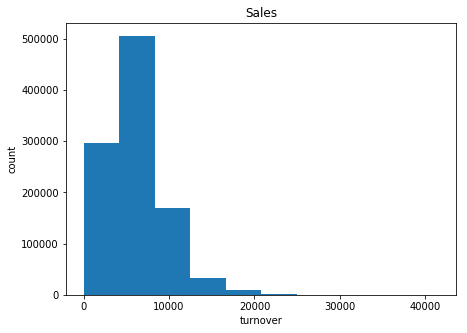

In [46]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Sales)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("Sales")

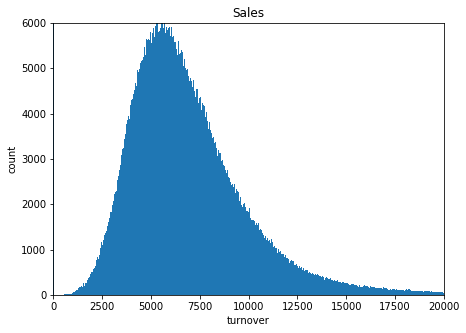

In [47]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Sales, bins=1000)
plt.xlim(0,20000)
plt.ylim(0,6000)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("Sales")

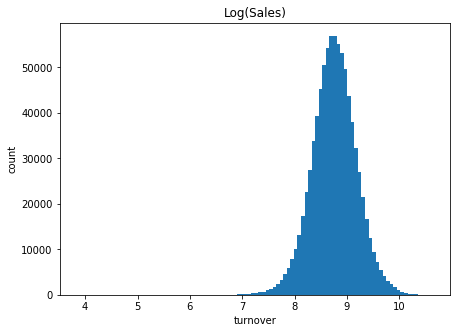

In [48]:
plt.figure(figsize=(7,5))
plt.hist(np.log1p(train_store_df[train_store_df.Sales != 0].Sales), bins= 100)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("Log(Sales)")

Sales is positive skewed distribution。

#### Date

In [49]:
train_store_df.Date.describe()

count                 1017209
unique                    942
top       2015-06-09 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: Date, dtype: object

In [50]:
train_store_df.Date.unique()

array(['2015-07-31T00:00:00.000000000', '2015-07-30T00:00:00.000000000',
       '2015-07-29T00:00:00.000000000', '2015-07-28T00:00:00.000000000',
       '2015-07-27T00:00:00.000000000', '2015-07-26T00:00:00.000000000',
       '2015-07-25T00:00:00.000000000', '2015-07-24T00:00:00.000000000',
       '2015-07-23T00:00:00.000000000', '2015-07-22T00:00:00.000000000',
       '2015-07-21T00:00:00.000000000', '2015-07-20T00:00:00.000000000',
       '2015-07-19T00:00:00.000000000', '2015-07-18T00:00:00.000000000',
       '2015-07-17T00:00:00.000000000', '2015-07-16T00:00:00.000000000',
       '2015-07-15T00:00:00.000000000', '2015-07-14T00:00:00.000000000',
       '2015-07-13T00:00:00.000000000', '2015-07-12T00:00:00.000000000',
       '2015-07-11T00:00:00.000000000', '2015-07-10T00:00:00.000000000',
       '2015-07-09T00:00:00.000000000', '2015-07-08T00:00:00.000000000',
       '2015-07-07T00:00:00.000000000', '2015-07-06T00:00:00.000000000',
       '2015-07-05T00:00:00.000000000', '2015-07-04

In [51]:
test_store_df.Date.describe()

count                   41088
unique                     48
top       2015-09-15 00:00:00
freq                      856
first     2015-08-01 00:00:00
last      2015-09-17 00:00:00
Name: Date, dtype: object

In [52]:
test_store_df.Date.unique()

array(['2015-09-17T00:00:00.000000000', '2015-09-16T00:00:00.000000000',
       '2015-09-15T00:00:00.000000000', '2015-09-14T00:00:00.000000000',
       '2015-09-13T00:00:00.000000000', '2015-09-12T00:00:00.000000000',
       '2015-09-11T00:00:00.000000000', '2015-09-10T00:00:00.000000000',
       '2015-09-09T00:00:00.000000000', '2015-09-08T00:00:00.000000000',
       '2015-09-07T00:00:00.000000000', '2015-09-06T00:00:00.000000000',
       '2015-09-05T00:00:00.000000000', '2015-09-04T00:00:00.000000000',
       '2015-09-03T00:00:00.000000000', '2015-09-02T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-08-30T00:00:00.000000000', '2015-08-29T00:00:00.000000000',
       '2015-08-28T00:00:00.000000000', '2015-08-27T00:00:00.000000000',
       '2015-08-26T00:00:00.000000000', '2015-08-25T00:00:00.000000000',
       '2015-08-24T00:00:00.000000000', '2015-08-23T00:00:00.000000000',
       '2015-08-22T00:00:00.000000000', '2015-08-21

The Date in train data is from 2013-01-01 to 2015-07-31, while the date in test data is from 2015-08-01 to 2015-09-17.

#### Customers

In [53]:
train_store_df.Customers.describe()

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64

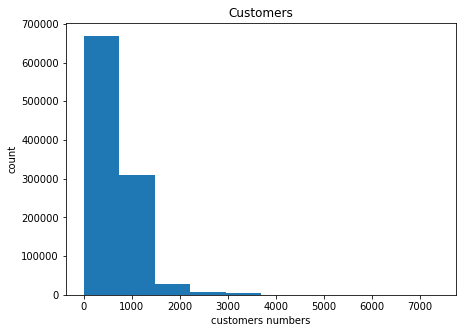

In [54]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Customers)
plt.xlabel("customers numbers")
plt.ylabel("count")
plt.title("Customers")

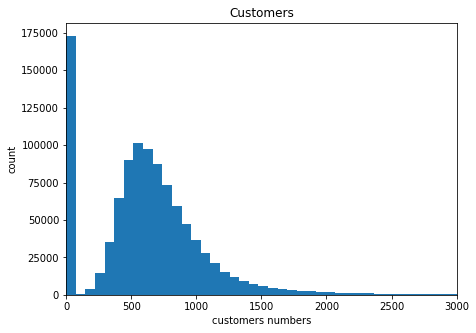

In [55]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Customers, bins=100)
plt.xlim(0,3000)
plt.xlabel("customers numbers")
plt.ylabel("count")
plt.title("Customers")

Customers has a lot of zero values and is positive skewed distribution.

#### CompetitionDistance

In [56]:
train_store_df.CompetitionDistance.describe()

count    1.017209e+06
mean     5.415982e+03
std      7.710253e+03
min      0.000000e+00
25%      7.000000e+02
50%      2.320000e+03
75%      6.880000e+03
max      7.586000e+04
Name: CompetitionDistance, dtype: float64

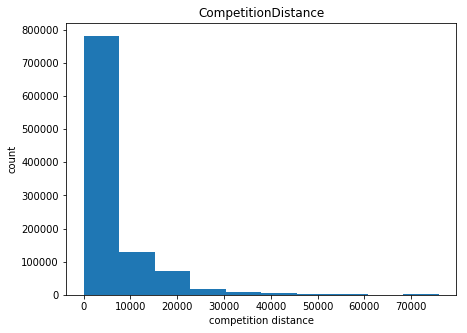

In [57]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.CompetitionDistance)
plt.xlabel("competition distance")
plt.ylabel("count")
plt.title("CompetitionDistance")

CompetitionDistance is positive skewed distribution.

#### CompetitionOpenSinceMonth

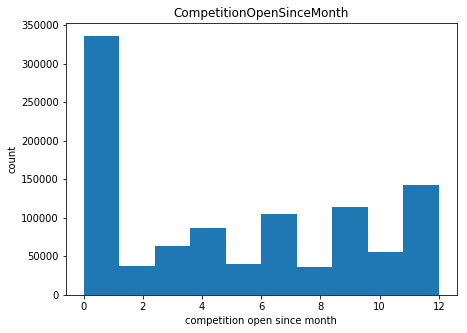

In [58]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.CompetitionOpenSinceMonth)
plt.xlabel("competition open since month")
plt.ylabel("count")
plt.title("CompetitionOpenSinceMonth")

In [59]:
train_store_df.CompetitionOpenSinceMonth.value_counts()

0.0     323348
9.0     114254
4.0      87076
11.0     84455
3.0      63548
7.0      59434
12.0     57896
10.0     55622
6.0      45444
5.0      39608
2.0      37886
8.0      36186
1.0      12452
Name: CompetitionOpenSinceMonth, dtype: int64

The zero value accounts for the majority.

#### CompetitionOpenSinceYear

In [60]:
train_store_df.CompetitionOpenSinceYear.unique()

array([ 2008.,  2007.,  2006.,  2009.,  2015.,  2013.,  2014.,  2000.,
        2011.,     0.,  2010.,  2005.,  1999.,  2003.,  2012.,  2004.,
        2002.,  1961.,  1995.,  2001.,  1990.,  1994.,  1900.,  1998.])

In [61]:
train_store_df.CompetitionOpenSinceYear.value_counts()

0.0       323348
2013.0     75426
2012.0     74299
2014.0     63732
2005.0     56564
2010.0     51258
2011.0     49396
2009.0     49396
2008.0     48476
2007.0     43744
2006.0     42802
2015.0     35060
2002.0     24882
2004.0     19804
2003.0     16794
2001.0     14704
2000.0      9236
1999.0      7352
1990.0      4710
1994.0      1884
1995.0      1700
1998.0       942
1961.0       942
1900.0       758
Name: CompetitionOpenSinceYear, dtype: int64

The zero value accounts for the majority.

#### Promo2SinceWeek

In [62]:
train_store_df.Promo2SinceWeek.unique()

array([  0.,  13.,  14.,   1.,  45.,  40.,  26.,  22.,   5.,   6.,  10.,
        31.,  37.,   9.,  39.,  27.,  18.,  35.,  23.,  48.,  36.,  50.,
        44.,  49.,  28.])

In [63]:
train_store_df.Promo2SinceWeek.value_counts()

0.0     508031
14.0     72990
40.0     62598
31.0     39976
10.0     38828
5.0      35818
37.0     32786
1.0      32418
13.0     29820
45.0     29268
22.0     28694
18.0     27318
35.0     22814
9.0      12452
27.0      9626
36.0      9236
48.0      8294
39.0      4732
23.0      4342
44.0      2642
28.0       942
50.0       942
6.0        942
26.0       942
49.0       758
Name: Promo2SinceWeek, dtype: int64

The zero value accounts for the majority.

#### Promo2SinceYear

In [64]:
train_store_df.Promo2SinceYear.unique()

array([    0.,  2010.,  2011.,  2012.,  2009.,  2014.,  2015.,  2013.])

In [65]:
train_store_df.Promo2SinceYear.value_counts()

0.0       508031
2011.0    115056
2013.0    110464
2014.0     79922
2012.0     73174
2009.0     65270
2010.0     56240
2015.0      9052
Name: Promo2SinceYear, dtype: int64

The zero value accounts for the majority.

#### PromoInterval

In [66]:
train_store_df.PromoInterval.unique()

array([0, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'], dtype=object)

In [67]:
train_store_df.PromoInterval.value_counts()

0                   508031
Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64

The zero value accounts for the majority. Jan,Apr,Jul,Oct follows the following.

### Construct some new variables

#### Construct new variables `Year`, `Month`, `Day` and `WeekOfYear`  based on `Date` .

In [68]:
#train_store_df
train_store_df['Year'] = train_store_df.Date.dt.year
train_store_df['Month'] = train_store_df.Date.dt.month
train_store_df['Day'] = train_store_df.Date.dt.day
train_store_df['WeekOfYear'] = train_store_df.Date.dt.weekofyear

train_store_df.drop('Date', axis=1, inplace=True)

In [69]:
#test_store_df
test_store_df['Year'] = test_store_df.Date.dt.year
test_store_df['Month'] = test_store_df.Date.dt.month
test_store_df['Day'] = test_store_df.Date.dt.day
test_store_df['WeekOfYear'] = test_store_df.Date.dt.weekofyear

test_store_df.drop('Date', axis=1, inplace=True)

CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code

#### Construct new variables `CompetitionOpen`

In [70]:
#train_store_df
train_store_df['CompetitionOpen'] = 12*(train_store_df.Year - train_store_df.CompetitionOpenSinceYear) + \
                                   (train_store_df.Month - train_store_df.CompetitionOpenSinceMonth)
#test_store_df
test_store_df['CompetitionOpen'] = 12*(test_store_df.Year - test_store_df.CompetitionOpenSinceYear) + \
                                   (test_store_df.Month - test_store_df.CompetitionOpenSinceMonth)

#### Construct new variables `PromoOpen` 

In [71]:
#train_store_df
train_store_df['PromoOpen'] = 12*(train_store_df.Year - train_store_df.Promo2SinceYear) + \
                                 (train_store_df.WeekOfYear - train_store_df.Promo2SinceWeek) / 4.0

train_store_df['PromoOpen'] = train_store_df.PromoOpen.apply(lambda x: x if x > 0 else 0)
train_store_df.loc[train_store_df.Promo2SinceYear == 0, 'PromoOpen'] = 0

#test_store_df
test_store_df['PromoOpen'] = 12*(test_store_df.Year - test_store_df.Promo2SinceYear) + \
                                (test_store_df.WeekOfYear - test_store_df.Promo2SinceWeek) / 4.0

test_store_df['PromoOpen'] = test_store_df.PromoOpen.apply(lambda x: x if x > 0 else 0)
test_store_df.loc[test_store_df.Promo2SinceYear == 0, 'PromoOpen'] = 0

### Bivariate Analysis

#### Sales & Open

In [72]:
train_store_df[train_store_df.Open == 0].Sales.sum()

0

In [73]:
train_store_df[(train_store_df.Open == 1) & (train_store_df.Sales == 0)]

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
22589       25          4      0          0     1      0            0   
22590       25          3      0          0     1      0            0   
25212       28          4      0          0     1      1            0   
25213       28          3      0          0     1      1            0   
25214       28          2      0          0     1      1            0   
51491       57          2      0          0     1      1            0   
92570      102          4      0          0     1      0            0   
92582      102          6      0          0     1      0            0   
205303     227          4      0          0     1      0            0   
210424     232          4      0          0     1      1            0   
215530     238          4      0          0     1      0            0   
235476     259          4      0          0     1      1            0   
274736     303          4      0          0     1      0            0   
297110     327          3      0          0     1      0            0   
308819     339          4      0          0     1      0            0   
308820     339          3      0          0     1      0            0   
321411     353          6      0          0     1      0            0   
324624     357          1      0          0     1      0            0   
331720     364          3      0          0     1      0            0   
331721     364          2      0          0     1      0            0   
352576     387          4      0          0     1      0            0   
356674     391          3      0          0     1      1            0   
499043     548          5      0          0     1      1            0   
537239     589          1      0          0     1      1            0   
567892     623          6      0          0     1      0            0   
567893     623          5      0          0     1      1            0   
601963     661          5      0          0     1      1            0   
604061     663          1      0          0     1      0            0   
606010     665          6      0          0     1      0            0   
606011     665          5      0          0     1      0            0   
613301     674          4      0          0     1      0            0   
620396     681          5      0          0     1      0            0   
636348     699          4      0          0     1      1            0   
637900     700          3      0          0     1      1            0   
644401     708          3      0          0     1      1            0   
694235     762          4      0          0     1      0            0   
760375     835          4      0          0     1      0            0   
760376     835          3      0          0     1      0            0   
774487     850          6      0          0     1      0            0   
803779     882          3      0          0     1      0            0   
808305     887          3      0          0     1      0            0   
842281     925          4      0          0     1      1            0   
844494     927          4      0          0     1      0            0   
864013     948          4      0          5     1      1            0   
884745     971          5      0          0     1      0            0   
896163     983          6      0          0     1      0            0   
896164     983          5      0          0     1      0            0   
898930     986          2      0          0     1      1            0   
927132    1017          4      0          0     1      1            0   
927133    1017          3      0          0     1      1            0   
947634    1039          3      0          0     1      0            0   
947635    1039          2      0          0     1      0            0   
1003330   1100          3      0          0     1      1            0   
1003331   1100          2      0          3     1      1           

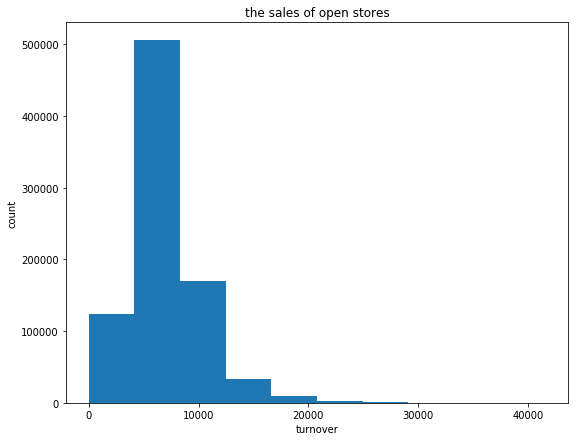

In [74]:
plt.figure(figsize=(9,7))
plt.hist(train_store_df[train_store_df.Open == 1].Sales)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("the sales of open stores")

There are some opened stores which have zero sales.

#### Analysis of sales!=0 and open != 0

In [75]:
train_store_sales_df = train_store_df[(train_store_df.Sales != 0) & (train_store_df.Open != 0)]

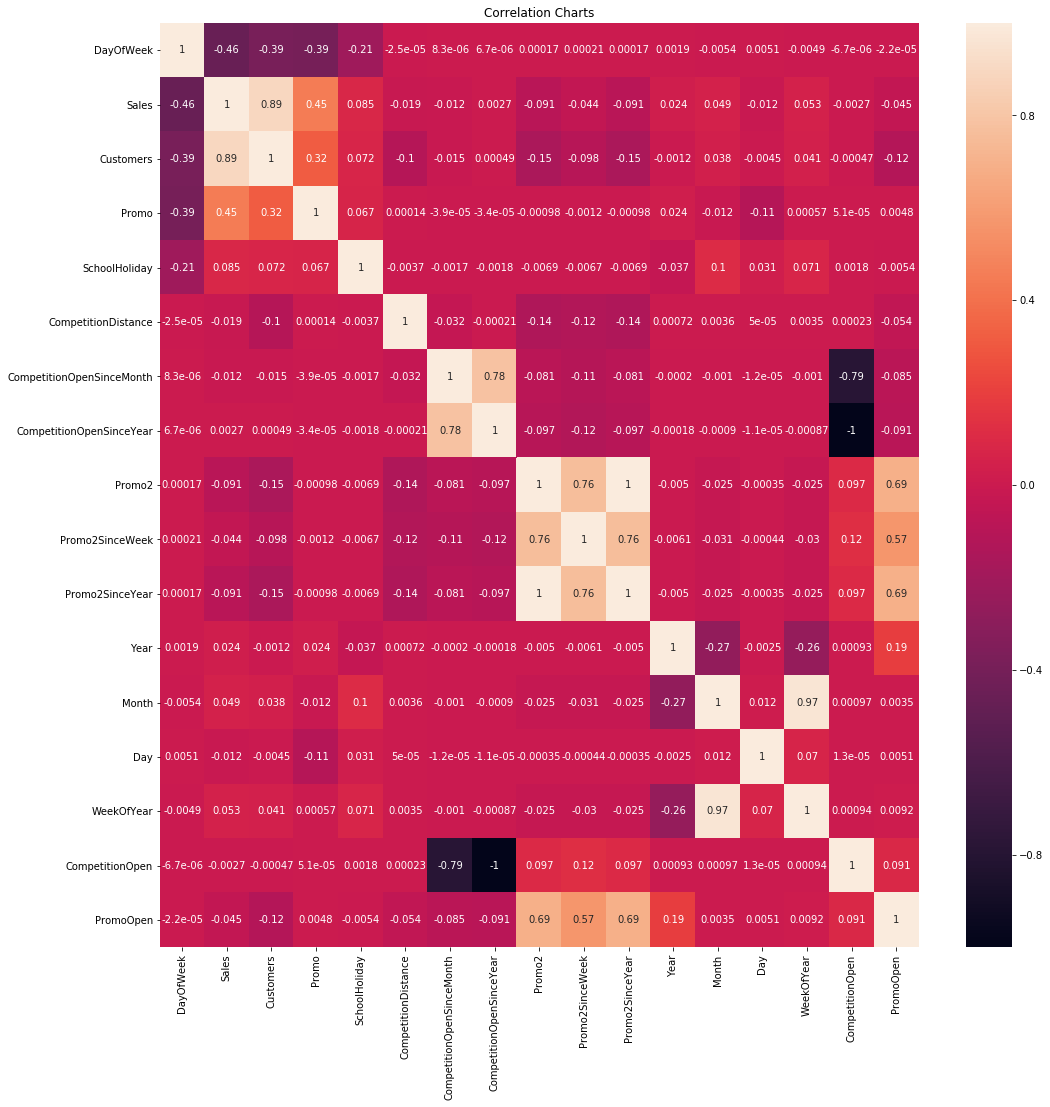

In [76]:
plt.figure(figsize=(17,17))
corr_mat = train_store_df.drop(['Store','Open'], axis=1).corr()
sns.heatmap(corr_mat,annot=True)
plt.title('Correlation Charts')

####  Sales & DayOfWeek

In [77]:
train_store_sales_df.groupby('DayOfWeek').Sales.mean()

DayOfWeek
1    8216.252259
2    7088.409086
3    6728.786679
4    6768.214973
5    7073.034133
6    5875.084935
7    8224.723908
Name: Sales, dtype: float64

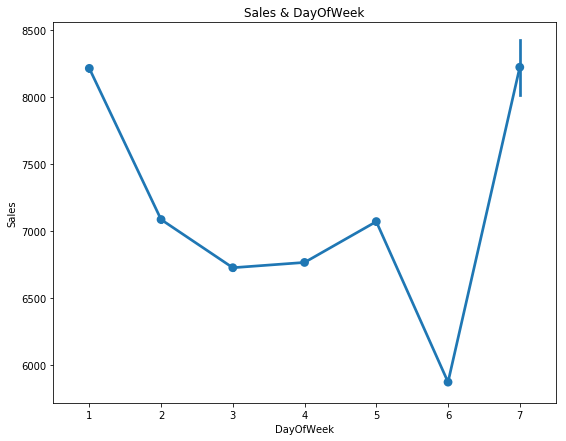

In [78]:
plt.figure(figsize=(9,7))
sns.pointplot(train_store_sales_df['DayOfWeek'], train_store_sales_df['Sales'])
plt.title("Sales & DayOfWeek")

Sales on Saturday are the lowest.

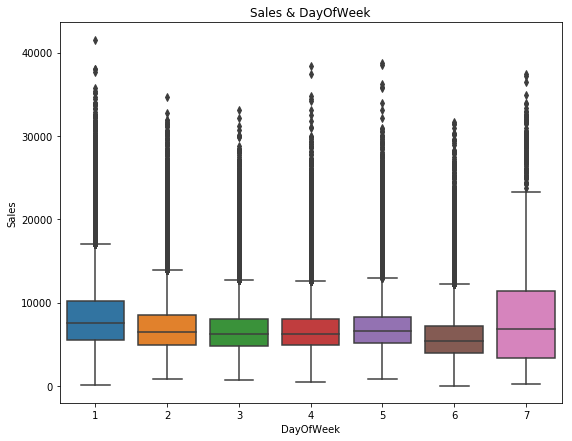

In [79]:
plt.figure(figsize=(9,7))
sns.boxplot(train_store_sales_df['DayOfWeek'], train_store_sales_df['Sales'])
plt.title("Sales & DayOfWeek")

There seems to be some abnormal points. The daily sales are almost the same.

####  Sales & WeekOfYear

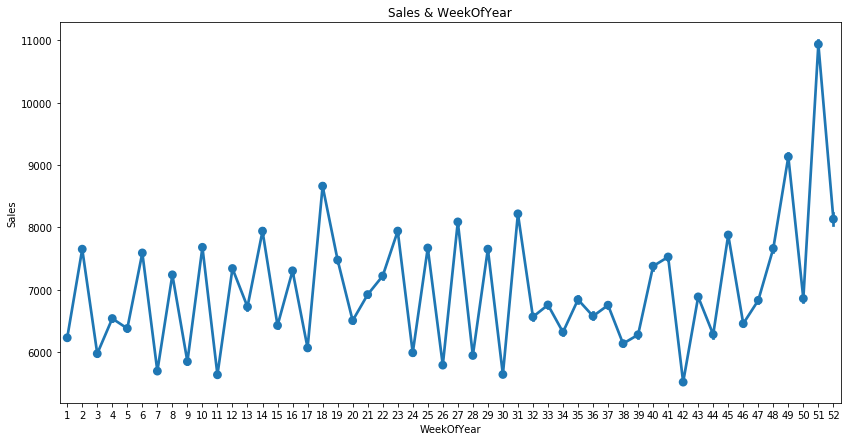

In [80]:
plt.figure(figsize=(14,7))
sns.pointplot(train_store_sales_df['WeekOfYear'], train_store_sales_df['Sales'])
plt.title("Sales & WeekOfYear")

#### Sales & Year

In [81]:
train_store_sales_df.groupby('Year').Sales.sum()

Year
2013    2302876084
2014    2180804896
2015    1389499643
Name: Sales, dtype: int64

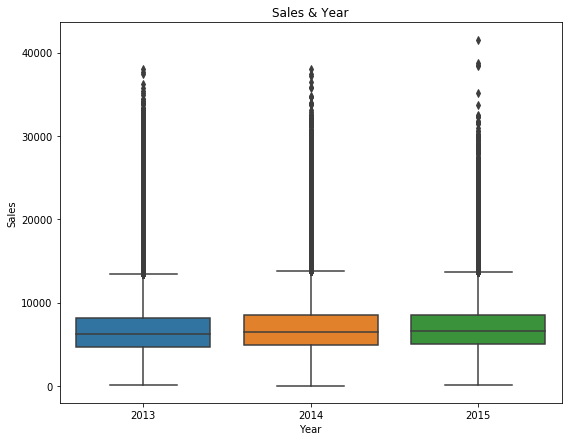

In [82]:
plt.figure(figsize=(9,7))
sns.boxplot(train_store_sales_df['Year'], train_store_sales_df['Sales'])
plt.title("Sales & Year")

The three years sales are almost the same.

#### Sales & Month

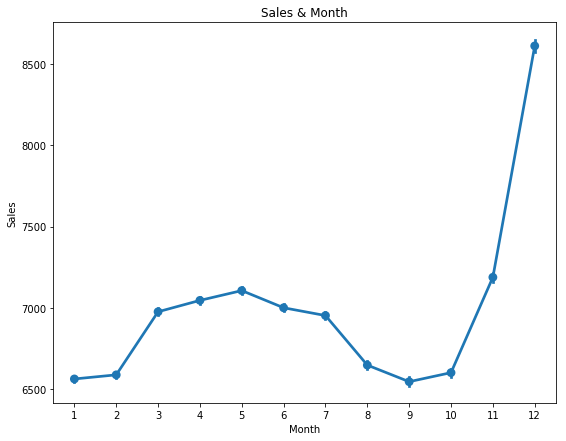

In [83]:
plt.figure(figsize=(9,7))
sns.pointplot(train_store_sales_df['Month'], train_store_sales_df['Sales'])
plt.title("Sales & Month")

The December sales is the largest.

#### Sales & Day

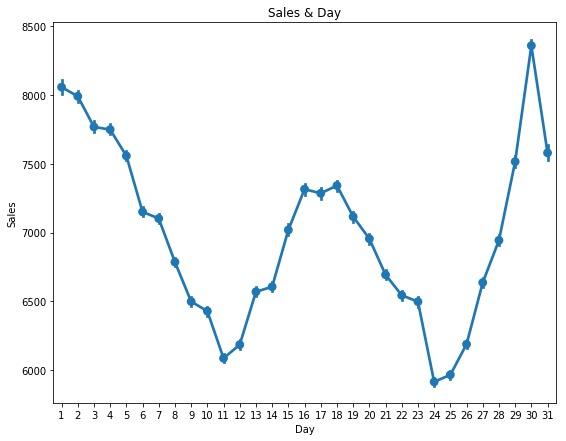

In [84]:
plt.figure(figsize=(9,7))
sns.pointplot(train_store_sales_df['Day'], train_store_sales_df['Sales'])
plt.title("Sales & Day")

we see that sales are the most at the beginning of the month, the monthly, and the end of the month.
There is a strong rule between the two variables.

#### Sales & Customers

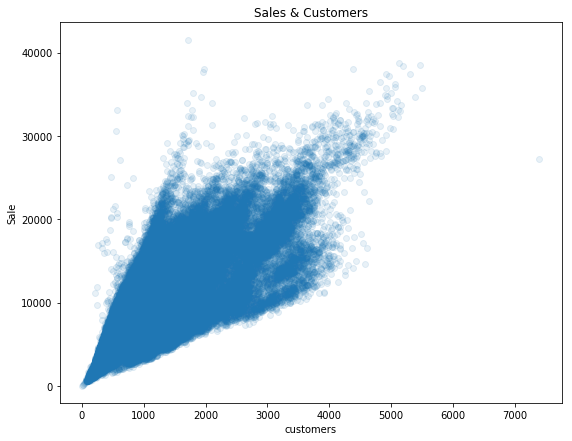

In [85]:
plt.figure(figsize=(9,7))
plt.scatter(data=train_store_sales_df, x='Customers', y='Sales', alpha=0.1)
plt.xlabel('customers')
plt.ylabel('Sale')
plt.title("Sales & Customers")

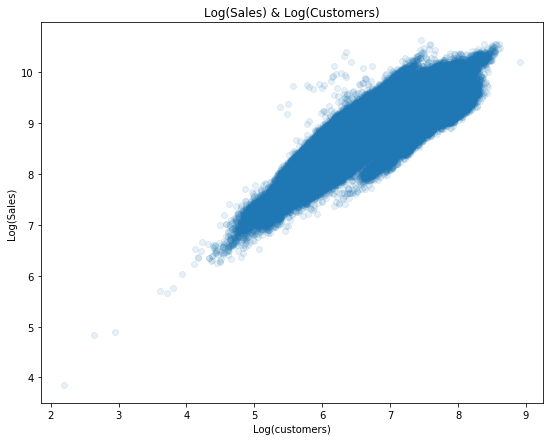

In [86]:
plt.figure(figsize=(9,7))
plt.scatter(np.log1p(train_store_sales_df.Customers), np.log1p(train_store_sales_df.Sales), alpha=0.1)
plt.xlabel('Log(customers)')
plt.ylabel('Log(Sales)')
plt.title("Log(Sales) & Log(Customers)")

There is a strong positive correlation between sales and customer.

#### Sales & Promo

In [87]:
train_store_sales_df.groupby('Promo').Sales.mean()

Promo
0    5929.826183
1    8228.739731
Name: Sales, dtype: float64

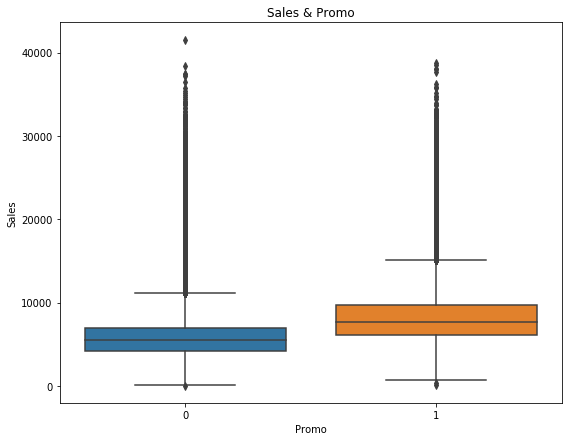

In [88]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='Promo', y='Sales')
plt.title("Sales & Promo")

We can know that promotion is benifit to improve sales.

#### Sales & StateHoliday

In [89]:
train_store_sales_df.StateHoliday = train_store_sales_df.StateHoliday.astype('str')
train_store_sales_df[train_store_sales_df.StateHoliday == '0'].StateHoliday = train_store_sales_df[train_store_sales_df.StateHoliday == '0'].StateHoliday.astype('int')

D:\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [90]:
train_store_sales_df.groupby('StateHoliday').Sales.mean()

StateHoliday
0    6953.960229
a    8487.471182
b    9887.889655
c    9743.746479
Name: Sales, dtype: float64

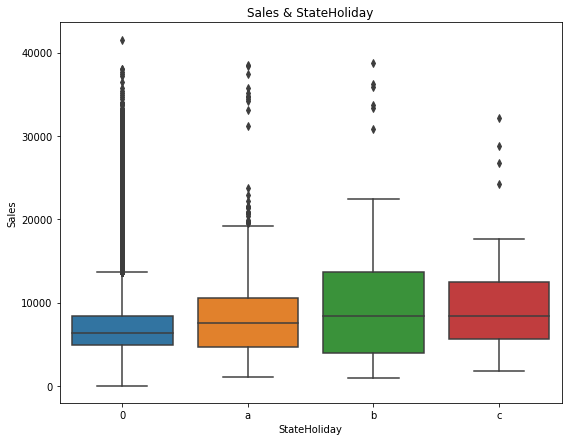

In [91]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='StateHoliday', y='Sales')
plt.title("Sales & StateHoliday")

#### Sales & SchoolHoliday

In [92]:
train_store_sales_df.groupby('SchoolHoliday').Sales.mean()

SchoolHoliday
0    6897.207830
1    7200.710282
Name: Sales, dtype: float64

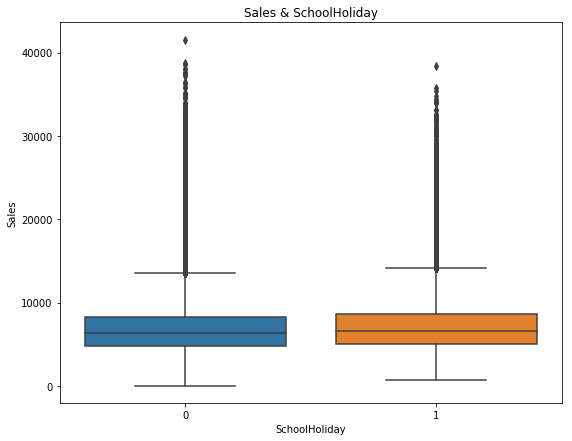

In [93]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='SchoolHoliday', y='Sales')
plt.title("Sales & SchoolHoliday")

#### Sales & StoreType

In [94]:
train_store_sales_df.groupby('StoreType').Sales.mean()

StoreType
a     6925.697986
b    10233.380141
c     6933.126425
d     6822.300064
Name: Sales, dtype: float64

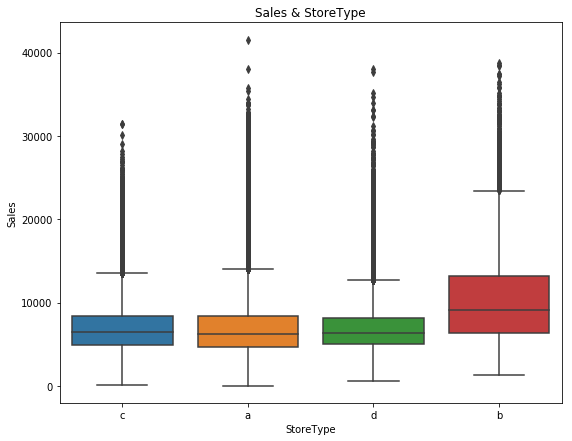

In [95]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='StoreType', y='Sales')
plt.title("Sales & StoreType")

Store sales of 'b' type are the most.

#### Sales & Assortment

In [96]:
train_store_sales_df.groupby('Assortment').Sales.mean()

Assortment
a    6621.523057
b    8642.503594
c    7300.843547
Name: Sales, dtype: float64

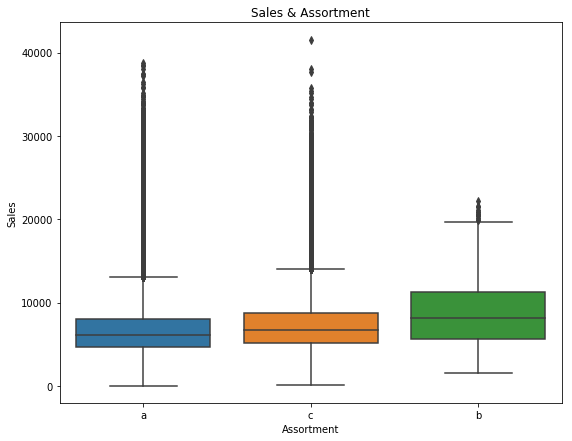

In [97]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='Assortment', y='Sales')
plt.title("Sales & Assortment")

Store sales of  'b' assortment are the most.

#### Sales & CompetitionDistance

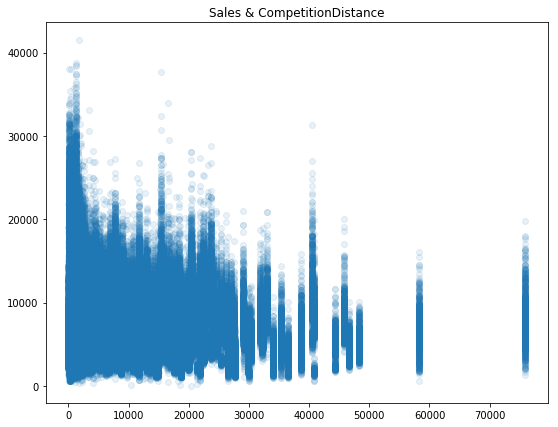

In [98]:
plt.figure(figsize=(9,7))
plt.scatter(data=train_store_sales_df, x='CompetitionDistance', y='Sales', alpha=0.1)
plt.title("Sales & CompetitionDistance")

There is no correlation between sales and CompetitionDistance.

#### Sales & CompetitionOpen

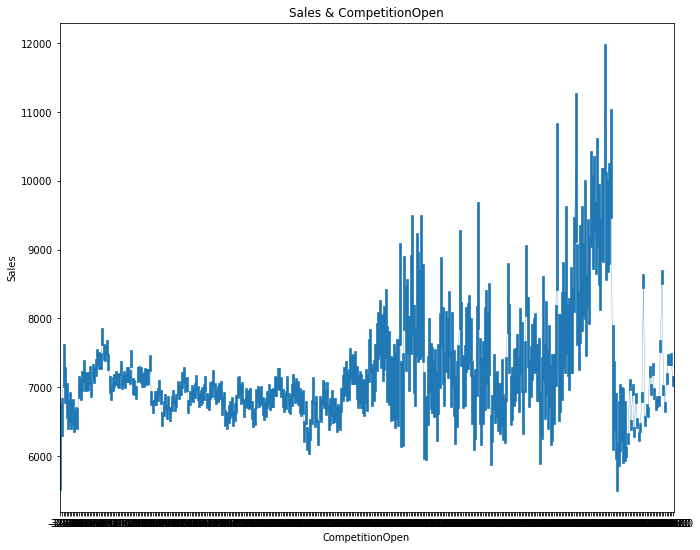

In [99]:
plt.figure(figsize=(11,9))
sns.pointplot(data=train_store_sales_df, x='CompetitionOpen', y='Sales',scale=0.1)
plt.title("Sales & CompetitionOpen")

There is a weak rule between sales and CompetitionOpen.

#### Sales & Promo2

In [100]:
train_store_sales_df.groupby('Promo2').Sales.sum()

Promo2
0    3111542628
1    2761637995
Name: Sales, dtype: int64

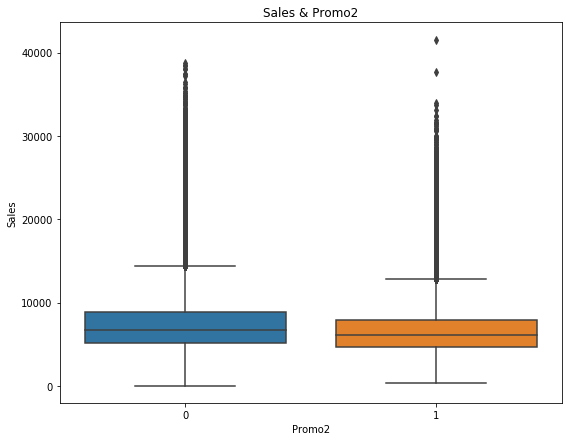

In [101]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='Promo2', y='Sales')
plt.title("Sales & Promo2")

The stores with promos tend to make lower sales. This does not necessary mean that the promos don’t help or are counterproductive. They are possibly measures that are taken mainly by stores with low sales in the first place.

#### Sales & PromoOpen

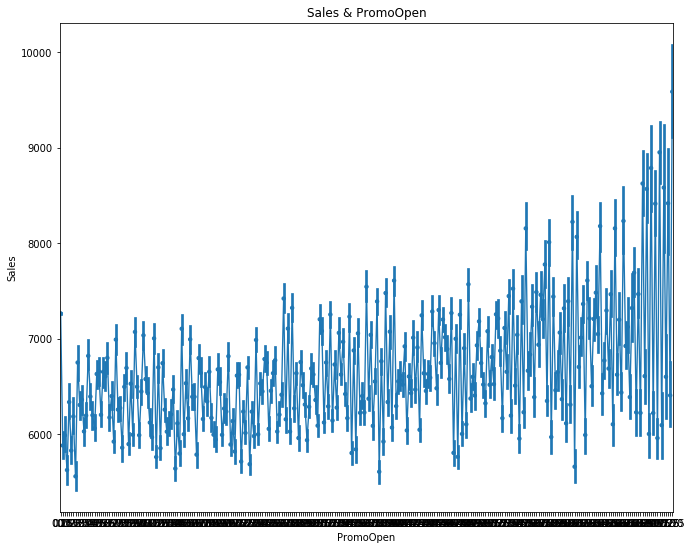

In [102]:
plt.figure(figsize=(11,9))
sns.pointplot(data=train_store_sales_df, x='PromoOpen', y='Sales',scale=0.5)
plt.title("Sales & PromoOpen")

It seems that the longer the time is, the bigger the sales are.

There is no correlation between sales and Promo2SinceYear.

#### Sales & PromoInterval

In [103]:
train_store_sales_df.groupby('PromoInterval').Sales.mean()

PromoInterval
0                   7350.818414
Feb,May,Aug,Nov     6427.367069
Jan,Apr,Jul,Oct     6726.367401
Mar,Jun,Sept,Dec    6215.888185
Name: Sales, dtype: float64

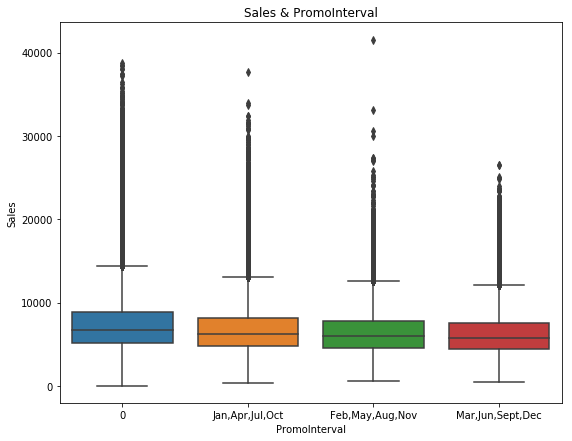

In [104]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='PromoInterval', y='Sales')
plt.title("Sales & PromoInterval")

There is no correlation between sales and PromoInterval.

#### Brief Summary

From above bivariate analysis, we can see that there is a strong positive correlation between sales and customer.
There is a certain relationship between variables Sales and  Day, DayofWeek, WeekofYear, CompetitionOpen, PromoOpen.

### Multivariate Analysis

#### Sales & DayOfWeek & StoreType & Promo 

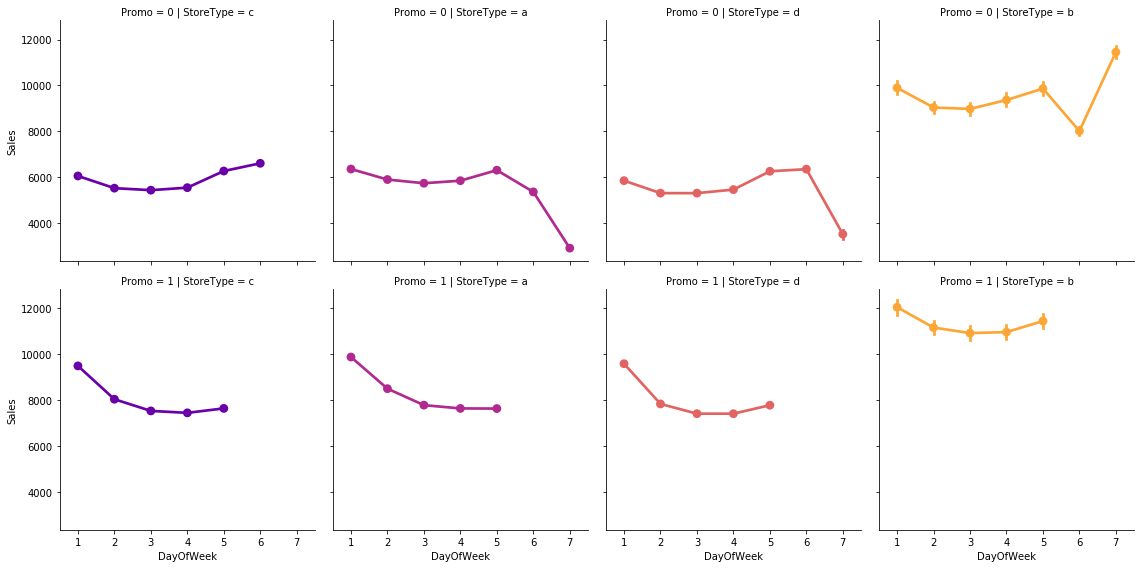

In [105]:
sns.factorplot(data = train_store_sales_df, x = 'DayOfWeek', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

We can see that stores are never promoted at the weekend.

#### Sales & WeekOfYear & StoreType & Promo 

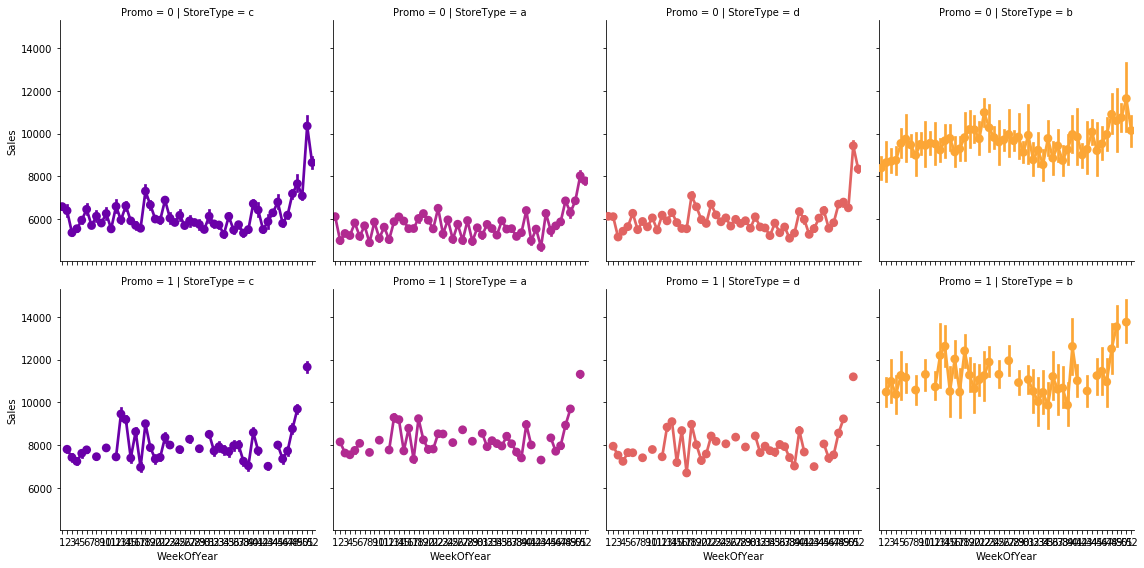

In [106]:
sns.factorplot(data = train_store_sales_df, x = 'WeekOfYear', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

#### Sales & Month & StoreType & Promo 

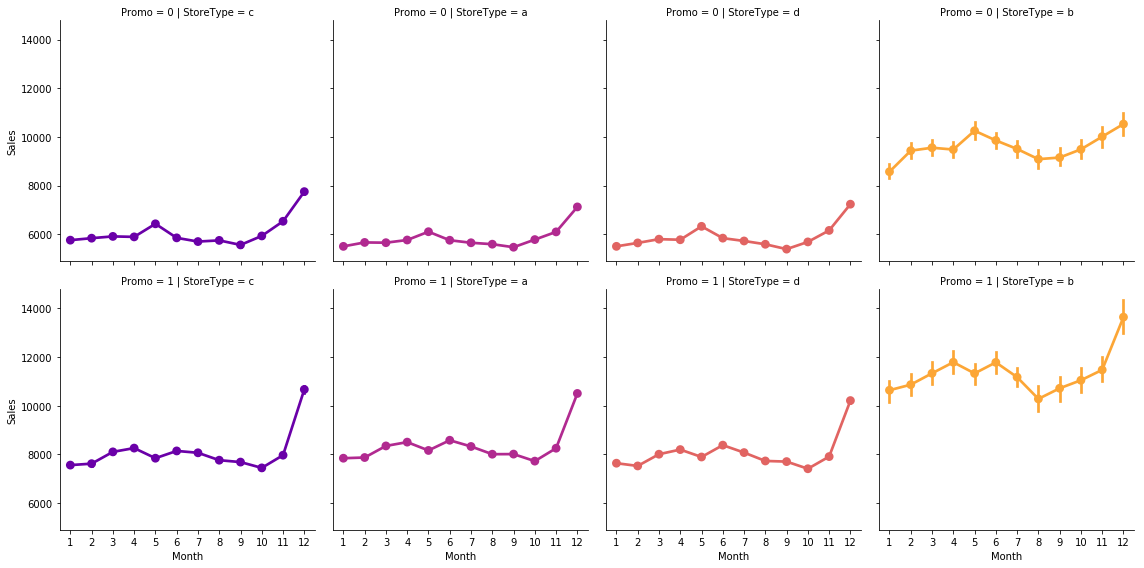

In [107]:
sns.factorplot(data = train_store_sales_df, x = 'Month', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

Sales promotion can improve sales to a certain extent. There is a distinct increase in sales in the fourth quarter.

#### Sales & Month & Assortment	 & StoreType

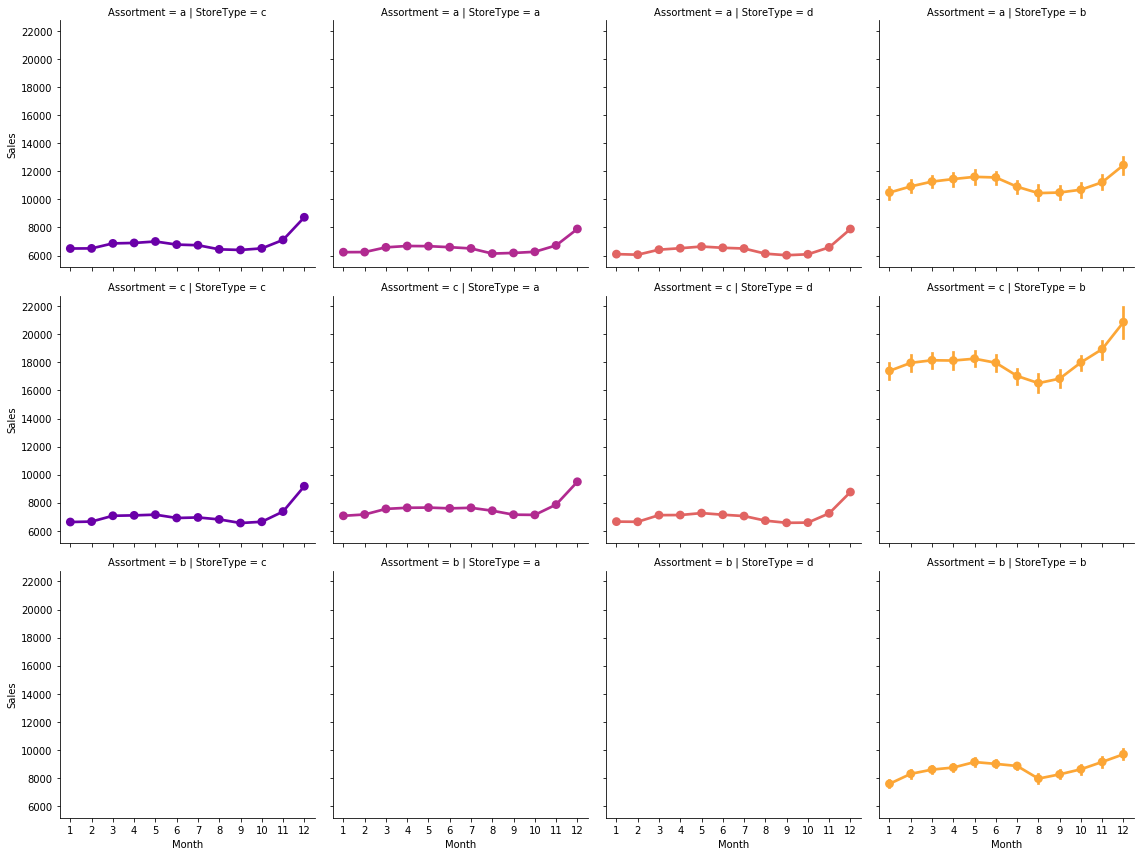

In [108]:
sns.factorplot(data = train_store_sales_df, x = 'Month', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Assortment')

Only 'b' type stores have 'b' assortment level.

#### Sales & Day & StoreType & Promo 

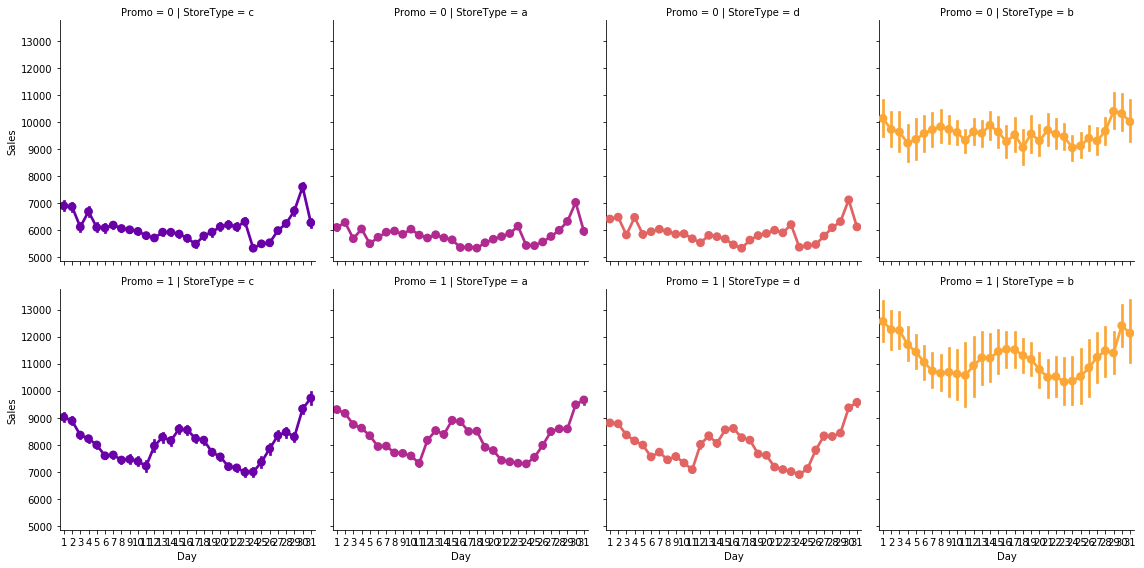

In [109]:
sns.factorplot(data = train_store_sales_df, x = 'Day', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

All types of stores have a similar trend, and sales are the most at the beginning of the month, the monthly, and the end of the month.

#### Sales & Month & DayOfWeek & StoreType

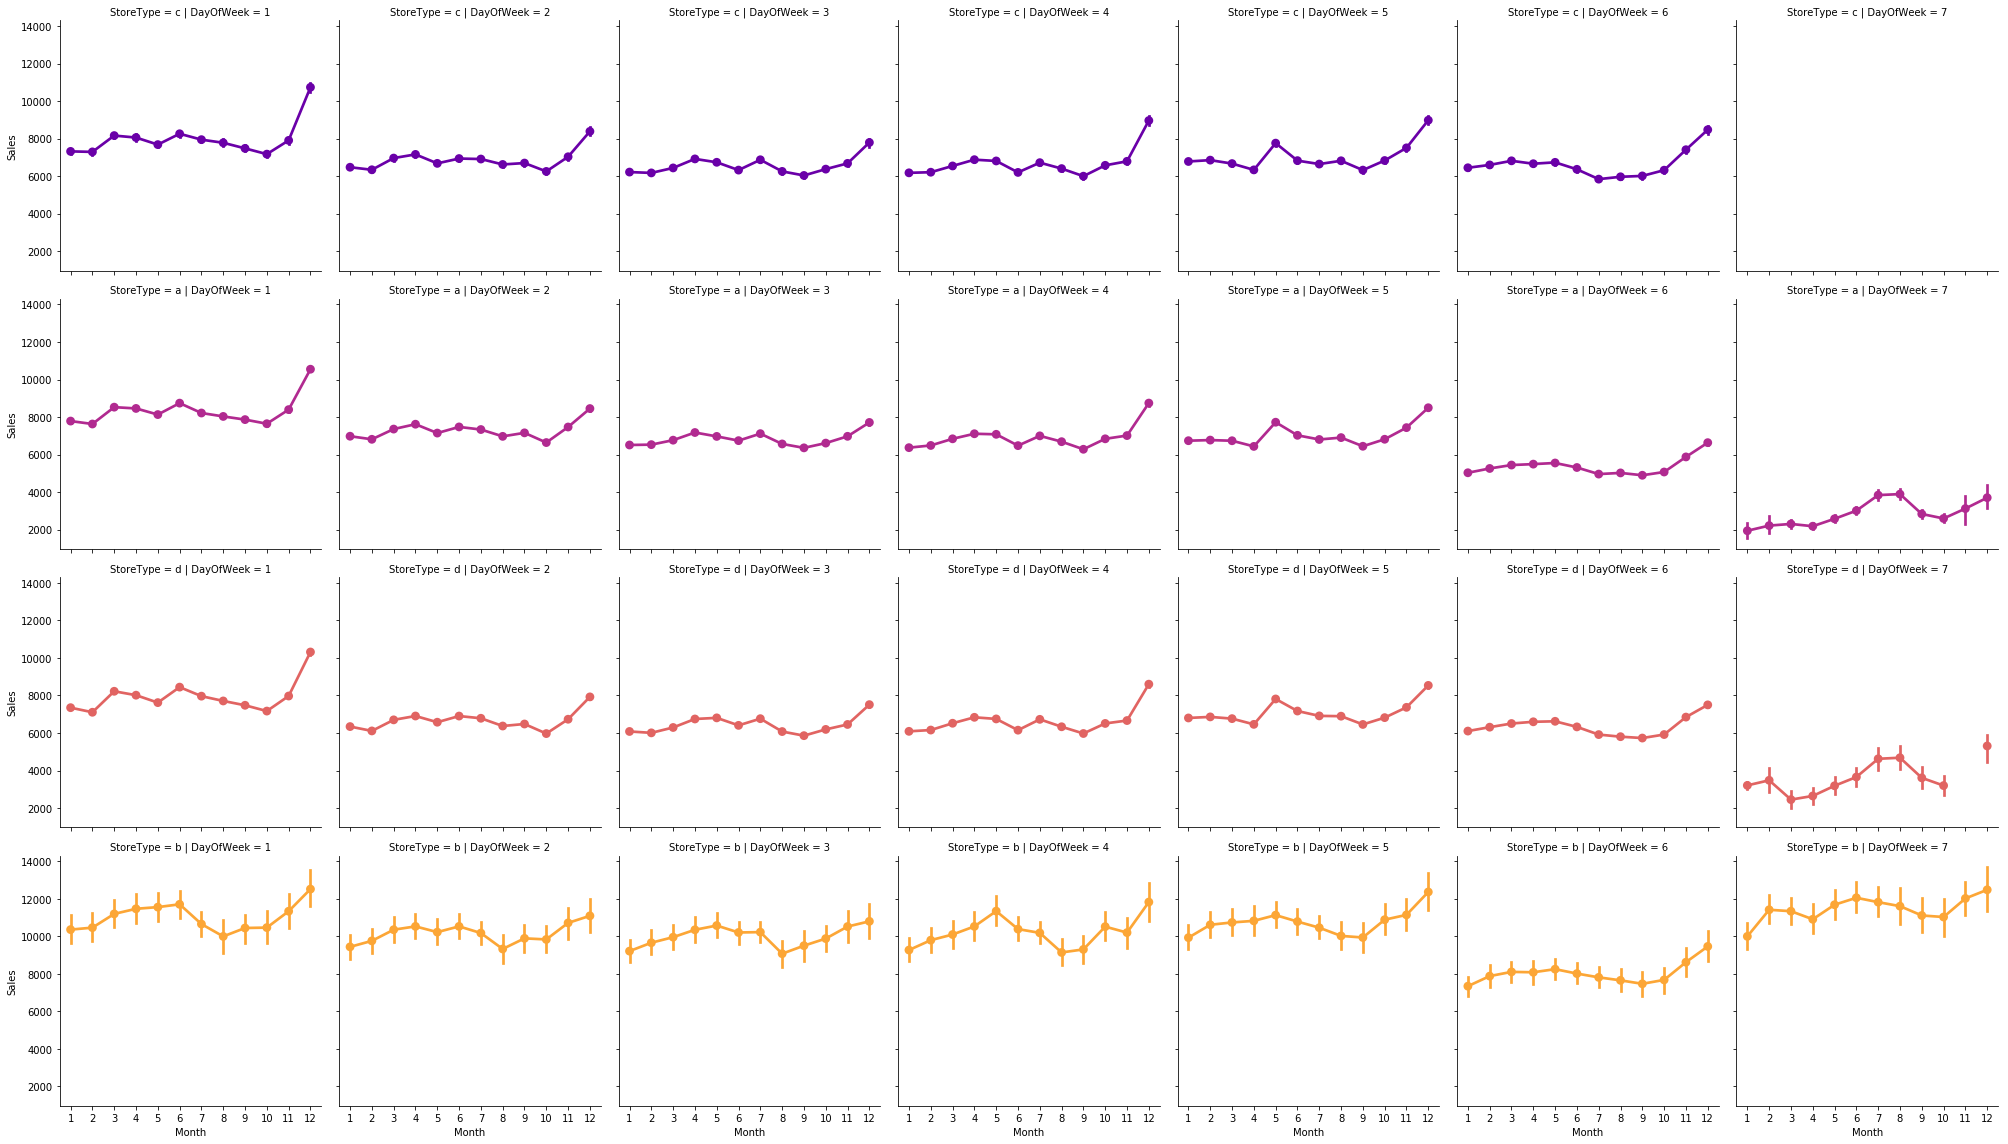

In [110]:
sns.factorplot(data = train_store_sales_df, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType') 

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

#### Sales & StateHoliday & Promo & StoreType

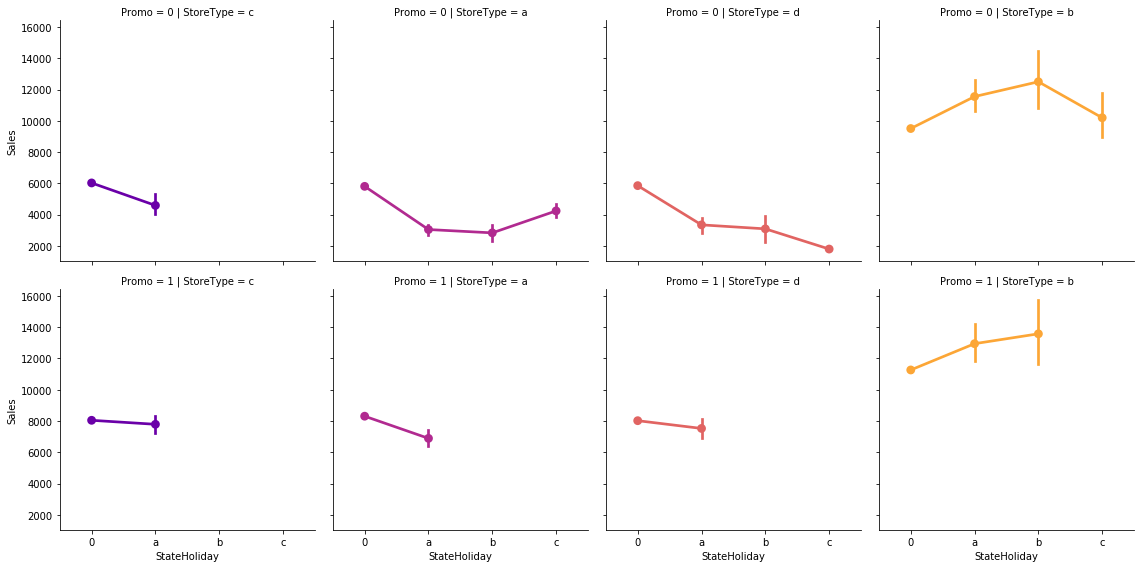

In [111]:
sns.factorplot(data = train_store_sales_df, x = 'StateHoliday', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

Only B type stores will be promoted on Easter, and there is no promotion on Christmas.

#### Sales & SchoolHoliday & Promo & StoreType

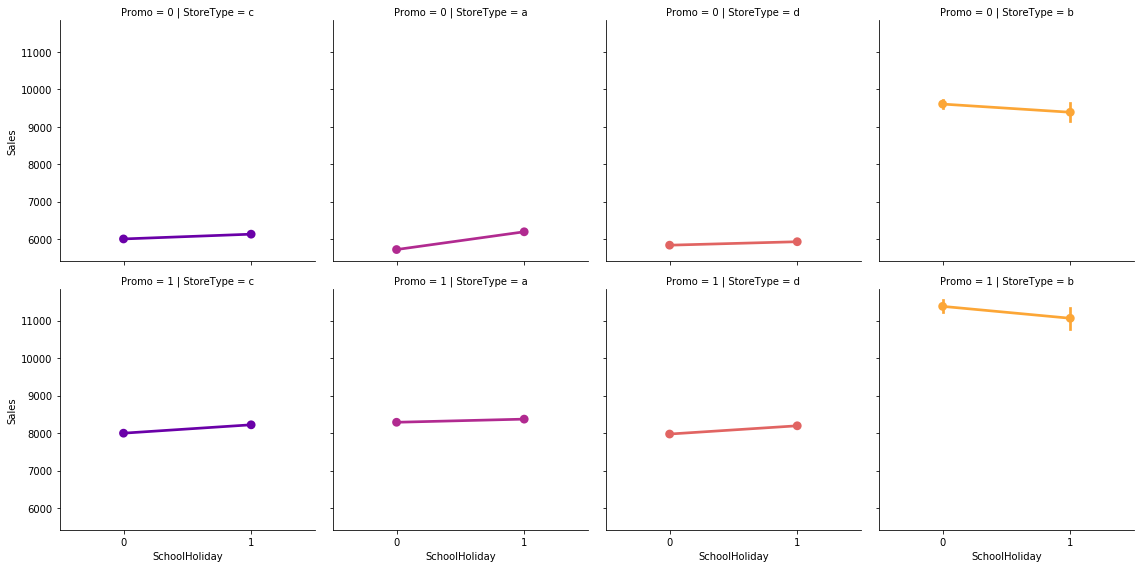

In [112]:
sns.factorplot(data = train_store_sales_df, x = 'SchoolHoliday', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

## Feature Engineering

In [113]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              1017209 non-null float64
PromoInterval                1017209 non-n

In [114]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 22 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Open                         41088 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval                41088 non-null object
Year                         41088 non-null int64
Month                    

#### Encoding

In [115]:
#train
mappings = {'0':0,'a':1, 'b':2, 'c':3, 'd':4}
train_store_df.StateHoliday.replace(mappings, inplace=True)
train_store_df.StoreType.replace(mappings, inplace=True)
train_store_df.Assortment.replace(mappings, inplace=True)

#test
test_store_df.StateHoliday.replace(mappings, inplace=True)
test_store_df.StoreType.replace(mappings, inplace=True)
test_store_df.Assortment.replace(mappings, inplace=True)

#### Choice X,y for training

In [116]:
# Consider only open stores which Sales bigger then zero for training.
train_drop_features = ['Customers', 'Sales','CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
                       'Promo2SinceWeek','Promo2SinceYear','PromoInterval']
X = train_store_df[(train_store_df.Open != 0 ) & (train_store_df.Sales != 0)].drop(train_drop_features, axis=1)
y = train_store_df[(train_store_df.Open != 0 ) & (train_store_df.Sales != 0)].Sales
y = np.log1p(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=23)

In [117]:
test_drop_features = ['Id','CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
                      'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
X_test = test_store_df.drop(test_drop_features, axis=1)

## Model

In [118]:
"""
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe
"""
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

#xgboost
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

#lightgbm
def rmspe_lgb(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat), False

#sklearn interface
def rmspe_gscv(y, yhat):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    return rmspe(y, yhat)

rmspe_score = make_scorer(rmspe_gscv)
kfold = KFold(n_splits=5, random_state=23)

### xgboost

In [125]:
xgbtrain = xgb.DMatrix(X, label=y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

#### Tuning Paramters

In [126]:
xgb_best_params = {}
params = {'booster': 'gbtree',
          'objective': 'reg:linear',
          'max_depth': 6, 
          'learning_rate': 1,
          'gamma': 0, 
          'min_child_weight': 1, 
          'subsample': 1, 
          'colsample_bytree': 1, 
          'reg_alpha': 0, 
          'reg_lambda ': 1,
          'random_state': 23,
          'gpu_id': 0,
          'max_bin': 16,
          'tree_method': 'gpu_exact'
         }

#### n_estimators

In [182]:
min_merror = np.inf
for n_estimators in range(10,100,10):
    params['n_estimators'] = n_estimators
    cv_results = xgb.cv(params, dtrain, nfold=3, num_boost_round=1000, early_stopping_rounds=30, feval=rmspe_xg, seed=23)
    mean_error = min(cv_results['test-rmspe-mean'])
    boost_rounds = np.argmin(cv_results['test-rmspe-mean'])
    
    if mean_error < min_merror:
        min_merror = mean_error
        xgb_best_params["n_estimators"] = n_estimators
  
params["n_estimators"] = xgb_best_params["n_estimators"]
xgb_best_params,min_merror

({'n_estimators': 80}, 0.18077433333333334)

#### max_depth & min_child_weight

In [183]:
min_merror = np.inf
for max_depth in range(6, 11, 1):
    for min_child_weight in range(1, 6, 1):
        params['max_depth'] = max_depth
        params['min_child_weight'] = min_child_weight
        cv_results = xgb.cv(params, dtrain, nfold=3,num_boost_round=1000, early_stopping_rounds=50, feval=rmspe_xg, seed=23)
        mean_error = min(cv_results['test-rmspe-mean'])
        boost_rounds = np.argmin(cv_results['test-rmspe-mean'])
    
        if mean_error < min_merror:
            min_merror = mean_error
            xgb_best_params["max_depth"] = max_depth
            xgb_best_params["min_child_weight"] = min_child_weight
  
params["max_depth"] = xgb_best_params["max_depth"]
params["min_child_weight"] = xgb_best_params["min_child_weight"]
xgb_best_params,min_merror

[0]	train-rmse:0.358468+0.00025745	train-rmspe:0.441136+0.00728245	test-rmse:0.358629+0.000378013	test-rmspe:0.441386+0.0137289
[1]	train-rmse:0.348474+0.000846398	train-rmspe:0.42985+0.00634537	test-rmse:0.348758+0.00120105	test-rmspe:0.430976+0.0127648
[2]	train-rmse:0.33991+0.00457617	train-rmspe:0.413501+0.00911821	test-rmse:0.340302+0.00427877	test-rmspe:0.424219+0.0229319
[3]	train-rmse:0.330418+0.00553642	train-rmspe:0.407148+0.0137657	test-rmse:0.330949+0.00505963	test-rmspe:0.410927+0.0246698
[4]	train-rmse:0.321351+0.00235177	train-rmspe:0.393227+0.00207555	test-rmse:0.321981+0.00176384	test-rmspe:0.40198+0.0242136
[5]	train-rmse:0.311365+0.00303316	train-rmspe:0.381829+0.00495372	test-rmse:0.312049+0.00290536	test-rmspe:0.38474+0.0100107
[6]	train-rmse:0.301211+0.000720246	train-rmspe:0.370261+0.00566271	test-rmse:0.302073+0.000985461	test-rmspe:0.373701+0.0095558
[7]	train-rmse:0.292055+0.00305402	train-rmspe:0.362406+0.00113993	test-rmse:0.292893+0.00247325	test-rmspe:0.36

[65]	train-rmse:0.143616+0.0029613	train-rmspe:0.197369+0.014218	test-rmse:0.146786+0.00209917	test-rmspe:0.216183+0.0389002
[66]	train-rmse:0.143016+0.0028017	train-rmspe:0.196324+0.0147364	test-rmse:0.146232+0.00192515	test-rmspe:0.215831+0.0389028
[67]	train-rmse:0.14235+0.00294338	train-rmspe:0.195277+0.014371	test-rmse:0.14561+0.00203943	test-rmspe:0.213937+0.0380095
[68]	train-rmse:0.141796+0.0029559	train-rmspe:0.195281+0.0146493	test-rmse:0.145098+0.00209101	test-rmspe:0.214205+0.0381159
[69]	train-rmse:0.141386+0.00296124	train-rmspe:0.195025+0.0147448	test-rmse:0.144718+0.00209965	test-rmspe:0.213882+0.038223
[70]	train-rmse:0.140794+0.00268462	train-rmspe:0.194558+0.0147786	test-rmse:0.144148+0.0018862	test-rmspe:0.218056+0.043546
[71]	train-rmse:0.140124+0.00271636	train-rmspe:0.193908+0.0149703	test-rmse:0.14348+0.00193167	test-rmspe:0.217461+0.0438384
[72]	train-rmse:0.139571+0.00253961	train-rmspe:0.192798+0.0143894	test-rmse:0.142953+0.00174166	test-rmspe:0.216851+0.043

[130]	train-rmse:0.120883+0.0020339	train-rmspe:0.165663+0.0231895	test-rmse:0.126268+0.0013704	test-rmspe:0.203839+0.0477665
[131]	train-rmse:0.120604+0.00203761	train-rmspe:0.165263+0.0231025	test-rmse:0.126025+0.00138739	test-rmspe:0.203661+0.0477505
[132]	train-rmse:0.120395+0.00197238	train-rmspe:0.164766+0.0235296	test-rmse:0.125886+0.00135972	test-rmspe:0.203578+0.0476198
[133]	train-rmse:0.120136+0.00190207	train-rmspe:0.16445+0.0235218	test-rmse:0.125664+0.00132938	test-rmspe:0.201087+0.0449363
[134]	train-rmse:0.11993+0.00187993	train-rmspe:0.164275+0.0236865	test-rmse:0.125496+0.00129327	test-rmspe:0.200895+0.0447886
[135]	train-rmse:0.119671+0.00187237	train-rmspe:0.164043+0.0237436	test-rmse:0.125262+0.00128865	test-rmspe:0.200897+0.0449942
[136]	train-rmse:0.119541+0.00185234	train-rmspe:0.163994+0.0239149	test-rmse:0.125159+0.00125884	test-rmspe:0.200733+0.0449465
[137]	train-rmse:0.119309+0.00181299	train-rmspe:0.163841+0.0238481	test-rmse:0.124972+0.00125704	test-rmspe

[194]	train-rmse:0.11077+0.0011734	train-rmspe:0.151127+0.0203233	test-rmse:0.118055+0.000567819	test-rmspe:0.193669+0.0442223
[195]	train-rmse:0.110627+0.00116209	train-rmspe:0.150964+0.020367	test-rmse:0.11794+0.000559572	test-rmspe:0.192647+0.0432835
[196]	train-rmse:0.110417+0.00104597	train-rmspe:0.150795+0.0204995	test-rmse:0.117752+0.000451355	test-rmspe:0.192533+0.0433145
[197]	train-rmse:0.110344+0.00105984	train-rmspe:0.150741+0.0205097	test-rmse:0.117707+0.000459139	test-rmspe:0.192503+0.0433299
[198]	train-rmse:0.110229+0.00104232	train-rmspe:0.150944+0.0207356	test-rmse:0.117616+0.000441362	test-rmspe:0.192295+0.0432025
[199]	train-rmse:0.110135+0.00103666	train-rmspe:0.150869+0.0207593	test-rmse:0.117564+0.000449177	test-rmspe:0.191759+0.0432166
[200]	train-rmse:0.11005+0.00103909	train-rmspe:0.150842+0.0207485	test-rmse:0.117507+0.000449418	test-rmspe:0.191605+0.0431137
[201]	train-rmse:0.109905+0.000979501	train-rmspe:0.150673+0.0211237	test-rmse:0.117414+0.000382608	te

[258]	train-rmse:0.104354+0.000855081	train-rmspe:0.143654+0.021419	test-rmse:0.113573+0.000504841	test-rmspe:0.185267+0.0404844
[259]	train-rmse:0.104279+0.000862046	train-rmspe:0.143588+0.021401	test-rmse:0.113523+0.000523822	test-rmspe:0.185095+0.0404583
[260]	train-rmse:0.104193+0.000878916	train-rmspe:0.143479+0.0213721	test-rmse:0.113475+0.00052747	test-rmspe:0.185241+0.0407401
[261]	train-rmse:0.104113+0.000894165	train-rmspe:0.143281+0.0213969	test-rmse:0.113404+0.000546653	test-rmspe:0.184567+0.0402077
[262]	train-rmse:0.104019+0.000879335	train-rmspe:0.14278+0.0215786	test-rmse:0.113339+0.000516966	test-rmspe:0.184544+0.0402173
[263]	train-rmse:0.103938+0.000895494	train-rmspe:0.142522+0.0215655	test-rmse:0.113296+0.000509969	test-rmspe:0.184591+0.0402915
[264]	train-rmse:0.103877+0.000910836	train-rmspe:0.142422+0.0215621	test-rmse:0.113257+0.0005277	test-rmspe:0.184602+0.04028
[265]	train-rmse:0.103794+0.000899577	train-rmspe:0.14201+0.0220379	test-rmse:0.113236+0.000549842

[322]	train-rmse:0.0999757+0.000891401	train-rmspe:0.122497+0.0157394	test-rmse:0.110959+0.000493073	test-rmspe:0.181191+0.0395019
[323]	train-rmse:0.099902+0.00086178	train-rmspe:0.122412+0.0157309	test-rmse:0.110902+0.000468797	test-rmspe:0.181236+0.0396036
[324]	train-rmse:0.0998567+0.000873423	train-rmspe:0.122372+0.0157456	test-rmse:0.110885+0.000471941	test-rmspe:0.181231+0.0396135
[325]	train-rmse:0.0998053+0.000871508	train-rmspe:0.122372+0.0158175	test-rmse:0.11086+0.000480602	test-rmspe:0.18121+0.0396171
[326]	train-rmse:0.0997297+0.000897853	train-rmspe:0.122312+0.0158263	test-rmse:0.110813+0.000481346	test-rmspe:0.181099+0.039575
[327]	train-rmse:0.099665+0.000888388	train-rmspe:0.122226+0.015813	test-rmse:0.110774+0.000461095	test-rmspe:0.181384+0.0399289
[328]	train-rmse:0.0995927+0.000904453	train-rmspe:0.12216+0.0158092	test-rmse:0.110734+0.000461069	test-rmspe:0.181318+0.0398523
[329]	train-rmse:0.0995493+0.000897241	train-rmspe:0.122122+0.015827	test-rmse:0.11071+0.00

[386]	train-rmse:0.0965307+0.000789946	train-rmspe:0.118827+0.0156029	test-rmse:0.108964+0.000506646	test-rmspe:0.180719+0.0400834
[387]	train-rmse:0.096489+0.000794109	train-rmspe:0.118782+0.0156197	test-rmse:0.108951+0.00050218	test-rmspe:0.180734+0.0399847
[388]	train-rmse:0.096448+0.000793636	train-rmspe:0.118758+0.0156608	test-rmse:0.10893+0.000509642	test-rmspe:0.180705+0.0400098
[389]	train-rmse:0.0964057+0.000777132	train-rmspe:0.118695+0.0156756	test-rmse:0.108911+0.000508087	test-rmspe:0.180755+0.0400064
[390]	train-rmse:0.0963587+0.000765636	train-rmspe:0.11868+0.0156924	test-rmse:0.10888+0.000503279	test-rmspe:0.180708+0.0399916
[391]	train-rmse:0.0963213+0.000769683	train-rmspe:0.118646+0.0156861	test-rmse:0.108876+0.000494342	test-rmspe:0.180664+0.0399625
[392]	train-rmse:0.0962747+0.000764737	train-rmspe:0.118591+0.0157098	test-rmse:0.10885+0.000503079	test-rmspe:0.181067+0.0400468
[393]	train-rmse:0.0962243+0.000762804	train-rmspe:0.118535+0.0156679	test-rmse:0.108825+0

[19]	train-rmse:0.213886+0.00373346	train-rmspe:0.274896+0.0122412	test-rmse:0.215158+0.00342587	test-rmspe:0.281196+0.0207548
[20]	train-rmse:0.211093+0.00382435	train-rmspe:0.271086+0.0124113	test-rmse:0.212344+0.00344657	test-rmspe:0.278269+0.0220596
[21]	train-rmse:0.208666+0.00423118	train-rmspe:0.266029+0.0136419	test-rmse:0.209965+0.00386779	test-rmspe:0.276169+0.0215495
[22]	train-rmse:0.205883+0.0044046	train-rmspe:0.263745+0.0138148	test-rmse:0.207237+0.00409862	test-rmspe:0.2742+0.0227189
[23]	train-rmse:0.202653+0.00509675	train-rmspe:0.260148+0.0149616	test-rmse:0.204211+0.00485054	test-rmspe:0.270925+0.0226025
[24]	train-rmse:0.198693+0.00624554	train-rmspe:0.255721+0.0157202	test-rmse:0.200331+0.00582605	test-rmspe:0.27129+0.0288432
[25]	train-rmse:0.196776+0.00578369	train-rmspe:0.253154+0.0154751	test-rmse:0.198498+0.00531654	test-rmspe:0.269245+0.0291971
[26]	train-rmse:0.194592+0.00533544	train-rmspe:0.250495+0.0155089	test-rmse:0.196496+0.00495644	test-rmspe:0.26692

[84]	train-rmse:0.134715+0.00193094	train-rmspe:0.187374+0.0113752	test-rmse:0.138597+0.00145545	test-rmspe:0.211495+0.0440269
[85]	train-rmse:0.134206+0.00191251	train-rmspe:0.186872+0.0116493	test-rmse:0.138137+0.00136728	test-rmspe:0.211514+0.0443076
[86]	train-rmse:0.133923+0.00192816	train-rmspe:0.186054+0.0115301	test-rmse:0.137895+0.00138506	test-rmspe:0.211279+0.044439
[87]	train-rmse:0.133357+0.00171945	train-rmspe:0.18597+0.0119045	test-rmse:0.137409+0.00124452	test-rmspe:0.210662+0.044148
[88]	train-rmse:0.133041+0.00177174	train-rmspe:0.185663+0.0117974	test-rmse:0.137123+0.00132453	test-rmspe:0.210807+0.0446688
[89]	train-rmse:0.132856+0.00176768	train-rmspe:0.185437+0.0118757	test-rmse:0.136992+0.00129419	test-rmspe:0.211654+0.0457111
[90]	train-rmse:0.132458+0.00181661	train-rmspe:0.184693+0.0114227	test-rmse:0.136636+0.00127282	test-rmspe:0.211438+0.0457585
[91]	train-rmse:0.132168+0.00175175	train-rmspe:0.184192+0.0118144	test-rmse:0.136384+0.00123081	test-rmspe:0.2112

[149]	train-rmse:0.11752+0.00136206	train-rmspe:0.168221+0.0119148	test-rmse:0.123643+0.000954748	test-rmspe:0.198642+0.0437292
[150]	train-rmse:0.117309+0.00142325	train-rmspe:0.168222+0.0117464	test-rmse:0.123461+0.00100109	test-rmspe:0.198632+0.0438026
[151]	train-rmse:0.117135+0.00143499	train-rmspe:0.168107+0.0118287	test-rmse:0.123301+0.00102939	test-rmspe:0.198325+0.0438303
[152]	train-rmse:0.11691+0.00129329	train-rmspe:0.167879+0.0119309	test-rmse:0.123118+0.000911226	test-rmspe:0.195102+0.0404425
[153]	train-rmse:0.116662+0.00132748	train-rmspe:0.167644+0.0117295	test-rmse:0.122866+0.000954287	test-rmspe:0.19495+0.0405449
[154]	train-rmse:0.116465+0.00132526	train-rmspe:0.167531+0.0117174	test-rmse:0.122697+0.000946167	test-rmspe:0.194893+0.0406293
[155]	train-rmse:0.116309+0.00133308	train-rmspe:0.167003+0.0112292	test-rmse:0.122587+0.000982152	test-rmspe:0.194515+0.0404396
[156]	train-rmse:0.116142+0.00128649	train-rmspe:0.166849+0.0113796	test-rmse:0.122455+0.000976983	tes

[3]	train-rmse:0.33042+0.00553545	train-rmspe:0.407152+0.0137628	test-rmse:0.33095+0.00505851	test-rmspe:0.410928+0.0246686
[4]	train-rmse:0.321352+0.0023528	train-rmspe:0.39323+0.00207418	test-rmse:0.321984+0.00176085	test-rmspe:0.401982+0.0242121
[5]	train-rmse:0.311366+0.00303359	train-rmspe:0.381831+0.00495076	test-rmse:0.312051+0.00290347	test-rmspe:0.384743+0.0100095
[6]	train-rmse:0.301212+0.000720242	train-rmspe:0.370265+0.00565915	test-rmse:0.302075+0.000986395	test-rmspe:0.373712+0.00954574
[7]	train-rmse:0.292057+0.00305617	train-rmspe:0.362411+0.00114399	test-rmse:0.292896+0.00247184	test-rmspe:0.366358+0.0162819
[8]	train-rmse:0.280779+0.00251045	train-rmspe:0.34888+0.00265104	test-rmse:0.281728+0.00202868	test-rmspe:0.354888+0.0208441
[9]	train-rmse:0.268845+0.0040242	train-rmspe:0.338778+0.00213701	test-rmse:0.269877+0.00356014	test-rmspe:0.342847+0.0207154
[10]	train-rmse:0.261437+0.00568806	train-rmspe:0.331808+0.00459113	test-rmse:0.262301+0.00528513	test-rmspe:0.3328

[68]	train-rmse:0.142551+0.00262615	train-rmspe:0.194861+0.00829494	test-rmse:0.14572+0.00233087	test-rmspe:0.231848+0.0590827
[69]	train-rmse:0.14189+0.00257083	train-rmspe:0.194287+0.0084787	test-rmse:0.145107+0.00229925	test-rmspe:0.231254+0.0575101
[70]	train-rmse:0.141253+0.00269879	train-rmspe:0.193887+0.00862559	test-rmse:0.144477+0.00239834	test-rmspe:0.222588+0.0478868
[71]	train-rmse:0.140619+0.00244916	train-rmspe:0.19353+0.00874655	test-rmse:0.143908+0.00215441	test-rmspe:0.221552+0.0475827
[72]	train-rmse:0.140106+0.00228539	train-rmspe:0.193416+0.0100641	test-rmse:0.143439+0.00200075	test-rmspe:0.221352+0.0473891
[73]	train-rmse:0.139295+0.00214784	train-rmspe:0.192664+0.010065	test-rmse:0.142685+0.00181877	test-rmspe:0.220708+0.0474505
[74]	train-rmse:0.138943+0.00218326	train-rmspe:0.192338+0.0100874	test-rmse:0.14236+0.0018576	test-rmspe:0.220791+0.0479906
[75]	train-rmse:0.138537+0.00219858	train-rmspe:0.192231+0.0108747	test-rmse:0.142023+0.00189972	test-rmspe:0.2201

[133]	train-rmse:0.119991+0.00138171	train-rmspe:0.174914+0.0100941	test-rmse:0.125427+0.00123187	test-rmspe:0.202223+0.0474824
[134]	train-rmse:0.119759+0.00140924	train-rmspe:0.17506+0.0104999	test-rmse:0.12521+0.00126629	test-rmspe:0.20188+0.0473284
[135]	train-rmse:0.11953+0.00140327	train-rmspe:0.174903+0.0104174	test-rmse:0.124999+0.00125097	test-rmspe:0.201683+0.047481
[136]	train-rmse:0.119395+0.00138046	train-rmspe:0.17478+0.0104236	test-rmse:0.124915+0.00123339	test-rmspe:0.202024+0.0475507
[137]	train-rmse:0.119114+0.00140301	train-rmspe:0.174549+0.0104903	test-rmse:0.124658+0.00118972	test-rmspe:0.201755+0.0472929
[138]	train-rmse:0.118897+0.00135209	train-rmspe:0.174515+0.0103991	test-rmse:0.124448+0.00111067	test-rmspe:0.201793+0.047222
[139]	train-rmse:0.118762+0.00142044	train-rmspe:0.174482+0.0104996	test-rmse:0.124324+0.00116445	test-rmspe:0.20175+0.0473211
[140]	train-rmse:0.118542+0.00149073	train-rmspe:0.174521+0.0107136	test-rmse:0.124127+0.00128021	test-rmspe:0.2

[198]	train-rmse:0.109913+0.000979531	train-rmspe:0.161718+0.0170029	test-rmse:0.117332+0.0009893	test-rmspe:0.198705+0.0496604
[199]	train-rmse:0.109784+0.000987174	train-rmspe:0.160677+0.0167561	test-rmse:0.117246+0.000996265	test-rmspe:0.198537+0.0495711
[200]	train-rmse:0.109633+0.000952726	train-rmspe:0.160551+0.0167816	test-rmse:0.117103+0.00099383	test-rmspe:0.198371+0.0494998
[201]	train-rmse:0.109542+0.00094847	train-rmspe:0.160536+0.0167329	test-rmse:0.117044+0.000998156	test-rmspe:0.198334+0.0495605
[202]	train-rmse:0.109437+0.000928846	train-rmspe:0.160372+0.0167469	test-rmse:0.116993+0.000982034	test-rmspe:0.19794+0.0492149
[203]	train-rmse:0.109302+0.000950389	train-rmspe:0.160178+0.0167118	test-rmse:0.116891+0.0010156	test-rmspe:0.197858+0.0492682
[204]	train-rmse:0.109204+0.000975543	train-rmspe:0.160258+0.0168615	test-rmse:0.116838+0.00101191	test-rmspe:0.197998+0.0494276
[205]	train-rmse:0.109066+0.0010003	train-rmspe:0.160064+0.0167959	test-rmse:0.116736+0.00102913	t

[262]	train-rmse:0.103821+0.000886691	train-rmspe:0.153141+0.0149469	test-rmse:0.113116+0.000776937	test-rmspe:0.195457+0.0506077
[263]	train-rmse:0.103763+0.000880205	train-rmspe:0.15191+0.013589	test-rmse:0.113091+0.000773517	test-rmspe:0.195401+0.0505779
[264]	train-rmse:0.10371+0.000884734	train-rmspe:0.151854+0.0135996	test-rmse:0.113062+0.000767207	test-rmspe:0.195583+0.0507046
[265]	train-rmse:0.103628+0.000911636	train-rmspe:0.151796+0.0135783	test-rmse:0.11301+0.000784461	test-rmspe:0.19551+0.0507202
[266]	train-rmse:0.10356+0.000929468	train-rmspe:0.151725+0.0135616	test-rmse:0.112968+0.000798262	test-rmspe:0.195455+0.0507688
[267]	train-rmse:0.10348+0.000938368	train-rmspe:0.151516+0.013578	test-rmse:0.112925+0.000807204	test-rmspe:0.195413+0.0507875
[268]	train-rmse:0.103407+0.000930093	train-rmspe:0.151482+0.0135988	test-rmse:0.112876+0.000799686	test-rmspe:0.19536+0.0507771
[269]	train-rmse:0.103301+0.000918903	train-rmspe:0.151451+0.0137041	test-rmse:0.11279+0.000777887	

[326]	train-rmse:0.0996723+0.000776516	train-rmspe:0.132405+0.010104	test-rmse:0.110625+0.000606564	test-rmspe:0.188917+0.0466569
[327]	train-rmse:0.0995833+0.00076757	train-rmspe:0.132291+0.0101248	test-rmse:0.110573+0.000583493	test-rmspe:0.188994+0.0466837
[328]	train-rmse:0.0995183+0.000771069	train-rmspe:0.131453+0.0107849	test-rmse:0.110527+0.000570205	test-rmspe:0.189077+0.0467049
[329]	train-rmse:0.099458+0.000791898	train-rmspe:0.131345+0.0106913	test-rmse:0.11049+0.000577753	test-rmspe:0.188033+0.0455723
[330]	train-rmse:0.0994+0.000797216	train-rmspe:0.131281+0.0106815	test-rmse:0.110455+0.000570899	test-rmspe:0.188214+0.0457338
[331]	train-rmse:0.0993557+0.000809079	train-rmspe:0.131294+0.010763	test-rmse:0.110431+0.000584661	test-rmspe:0.188211+0.0457469
[332]	train-rmse:0.0993083+0.000821466	train-rmspe:0.131278+0.0107585	test-rmse:0.110405+0.000593688	test-rmspe:0.188123+0.0457036
[333]	train-rmse:0.0992753+0.000825932	train-rmspe:0.131239+0.0107649	test-rmse:0.110395+0.

[390]	train-rmse:0.096414+0.00065014	train-rmspe:0.126894+0.0117008	test-rmse:0.108871+0.00042341	test-rmspe:0.186232+0.0453296
[391]	train-rmse:0.0963683+0.000632384	train-rmspe:0.124602+0.00866131	test-rmse:0.108852+0.000413981	test-rmspe:0.186196+0.0453079
[392]	train-rmse:0.0963183+0.000626479	train-rmspe:0.124542+0.00868166	test-rmse:0.108821+0.000421031	test-rmspe:0.186511+0.0456924
[393]	train-rmse:0.0962757+0.000639848	train-rmspe:0.124521+0.00869241	test-rmse:0.108799+0.000434674	test-rmspe:0.186546+0.045749
[394]	train-rmse:0.0962177+0.000632209	train-rmspe:0.124462+0.00871028	test-rmse:0.108768+0.000436127	test-rmspe:0.186503+0.0457181
[395]	train-rmse:0.0961787+0.000618248	train-rmspe:0.123753+0.00938323	test-rmse:0.108757+0.000435656	test-rmspe:0.1875+0.0467709
[396]	train-rmse:0.096135+0.000614389	train-rmspe:0.123721+0.00937324	test-rmse:0.108737+0.000436361	test-rmspe:0.187292+0.0465146
[397]	train-rmse:0.0960907+0.000612545	train-rmspe:0.12367+0.00938476	test-rmse:0.10

[453]	train-rmse:0.0938213+0.000580801	train-rmspe:0.117488+0.0072259	test-rmse:0.107595+0.000413723	test-rmspe:0.184639+0.0442714
[454]	train-rmse:0.0937837+0.000585971	train-rmspe:0.117447+0.00721407	test-rmse:0.107581+0.000409771	test-rmspe:0.184614+0.0442532
[455]	train-rmse:0.093756+0.000587287	train-rmspe:0.117399+0.00723901	test-rmse:0.107576+0.000414139	test-rmspe:0.184624+0.0442834
[456]	train-rmse:0.0937253+0.000583955	train-rmspe:0.117367+0.0072258	test-rmse:0.107563+0.000414922	test-rmspe:0.184563+0.0442332
[457]	train-rmse:0.093691+0.000586961	train-rmspe:0.11737+0.00727235	test-rmse:0.107543+0.000407178	test-rmspe:0.18449+0.0441473
[458]	train-rmse:0.0936517+0.000591925	train-rmspe:0.117356+0.00732928	test-rmse:0.10752+0.000407848	test-rmspe:0.184429+0.0441338
[459]	train-rmse:0.093606+0.0006003	train-rmspe:0.117317+0.0073381	test-rmse:0.107511+0.000395314	test-rmspe:0.18439+0.0440907
[460]	train-rmse:0.093569+0.000585041	train-rmspe:0.117298+0.00738715	test-rmse:0.107491

[516]	train-rmse:0.0915133+0.00062353	train-rmspe:0.111784+0.00715677	test-rmse:0.106673+0.000314774	test-rmspe:0.184477+0.0449085
[517]	train-rmse:0.091482+0.000613715	train-rmspe:0.111709+0.00721566	test-rmse:0.106664+0.000313417	test-rmspe:0.184422+0.0449343
[518]	train-rmse:0.091443+0.000603815	train-rmspe:0.111702+0.00727727	test-rmse:0.106636+0.000311558	test-rmspe:0.184114+0.0448475
[519]	train-rmse:0.0914083+0.000597128	train-rmspe:0.11167+0.00728632	test-rmse:0.106622+0.000306751	test-rmspe:0.183968+0.0448091
[520]	train-rmse:0.0913737+0.000581221	train-rmspe:0.111641+0.00730308	test-rmse:0.106617+0.000297592	test-rmspe:0.183898+0.044724
[521]	train-rmse:0.0913477+0.000569985	train-rmspe:0.11162+0.00730489	test-rmse:0.106603+0.00028777	test-rmspe:0.183847+0.0446549
[522]	train-rmse:0.0913087+0.000560967	train-rmspe:0.111549+0.00727229	test-rmse:0.106585+0.000277909	test-rmspe:0.183887+0.0447156
[523]	train-rmse:0.0912833+0.000559077	train-rmspe:0.111524+0.00726967	test-rmse:0.

[1]	train-rmse:0.348475+0.000845617	train-rmspe:0.429853+0.00634095	test-rmse:0.348759+0.00120194	test-rmspe:0.430976+0.0127649
[2]	train-rmse:0.339912+0.00457518	train-rmspe:0.413506+0.00911691	test-rmse:0.340303+0.00427641	test-rmspe:0.424219+0.0229313
[3]	train-rmse:0.330419+0.00553495	train-rmspe:0.407155+0.0137658	test-rmse:0.330949+0.00505617	test-rmspe:0.410925+0.0246704
[4]	train-rmse:0.321351+0.00235203	train-rmspe:0.393232+0.00207586	test-rmse:0.321982+0.00175948	test-rmspe:0.401979+0.0242144
[5]	train-rmse:0.311366+0.00303238	train-rmspe:0.381832+0.00495406	test-rmse:0.31205+0.00290037	test-rmspe:0.384739+0.0100137
[6]	train-rmse:0.301212+0.000718883	train-rmspe:0.370266+0.00566266	test-rmse:0.302074+0.000983227	test-rmspe:0.373709+0.00954873
[7]	train-rmse:0.292057+0.00305627	train-rmspe:0.362412+0.00113951	test-rmse:0.292894+0.0024738	test-rmspe:0.366353+0.0162835
[8]	train-rmse:0.280779+0.00251072	train-rmspe:0.348881+0.00264743	test-rmse:0.281726+0.00203145	test-rmspe:0.

[66]	train-rmse:0.143963+0.00222762	train-rmspe:0.205094+0.0221023	test-rmse:0.147342+0.00137792	test-rmspe:0.224957+0.0386275
[67]	train-rmse:0.143425+0.0022232	train-rmspe:0.204746+0.0220791	test-rmse:0.146828+0.00134479	test-rmspe:0.223854+0.0383037
[68]	train-rmse:0.142668+0.0021984	train-rmspe:0.203832+0.022063	test-rmse:0.146119+0.00137838	test-rmspe:0.220034+0.0347737
[69]	train-rmse:0.142199+0.00203959	train-rmspe:0.203384+0.0219454	test-rmse:0.145659+0.00126022	test-rmspe:0.21907+0.0343161
[70]	train-rmse:0.141789+0.0020465	train-rmspe:0.202844+0.0219729	test-rmse:0.145238+0.00127799	test-rmspe:0.218749+0.0346882
[71]	train-rmse:0.141388+0.00215088	train-rmspe:0.202249+0.0216396	test-rmse:0.144893+0.00138986	test-rmspe:0.21842+0.034872
[72]	train-rmse:0.140909+0.00200169	train-rmspe:0.201203+0.0218789	test-rmse:0.144467+0.00127582	test-rmspe:0.217648+0.0352428
[73]	train-rmse:0.140573+0.00188027	train-rmspe:0.20099+0.0219377	test-rmse:0.144191+0.00115833	test-rmspe:0.218445+0.

[131]	train-rmse:0.121138+0.00153161	train-rmspe:0.185074+0.028474	test-rmse:0.126506+0.0010731	test-rmspe:0.199978+0.0416461
[132]	train-rmse:0.120955+0.00157298	train-rmspe:0.184896+0.02851	test-rmse:0.12637+0.00108486	test-rmspe:0.19986+0.0416354
[133]	train-rmse:0.120728+0.00158998	train-rmspe:0.183903+0.0273743	test-rmse:0.126179+0.00111508	test-rmspe:0.199255+0.0414511
[134]	train-rmse:0.120474+0.00162582	train-rmspe:0.183823+0.0273917	test-rmse:0.125973+0.00112102	test-rmspe:0.19919+0.0415255
[135]	train-rmse:0.120285+0.00159255	train-rmspe:0.183741+0.0274374	test-rmse:0.125836+0.00107137	test-rmspe:0.199623+0.0420182
[136]	train-rmse:0.120158+0.00161872	train-rmspe:0.183772+0.0274021	test-rmse:0.125747+0.00109372	test-rmspe:0.198937+0.0419176
[137]	train-rmse:0.120037+0.00161604	train-rmspe:0.183604+0.0272993	test-rmse:0.125652+0.00110157	test-rmspe:0.198899+0.0419566
[138]	train-rmse:0.119866+0.00155655	train-rmspe:0.183528+0.0273367	test-rmse:0.125519+0.00106015	test-rmspe:0.

[196]	train-rmse:0.11086+0.00103532	train-rmspe:0.160107+0.0130167	test-rmse:0.118217+0.000221722	test-rmspe:0.191633+0.0410169
[197]	train-rmse:0.110733+0.00103049	train-rmspe:0.153375+0.00958874	test-rmse:0.118145+0.000211191	test-rmspe:0.191918+0.0414186
[198]	train-rmse:0.110596+0.000999032	train-rmspe:0.153168+0.0096509	test-rmse:0.118041+0.000214223	test-rmspe:0.191794+0.0414352
[199]	train-rmse:0.110501+0.000994071	train-rmspe:0.153134+0.00964091	test-rmse:0.117971+0.00020366	test-rmspe:0.191709+0.0412652
[200]	train-rmse:0.110432+0.000975571	train-rmspe:0.15306+0.00968455	test-rmse:0.117923+0.000194056	test-rmspe:0.191654+0.0412895
[201]	train-rmse:0.110334+0.00100006	train-rmspe:0.152987+0.00969061	test-rmse:0.117838+0.000230082	test-rmspe:0.191593+0.041329
[202]	train-rmse:0.110198+0.00103154	train-rmspe:0.152904+0.00960946	test-rmse:0.117728+0.000276034	test-rmspe:0.191374+0.0413747
[203]	train-rmse:0.110001+0.00104006	train-rmspe:0.152661+0.00964948	test-rmse:0.117559+0.000

[260]	train-rmse:0.104666+0.000965876	train-rmspe:0.13331+0.0133767	test-rmse:0.113951+0.000418666	test-rmspe:0.188628+0.0414692
[261]	train-rmse:0.104609+0.000960707	train-rmspe:0.133226+0.0133461	test-rmse:0.113921+0.000407539	test-rmspe:0.188614+0.0414844
[262]	train-rmse:0.10453+0.000964139	train-rmspe:0.133277+0.0135306	test-rmse:0.113858+0.000429257	test-rmspe:0.18856+0.0415051
[263]	train-rmse:0.104461+0.000964863	train-rmspe:0.133239+0.0135285	test-rmse:0.113816+0.000413399	test-rmspe:0.188493+0.0415212
[264]	train-rmse:0.104392+0.000968912	train-rmspe:0.133164+0.0135214	test-rmse:0.113774+0.000428649	test-rmspe:0.188421+0.0414894
[265]	train-rmse:0.104309+0.000967943	train-rmspe:0.133094+0.0135243	test-rmse:0.113725+0.00040007	test-rmspe:0.188417+0.0414717
[266]	train-rmse:0.10425+0.000962632	train-rmspe:0.133127+0.013623	test-rmse:0.113689+0.000401943	test-rmspe:0.188273+0.041403
[267]	train-rmse:0.10417+0.000974875	train-rmspe:0.132942+0.0136499	test-rmse:0.113638+0.00041236

[324]	train-rmse:0.100476+0.000969675	train-rmspe:0.127994+0.0149299	test-rmse:0.111285+0.000543631	test-rmspe:0.190435+0.0454541
[325]	train-rmse:0.100411+0.000979209	train-rmspe:0.127909+0.0148979	test-rmse:0.111244+0.00054931	test-rmspe:0.190422+0.0454593
[326]	train-rmse:0.100345+0.000968102	train-rmspe:0.127795+0.0148968	test-rmse:0.111204+0.000526852	test-rmspe:0.190338+0.0454349
[327]	train-rmse:0.100286+0.000959654	train-rmspe:0.127748+0.0148368	test-rmse:0.111165+0.000529771	test-rmspe:0.190269+0.0453803
[328]	train-rmse:0.100217+0.000944919	train-rmspe:0.127633+0.0148571	test-rmse:0.111129+0.000522213	test-rmspe:0.190297+0.0454457
[329]	train-rmse:0.100155+0.000939679	train-rmspe:0.127578+0.0148785	test-rmse:0.11108+0.000516421	test-rmspe:0.189921+0.0450874
[330]	train-rmse:0.100108+0.000936849	train-rmspe:0.127549+0.0148983	test-rmse:0.111052+0.000523599	test-rmspe:0.18981+0.0450337
[331]	train-rmse:0.100026+0.000950757	train-rmspe:0.118634+0.00286333	test-rmse:0.110992+0.00

[387]	train-rmse:0.097072+0.00073819	train-rmspe:0.114785+0.00257728	test-rmse:0.109386+0.000325774	test-rmspe:0.180969+0.0387209
[388]	train-rmse:0.097034+0.000733063	train-rmspe:0.114754+0.00258716	test-rmse:0.109369+0.000319421	test-rmspe:0.180915+0.0387044
[389]	train-rmse:0.0969693+0.000718124	train-rmspe:0.114683+0.00261871	test-rmse:0.109329+0.000338879	test-rmspe:0.180945+0.0388005
[390]	train-rmse:0.0969183+0.000708712	train-rmspe:0.114635+0.00262674	test-rmse:0.109305+0.000333426	test-rmspe:0.180769+0.0387111
[391]	train-rmse:0.0968703+0.000704324	train-rmspe:0.114569+0.0026493	test-rmse:0.109285+0.000325381	test-rmspe:0.180783+0.0387463
[392]	train-rmse:0.0968383+0.000713882	train-rmspe:0.114534+0.00264658	test-rmse:0.10927+0.000335719	test-rmspe:0.180749+0.0387784
[393]	train-rmse:0.0968+0.000698622	train-rmspe:0.114487+0.00267686	test-rmse:0.109247+0.000314138	test-rmspe:0.180737+0.0387622
[394]	train-rmse:0.0967427+0.00069405	train-rmspe:0.11444+0.00268664	test-rmse:0.109

[6]	train-rmse:0.301212+0.000718769	train-rmspe:0.370266+0.00566219	test-rmse:0.302074+0.000984839	test-rmspe:0.373709+0.00954829
[7]	train-rmse:0.292058+0.0030572	train-rmspe:0.362412+0.00114028	test-rmse:0.292894+0.00247259	test-rmspe:0.366353+0.0162827
[8]	train-rmse:0.280779+0.00251161	train-rmspe:0.348882+0.00264868	test-rmse:0.281725+0.00203059	test-rmspe:0.354882+0.0208449
[9]	train-rmse:0.268846+0.0040259	train-rmspe:0.338779+0.00213711	test-rmse:0.269875+0.0035616	test-rmspe:0.34284+0.0207158
[10]	train-rmse:0.261436+0.00568542	train-rmspe:0.331806+0.00458949	test-rmse:0.262297+0.00528859	test-rmspe:0.332884+0.0219283
[11]	train-rmse:0.252868+0.0050521	train-rmspe:0.318431+0.0101132	test-rmse:0.253724+0.00454762	test-rmspe:0.324444+0.0232543
[12]	train-rmse:0.247969+0.00544713	train-rmspe:0.313144+0.013596	test-rmse:0.248877+0.0049233	test-rmspe:0.319585+0.0212984
[13]	train-rmse:0.244119+0.00473036	train-rmspe:0.309575+0.0135278	test-rmse:0.245175+0.00416273	test-rmspe:0.3169

[71]	train-rmse:0.141961+0.00281595	train-rmspe:0.213038+0.0154809	test-rmse:0.145432+0.00191858	test-rmspe:0.225868+0.0517718
[72]	train-rmse:0.141553+0.00284396	train-rmspe:0.212405+0.0150743	test-rmse:0.145064+0.00195345	test-rmspe:0.225447+0.0519561
[73]	train-rmse:0.141233+0.00275339	train-rmspe:0.212803+0.0147773	test-rmse:0.144783+0.00188144	test-rmspe:0.225162+0.0518036
[74]	train-rmse:0.140865+0.00270825	train-rmspe:0.211593+0.0152242	test-rmse:0.144464+0.00183728	test-rmspe:0.221917+0.0480146
[75]	train-rmse:0.140289+0.00267297	train-rmspe:0.210707+0.0150166	test-rmse:0.143908+0.00184317	test-rmspe:0.221342+0.0482692
[76]	train-rmse:0.139771+0.0028032	train-rmspe:0.21038+0.0149508	test-rmse:0.143414+0.00197373	test-rmspe:0.220909+0.0483581
[77]	train-rmse:0.139287+0.00262523	train-rmspe:0.210157+0.014911	test-rmse:0.142921+0.00180702	test-rmspe:0.220434+0.0484082
[78]	train-rmse:0.138888+0.0027062	train-rmspe:0.209748+0.014649	test-rmse:0.142557+0.0019139	test-rmspe:0.220254+

[136]	train-rmse:0.120692+0.00161074	train-rmspe:0.17968+0.011724	test-rmse:0.126403+0.00108727	test-rmspe:0.209299+0.049944
[137]	train-rmse:0.120517+0.00164325	train-rmspe:0.178644+0.0112254	test-rmse:0.126267+0.00108568	test-rmspe:0.209329+0.0500158
[138]	train-rmse:0.120284+0.00159267	train-rmspe:0.174929+0.00932577	test-rmse:0.126081+0.00107517	test-rmspe:0.209032+0.0498359
[139]	train-rmse:0.120133+0.00158709	train-rmspe:0.174675+0.00964051	test-rmse:0.125958+0.00111923	test-rmspe:0.208907+0.0499869
[140]	train-rmse:0.11991+0.00161758	train-rmspe:0.174665+0.00969785	test-rmse:0.125752+0.00117476	test-rmspe:0.208804+0.0501539
[141]	train-rmse:0.119757+0.00161841	train-rmspe:0.174944+0.0100928	test-rmse:0.125637+0.00115864	test-rmspe:0.209092+0.0508497
[142]	train-rmse:0.119523+0.00159168	train-rmspe:0.174767+0.0101161	test-rmse:0.125432+0.00115708	test-rmspe:0.208959+0.0509458
[143]	train-rmse:0.119406+0.00160727	train-rmspe:0.174124+0.0105158	test-rmse:0.125375+0.00117473	test-rm

[200]	train-rmse:0.110683+0.000846707	train-rmspe:0.161788+0.0126319	test-rmse:0.118502+0.000505926	test-rmspe:0.206163+0.055153
[201]	train-rmse:0.110583+0.000840656	train-rmspe:0.162013+0.0126729	test-rmse:0.118415+0.000496261	test-rmspe:0.206159+0.055245
[202]	train-rmse:0.110492+0.000850447	train-rmspe:0.161909+0.0126863	test-rmse:0.118358+0.000492825	test-rmspe:0.206211+0.0553028
[203]	train-rmse:0.110359+0.000831314	train-rmspe:0.162074+0.0130791	test-rmse:0.118248+0.000502607	test-rmspe:0.206043+0.0552885
[204]	train-rmse:0.110242+0.000854784	train-rmspe:0.162+0.0131074	test-rmse:0.118159+0.000546298	test-rmspe:0.205983+0.0553577
[205]	train-rmse:0.110132+0.000855414	train-rmspe:0.161376+0.0129578	test-rmse:0.118097+0.000540595	test-rmspe:0.205691+0.0553362
[206]	train-rmse:0.109973+0.000787217	train-rmspe:0.161275+0.0130818	test-rmse:0.11797+0.00053817	test-rmspe:0.205626+0.0553828
[0]	train-rmse:0.351979+0.000687477	train-rmspe:0.426536+0.00802359	test-rmse:0.352173+0.00049583

[58]	train-rmse:0.132369+0.00255391	train-rmspe:0.172581+0.0191788	test-rmse:0.137886+0.00336336	test-rmspe:0.20075+0.0334796
[59]	train-rmse:0.131753+0.00243989	train-rmspe:0.17198+0.019317	test-rmse:0.137378+0.00324856	test-rmspe:0.199793+0.0333204
[60]	train-rmse:0.131062+0.00221898	train-rmspe:0.171239+0.0192034	test-rmse:0.136732+0.0030102	test-rmspe:0.199169+0.0333489
[61]	train-rmse:0.13065+0.002334	train-rmspe:0.170897+0.0192334	test-rmse:0.13642+0.00310156	test-rmspe:0.198794+0.0335388
[62]	train-rmse:0.130222+0.00233866	train-rmspe:0.170416+0.0190622	test-rmse:0.136041+0.00314239	test-rmspe:0.198643+0.0338382
[63]	train-rmse:0.129636+0.00224612	train-rmspe:0.16977+0.0189143	test-rmse:0.135521+0.00305186	test-rmspe:0.198221+0.0339054
[64]	train-rmse:0.129241+0.00225989	train-rmspe:0.16903+0.0186058	test-rmse:0.135188+0.00307379	test-rmspe:0.198035+0.0339193
[65]	train-rmse:0.128874+0.00226864	train-rmspe:0.157862+0.0104651	test-rmse:0.134918+0.00305624	test-rmspe:0.198037+0.03

[123]	train-rmse:0.110392+0.00175905	train-rmspe:0.133215+0.00766688	test-rmse:0.120699+0.00252159	test-rmspe:0.191145+0.0406582
[124]	train-rmse:0.110255+0.00176358	train-rmspe:0.133077+0.00763892	test-rmse:0.120609+0.00253287	test-rmspe:0.191091+0.040703
[125]	train-rmse:0.110082+0.00175647	train-rmspe:0.133011+0.00770756	test-rmse:0.120515+0.00255778	test-rmspe:0.191069+0.0408162
[126]	train-rmse:0.109895+0.00181241	train-rmspe:0.132836+0.00775617	test-rmse:0.120368+0.00260488	test-rmspe:0.190804+0.0405584
[127]	train-rmse:0.109727+0.00176128	train-rmspe:0.132666+0.00776272	test-rmse:0.120266+0.00255483	test-rmspe:0.190078+0.0403905
[128]	train-rmse:0.109521+0.00178525	train-rmspe:0.132441+0.00772692	test-rmse:0.120136+0.00259614	test-rmspe:0.189993+0.0404696
[129]	train-rmse:0.109241+0.00180758	train-rmspe:0.132141+0.00776082	test-rmse:0.1199+0.00261149	test-rmspe:0.189779+0.0404712
[130]	train-rmse:0.109029+0.00182844	train-rmspe:0.13201+0.00776555	test-rmse:0.119735+0.00263751	te

[187]	train-rmse:0.100686+0.00124121	train-rmspe:0.115742+0.00272162	test-rmse:0.114618+0.00211337	test-rmspe:0.186376+0.0431091
[188]	train-rmse:0.100604+0.00122887	train-rmspe:0.115651+0.00274507	test-rmse:0.114584+0.00210334	test-rmspe:0.186417+0.0431088
[189]	train-rmse:0.1005+0.00121132	train-rmspe:0.115424+0.00289776	test-rmse:0.114551+0.00208952	test-rmspe:0.186413+0.0430587
[190]	train-rmse:0.100412+0.00118958	train-rmspe:0.115303+0.00292307	test-rmse:0.114513+0.00207748	test-rmspe:0.186425+0.043097
[191]	train-rmse:0.100306+0.00117599	train-rmspe:0.115206+0.00287573	test-rmse:0.114462+0.00206519	test-rmspe:0.186401+0.0431056
[192]	train-rmse:0.10018+0.0011519	train-rmspe:0.115087+0.00285198	test-rmse:0.114393+0.0020303	test-rmspe:0.186651+0.0433114
[193]	train-rmse:0.100062+0.0011881	train-rmspe:0.114932+0.00292052	test-rmse:0.114334+0.00205344	test-rmspe:0.186368+0.043276
[194]	train-rmse:0.0999333+0.00119705	train-rmspe:0.114811+0.00292233	test-rmse:0.114252+0.00206729	test-

[251]	train-rmse:0.0946797+0.00125519	train-rmspe:0.108098+0.00293845	test-rmse:0.112125+0.00223909	test-rmspe:0.183565+0.0420167
[252]	train-rmse:0.0946037+0.00123081	train-rmspe:0.108003+0.00291709	test-rmse:0.112092+0.0022242	test-rmspe:0.183528+0.0419997
[253]	train-rmse:0.0945317+0.00124828	train-rmspe:0.107949+0.00295966	test-rmse:0.112071+0.00223185	test-rmspe:0.183437+0.0419597
[254]	train-rmse:0.0944383+0.00124286	train-rmspe:0.107825+0.00297503	test-rmse:0.112023+0.00222185	test-rmspe:0.183376+0.0420097
[255]	train-rmse:0.0943553+0.00125065	train-rmspe:0.10774+0.00296612	test-rmse:0.111994+0.00223925	test-rmspe:0.183309+0.0420116
[256]	train-rmse:0.0942783+0.001257	train-rmspe:0.107632+0.00294778	test-rmse:0.111988+0.0022273	test-rmspe:0.183231+0.0419235
[257]	train-rmse:0.0942033+0.00124599	train-rmspe:0.107546+0.00292603	test-rmse:0.111965+0.00222567	test-rmspe:0.183169+0.0419109
[258]	train-rmse:0.0941583+0.00125445	train-rmspe:0.107503+0.0029364	test-rmse:0.111946+0.00223

[46]	train-rmse:0.141485+0.00268899	train-rmspe:0.202134+0.017388	test-rmse:0.146003+0.0033968	test-rmspe:0.215352+0.0385118
[47]	train-rmse:0.140508+0.00262257	train-rmspe:0.200458+0.0171872	test-rmse:0.145145+0.00332839	test-rmspe:0.214697+0.0385807
[48]	train-rmse:0.139498+0.00235	train-rmspe:0.197185+0.0150704	test-rmse:0.144217+0.00299999	test-rmspe:0.213487+0.0388583
[49]	train-rmse:0.138939+0.00238867	train-rmspe:0.196894+0.0151367	test-rmse:0.143719+0.00312963	test-rmspe:0.213003+0.0389481
[50]	train-rmse:0.138144+0.00265376	train-rmspe:0.196324+0.0151642	test-rmse:0.142997+0.0033647	test-rmspe:0.211981+0.0393931
[51]	train-rmse:0.137364+0.00247652	train-rmspe:0.195369+0.0150564	test-rmse:0.142284+0.00319607	test-rmspe:0.211279+0.0392469
[52]	train-rmse:0.136845+0.00255855	train-rmspe:0.195065+0.0152191	test-rmse:0.141863+0.0032359	test-rmspe:0.210747+0.0396011
[53]	train-rmse:0.135919+0.00262495	train-rmspe:0.193873+0.0158404	test-rmse:0.14103+0.00342444	test-rmspe:0.2096+0.03

[111]	train-rmse:0.11297+0.00167458	train-rmspe:0.146013+0.0123034	test-rmse:0.122348+0.00255571	test-rmspe:0.195081+0.0426355
[112]	train-rmse:0.112715+0.00162817	train-rmspe:0.145827+0.0122778	test-rmse:0.122158+0.00254483	test-rmspe:0.194944+0.0426279
[113]	train-rmse:0.112521+0.00159439	train-rmspe:0.145688+0.012325	test-rmse:0.122068+0.00254044	test-rmspe:0.194534+0.0423268
[114]	train-rmse:0.112268+0.0016961	train-rmspe:0.145422+0.0124205	test-rmse:0.121867+0.00265029	test-rmspe:0.194535+0.0425697
[115]	train-rmse:0.112033+0.00176023	train-rmspe:0.14526+0.0125312	test-rmse:0.121713+0.0027305	test-rmspe:0.194242+0.0422998
[116]	train-rmse:0.111773+0.00176337	train-rmspe:0.14499+0.01256	test-rmse:0.121527+0.00274517	test-rmspe:0.193994+0.0422915
[117]	train-rmse:0.111475+0.00174579	train-rmspe:0.144768+0.0127769	test-rmse:0.121293+0.00274817	test-rmspe:0.196928+0.0456137
[118]	train-rmse:0.11126+0.00172671	train-rmspe:0.144548+0.0127371	test-rmse:0.121153+0.00273554	test-rmspe:0.19

[176]	train-rmse:0.1018+0.00145724	train-rmspe:0.125778+0.0146298	test-rmse:0.115378+0.00250783	test-rmspe:0.191552+0.0467456
[177]	train-rmse:0.10165+0.00142888	train-rmspe:0.122885+0.0107594	test-rmse:0.115285+0.00248057	test-rmspe:0.191442+0.0466403
[178]	train-rmse:0.101521+0.00142548	train-rmspe:0.122797+0.0107711	test-rmse:0.115228+0.00246512	test-rmspe:0.191428+0.0466898
[179]	train-rmse:0.101374+0.00137767	train-rmspe:0.113857+0.00166401	test-rmse:0.11514+0.00243795	test-rmspe:0.191515+0.0468603
[180]	train-rmse:0.101264+0.00139412	train-rmspe:0.113729+0.00163864	test-rmse:0.115081+0.00245698	test-rmspe:0.191466+0.0467253
[181]	train-rmse:0.101157+0.00136065	train-rmspe:0.113636+0.00166771	test-rmse:0.11502+0.00244076	test-rmspe:0.19146+0.0467169
[182]	train-rmse:0.10103+0.00138468	train-rmspe:0.11346+0.00161488	test-rmse:0.114938+0.00245648	test-rmspe:0.191585+0.0469474
[183]	train-rmse:0.100907+0.00140799	train-rmspe:0.113273+0.00150853	test-rmse:0.114864+0.00248858	test-rmsp

[240]	train-rmse:0.0954037+0.00124913	train-rmspe:0.10625+0.0014054	test-rmse:0.112321+0.00224351	test-rmspe:0.191492+0.0499675
[241]	train-rmse:0.095315+0.00124788	train-rmspe:0.106159+0.00139049	test-rmse:0.112275+0.00225019	test-rmspe:0.191481+0.0499495
[242]	train-rmse:0.0952177+0.00122481	train-rmspe:0.106047+0.00140895	test-rmse:0.112231+0.00222449	test-rmspe:0.190679+0.0492266
[243]	train-rmse:0.095131+0.00121602	train-rmspe:0.105926+0.0013782	test-rmse:0.112208+0.00221352	test-rmspe:0.190626+0.0491717
[244]	train-rmse:0.0950597+0.00122456	train-rmspe:0.105845+0.00137752	test-rmse:0.112188+0.00221303	test-rmspe:0.190599+0.0491649
[245]	train-rmse:0.0949943+0.00122317	train-rmspe:0.105824+0.00143373	test-rmse:0.112166+0.00222268	test-rmspe:0.190606+0.0491822
[246]	train-rmse:0.094913+0.0012103	train-rmspe:0.105707+0.0015017	test-rmse:0.112156+0.00222784	test-rmspe:0.190578+0.0491824
[0]	train-rmse:0.351979+0.000687477	train-rmspe:0.426536+0.00802359	test-rmse:0.352173+0.000495834

[58]	train-rmse:0.131847+0.0029171	train-rmspe:0.177728+0.0187523	test-rmse:0.137067+0.00377079	test-rmspe:0.205557+0.0404117
[59]	train-rmse:0.131386+0.00286455	train-rmspe:0.176995+0.0185437	test-rmse:0.136684+0.00375522	test-rmspe:0.204971+0.0404097
[60]	train-rmse:0.130875+0.00276142	train-rmspe:0.176313+0.0188918	test-rmse:0.136277+0.00365237	test-rmspe:0.204399+0.0406083
[61]	train-rmse:0.13027+0.00301956	train-rmspe:0.175685+0.0190703	test-rmse:0.135759+0.00386814	test-rmspe:0.203535+0.0406436
[62]	train-rmse:0.129622+0.00304971	train-rmspe:0.175144+0.0192291	test-rmse:0.135176+0.00393324	test-rmspe:0.204516+0.0410028
[63]	train-rmse:0.129077+0.00296463	train-rmspe:0.174632+0.0190138	test-rmse:0.134747+0.00383734	test-rmspe:0.204454+0.0409246
[64]	train-rmse:0.12867+0.00300962	train-rmspe:0.174251+0.0191922	test-rmse:0.134421+0.00387199	test-rmspe:0.204183+0.0408987
[65]	train-rmse:0.128126+0.003058	train-rmspe:0.173736+0.0194333	test-rmse:0.133934+0.00393197	test-rmspe:0.203907

[123]	train-rmse:0.10977+0.00218669	train-rmspe:0.133571+0.00643491	test-rmse:0.119678+0.00306545	test-rmspe:0.19046+0.0409151
[124]	train-rmse:0.109587+0.00222936	train-rmspe:0.133374+0.00645642	test-rmse:0.119547+0.00312728	test-rmspe:0.19006+0.0406372
[125]	train-rmse:0.109359+0.00220455	train-rmspe:0.133139+0.00645816	test-rmse:0.119357+0.00310522	test-rmspe:0.189782+0.0405994
[126]	train-rmse:0.109137+0.00219294	train-rmspe:0.13293+0.00645391	test-rmse:0.119186+0.00310761	test-rmspe:0.18978+0.0407478
[127]	train-rmse:0.108991+0.00217609	train-rmspe:0.132784+0.0064532	test-rmse:0.119083+0.00308714	test-rmspe:0.189701+0.0407553
[128]	train-rmse:0.108802+0.00210214	train-rmspe:0.134079+0.00765496	test-rmse:0.118943+0.00299967	test-rmspe:0.190755+0.0421402
[129]	train-rmse:0.108625+0.00213685	train-rmspe:0.132898+0.00670761	test-rmse:0.118819+0.00302667	test-rmspe:0.190677+0.0422076
[130]	train-rmse:0.108471+0.00212255	train-rmspe:0.13272+0.00667704	test-rmse:0.118722+0.00301752	test-

[187]	train-rmse:0.100278+0.00186599	train-rmspe:0.118474+0.00797743	test-rmse:0.11403+0.00272954	test-rmspe:0.185386+0.0451215
[188]	train-rmse:0.10016+0.00184523	train-rmspe:0.118362+0.00795809	test-rmse:0.113983+0.00270833	test-rmspe:0.185413+0.0451264
[189]	train-rmse:0.100031+0.00187854	train-rmspe:0.118206+0.00798874	test-rmse:0.113904+0.00273206	test-rmspe:0.185383+0.0451357
[190]	train-rmse:0.099899+0.00187284	train-rmspe:0.118107+0.00803107	test-rmse:0.113828+0.00273212	test-rmspe:0.185352+0.0452365
[191]	train-rmse:0.0998083+0.00186217	train-rmspe:0.11802+0.00803062	test-rmse:0.113777+0.00273023	test-rmspe:0.18545+0.0453638
[192]	train-rmse:0.099711+0.00188238	train-rmspe:0.117919+0.00803598	test-rmse:0.113723+0.00274316	test-rmspe:0.185405+0.0454127
[193]	train-rmse:0.099594+0.00189775	train-rmspe:0.117799+0.00805955	test-rmse:0.113669+0.00275131	test-rmspe:0.18538+0.0454289
[194]	train-rmse:0.09949+0.00193278	train-rmspe:0.117655+0.00813207	test-rmse:0.113606+0.00277974	tes

[251]	train-rmse:0.0943573+0.00170505	train-rmspe:0.105964+0.00364915	test-rmse:0.111355+0.00255548	test-rmspe:0.183532+0.0463834
[252]	train-rmse:0.0942763+0.00167904	train-rmspe:0.10581+0.00357286	test-rmse:0.111307+0.00254591	test-rmspe:0.183467+0.0463968
[253]	train-rmse:0.0941973+0.00165822	train-rmspe:0.105711+0.0035719	test-rmse:0.111277+0.00253172	test-rmspe:0.183349+0.0462894
[254]	train-rmse:0.0941247+0.00163037	train-rmspe:0.105626+0.0035675	test-rmse:0.111254+0.00251251	test-rmspe:0.183408+0.046314
[255]	train-rmse:0.0940403+0.0016209	train-rmspe:0.105511+0.00350449	test-rmse:0.111218+0.00250234	test-rmspe:0.183578+0.0462773
[256]	train-rmse:0.0939557+0.00161342	train-rmspe:0.105429+0.00351654	test-rmse:0.111184+0.00250177	test-rmspe:0.183573+0.0463374
[257]	train-rmse:0.0938703+0.00160657	train-rmspe:0.105346+0.00350543	test-rmse:0.111152+0.00248898	test-rmspe:0.183467+0.0463187
[258]	train-rmse:0.0937903+0.00159573	train-rmspe:0.105265+0.003507	test-rmse:0.111128+0.002482

[315]	train-rmse:0.089927+0.00139553	train-rmspe:0.100143+0.00310228	test-rmse:0.109696+0.002228	test-rmspe:0.183014+0.0483982
[316]	train-rmse:0.0898633+0.00139085	train-rmspe:0.100096+0.00310813	test-rmse:0.109675+0.00221498	test-rmspe:0.182926+0.0482876
[317]	train-rmse:0.0897963+0.00135926	train-rmspe:0.0999847+0.00304501	test-rmse:0.109641+0.00219079	test-rmspe:0.182886+0.0482587
[318]	train-rmse:0.0897317+0.00134167	train-rmspe:0.0999177+0.00304062	test-rmse:0.109622+0.00217414	test-rmspe:0.182858+0.0482416
[319]	train-rmse:0.089675+0.00135386	train-rmspe:0.0994733+0.0030668	test-rmse:0.10962+0.00216083	test-rmspe:0.182885+0.04827
[320]	train-rmse:0.0896103+0.00133488	train-rmspe:0.0993923+0.00302798	test-rmse:0.109613+0.00216977	test-rmspe:0.182836+0.0482009
[321]	train-rmse:0.089553+0.00133102	train-rmspe:0.099228+0.0029005	test-rmse:0.109599+0.0021732	test-rmspe:0.182804+0.048141
[322]	train-rmse:0.089488+0.00131129	train-rmspe:0.0991387+0.00288239	test-rmse:0.109588+0.0021613

[25]	train-rmse:0.171732+0.0016006	train-rmspe:0.216725+0.0123224	test-rmse:0.174788+0.00228815	test-rmspe:0.23228+0.0259357
[26]	train-rmse:0.169711+0.00218673	train-rmspe:0.214811+0.0125051	test-rmse:0.172866+0.00282939	test-rmspe:0.230279+0.0262507
[27]	train-rmse:0.168269+0.00156031	train-rmspe:0.213488+0.0127294	test-rmse:0.171482+0.00221189	test-rmspe:0.229083+0.0258195
[28]	train-rmse:0.165232+0.00188808	train-rmspe:0.209938+0.0129133	test-rmse:0.168517+0.00260117	test-rmspe:0.226319+0.0263656
[29]	train-rmse:0.162916+0.00144796	train-rmspe:0.207653+0.0123819	test-rmse:0.166186+0.00202589	test-rmspe:0.224586+0.0275555
[30]	train-rmse:0.160602+0.00188126	train-rmspe:0.205708+0.0133422	test-rmse:0.163901+0.0026197	test-rmspe:0.221861+0.0278666
[31]	train-rmse:0.158806+0.00277618	train-rmspe:0.203549+0.013564	test-rmse:0.162219+0.00347403	test-rmspe:0.220294+0.0287916
[32]	train-rmse:0.157112+0.00294139	train-rmspe:0.201935+0.01388	test-rmse:0.160574+0.00370393	test-rmspe:0.219684+

[91]	train-rmse:0.117354+0.00150231	train-rmspe:0.150091+0.0141791	test-rmse:0.124779+0.00260756	test-rmspe:0.192284+0.0362001
[92]	train-rmse:0.117158+0.00156448	train-rmspe:0.150103+0.0143293	test-rmse:0.12463+0.00268043	test-rmspe:0.192128+0.03631
[93]	train-rmse:0.116916+0.00157951	train-rmspe:0.149859+0.0142834	test-rmse:0.124453+0.00270565	test-rmspe:0.192558+0.0365819
[94]	train-rmse:0.116612+0.0015967	train-rmspe:0.149554+0.0143376	test-rmse:0.124241+0.00272312	test-rmspe:0.192633+0.036697
[95]	train-rmse:0.116389+0.00154058	train-rmspe:0.149369+0.0143568	test-rmse:0.124058+0.00264827	test-rmspe:0.192362+0.0367374
[96]	train-rmse:0.115984+0.00163226	train-rmspe:0.148848+0.0145644	test-rmse:0.123678+0.00271358	test-rmspe:0.192684+0.0372398
[97]	train-rmse:0.115727+0.00155972	train-rmspe:0.148583+0.0144675	test-rmse:0.123469+0.00263215	test-rmspe:0.192611+0.037291
[98]	train-rmse:0.115488+0.00149722	train-rmspe:0.148411+0.0144213	test-rmse:0.123281+0.00256944	test-rmspe:0.192419+

[156]	train-rmse:0.104136+0.00141353	train-rmspe:0.1228+0.00808484	test-rmse:0.11565+0.0024374	test-rmspe:0.187761+0.0428156
[157]	train-rmse:0.104015+0.00136834	train-rmspe:0.120663+0.00564212	test-rmse:0.115611+0.00236674	test-rmspe:0.18773+0.0428088
[158]	train-rmse:0.103867+0.00139526	train-rmspe:0.120508+0.00566707	test-rmse:0.11551+0.00238224	test-rmspe:0.187734+0.0428747
[159]	train-rmse:0.103726+0.00140369	train-rmspe:0.120143+0.00561117	test-rmse:0.115441+0.00239101	test-rmspe:0.187672+0.042879
[160]	train-rmse:0.103618+0.00138972	train-rmspe:0.120013+0.0056348	test-rmse:0.115383+0.0024011	test-rmspe:0.187496+0.0428347
[161]	train-rmse:0.103524+0.00139248	train-rmspe:0.119891+0.00559119	test-rmse:0.115339+0.00240754	test-rmspe:0.187521+0.0427837
[162]	train-rmse:0.103329+0.00142884	train-rmspe:0.119648+0.00558336	test-rmse:0.115196+0.00245424	test-rmspe:0.18742+0.042869
[163]	train-rmse:0.1032+0.00141819	train-rmspe:0.119535+0.00558317	test-rmse:0.115126+0.00242859	test-rmspe:

[220]	train-rmse:0.09697+0.00107174	train-rmspe:0.109904+0.00495122	test-rmse:0.111935+0.0020389	test-rmspe:0.186339+0.0444047
[221]	train-rmse:0.0969107+0.00107696	train-rmspe:0.109833+0.00499498	test-rmse:0.111918+0.00203287	test-rmspe:0.186407+0.0444922
[222]	train-rmse:0.0968413+0.00107083	train-rmspe:0.109785+0.00501988	test-rmse:0.111877+0.00200903	test-rmspe:0.186411+0.044495
[223]	train-rmse:0.096756+0.00108389	train-rmspe:0.109696+0.00502137	test-rmse:0.111843+0.00202618	test-rmspe:0.186375+0.0444187
[224]	train-rmse:0.0966563+0.00110085	train-rmspe:0.109553+0.00506517	test-rmse:0.111791+0.00204929	test-rmspe:0.186488+0.0444839
[225]	train-rmse:0.096574+0.00110387	train-rmspe:0.109468+0.00507964	test-rmse:0.111755+0.00204208	test-rmspe:0.186418+0.0445469
[226]	train-rmse:0.096481+0.00109536	train-rmspe:0.109345+0.00512442	test-rmse:0.111717+0.00204353	test-rmspe:0.186455+0.0446184
[227]	train-rmse:0.0963953+0.00106634	train-rmspe:0.109161+0.00515966	test-rmse:0.11168+0.0020237

[284]	train-rmse:0.0918563+0.000974847	train-rmspe:0.103499+0.00452824	test-rmse:0.109909+0.00192807	test-rmspe:0.184052+0.0442989
[285]	train-rmse:0.0918073+0.000984727	train-rmspe:0.103451+0.00453495	test-rmse:0.109892+0.00193207	test-rmspe:0.184038+0.0443234
[286]	train-rmse:0.091751+0.000990474	train-rmspe:0.103393+0.00452877	test-rmse:0.10988+0.00193158	test-rmspe:0.184003+0.0443065
[287]	train-rmse:0.0916697+0.000991937	train-rmspe:0.10331+0.00453122	test-rmse:0.109869+0.00191909	test-rmspe:0.183969+0.0442604
[288]	train-rmse:0.0916083+0.000985454	train-rmspe:0.10324+0.0045289	test-rmse:0.109846+0.00191537	test-rmspe:0.183942+0.0443058
[289]	train-rmse:0.091547+0.000991103	train-rmspe:0.103162+0.00453053	test-rmse:0.109831+0.00193185	test-rmspe:0.183949+0.0443396
[290]	train-rmse:0.0914823+0.000983959	train-rmspe:0.103091+0.00450531	test-rmse:0.10979+0.00192799	test-rmspe:0.184058+0.0445406
[291]	train-rmse:0.0914103+0.000999342	train-rmspe:0.102999+0.00450227	test-rmse:0.109758+

[348]	train-rmse:0.087867+0.000917184	train-rmspe:0.0959597+0.00104161	test-rmse:0.108748+0.00189633	test-rmspe:0.1849+0.0455344
[349]	train-rmse:0.087795+0.000910755	train-rmspe:0.0957623+0.00092867	test-rmse:0.108727+0.00188212	test-rmspe:0.185007+0.0455533
[0]	train-rmse:0.351979+0.000687477	train-rmspe:0.426536+0.00802359	test-rmse:0.352173+0.000495834	test-rmspe:0.430409+0.013133
[1]	train-rmse:0.339764+0.000734994	train-rmspe:0.413242+0.00926804	test-rmse:0.340248+0.000930126	test-rmspe:0.41665+0.0121895
[2]	train-rmse:0.328858+0.00190379	train-rmspe:0.400934+0.0113134	test-rmse:0.329377+0.00202218	test-rmspe:0.401014+0.0125257
[3]	train-rmse:0.311274+0.00505334	train-rmspe:0.379701+0.019124	test-rmse:0.311935+0.0046033	test-rmspe:0.381435+0.00824356
[4]	train-rmse:0.293825+0.00563323	train-rmspe:0.358701+0.018802	test-rmse:0.294288+0.00513297	test-rmspe:0.359646+0.0125402
[5]	train-rmse:0.283834+0.00611656	train-rmspe:0.34321+0.0146654	test-rmse:0.284534+0.00571945	test-rmspe:0.

[63]	train-rmse:0.129964+0.00353627	train-rmspe:0.181288+0.01436	test-rmse:0.135631+0.00470277	test-rmspe:0.204917+0.0364364
[64]	train-rmse:0.129351+0.00339804	train-rmspe:0.180737+0.0143528	test-rmse:0.135092+0.00457023	test-rmspe:0.204729+0.0366863
[65]	train-rmse:0.128871+0.00327275	train-rmspe:0.180353+0.0141723	test-rmse:0.13467+0.00442592	test-rmspe:0.204493+0.0367699
[66]	train-rmse:0.128345+0.00333396	train-rmspe:0.179973+0.0143421	test-rmse:0.134191+0.00448522	test-rmspe:0.203595+0.0367525
[67]	train-rmse:0.127715+0.00337078	train-rmspe:0.179595+0.0145823	test-rmse:0.133647+0.00455013	test-rmspe:0.203174+0.0368167
[68]	train-rmse:0.127191+0.00323054	train-rmspe:0.179097+0.0147989	test-rmse:0.133208+0.00443121	test-rmspe:0.20266+0.0366983
[69]	train-rmse:0.126693+0.00334282	train-rmspe:0.178689+0.0150101	test-rmse:0.132781+0.00453829	test-rmspe:0.202242+0.0369564
[70]	train-rmse:0.126009+0.00349121	train-rmspe:0.178535+0.0148828	test-rmse:0.132163+0.00469904	test-rmspe:0.20164

[128]	train-rmse:0.10852+0.00223418	train-rmspe:0.147462+0.0214147	test-rmse:0.118672+0.00343905	test-rmspe:0.195349+0.0423851
[129]	train-rmse:0.108341+0.00221646	train-rmspe:0.147185+0.0212871	test-rmse:0.118558+0.00341652	test-rmspe:0.19539+0.0424338
[130]	train-rmse:0.108213+0.00221204	train-rmspe:0.147178+0.0214369	test-rmse:0.1185+0.00342118	test-rmspe:0.195249+0.0423711
[131]	train-rmse:0.108021+0.00214292	train-rmspe:0.147+0.0214461	test-rmse:0.118365+0.00332889	test-rmspe:0.195035+0.0423421
[132]	train-rmse:0.107869+0.00210124	train-rmspe:0.145343+0.0225633	test-rmse:0.118283+0.00327988	test-rmspe:0.195043+0.0423949
[133]	train-rmse:0.107684+0.00209487	train-rmspe:0.144211+0.021393	test-rmse:0.118158+0.00327277	test-rmspe:0.195026+0.0425329
[134]	train-rmse:0.107539+0.00208924	train-rmspe:0.14406+0.0213718	test-rmse:0.118065+0.00325283	test-rmspe:0.195056+0.0426696
[135]	train-rmse:0.107376+0.0021248	train-rmspe:0.143864+0.021432	test-rmse:0.117966+0.00329028	test-rmspe:0.1949

[193]	train-rmse:0.0998763+0.00147868	train-rmspe:0.131141+0.0218242	test-rmse:0.113656+0.00249866	test-rmspe:0.194263+0.0442856
[194]	train-rmse:0.0997837+0.00144257	train-rmspe:0.130691+0.0214957	test-rmse:0.113604+0.00247041	test-rmspe:0.194405+0.0444072
[195]	train-rmse:0.0996973+0.00143595	train-rmspe:0.1306+0.021472	test-rmse:0.113564+0.00245578	test-rmspe:0.194311+0.0444932
[196]	train-rmse:0.0996023+0.0014403	train-rmspe:0.130489+0.021509	test-rmse:0.113537+0.00245856	test-rmspe:0.19426+0.0444798
[197]	train-rmse:0.0994713+0.00142657	train-rmspe:0.13039+0.0215882	test-rmse:0.113478+0.00244867	test-rmspe:0.194187+0.0444386
[198]	train-rmse:0.099335+0.00144669	train-rmspe:0.129841+0.021896	test-rmse:0.113411+0.00244141	test-rmspe:0.19411+0.0444049
[199]	train-rmse:0.099208+0.00140614	train-rmspe:0.129805+0.0219076	test-rmse:0.11335+0.00239491	test-rmspe:0.194065+0.0444258
[200]	train-rmse:0.099112+0.00139914	train-rmspe:0.12969+0.0218937	test-rmse:0.113308+0.00238383	test-rmspe:0

[55]	train-rmse:0.120369+0.00179631	train-rmspe:0.144471+0.0163505	test-rmse:0.130305+0.00252666	test-rmspe:0.202802+0.0456643
[56]	train-rmse:0.11978+0.0017915	train-rmspe:0.143816+0.0164891	test-rmse:0.12983+0.002542	test-rmspe:0.20246+0.045616
[57]	train-rmse:0.118957+0.00210862	train-rmspe:0.143779+0.0173106	test-rmse:0.129139+0.00284873	test-rmspe:0.200355+0.0442281
[58]	train-rmse:0.118195+0.00223465	train-rmspe:0.143005+0.017161	test-rmse:0.128574+0.00294123	test-rmspe:0.199898+0.0444489
[59]	train-rmse:0.117467+0.00199243	train-rmspe:0.142009+0.0169985	test-rmse:0.128001+0.00270677	test-rmspe:0.199689+0.0446992
[60]	train-rmse:0.117068+0.0019435	train-rmspe:0.141946+0.0175192	test-rmse:0.127704+0.00268476	test-rmspe:0.198677+0.0437586
[61]	train-rmse:0.116647+0.00199394	train-rmspe:0.141254+0.0172317	test-rmse:0.127431+0.00269431	test-rmspe:0.200612+0.0460647
[62]	train-rmse:0.11621+0.00212749	train-rmspe:0.140819+0.017201	test-rmse:0.127127+0.00280335	test-rmspe:0.200346+0.046

[120]	train-rmse:0.0999153+0.00133837	train-rmspe:0.119432+0.014365	test-rmse:0.118044+0.00209927	test-rmspe:0.195643+0.0530278
[121]	train-rmse:0.0996987+0.00135469	train-rmspe:0.119239+0.0144138	test-rmse:0.117941+0.00207514	test-rmspe:0.195643+0.0531598
[122]	train-rmse:0.099466+0.00138384	train-rmspe:0.118991+0.0144196	test-rmse:0.117827+0.00211609	test-rmspe:0.195529+0.053142
[123]	train-rmse:0.099345+0.0013771	train-rmspe:0.118883+0.0144492	test-rmse:0.117787+0.00210621	test-rmspe:0.19544+0.0530899
[124]	train-rmse:0.0992047+0.00137834	train-rmspe:0.118746+0.0144556	test-rmse:0.117742+0.00212096	test-rmspe:0.194903+0.0525112
[125]	train-rmse:0.099037+0.00140799	train-rmspe:0.11862+0.0145113	test-rmse:0.117673+0.00213934	test-rmspe:0.195377+0.0531228
[126]	train-rmse:0.0988513+0.00140463	train-rmspe:0.118403+0.014487	test-rmse:0.117607+0.00211927	test-rmspe:0.19541+0.0531336
[127]	train-rmse:0.0986787+0.00135856	train-rmspe:0.118212+0.014532	test-rmse:0.117533+0.00207313	test-rmsp

[184]	train-rmse:0.090103+0.00126455	train-rmspe:0.097268+0.00136489	test-rmse:0.114751+0.00197993	test-rmspe:0.191153+0.0505352
[185]	train-rmse:0.0899833+0.00127013	train-rmspe:0.0971507+0.00136798	test-rmse:0.114715+0.00198977	test-rmspe:0.190973+0.0504689
[186]	train-rmse:0.0898787+0.00124261	train-rmspe:0.0970417+0.00132856	test-rmse:0.114706+0.00199508	test-rmspe:0.191097+0.050616
[187]	train-rmse:0.0897713+0.0012209	train-rmspe:0.0967797+0.00108768	test-rmse:0.11469+0.00198474	test-rmspe:0.191067+0.0505806
[188]	train-rmse:0.0896337+0.00123823	train-rmspe:0.096539+0.00104502	test-rmse:0.114677+0.00199155	test-rmspe:0.190976+0.0504516
[189]	train-rmse:0.0895367+0.00124748	train-rmspe:0.0964303+0.00102727	test-rmse:0.114653+0.00199959	test-rmspe:0.190758+0.0504798
[190]	train-rmse:0.089408+0.00124905	train-rmspe:0.0956463+0.000177727	test-rmse:0.11462+0.00200091	test-rmspe:0.190764+0.0504268
[191]	train-rmse:0.089296+0.0012937	train-rmspe:0.0955027+0.00025775	test-rmse:0.114587+0.

[5]	train-rmse:0.266743+0.00736096	train-rmspe:0.319201+0.0144223	test-rmse:0.268004+0.00685696	test-rmspe:0.336951+0.0202608
[6]	train-rmse:0.251427+0.00380003	train-rmspe:0.301636+0.0147334	test-rmse:0.252869+0.00350122	test-rmspe:0.321576+0.017517
[7]	train-rmse:0.236811+0.00127695	train-rmspe:0.28691+0.0134566	test-rmse:0.238275+0.00074436	test-rmspe:0.307345+0.0215924
[8]	train-rmse:0.223237+0.00576065	train-rmspe:0.276826+0.0139034	test-rmse:0.224915+0.00580051	test-rmspe:0.3015+0.0241201
[9]	train-rmse:0.214879+0.00725413	train-rmspe:0.267134+0.0124694	test-rmse:0.21674+0.00750615	test-rmspe:0.291203+0.0268283
[10]	train-rmse:0.207976+0.00592209	train-rmspe:0.261631+0.014635	test-rmse:0.209886+0.00619755	test-rmspe:0.287903+0.0304347
[11]	train-rmse:0.198635+0.00490271	train-rmspe:0.249117+0.00932636	test-rmse:0.200983+0.00516152	test-rmspe:0.279627+0.0328167
[12]	train-rmse:0.193109+0.00377524	train-rmspe:0.24656+0.00599645	test-rmse:0.195744+0.00417225	test-rmspe:0.274387+0.03

[70]	train-rmse:0.111814+0.0032713	train-rmspe:0.125984+0.00141795	test-rmse:0.123875+0.0042807	test-rmspe:0.202172+0.0475338
[71]	train-rmse:0.111402+0.0032117	train-rmspe:0.125378+0.00160247	test-rmse:0.123647+0.00424346	test-rmspe:0.203088+0.0487968
[72]	train-rmse:0.111099+0.00315876	train-rmspe:0.125055+0.00156893	test-rmse:0.123452+0.00417059	test-rmspe:0.203274+0.0486658
[73]	train-rmse:0.110808+0.00324448	train-rmspe:0.124666+0.00171948	test-rmse:0.123276+0.00422265	test-rmspe:0.203188+0.048792
[74]	train-rmse:0.110489+0.00313449	train-rmspe:0.124116+0.00129709	test-rmse:0.123081+0.00415075	test-rmspe:0.202988+0.0491055
[75]	train-rmse:0.110106+0.00304696	train-rmspe:0.123583+0.00101085	test-rmse:0.122866+0.00410402	test-rmspe:0.202922+0.0493409
[76]	train-rmse:0.109811+0.00309282	train-rmspe:0.123322+0.00104767	test-rmse:0.122677+0.00415237	test-rmspe:0.202597+0.0493974
[77]	train-rmse:0.109479+0.00302211	train-rmspe:0.122985+0.000953157	test-rmse:0.122506+0.00408706	test-rmsp

[134]	train-rmse:0.0967107+0.00197632	train-rmspe:0.105432+0.0013392	test-rmse:0.116251+0.00292918	test-rmspe:0.200151+0.0534673
[135]	train-rmse:0.096577+0.00197837	train-rmspe:0.105291+0.00134795	test-rmse:0.116191+0.00293854	test-rmspe:0.199512+0.0527737
[136]	train-rmse:0.0964007+0.00191667	train-rmspe:0.105107+0.00131956	test-rmse:0.116133+0.00286563	test-rmspe:0.199363+0.052769
[137]	train-rmse:0.0962063+0.00187995	train-rmspe:0.104917+0.00131201	test-rmse:0.116033+0.00283196	test-rmspe:0.198733+0.0533493
[138]	train-rmse:0.096067+0.00187942	train-rmspe:0.104782+0.0012762	test-rmse:0.115993+0.00283763	test-rmspe:0.198461+0.0531169
[139]	train-rmse:0.0959537+0.00190192	train-rmspe:0.104587+0.00121134	test-rmse:0.115959+0.00284641	test-rmspe:0.198304+0.0529329
[140]	train-rmse:0.0957183+0.00185515	train-rmspe:0.104311+0.00112673	test-rmse:0.115845+0.00279584	test-rmspe:0.198223+0.0528229
[141]	train-rmse:0.095565+0.00182934	train-rmspe:0.104157+0.00111595	test-rmse:0.115789+0.00275

[198]	train-rmse:0.0882837+0.00141423	train-rmspe:0.0951253+0.000338203	test-rmse:0.113716+0.00225946	test-rmspe:0.196846+0.0535882
[199]	train-rmse:0.0881883+0.00141877	train-rmspe:0.0949957+0.000349901	test-rmse:0.113711+0.00225603	test-rmspe:0.196833+0.0535913
[200]	train-rmse:0.0880917+0.00142237	train-rmspe:0.0948963+0.000347718	test-rmse:0.113694+0.00227392	test-rmspe:0.196752+0.0534316
[201]	train-rmse:0.0879777+0.00140854	train-rmspe:0.094776+0.000330999	test-rmse:0.113676+0.00228241	test-rmspe:0.196798+0.0534611
[202]	train-rmse:0.0878623+0.00138446	train-rmspe:0.0946487+0.000299262	test-rmse:0.113647+0.00225515	test-rmspe:0.196886+0.0534084
[203]	train-rmse:0.0877517+0.00139486	train-rmspe:0.094512+0.000310385	test-rmse:0.113603+0.00224594	test-rmspe:0.196782+0.053365
[204]	train-rmse:0.087637+0.00141835	train-rmspe:0.0943893+0.000342444	test-rmse:0.113582+0.00225762	test-rmspe:0.1967+0.053318
[205]	train-rmse:0.087538+0.0014146	train-rmspe:0.094289+0.000335821	test-rmse:0.11

[262]	train-rmse:0.0821503+0.00130034	train-rmspe:0.0868857+0.00132883	test-rmse:0.112835+0.00214056	test-rmspe:0.195683+0.0534066
[263]	train-rmse:0.0820653+0.0012844	train-rmspe:0.0867763+0.0012917	test-rmse:0.112815+0.00211357	test-rmspe:0.195649+0.053456
[264]	train-rmse:0.082+0.0012758	train-rmspe:0.086705+0.00128662	test-rmse:0.112813+0.00211457	test-rmspe:0.195657+0.0534568
[265]	train-rmse:0.0819057+0.00125987	train-rmspe:0.0865787+0.00124675	test-rmse:0.112811+0.00211412	test-rmspe:0.19558+0.0534486
[266]	train-rmse:0.0818237+0.00122875	train-rmspe:0.0864573+0.00119345	test-rmse:0.112808+0.00210446	test-rmspe:0.195607+0.0534505
[267]	train-rmse:0.081729+0.0012293	train-rmspe:0.0863393+0.00117507	test-rmse:0.112791+0.00211446	test-rmspe:0.196153+0.0535678
[268]	train-rmse:0.0816517+0.00120746	train-rmspe:0.08625+0.00114025	test-rmse:0.112788+0.00211216	test-rmspe:0.196169+0.0535856
[269]	train-rmse:0.0815523+0.00120524	train-rmspe:0.086107+0.00113332	test-rmse:0.112773+0.002120

[326]	train-rmse:0.0774037+0.00115284	train-rmspe:0.081059+0.00108642	test-rmse:0.11248+0.00209598	test-rmspe:0.194116+0.0522468
[327]	train-rmse:0.0773423+0.00114701	train-rmspe:0.080989+0.00108915	test-rmse:0.112476+0.00208859	test-rmspe:0.194256+0.0523
[328]	train-rmse:0.0772723+0.00113708	train-rmspe:0.080919+0.00107268	test-rmse:0.112481+0.00208332	test-rmspe:0.194274+0.052287
[329]	train-rmse:0.0772097+0.00114514	train-rmspe:0.0808517+0.0010816	test-rmse:0.112471+0.00208305	test-rmspe:0.194266+0.0522974
[330]	train-rmse:0.077146+0.00113342	train-rmspe:0.0807807+0.00107431	test-rmse:0.112459+0.00207532	test-rmspe:0.194215+0.0522408
[331]	train-rmse:0.0770743+0.00111677	train-rmspe:0.0806987+0.00106062	test-rmse:0.112467+0.00208023	test-rmspe:0.194237+0.0522526
[332]	train-rmse:0.0769933+0.00111671	train-rmspe:0.0806153+0.00106275	test-rmse:0.112461+0.00207611	test-rmspe:0.19418+0.052283
[333]	train-rmse:0.0769213+0.00111568	train-rmspe:0.080532+0.00107791	test-rmse:0.112455+0.0020

[46]	train-rmse:0.1257+0.00264163	train-rmspe:0.164996+0.0204871	test-rmse:0.134227+0.003301	test-rmspe:0.205564+0.043358
[47]	train-rmse:0.124919+0.0027447	train-rmspe:0.164248+0.0203328	test-rmse:0.133553+0.0034153	test-rmspe:0.203999+0.0424361
[48]	train-rmse:0.124106+0.00271123	train-rmspe:0.163856+0.0203368	test-rmse:0.132884+0.00333509	test-rmspe:0.204217+0.0437684
[49]	train-rmse:0.123334+0.00254893	train-rmspe:0.163337+0.0206041	test-rmse:0.132217+0.00315636	test-rmspe:0.203719+0.0437641
[50]	train-rmse:0.122511+0.0023805	train-rmspe:0.16263+0.0209699	test-rmse:0.131589+0.00305952	test-rmspe:0.203559+0.043819
[51]	train-rmse:0.121972+0.00230353	train-rmspe:0.161505+0.0201882	test-rmse:0.131207+0.00302042	test-rmspe:0.20326+0.0441557
[52]	train-rmse:0.121467+0.00234374	train-rmspe:0.15977+0.0184572	test-rmse:0.130802+0.00308842	test-rmspe:0.202988+0.0443707
[53]	train-rmse:0.120848+0.00242061	train-rmspe:0.159167+0.0183542	test-rmse:0.130274+0.00312153	test-rmspe:0.201721+0.0437

[111]	train-rmse:0.101706+0.0013665	train-rmspe:0.111641+0.000540024	test-rmse:0.118642+0.00181247	test-rmspe:0.187876+0.0420173
[112]	train-rmse:0.101482+0.00139616	train-rmspe:0.11141+0.000578211	test-rmse:0.118518+0.00182786	test-rmspe:0.187778+0.0420486
[113]	train-rmse:0.101209+0.00147472	train-rmspe:0.111138+0.000627177	test-rmse:0.118336+0.00189261	test-rmspe:0.187517+0.0420541
[114]	train-rmse:0.100993+0.00150956	train-rmspe:0.110832+0.00064873	test-rmse:0.118247+0.00192208	test-rmspe:0.187438+0.0421348
[115]	train-rmse:0.100774+0.00152505	train-rmspe:0.110494+0.00072301	test-rmse:0.118165+0.0019034	test-rmspe:0.187379+0.0422049
[116]	train-rmse:0.100584+0.00155531	train-rmspe:0.110297+0.000768257	test-rmse:0.118092+0.00191572	test-rmspe:0.187336+0.0422236
[117]	train-rmse:0.100341+0.00151487	train-rmspe:0.10997+0.000689573	test-rmse:0.117973+0.00187682	test-rmspe:0.187229+0.0421665
[118]	train-rmse:0.100134+0.00153556	train-rmspe:0.109714+0.00074392	test-rmse:0.117877+0.001905

[175]	train-rmse:0.091584+0.00129683	train-rmspe:0.0986103+0.0010683	test-rmse:0.11498+0.00171579	test-rmspe:0.18886+0.0437752
[176]	train-rmse:0.0914723+0.00129965	train-rmspe:0.0984723+0.00111888	test-rmse:0.114951+0.00173581	test-rmspe:0.188863+0.043779
[177]	train-rmse:0.0913663+0.0013173	train-rmspe:0.0982537+0.00109052	test-rmse:0.114924+0.00175382	test-rmspe:0.188837+0.0438126
[178]	train-rmse:0.0912037+0.00129507	train-rmspe:0.0980737+0.00105088	test-rmse:0.114871+0.00176619	test-rmspe:0.188715+0.043766
[179]	train-rmse:0.091087+0.00128529	train-rmspe:0.0979177+0.00100765	test-rmse:0.114849+0.00179222	test-rmspe:0.188638+0.0437428
[180]	train-rmse:0.090978+0.00128372	train-rmspe:0.0977993+0.00102896	test-rmse:0.114824+0.00178735	test-rmspe:0.188631+0.0437515
[181]	train-rmse:0.090883+0.00129957	train-rmspe:0.0975707+0.00123201	test-rmse:0.114799+0.00177452	test-rmspe:0.188828+0.0439647
[182]	train-rmse:0.0907727+0.00130288	train-rmspe:0.0974533+0.00125719	test-rmse:0.114787+0.0

[39]	train-rmse:0.132019+0.00233036	train-rmspe:0.181753+0.0109337	test-rmse:0.139291+0.00319077	test-rmspe:0.212151+0.0422131
[40]	train-rmse:0.130826+0.00219315	train-rmspe:0.180693+0.0113276	test-rmse:0.138315+0.00309672	test-rmspe:0.211215+0.042803
[41]	train-rmse:0.129625+0.00243508	train-rmspe:0.179765+0.0108741	test-rmse:0.137218+0.00334448	test-rmspe:0.210512+0.0436101
[42]	train-rmse:0.128823+0.00254725	train-rmspe:0.178034+0.0118237	test-rmse:0.136546+0.00346757	test-rmspe:0.210208+0.0437244
[43]	train-rmse:0.127874+0.0024162	train-rmspe:0.176835+0.0120994	test-rmse:0.135751+0.00335423	test-rmspe:0.209361+0.0437124
[44]	train-rmse:0.127014+0.00248795	train-rmspe:0.181219+0.0189389	test-rmse:0.134995+0.0034609	test-rmspe:0.208801+0.0440684
[45]	train-rmse:0.12626+0.0023893	train-rmspe:0.18041+0.0188654	test-rmse:0.134375+0.00335246	test-rmspe:0.208276+0.0440474
[46]	train-rmse:0.125727+0.0023119	train-rmspe:0.179759+0.0187062	test-rmse:0.133982+0.00326303	test-rmspe:0.208109+0

[104]	train-rmse:0.103402+0.00173299	train-rmspe:0.116362+0.00303838	test-rmse:0.119323+0.00265997	test-rmspe:0.195644+0.0474575
[105]	train-rmse:0.103139+0.00167144	train-rmspe:0.116036+0.00304972	test-rmse:0.119193+0.00261019	test-rmspe:0.195278+0.0471244
[106]	train-rmse:0.10291+0.00167186	train-rmspe:0.115533+0.00272686	test-rmse:0.119066+0.0026067	test-rmspe:0.195012+0.0469588
[107]	train-rmse:0.102666+0.00166633	train-rmspe:0.11528+0.00273018	test-rmse:0.118916+0.00258025	test-rmspe:0.194395+0.0464121
[108]	train-rmse:0.10245+0.00162603	train-rmspe:0.115067+0.00276978	test-rmse:0.118827+0.00252816	test-rmspe:0.194587+0.0462827
[109]	train-rmse:0.102222+0.00162335	train-rmspe:0.114822+0.00273689	test-rmse:0.118737+0.0025292	test-rmspe:0.19473+0.0464456
[110]	train-rmse:0.102067+0.00163382	train-rmspe:0.114627+0.00268115	test-rmse:0.118652+0.00253096	test-rmspe:0.194576+0.0464799
[111]	train-rmse:0.101915+0.00162736	train-rmspe:0.114411+0.00267581	test-rmse:0.118618+0.00253189	test

[168]	train-rmse:0.092956+0.00122619	train-rmspe:0.101892+0.0012891	test-rmse:0.115431+0.00225433	test-rmspe:0.18784+0.0434937
[169]	train-rmse:0.0928457+0.00124226	train-rmspe:0.10179+0.00130201	test-rmse:0.115414+0.00227457	test-rmspe:0.187993+0.0435352
[170]	train-rmse:0.0926793+0.00123235	train-rmspe:0.101603+0.00132791	test-rmse:0.115336+0.00226534	test-rmspe:0.187824+0.0435144
[171]	train-rmse:0.0925383+0.00122079	train-rmspe:0.10143+0.0013855	test-rmse:0.115309+0.00227173	test-rmspe:0.188066+0.0437914
[172]	train-rmse:0.092406+0.00123372	train-rmspe:0.100529+0.00139051	test-rmse:0.115298+0.00225451	test-rmspe:0.187938+0.0436402
[173]	train-rmse:0.0922977+0.00122967	train-rmspe:0.100425+0.00138656	test-rmse:0.115275+0.00225449	test-rmspe:0.187888+0.0436284
[174]	train-rmse:0.0921887+0.00119873	train-rmspe:0.100292+0.00134335	test-rmse:0.115249+0.00223325	test-rmspe:0.187927+0.0436681
[175]	train-rmse:0.092043+0.00116558	train-rmspe:0.100081+0.00137687	test-rmse:0.115206+0.0022061

[232]	train-rmse:0.086029+0.00111552	train-rmspe:0.09238+0.00153074	test-rmse:0.113923+0.00197374	test-rmspe:0.18623+0.0442754
[233]	train-rmse:0.0859523+0.00110497	train-rmspe:0.0922903+0.00149759	test-rmse:0.113922+0.00197762	test-rmspe:0.186301+0.0442819
[234]	train-rmse:0.0858267+0.00108219	train-rmspe:0.092125+0.00146823	test-rmse:0.11391+0.00196063	test-rmspe:0.186267+0.0442458
[235]	train-rmse:0.085711+0.00108281	train-rmspe:0.0920067+0.00149094	test-rmse:0.113887+0.00196123	test-rmspe:0.186336+0.0442455
[236]	train-rmse:0.0856013+0.00106623	train-rmspe:0.091859+0.00149585	test-rmse:0.113881+0.00197027	test-rmspe:0.18634+0.0442767
[237]	train-rmse:0.0855137+0.00106008	train-rmspe:0.091753+0.00150377	test-rmse:0.113876+0.00196353	test-rmspe:0.186221+0.0441544
[238]	train-rmse:0.0854047+0.0010767	train-rmspe:0.0916243+0.00153559	test-rmse:0.113853+0.00196166	test-rmspe:0.186215+0.0441759
[239]	train-rmse:0.0853073+0.0010469	train-rmspe:0.091482+0.00150091	test-rmse:0.113836+0.0019

[6]	train-rmse:0.250486+0.00226829	train-rmspe:0.305575+0.0114477	test-rmse:0.252147+0.00187519	test-rmspe:0.323126+0.0196548
[7]	train-rmse:0.23252+0.00325804	train-rmspe:0.287142+0.0111019	test-rmse:0.23425+0.00304594	test-rmspe:0.305758+0.0228838
[8]	train-rmse:0.22386+0.00455088	train-rmspe:0.278398+0.0120406	test-rmse:0.225766+0.00426252	test-rmspe:0.2989+0.0215044
[9]	train-rmse:0.21586+0.00239558	train-rmspe:0.270268+0.00741913	test-rmse:0.218025+0.00270321	test-rmspe:0.290501+0.0267956
[10]	train-rmse:0.207631+0.00117984	train-rmspe:0.258629+0.00551016	test-rmse:0.209832+0.00134384	test-rmspe:0.282895+0.0263336
[11]	train-rmse:0.20217+0.00237337	train-rmspe:0.255178+0.00256467	test-rmse:0.204417+0.00263484	test-rmspe:0.275911+0.0280826
[12]	train-rmse:0.196484+0.00553443	train-rmspe:0.250198+0.0042731	test-rmse:0.198858+0.00554867	test-rmspe:0.262606+0.0282393
[13]	train-rmse:0.192328+0.00632072	train-rmspe:0.244485+0.00427819	test-rmse:0.195015+0.00631046	test-rmspe:0.258514+0

[71]	train-rmse:0.11411+0.00387328	train-rmspe:0.144988+0.00637514	test-rmse:0.125509+0.00424681	test-rmspe:0.194856+0.0426901
[72]	train-rmse:0.11368+0.00378023	train-rmspe:0.144692+0.00648808	test-rmse:0.125247+0.00415797	test-rmspe:0.194683+0.0427379
[73]	train-rmse:0.113261+0.00369922	train-rmspe:0.14431+0.00651487	test-rmse:0.124972+0.00408739	test-rmspe:0.194787+0.0427985
[74]	train-rmse:0.112936+0.00373135	train-rmspe:0.143501+0.00593963	test-rmse:0.124797+0.00408644	test-rmspe:0.19436+0.0427222
[75]	train-rmse:0.112465+0.0037564	train-rmspe:0.142251+0.00578273	test-rmse:0.12451+0.00410725	test-rmspe:0.195176+0.0440374
[76]	train-rmse:0.112114+0.0037057	train-rmspe:0.141461+0.00577781	test-rmse:0.124307+0.00402628	test-rmspe:0.195027+0.0439978
[77]	train-rmse:0.111802+0.00364265	train-rmspe:0.141144+0.00578108	test-rmse:0.124112+0.00397937	test-rmspe:0.194933+0.0440069
[78]	train-rmse:0.111599+0.00365585	train-rmspe:0.140319+0.00517651	test-rmse:0.124001+0.0040053	test-rmspe:0.1

[136]	train-rmse:0.0980913+0.00247969	train-rmspe:0.112007+0.007958	test-rmse:0.117218+0.00304595	test-rmspe:0.193768+0.0477863
[137]	train-rmse:0.0979127+0.00244226	train-rmspe:0.111633+0.00807664	test-rmse:0.117167+0.00303877	test-rmspe:0.193547+0.0474477
[138]	train-rmse:0.0977563+0.00241679	train-rmspe:0.111453+0.00805773	test-rmse:0.117118+0.00302085	test-rmspe:0.193506+0.0474408
[139]	train-rmse:0.0976363+0.00240055	train-rmspe:0.107512+0.00284869	test-rmse:0.11709+0.00300344	test-rmspe:0.193789+0.0476045
[140]	train-rmse:0.0974867+0.00241512	train-rmspe:0.107346+0.0028777	test-rmse:0.117024+0.00302297	test-rmspe:0.19292+0.0477882
[141]	train-rmse:0.097292+0.00242642	train-rmspe:0.107112+0.0028735	test-rmse:0.116927+0.00303476	test-rmspe:0.192918+0.0478408
[142]	train-rmse:0.0971133+0.00242079	train-rmspe:0.10694+0.00285969	test-rmse:0.116861+0.00301035	test-rmspe:0.193219+0.0481482
[143]	train-rmse:0.096989+0.00243438	train-rmspe:0.10682+0.0029107	test-rmse:0.116819+0.00302072	t

[200]	train-rmse:0.0897023+0.00227242	train-rmspe:0.0969697+0.00244729	test-rmse:0.114636+0.00277224	test-rmspe:0.190291+0.0463353
[201]	train-rmse:0.089583+0.00226341	train-rmspe:0.0968483+0.00243924	test-rmse:0.114601+0.00277567	test-rmspe:0.19015+0.0461909
[202]	train-rmse:0.089484+0.00227166	train-rmspe:0.096733+0.00245712	test-rmse:0.114576+0.00276147	test-rmspe:0.189629+0.046241
[203]	train-rmse:0.0893747+0.00226622	train-rmspe:0.0965893+0.00249502	test-rmse:0.114569+0.00274242	test-rmspe:0.189658+0.0462566
[204]	train-rmse:0.089291+0.00226724	train-rmspe:0.096507+0.00249807	test-rmse:0.114548+0.00274829	test-rmspe:0.189645+0.0463001
[205]	train-rmse:0.089181+0.00227624	train-rmspe:0.0963973+0.00250415	test-rmse:0.114497+0.00273866	test-rmspe:0.189649+0.0463187
[206]	train-rmse:0.089077+0.00228281	train-rmspe:0.0962913+0.00250917	test-rmse:0.114474+0.00271693	test-rmspe:0.189603+0.0463253
[207]	train-rmse:0.0889557+0.00227351	train-rmspe:0.0961373+0.00247668	test-rmse:0.114442+0.

[264]	train-rmse:0.08377+0.00193535	train-rmspe:0.08964+0.00257492	test-rmse:0.113574+0.00246715	test-rmspe:0.18731+0.0450058
[265]	train-rmse:0.083703+0.0019184	train-rmspe:0.0895243+0.00254363	test-rmse:0.113578+0.00245716	test-rmspe:0.187318+0.0449832
[266]	train-rmse:0.0836107+0.00191178	train-rmspe:0.08943+0.00253725	test-rmse:0.113546+0.0024558	test-rmspe:0.187252+0.0449137
[267]	train-rmse:0.083534+0.00188656	train-rmspe:0.089346+0.00251372	test-rmse:0.113524+0.00244131	test-rmspe:0.187083+0.044859
[268]	train-rmse:0.0834367+0.00187502	train-rmspe:0.089233+0.00248295	test-rmse:0.11351+0.00243824	test-rmspe:0.187204+0.0450071
[269]	train-rmse:0.083367+0.0018682	train-rmspe:0.089167+0.00247975	test-rmse:0.113513+0.0024323	test-rmspe:0.187235+0.0449932
[270]	train-rmse:0.0832863+0.00185569	train-rmspe:0.0890813+0.00246698	test-rmse:0.113508+0.00242123	test-rmspe:0.18724+0.0449722
[271]	train-rmse:0.083213+0.00184566	train-rmspe:0.088985+0.00242994	test-rmse:0.1135+0.00241299	test-r

[328]	train-rmse:0.0791583+0.0014828	train-rmspe:0.083572+0.00146944	test-rmse:0.113142+0.00222572	test-rmspe:0.186576+0.0446587
[329]	train-rmse:0.0790767+0.00146752	train-rmspe:0.083336+0.00135604	test-rmse:0.113123+0.00221273	test-rmspe:0.186537+0.0446344
[330]	train-rmse:0.0790057+0.00146182	train-rmspe:0.0832333+0.00133287	test-rmse:0.113117+0.00221719	test-rmspe:0.185533+0.0435169
[331]	train-rmse:0.0789363+0.00146367	train-rmspe:0.0831547+0.0013287	test-rmse:0.113111+0.00220932	test-rmspe:0.185476+0.0434705
[332]	train-rmse:0.0788803+0.00148182	train-rmspe:0.083095+0.00134533	test-rmse:0.11311+0.0022135	test-rmspe:0.18547+0.0434581
[333]	train-rmse:0.0788163+0.00148361	train-rmspe:0.0830253+0.00134503	test-rmse:0.113105+0.00220052	test-rmspe:0.18542+0.0433649
[334]	train-rmse:0.0787663+0.00147942	train-rmspe:0.0829477+0.00132452	test-rmse:0.113101+0.00219774	test-rmspe:0.185379+0.0433608
[335]	train-rmse:0.0786903+0.00146024	train-rmspe:0.082854+0.00129201	test-rmse:0.113088+0.0

[392]	train-rmse:0.0752673+0.00144526	train-rmspe:0.0788133+0.00128168	test-rmse:0.112958+0.00211765	test-rmspe:0.18401+0.0433891
[393]	train-rmse:0.0752053+0.00144231	train-rmspe:0.0787323+0.00129997	test-rmse:0.112956+0.00211884	test-rmspe:0.183992+0.0433836
[394]	train-rmse:0.0751627+0.00144516	train-rmspe:0.0786853+0.00130486	test-rmse:0.112956+0.00211932	test-rmspe:0.183985+0.0433833
[395]	train-rmse:0.0751117+0.00145006	train-rmspe:0.0786347+0.00131006	test-rmse:0.112946+0.00212039	test-rmspe:0.184023+0.0433807
[396]	train-rmse:0.0750657+0.00145853	train-rmspe:0.0785893+0.00131976	test-rmse:0.112945+0.00211985	test-rmspe:0.184064+0.0433954
[397]	train-rmse:0.0749997+0.0014656	train-rmspe:0.0785153+0.00133329	test-rmse:0.112954+0.00210949	test-rmspe:0.184053+0.0433518
[398]	train-rmse:0.0749513+0.0014661	train-rmspe:0.0784607+0.00133624	test-rmse:0.112952+0.00211841	test-rmspe:0.184034+0.0433583
[399]	train-rmse:0.0748863+0.00147469	train-rmspe:0.078358+0.00140928	test-rmse:0.1129

[25]	train-rmse:0.130671+0.00580492	train-rmspe:0.152205+0.0156378	test-rmse:0.139784+0.00663768	test-rmspe:0.203813+0.0305629
[26]	train-rmse:0.129624+0.00576689	train-rmspe:0.151066+0.015807	test-rmse:0.139062+0.00652045	test-rmspe:0.20307+0.0307311
[27]	train-rmse:0.128183+0.00608994	train-rmspe:0.149607+0.0161263	test-rmse:0.137924+0.00682527	test-rmspe:0.202142+0.0308869
[28]	train-rmse:0.126473+0.00560092	train-rmspe:0.147663+0.0156605	test-rmse:0.13648+0.00632068	test-rmspe:0.20144+0.0317229
[29]	train-rmse:0.125427+0.00578761	train-rmspe:0.14632+0.0154522	test-rmse:0.135761+0.00652006	test-rmspe:0.201214+0.031982
[30]	train-rmse:0.124303+0.00583695	train-rmspe:0.14517+0.0153716	test-rmse:0.134928+0.00647456	test-rmspe:0.200387+0.0320693
[31]	train-rmse:0.123468+0.00561275	train-rmspe:0.144433+0.015274	test-rmse:0.134345+0.00631177	test-rmspe:0.199279+0.0315532
[32]	train-rmse:0.122382+0.00565345	train-rmspe:0.143223+0.0154082	test-rmse:0.133629+0.00628943	test-rmspe:0.198567+0.

[90]	train-rmse:0.0938003+0.00262563	train-rmspe:0.100487+0.00203213	test-rmse:0.118812+0.00341957	test-rmspe:0.18523+0.0373952
[91]	train-rmse:0.0935027+0.00261405	train-rmspe:0.0990303+0.00224483	test-rmse:0.118781+0.00340333	test-rmspe:0.184675+0.0369134
[92]	train-rmse:0.0932733+0.00258094	train-rmspe:0.0987903+0.00221728	test-rmse:0.118775+0.00341371	test-rmspe:0.185743+0.0378853
[93]	train-rmse:0.092953+0.00256141	train-rmspe:0.0984693+0.00220958	test-rmse:0.118669+0.00338527	test-rmspe:0.185672+0.0383463
[94]	train-rmse:0.092742+0.00255917	train-rmspe:0.0981803+0.00211923	test-rmse:0.118634+0.00339812	test-rmspe:0.185712+0.0384302
[95]	train-rmse:0.0925023+0.0025523	train-rmspe:0.0979227+0.00212891	test-rmse:0.118591+0.00339867	test-rmspe:0.188624+0.0417748
[96]	train-rmse:0.0921953+0.00249339	train-rmspe:0.0975663+0.00203216	test-rmse:0.11847+0.00333547	test-rmspe:0.188475+0.0417217
[97]	train-rmse:0.092006+0.0024674	train-rmspe:0.0973487+0.00198921	test-rmse:0.118447+0.0033422

[13]	train-rmse:0.165801+0.00630205	train-rmspe:0.198588+0.00636975	test-rmse:0.170859+0.00680033	test-rmspe:0.225817+0.0224262
[14]	train-rmse:0.16186+0.00596516	train-rmspe:0.193988+0.00615421	test-rmse:0.16727+0.006478	test-rmspe:0.222202+0.0223872
[15]	train-rmse:0.157235+0.00603806	train-rmspe:0.189488+0.00713228	test-rmse:0.162925+0.00663615	test-rmspe:0.221625+0.0232115
[16]	train-rmse:0.155342+0.00596472	train-rmspe:0.187598+0.00688394	test-rmse:0.16121+0.00658601	test-rmspe:0.219238+0.0254596
[17]	train-rmse:0.15194+0.00557653	train-rmspe:0.184286+0.0066247	test-rmse:0.158115+0.0061448	test-rmspe:0.216394+0.0257819
[18]	train-rmse:0.149482+0.00480278	train-rmspe:0.181834+0.00615706	test-rmse:0.155937+0.00545123	test-rmspe:0.215222+0.0272667
[19]	train-rmse:0.1473+0.00431882	train-rmspe:0.179209+0.00554519	test-rmse:0.153999+0.0050282	test-rmspe:0.213058+0.0281022
[20]	train-rmse:0.145186+0.00443709	train-rmspe:0.175023+0.00474286	test-rmse:0.152388+0.00497859	test-rmspe:0.2107

[78]	train-rmse:0.098298+0.00171264	train-rmspe:0.105306+0.00147618	test-rmse:0.120286+0.00234726	test-rmspe:0.185964+0.0358764
[79]	train-rmse:0.0979913+0.00169842	train-rmspe:0.104961+0.00147897	test-rmse:0.1202+0.00228753	test-rmspe:0.18574+0.0358454
[80]	train-rmse:0.097593+0.0016698	train-rmspe:0.104545+0.00145307	test-rmse:0.120011+0.00225359	test-rmspe:0.185651+0.0358795
[81]	train-rmse:0.0971953+0.001573	train-rmspe:0.104116+0.00136294	test-rmse:0.119818+0.00214781	test-rmspe:0.185577+0.0359243
[82]	train-rmse:0.0968777+0.00157718	train-rmspe:0.103701+0.00152166	test-rmse:0.119748+0.0021533	test-rmspe:0.186435+0.0346883
[83]	train-rmse:0.096617+0.00159611	train-rmspe:0.102591+0.00128543	test-rmse:0.119682+0.00218863	test-rmspe:0.186403+0.0345663
[84]	train-rmse:0.0963533+0.00163486	train-rmspe:0.102251+0.00123872	test-rmse:0.119599+0.00221297	test-rmspe:0.186298+0.0345445
[85]	train-rmse:0.096107+0.00161771	train-rmspe:0.101963+0.00128409	test-rmse:0.119515+0.00222372	test-rmsp

[142]	train-rmse:0.0840127+0.00118167	train-rmspe:0.0879287+0.000863164	test-rmse:0.116923+0.00197522	test-rmspe:0.184374+0.0355922
[143]	train-rmse:0.0838567+0.00113522	train-rmspe:0.0877053+0.000750215	test-rmse:0.116916+0.0019698	test-rmspe:0.184416+0.0356108
[144]	train-rmse:0.0837+0.00110949	train-rmspe:0.0875237+0.000732263	test-rmse:0.116916+0.00195926	test-rmspe:0.184482+0.0356108
[145]	train-rmse:0.083556+0.00109557	train-rmspe:0.0873597+0.000735426	test-rmse:0.116899+0.00194432	test-rmspe:0.184461+0.0355451
[146]	train-rmse:0.0833827+0.00104885	train-rmspe:0.0871683+0.000674667	test-rmse:0.116862+0.00191777	test-rmspe:0.184749+0.0358684
[147]	train-rmse:0.083234+0.00105602	train-rmspe:0.087009+0.000663677	test-rmse:0.116842+0.00191853	test-rmspe:0.184738+0.035863
[148]	train-rmse:0.083099+0.00103163	train-rmspe:0.086865+0.000630538	test-rmse:0.116812+0.00190876	test-rmspe:0.184724+0.0358351
[149]	train-rmse:0.082961+0.00103939	train-rmspe:0.0867233+0.000631199	test-rmse:0.116

[205]	train-rmse:0.075281+0.00117424	train-rmspe:0.0780877+0.00108277	test-rmse:0.116335+0.00164433	test-rmspe:0.181279+0.0374976
[206]	train-rmse:0.0751537+0.00116868	train-rmspe:0.0779223+0.00105038	test-rmse:0.116348+0.00162754	test-rmspe:0.181105+0.0374643
[0]	train-rmse:0.344024+0.000601642	train-rmspe:0.413694+0.00446248	test-rmse:0.344333+0.000532707	test-rmspe:0.413948+0.0103283
[1]	train-rmse:0.326378+0.000685348	train-rmspe:0.392696+0.00544488	test-rmse:0.327837+0.000310495	test-rmspe:0.393683+0.00945228
[2]	train-rmse:0.301008+0.00998775	train-rmspe:0.368509+0.012565	test-rmse:0.302389+0.0102545	test-rmspe:0.368327+0.0208284
[3]	train-rmse:0.271344+0.0119546	train-rmspe:0.33198+0.0219024	test-rmse:0.272859+0.0123708	test-rmspe:0.334463+0.0239318
[4]	train-rmse:0.245169+0.0184987	train-rmspe:0.296417+0.0224211	test-rmse:0.247262+0.0191742	test-rmspe:0.304091+0.0341979
[5]	train-rmse:0.23022+0.0132314	train-rmspe:0.277515+0.0227381	test-rmse:0.232683+0.0134783	test-rmspe:0.289

[63]	train-rmse:0.102965+0.00176865	train-rmspe:0.116248+0.00125012	test-rmse:0.121493+0.00253938	test-rmspe:0.187603+0.0359162
[64]	train-rmse:0.102595+0.00174032	train-rmspe:0.115714+0.00121661	test-rmse:0.121374+0.00253977	test-rmspe:0.187669+0.0361311
[65]	train-rmse:0.102244+0.00169715	train-rmspe:0.115268+0.00115355	test-rmse:0.121271+0.00252503	test-rmspe:0.187603+0.0361369
[66]	train-rmse:0.101868+0.00161503	train-rmspe:0.114831+0.00109278	test-rmse:0.121122+0.00251019	test-rmspe:0.187632+0.0362716
[67]	train-rmse:0.101489+0.00164139	train-rmspe:0.114418+0.00109041	test-rmse:0.120953+0.00255263	test-rmspe:0.188128+0.0369076
[68]	train-rmse:0.101015+0.00165228	train-rmspe:0.113431+0.000946196	test-rmse:0.120749+0.00256046	test-rmspe:0.188133+0.0366336
[69]	train-rmse:0.10065+0.00170041	train-rmspe:0.113047+0.000913292	test-rmse:0.120623+0.00258249	test-rmspe:0.187274+0.0373627
[70]	train-rmse:0.100287+0.00177306	train-rmspe:0.111606+0.00165628	test-rmse:0.120455+0.00261692	test-

[16]	train-rmse:0.150152+0.00535396	train-rmspe:0.19037+0.0172317	test-rmse:0.156125+0.00636096	test-rmspe:0.213718+0.0293134
[17]	train-rmse:0.147436+0.00451943	train-rmspe:0.179109+0.00398254	test-rmse:0.153648+0.00543193	test-rmspe:0.211369+0.02956
[18]	train-rmse:0.144689+0.00500309	train-rmspe:0.171081+0.00367168	test-rmse:0.151219+0.00582585	test-rmspe:0.207786+0.0295358
[19]	train-rmse:0.141867+0.00406177	train-rmspe:0.167667+0.00366443	test-rmse:0.148759+0.00501372	test-rmspe:0.208598+0.0303892
[20]	train-rmse:0.139713+0.00305516	train-rmspe:0.165443+0.00309377	test-rmse:0.146832+0.00405696	test-rmspe:0.207535+0.0299679
[21]	train-rmse:0.137377+0.00264908	train-rmspe:0.16255+0.00336896	test-rmse:0.144771+0.00359773	test-rmspe:0.205157+0.0296239
[22]	train-rmse:0.135788+0.00271792	train-rmspe:0.160924+0.00337315	test-rmse:0.143471+0.00363089	test-rmspe:0.20369+0.0294366
[23]	train-rmse:0.13375+0.00330983	train-rmspe:0.158833+0.00472039	test-rmse:0.141755+0.00414199	test-rmspe:0.

[81]	train-rmse:0.0965827+0.00180209	train-rmspe:0.106767+0.00429465	test-rmse:0.118713+0.00260265	test-rmspe:0.188013+0.0399009
[82]	train-rmse:0.0962857+0.00182734	train-rmspe:0.104975+0.00226807	test-rmse:0.118626+0.00260125	test-rmspe:0.189099+0.0380524
[83]	train-rmse:0.0959927+0.00193834	train-rmspe:0.104682+0.00237129	test-rmse:0.118505+0.00268736	test-rmspe:0.189161+0.0381752
[84]	train-rmse:0.0956923+0.001907	train-rmspe:0.104349+0.00234299	test-rmse:0.118408+0.00265401	test-rmspe:0.189289+0.0383018
[85]	train-rmse:0.095454+0.00186399	train-rmspe:0.104117+0.00229854	test-rmse:0.118327+0.00263272	test-rmspe:0.188885+0.0381663
[86]	train-rmse:0.0951967+0.0017768	train-rmspe:0.103847+0.00220842	test-rmse:0.118269+0.00261986	test-rmspe:0.18922+0.0382718
[87]	train-rmse:0.09497+0.00177062	train-rmspe:0.103608+0.00219637	test-rmse:0.118208+0.00262889	test-rmspe:0.189127+0.0382505
[88]	train-rmse:0.094793+0.00178151	train-rmspe:0.103252+0.00231243	test-rmse:0.118188+0.00264127	test-r

[37]	train-rmse:0.118983+0.00300178	train-rmspe:0.146618+0.0191488	test-rmse:0.131042+0.00394581	test-rmspe:0.197474+0.0380955
[38]	train-rmse:0.118002+0.00284529	train-rmspe:0.145192+0.0185598	test-rmse:0.130293+0.00378227	test-rmspe:0.197023+0.0385262
[39]	train-rmse:0.117136+0.00266814	train-rmspe:0.144232+0.0186709	test-rmse:0.12961+0.00359897	test-rmspe:0.196045+0.0385488
[40]	train-rmse:0.116199+0.00243206	train-rmspe:0.143209+0.0186938	test-rmse:0.129032+0.00335778	test-rmspe:0.194364+0.0377954
[41]	train-rmse:0.115662+0.0025205	train-rmspe:0.141477+0.0169072	test-rmse:0.128721+0.00340647	test-rmspe:0.194209+0.0379125
[42]	train-rmse:0.115069+0.00261545	train-rmspe:0.140865+0.0168805	test-rmse:0.128317+0.00349202	test-rmspe:0.193236+0.0375947
[43]	train-rmse:0.114545+0.00253994	train-rmspe:0.140213+0.0167246	test-rmse:0.128026+0.00342649	test-rmspe:0.192922+0.0377335
[44]	train-rmse:0.113648+0.0024866	train-rmspe:0.139079+0.0165857	test-rmse:0.127365+0.00331006	test-rmspe:0.1920

[102]	train-rmse:0.0925907+0.00111797	train-rmspe:0.100038+0.00152598	test-rmse:0.118424+0.00186956	test-rmspe:0.182759+0.0367638
[103]	train-rmse:0.0923417+0.00114008	train-rmspe:0.0997677+0.00149508	test-rmse:0.118366+0.00187772	test-rmspe:0.182672+0.0367668
[104]	train-rmse:0.0920813+0.00108665	train-rmspe:0.0995037+0.00154049	test-rmse:0.118268+0.00180936	test-rmspe:0.182351+0.0366699
[105]	train-rmse:0.0918543+0.0011005	train-rmspe:0.0992663+0.00155792	test-rmse:0.118212+0.00183043	test-rmspe:0.182179+0.0365686
[106]	train-rmse:0.0916543+0.00109905	train-rmspe:0.0990423+0.00157699	test-rmse:0.11816+0.0018252	test-rmspe:0.182187+0.0365847
[107]	train-rmse:0.0914907+0.00109901	train-rmspe:0.0988313+0.00158484	test-rmse:0.118134+0.00180847	test-rmspe:0.182197+0.0366135
[108]	train-rmse:0.0912873+0.00109181	train-rmspe:0.098608+0.00160892	test-rmse:0.118069+0.00179914	test-rmspe:0.18205+0.0365204
[109]	train-rmse:0.0910977+0.00104297	train-rmspe:0.0984097+0.00166354	test-rmse:0.118023

[165]	train-rmse:0.081585+0.000670555	train-rmspe:0.086159+0.000396024	test-rmse:0.116685+0.00145423	test-rmspe:0.180356+0.0354421
[166]	train-rmse:0.081464+0.000681886	train-rmspe:0.086032+0.000374941	test-rmse:0.116682+0.00144575	test-rmspe:0.180346+0.035446
[167]	train-rmse:0.0813083+0.00068326	train-rmspe:0.0858727+0.000376629	test-rmse:0.116663+0.00144892	test-rmspe:0.180384+0.0354931
[168]	train-rmse:0.08118+0.000689104	train-rmspe:0.085733+0.000369817	test-rmse:0.116659+0.00144619	test-rmspe:0.180362+0.0354931
[169]	train-rmse:0.0810533+0.000710286	train-rmspe:0.0856057+0.000333452	test-rmse:0.116659+0.00143303	test-rmspe:0.180078+0.0352278
[170]	train-rmse:0.0809073+0.000700276	train-rmspe:0.0854447+0.000341513	test-rmse:0.116634+0.0014162	test-rmspe:0.179996+0.0350552
[171]	train-rmse:0.0807497+0.000706357	train-rmspe:0.085279+0.000330685	test-rmse:0.116623+0.00143599	test-rmspe:0.179905+0.0350497
[172]	train-rmse:0.0806287+0.000703499	train-rmspe:0.0851277+0.000353498	test-rm

[228]	train-rmse:0.0744103+0.000436776	train-rmspe:0.077594+0.000309895	test-rmse:0.116654+0.00125386	test-rmspe:0.178258+0.0338437
[229]	train-rmse:0.0742963+0.000409803	train-rmspe:0.0774653+0.000316639	test-rmse:0.116638+0.0012463	test-rmspe:0.178103+0.0336817
[230]	train-rmse:0.0741983+0.000409219	train-rmspe:0.0773673+0.000313129	test-rmse:0.11663+0.00125478	test-rmspe:0.178029+0.0338896
[231]	train-rmse:0.0740917+0.000422025	train-rmspe:0.077256+0.000299738	test-rmse:0.116633+0.00125954	test-rmspe:0.178019+0.0338849
[232]	train-rmse:0.0739507+0.0004013	train-rmspe:0.077086+0.000309908	test-rmse:0.116649+0.0012425	test-rmspe:0.178075+0.033914
[233]	train-rmse:0.073873+0.00040652	train-rmspe:0.077007+0.000293375	test-rmse:0.116647+0.00125179	test-rmspe:0.177909+0.0338497
[234]	train-rmse:0.0737903+0.000398441	train-rmspe:0.076912+0.000292241	test-rmse:0.116653+0.00124477	test-rmspe:0.177958+0.0338849
[235]	train-rmse:0.0736803+0.000365091	train-rmspe:0.0767877+0.000332149	test-rmse

[291]	train-rmse:0.068537+0.000401787	train-rmspe:0.0707193+0.000237837	test-rmse:0.116805+0.0012538	test-rmspe:0.177422+0.0337738
[292]	train-rmse:0.068465+0.000407841	train-rmspe:0.0706487+0.000246048	test-rmse:0.116812+0.00124779	test-rmspe:0.177454+0.0337324
[293]	train-rmse:0.0683803+0.000412867	train-rmspe:0.0705617+0.000240413	test-rmse:0.11682+0.00125167	test-rmspe:0.177481+0.0337452
[294]	train-rmse:0.068304+0.000425461	train-rmspe:0.0704817+0.000258527	test-rmse:0.116821+0.0012547	test-rmspe:0.17746+0.0337262
[295]	train-rmse:0.0682373+0.000415247	train-rmspe:0.070405+0.000254937	test-rmse:0.116835+0.00126437	test-rmspe:0.177444+0.0337269
[296]	train-rmse:0.068169+0.000397167	train-rmspe:0.070334+0.000242014	test-rmse:0.116839+0.0012625	test-rmspe:0.177427+0.033707
[297]	train-rmse:0.0680837+0.000403235	train-rmspe:0.0702207+0.000219287	test-rmse:0.116844+0.00125734	test-rmspe:0.177407+0.0336966
[298]	train-rmse:0.0679923+0.000400603	train-rmspe:0.070119+0.000223662	test-rmse

[26]	train-rmse:0.118206+0.00314803	train-rmspe:0.129418+0.00486519	test-rmse:0.134535+0.00349262	test-rmspe:0.208504+0.0386905
[27]	train-rmse:0.116928+0.00297116	train-rmspe:0.127993+0.0047421	test-rmse:0.133834+0.00321803	test-rmspe:0.207196+0.0388014
[28]	train-rmse:0.115683+0.00290962	train-rmspe:0.126528+0.00509177	test-rmse:0.133+0.00317421	test-rmspe:0.205975+0.0387388
[29]	train-rmse:0.114505+0.00280124	train-rmspe:0.125413+0.00492439	test-rmse:0.132273+0.00307883	test-rmspe:0.205594+0.0391091
[30]	train-rmse:0.113411+0.00248606	train-rmspe:0.124217+0.00466842	test-rmse:0.131624+0.00275796	test-rmspe:0.205102+0.0394219
[31]	train-rmse:0.112599+0.00233503	train-rmspe:0.123408+0.00470134	test-rmse:0.131169+0.00259592	test-rmspe:0.204365+0.0391078
[32]	train-rmse:0.111645+0.00231212	train-rmspe:0.122292+0.00472208	test-rmse:0.13066+0.00261003	test-rmspe:0.203963+0.0391678
[33]	train-rmse:0.110857+0.00211712	train-rmspe:0.121425+0.00471951	test-rmse:0.130249+0.00242426	test-rmspe:

[91]	train-rmse:0.0826987+0.0014207	train-rmspe:0.0868307+0.00251739	test-rmse:0.122359+0.00207674	test-rmspe:0.193573+0.0381423
[92]	train-rmse:0.0824427+0.00142144	train-rmspe:0.0865093+0.00242859	test-rmse:0.122371+0.00208045	test-rmspe:0.193613+0.0381211
[93]	train-rmse:0.082184+0.0013782	train-rmspe:0.0861987+0.00230761	test-rmse:0.122363+0.0020955	test-rmspe:0.193631+0.03814
[94]	train-rmse:0.0818553+0.00133214	train-rmspe:0.085782+0.00220366	test-rmse:0.122363+0.00212503	test-rmspe:0.193967+0.0384562
[95]	train-rmse:0.0815633+0.00132437	train-rmspe:0.0854787+0.00220304	test-rmse:0.122362+0.00212964	test-rmspe:0.19395+0.0384324
[96]	train-rmse:0.0813067+0.00130899	train-rmspe:0.08521+0.00215974	test-rmse:0.122341+0.00215265	test-rmspe:0.193947+0.0385112
[97]	train-rmse:0.0810153+0.00130421	train-rmspe:0.0848817+0.00221673	test-rmse:0.122362+0.00213362	test-rmspe:0.19387+0.0383637
[98]	train-rmse:0.0807453+0.00129383	train-rmspe:0.0845617+0.0021388	test-rmse:0.122333+0.0021587	tes

[155]	train-rmse:0.0685387+0.00119031	train-rmspe:0.0703813+0.00103194	test-rmse:0.12248+0.001933	test-rmspe:0.192766+0.039316
[156]	train-rmse:0.068409+0.00115952	train-rmspe:0.0702293+0.00101736	test-rmse:0.122488+0.00193243	test-rmspe:0.192761+0.0393156
[157]	train-rmse:0.0681723+0.00117544	train-rmspe:0.069753+0.001271	test-rmse:0.122506+0.00193395	test-rmspe:0.192834+0.0393915
[158]	train-rmse:0.0680053+0.00114305	train-rmspe:0.0695523+0.00120465	test-rmse:0.122514+0.0019433	test-rmspe:0.193294+0.0398659
[159]	train-rmse:0.0678437+0.001094	train-rmspe:0.0693797+0.00114822	test-rmse:0.122516+0.00193475	test-rmspe:0.193236+0.0398254
[160]	train-rmse:0.0676593+0.00109434	train-rmspe:0.0691787+0.0011559	test-rmse:0.122536+0.0019372	test-rmspe:0.193226+0.039797
[161]	train-rmse:0.06748+0.00109612	train-rmspe:0.0689807+0.00114656	test-rmse:0.122549+0.00193318	test-rmspe:0.193388+0.0399133
[162]	train-rmse:0.067331+0.0010551	train-rmspe:0.068829+0.00110431	test-rmse:0.122562+0.00193972	t

[219]	train-rmse:0.058862+0.000915177	train-rmspe:0.0597937+0.000923853	test-rmse:0.123256+0.00188461	test-rmspe:0.19334+0.0395307
[220]	train-rmse:0.0587353+0.000937899	train-rmspe:0.0596637+0.000946681	test-rmse:0.123272+0.00186323	test-rmspe:0.193233+0.039412
[221]	train-rmse:0.0586173+0.000913924	train-rmspe:0.0595357+0.000914718	test-rmse:0.123279+0.00187437	test-rmspe:0.193202+0.0393984
[222]	train-rmse:0.058532+0.000905796	train-rmspe:0.0594453+0.000907166	test-rmse:0.123296+0.00187758	test-rmspe:0.193185+0.0393757
[223]	train-rmse:0.0584213+0.000915463	train-rmspe:0.0593337+0.000917854	test-rmse:0.123303+0.00187773	test-rmspe:0.193166+0.0393972
[224]	train-rmse:0.0582877+0.000898626	train-rmspe:0.059197+0.000901546	test-rmse:0.123331+0.00187359	test-rmspe:0.193156+0.0393726
[225]	train-rmse:0.0581477+0.000906023	train-rmspe:0.0590437+0.000921792	test-rmse:0.123352+0.001878	test-rmspe:0.193169+0.0393725
[226]	train-rmse:0.058049+0.000866113	train-rmspe:0.05894+0.000877841	test-r

[55]	train-rmse:0.0942697+0.00104818	train-rmspe:0.100119+0.00071927	test-rmse:0.122037+0.00268713	test-rmspe:0.187548+0.0360973
[56]	train-rmse:0.093737+0.0010563	train-rmspe:0.099543+0.000707543	test-rmse:0.121919+0.00270028	test-rmspe:0.187425+0.0362272
[57]	train-rmse:0.093287+0.00110087	train-rmspe:0.0985357+0.00110913	test-rmse:0.121852+0.00265973	test-rmspe:0.18706+0.0358243
[58]	train-rmse:0.092917+0.00112944	train-rmspe:0.098131+0.00115592	test-rmse:0.121799+0.00267121	test-rmspe:0.18705+0.0358655
[59]	train-rmse:0.0924877+0.00118676	train-rmspe:0.09767+0.00123708	test-rmse:0.121701+0.00268734	test-rmspe:0.186973+0.0361134
[60]	train-rmse:0.092107+0.00115377	train-rmspe:0.097254+0.00120999	test-rmse:0.121623+0.00270253	test-rmspe:0.187078+0.0361846
[61]	train-rmse:0.0916163+0.00128682	train-rmspe:0.096694+0.00138185	test-rmse:0.12152+0.00274724	test-rmspe:0.186812+0.035994
[62]	train-rmse:0.0911987+0.00119709	train-rmspe:0.0962037+0.00120644	test-rmse:0.121414+0.00273911	test-

[119]	train-rmse:0.0749647+0.000930498	train-rmspe:0.0772623+0.000739207	test-rmse:0.12014+0.00255895	test-rmspe:0.185398+0.0351779
[120]	train-rmse:0.07472+0.000862453	train-rmspe:0.076995+0.00066062	test-rmse:0.120142+0.00254377	test-rmspe:0.186617+0.0365069
[121]	train-rmse:0.0745107+0.000875565	train-rmspe:0.0767523+0.000685114	test-rmse:0.120167+0.00254102	test-rmspe:0.186485+0.0363196
[122]	train-rmse:0.0742333+0.000887577	train-rmspe:0.0764583+0.000701444	test-rmse:0.120154+0.00252904	test-rmspe:0.186576+0.0363816
[123]	train-rmse:0.0740477+0.000872051	train-rmspe:0.0762297+0.000684954	test-rmse:0.120162+0.00251527	test-rmspe:0.186618+0.0363945
[124]	train-rmse:0.0738843+0.000885535	train-rmspe:0.076054+0.000697442	test-rmse:0.120157+0.00251638	test-rmspe:0.186247+0.0360071
[125]	train-rmse:0.0736767+0.000887499	train-rmspe:0.0758137+0.000696358	test-rmse:0.120166+0.0024964	test-rmspe:0.186431+0.0359676
[126]	train-rmse:0.0735337+0.00087932	train-rmspe:0.075662+0.000685551	test-

[15]	train-rmse:0.137858+0.00681806	train-rmspe:0.165382+0.0141703	test-rmse:0.147373+0.00795643	test-rmspe:0.213496+0.0405903
[16]	train-rmse:0.134862+0.0060878	train-rmspe:0.163664+0.016322	test-rmse:0.14483+0.00712098	test-rmspe:0.21083+0.0407126
[17]	train-rmse:0.13277+0.00572139	train-rmspe:0.154159+0.00769651	test-rmse:0.143258+0.00670994	test-rmspe:0.209956+0.0422302
[18]	train-rmse:0.130542+0.00575174	train-rmspe:0.150199+0.00628719	test-rmse:0.141611+0.00662584	test-rmspe:0.208438+0.0426282
[19]	train-rmse:0.127981+0.00532084	train-rmspe:0.146009+0.00833051	test-rmse:0.139719+0.00610304	test-rmspe:0.20703+0.0427856
[20]	train-rmse:0.12617+0.00570957	train-rmspe:0.143677+0.0086985	test-rmse:0.13849+0.00646621	test-rmspe:0.205309+0.0422231
[21]	train-rmse:0.124014+0.00607833	train-rmspe:0.141627+0.00853858	test-rmse:0.136915+0.00683264	test-rmspe:0.204282+0.0432289
[22]	train-rmse:0.122365+0.00571655	train-rmspe:0.139902+0.00821754	test-rmse:0.135802+0.00647596	test-rmspe:0.2038

[80]	train-rmse:0.086684+0.00283194	train-rmspe:0.092016+0.00257046	test-rmse:0.12171+0.00420646	test-rmspe:0.189306+0.0443088
[81]	train-rmse:0.0864307+0.00285629	train-rmspe:0.0917353+0.00259848	test-rmse:0.121722+0.00420786	test-rmspe:0.189363+0.0444016
[82]	train-rmse:0.086099+0.00281843	train-rmspe:0.0913803+0.00257057	test-rmse:0.121677+0.00416406	test-rmspe:0.189274+0.0444668
[83]	train-rmse:0.085788+0.00275688	train-rmspe:0.0910543+0.00246226	test-rmse:0.121639+0.00417468	test-rmspe:0.189277+0.0445189
[84]	train-rmse:0.0855787+0.00277028	train-rmspe:0.0907233+0.00251566	test-rmse:0.121605+0.00420547	test-rmspe:0.189201+0.0445238
[85]	train-rmse:0.085239+0.00268124	train-rmspe:0.0903707+0.00240582	test-rmse:0.121546+0.00414851	test-rmspe:0.188799+0.0439948
[86]	train-rmse:0.08495+0.00270289	train-rmspe:0.089889+0.0025505	test-rmse:0.121533+0.00416317	test-rmspe:0.1883+0.0433332
[87]	train-rmse:0.0846953+0.00279433	train-rmspe:0.0896203+0.00264907	test-rmse:0.121495+0.00415619	te

[144]	train-rmse:0.0719617+0.00239163	train-rmspe:0.0743563+0.00247587	test-rmse:0.1212+0.00386114	test-rmspe:0.187737+0.0438702
[145]	train-rmse:0.0718143+0.00235595	train-rmspe:0.0741257+0.00234178	test-rmse:0.121192+0.00385498	test-rmspe:0.187707+0.0437931
[146]	train-rmse:0.071571+0.00235356	train-rmspe:0.0738463+0.00235373	test-rmse:0.121182+0.00383932	test-rmspe:0.187815+0.0438575
[147]	train-rmse:0.0713863+0.00230381	train-rmspe:0.0736513+0.00229509	test-rmse:0.121183+0.00384693	test-rmspe:0.18777+0.0438506
[148]	train-rmse:0.0712293+0.00227588	train-rmspe:0.0734893+0.00226617	test-rmse:0.121184+0.0038478	test-rmspe:0.187755+0.0438852
[149]	train-rmse:0.0710523+0.00225982	train-rmspe:0.0732957+0.00225379	test-rmse:0.121207+0.00384116	test-rmspe:0.18783+0.0440104
[150]	train-rmse:0.0708803+0.00224584	train-rmspe:0.0731143+0.00223432	test-rmse:0.121213+0.00383455	test-rmspe:0.187759+0.0439946
[151]	train-rmse:0.070745+0.00219892	train-rmspe:0.072978+0.0021818	test-rmse:0.12122+0.0

[44]	train-rmse:0.102907+0.0029141	train-rmspe:0.112321+0.00256705	test-rmse:0.125839+0.00360778	test-rmspe:0.191913+0.0428909
[45]	train-rmse:0.102245+0.00282907	train-rmspe:0.111473+0.0024655	test-rmse:0.125636+0.0035757	test-rmspe:0.191514+0.0429835
[46]	train-rmse:0.10191+0.00271814	train-rmspe:0.110895+0.0023767	test-rmse:0.125512+0.00353099	test-rmspe:0.191112+0.04328
[47]	train-rmse:0.101162+0.00258548	train-rmspe:0.10987+0.00250746	test-rmse:0.12521+0.00330787	test-rmspe:0.190984+0.0436374
[48]	train-rmse:0.100464+0.00251191	train-rmspe:0.108869+0.00223008	test-rmse:0.124996+0.003257	test-rmspe:0.19067+0.0437975
[49]	train-rmse:0.0999403+0.00254718	train-rmspe:0.108204+0.00228227	test-rmse:0.124896+0.00325619	test-rmspe:0.190708+0.0438684
[50]	train-rmse:0.0993633+0.00253622	train-rmspe:0.107545+0.00222377	test-rmse:0.124718+0.00326432	test-rmspe:0.190637+0.0440132
[51]	train-rmse:0.098891+0.00237692	train-rmspe:0.107045+0.00205944	test-rmse:0.124618+0.00321618	test-rmspe:0.190

[108]	train-rmse:0.0799097+0.00136262	train-rmspe:0.083666+0.00152223	test-rmse:0.121626+0.00235635	test-rmspe:0.188838+0.0472184
[109]	train-rmse:0.079723+0.00136753	train-rmspe:0.083435+0.00154106	test-rmse:0.121631+0.00234393	test-rmspe:0.188841+0.0472382
[110]	train-rmse:0.0794833+0.00136346	train-rmspe:0.0831403+0.00146991	test-rmse:0.121616+0.00233767	test-rmspe:0.186759+0.0445982
[111]	train-rmse:0.079192+0.00130583	train-rmspe:0.0827667+0.00137594	test-rmse:0.121566+0.00229254	test-rmspe:0.186752+0.0446045
[112]	train-rmse:0.078951+0.00132076	train-rmspe:0.0825087+0.00139183	test-rmse:0.121555+0.00226954	test-rmspe:0.186911+0.044827
[113]	train-rmse:0.078727+0.00133762	train-rmspe:0.082236+0.00137502	test-rmse:0.121548+0.00226335	test-rmspe:0.186956+0.0448253
[114]	train-rmse:0.078505+0.00136265	train-rmspe:0.0819917+0.00141539	test-rmse:0.121549+0.00225967	test-rmspe:0.187081+0.0450102
[115]	train-rmse:0.0782443+0.00137625	train-rmspe:0.081623+0.00130919	test-rmse:0.121547+0.0

[172]	train-rmse:0.0677857+0.00101632	train-rmspe:0.0697283+0.000904673	test-rmse:0.121902+0.00199728	test-rmspe:0.186056+0.0431815
[173]	train-rmse:0.067631+0.000931275	train-rmspe:0.069553+0.000801405	test-rmse:0.12192+0.00201283	test-rmspe:0.186092+0.0431363
[174]	train-rmse:0.067463+0.000922303	train-rmspe:0.0693823+0.000784249	test-rmse:0.121944+0.00200878	test-rmspe:0.186284+0.0433932
[0]	train-rmse:0.340883+0.000523311	train-rmspe:0.410297+0.00452877	test-rmse:0.341329+0.000407933	test-rmspe:0.410716+0.0102032
[1]	train-rmse:0.319278+0.00121536	train-rmspe:0.383796+0.00663658	test-rmse:0.321784+0.000859817	test-rmspe:0.387068+0.00955201
[2]	train-rmse:0.280047+0.00690702	train-rmspe:0.339118+0.00302859	test-rmse:0.282818+0.00707314	test-rmspe:0.35236+0.0239027
[3]	train-rmse:0.255017+0.00808715	train-rmspe:0.314614+0.0120333	test-rmse:0.258014+0.00871178	test-rmspe:0.329644+0.023434
[4]	train-rmse:0.234403+0.0110102	train-rmspe:0.284709+0.0135725	test-rmse:0.237777+0.0117709	tes

[62]	train-rmse:0.096691+0.00240065	train-rmspe:0.104661+0.00349088	test-rmse:0.125608+0.00365276	test-rmspe:0.19246+0.0406662
[63]	train-rmse:0.0962723+0.00228969	train-rmspe:0.104246+0.00341629	test-rmse:0.12551+0.0035855	test-rmspe:0.191177+0.0393287
[64]	train-rmse:0.095902+0.00222218	train-rmspe:0.103809+0.00342035	test-rmse:0.12542+0.00356772	test-rmspe:0.191291+0.0394489
[65]	train-rmse:0.0954817+0.00222901	train-rmspe:0.103145+0.00357065	test-rmse:0.125351+0.00357295	test-rmspe:0.191282+0.0394925
[66]	train-rmse:0.0949523+0.00218946	train-rmspe:0.102537+0.00358513	test-rmse:0.125156+0.00353443	test-rmspe:0.187809+0.0360653
[67]	train-rmse:0.094583+0.00230835	train-rmspe:0.102105+0.00378442	test-rmse:0.125091+0.00356764	test-rmspe:0.187872+0.0361711
[68]	train-rmse:0.0942137+0.0022714	train-rmspe:0.101651+0.0037808	test-rmse:0.125033+0.00355294	test-rmspe:0.187827+0.0361406
[69]	train-rmse:0.0937313+0.0020478	train-rmspe:0.10111+0.00355573	test-rmse:0.124858+0.00335208	test-rmsp

[126]	train-rmse:0.0785213+0.00157794	train-rmspe:0.081827+0.00177452	test-rmse:0.123467+0.00282176	test-rmspe:0.186706+0.0362616
[127]	train-rmse:0.078343+0.00158374	train-rmspe:0.0816327+0.00177191	test-rmse:0.123474+0.00283413	test-rmspe:0.187148+0.0363749
[128]	train-rmse:0.078167+0.00155555	train-rmspe:0.0814277+0.00174554	test-rmse:0.123467+0.00282269	test-rmspe:0.187153+0.0363794
[129]	train-rmse:0.0779703+0.00154594	train-rmspe:0.0812027+0.00173238	test-rmse:0.123477+0.00281419	test-rmspe:0.187164+0.0363798
[130]	train-rmse:0.0777807+0.00155252	train-rmspe:0.080975+0.00175892	test-rmse:0.123488+0.00281924	test-rmspe:0.187122+0.0362971
[131]	train-rmse:0.077555+0.00157211	train-rmspe:0.080738+0.0017805	test-rmse:0.123475+0.00281966	test-rmspe:0.187087+0.036306
[132]	train-rmse:0.0773947+0.00160969	train-rmspe:0.0805563+0.00182483	test-rmse:0.123478+0.00282343	test-rmspe:0.187153+0.0363126
[133]	train-rmse:0.077196+0.00161463	train-rmspe:0.0803413+0.0018401	test-rmse:0.123478+0.0

({'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 80},
 0.17672866666666667)

#### gamma

In [184]:
min_merror = np.inf
for gamma in [i/10.0 for i in range(0,5)]:
    params['gamma'] = gamma
    cv_results = xgb.cv(params, dtrain, nfold=3, early_stopping_rounds=50, feval=rmspe_xg, seed=23)
    mean_error = min(cv_results['test-rmspe-mean'])
    boost_rounds = np.argmin(cv_results['test-rmspe-mean'])
    
    if mean_error < min_merror:
        min_merror = mean_error
        xgb_best_params["gamma"] = gamma
  
params["gamma"] = xgb_best_params["gamma"]
xgb_best_params,min_merror

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in expm1
  
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


({'gamma': 0.0, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 80},
 0.24434866666666666)

#### subsample & colsample_bytree

In [185]:
min_merror = np.inf
for subsample in [i/10.0 for i in range(6,10)]:
    for colsample_bytree in [i/10.0 for i in range(6,10)]:
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        cv_results = xgb.cv(params, dtrain, nfold=3, early_stopping_rounds=50, feval=rmspe_xg, seed=23)
        mean_error = min(cv_results['test-rmspe-mean'])
        boost_rounds = np.argmin(cv_results['test-rmspe-mean'])
    
        if mean_error < min_merror:
            min_merror = mean_error
            xgb_best_params["subsample"] = subsample
            xgb_best_params["colsample_bytree"] = colsample_bytree
  
params["subsample"] = xgb_best_params["subsample"]
params["colsample_bytree"] = xgb_best_params["colsample_bytree"]
xgb_best_params,min_merror

({'colsample_bytree': 0.8,
  'gamma': 0.0,
  'max_depth': 9,
  'min_child_weight': 5,
  'n_estimators': 80,
  'subsample': 0.6},
 0.24434800000000001)

#### reg_alpha

In [186]:
min_merror = np.inf
for reg_alpha in [0.8,0.9,1,1.1,1.2]:
    params['reg_alpha'] = reg_alpha
    cv_results = xgb.cv(params, dtrain, nfold=3,  early_stopping_rounds=50, feval=rmspe_xg, seed=23)
    mean_error = min(cv_results['test-rmspe-mean'])
    boost_rounds = np.argmin(cv_results['test-rmspe-mean'])
    
    if mean_error < min_merror:
        min_merror = mean_error
        xgb_best_params["reg_alpha"] = reg_alpha
  
params["reg_alpha"] = xgb_best_params["reg_alpha"]
xgb_best_params,min_merror

({'colsample_bytree': 0.8,
  'gamma': 0.0,
  'max_depth': 9,
  'min_child_weight': 5,
  'n_estimators': 80,
  'reg_alpha': 0.8,
  'subsample': 0.6},
 0.2577753333333333)

#### reg_lambda

In [187]:
min_merror = np.inf
for reg_lambda in [0.8,0.9,1,1.1,1.2]:
    params['reg_lambda'] = reg_lambda
    cv_results = xgb.cv(params, dtrain, nfold=3,  early_stopping_rounds=50, feval=rmspe_xg, seed=23)
    mean_error = min(cv_results['test-rmspe-mean'])
    boost_rounds = np.argmin(cv_results['test-rmspe-mean'])
    
    if mean_error < min_merror:
        min_merror = mean_error
        xgb_best_params["reg_lambda"] = reg_lambda
  
params["reg_lambda"] = xgb_best_params["reg_lambda"]
xgb_best_params,min_merror

({'colsample_bytree': 0.8,
  'gamma': 0.0,
  'max_depth': 9,
  'min_child_weight': 5,
  'n_estimators': 80,
  'reg_alpha': 0.8,
  'reg_lambda': 1,
  'subsample': 0.6},
 0.2577753333333333)

#### learning_rate

In [151]:
params['eta'] = 0.3
params['n_estimators']= 10
cv_results = xgb.cv(params, dtrain, nfold=3, num_boost_round = 300,early_stopping_rounds=50, feval=rmspe_xg, seed=23)
min(cv_results['test-rmspe-mean'])

0.18905033333333332

In [127]:
bst_params = {"objective": "reg:linear",
              "booster" : "gbtree",
              "eta": 0.3,
              "max_depth": 9,
              'min_child_weight': 5,
              "subsample": 0.9,
              "colsample_bytree": 0.6,
              "alpha": 1,
              "silent": 1,
              "seed": 23,
              "gpu_id": 0,
              "max_bin": 16,
              "tree_method": "gpu_exact"
              }

In [128]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(bst_params, dtrain, num_boost_round=1000, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
print("Validating")
yhat = xgb_model.predict(xgb.DMatrix(X_valid))
error = rmspe(np.expm1(y_valid), np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

[0]	train-rmse:5.79353	eval-rmse:5.79273	train-rmspe:0.996844	eval-rmspe:0.996844
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.06277	eval-rmse:4.0618	train-rmspe:0.981524	eval-rmspe:0.981514
[2]	train-rmse:2.85373	eval-rmse:2.85288	train-rmspe:0.938001	eval-rmspe:0.93795
[3]	train-rmse:2.01083	eval-rmse:2.01007	train-rmspe:0.856348	eval-rmspe:0.856123
[4]	train-rmse:1.4258	eval-rmse:1.42506	train-rmspe:0.74327	eval-rmspe:0.742512
[5]	train-rmse:1.02053	eval-rmse:1.01962	train-rmspe:0.618798	eval-rmspe:0.616762
[6]	train-rmse:0.746466	eval-rmse:0.745696	train-rmspe:0.503994	eval-rmspe:0.499783
[7]	train-rmse:0.561503	eval-rmse:0.560889	train-rmspe:0.413462	eval-rmspe:0.405911
[8]	train-rmse:0.443708	eval-rmse:0.443358	train-rmspe:0.354349	eval-rmspe:0.342609
[9]	train-rmse:0.372374	eval-rmse:0.372296	train-rmspe:0.32327	eval-rmspe:0.308085
[10]	train-rmse:0.328063	eval-r

[96]	train-rmse:0.111766	eval-rmse:0.115786	train-rmspe:0.147521	eval-rmspe:0.126322
[97]	train-rmse:0.111445	eval-rmse:0.115479	train-rmspe:0.14722	eval-rmspe:0.125915
[98]	train-rmse:0.111139	eval-rmse:0.115179	train-rmspe:0.146946	eval-rmspe:0.125596
[99]	train-rmse:0.111018	eval-rmse:0.115072	train-rmspe:0.146759	eval-rmspe:0.125486
[100]	train-rmse:0.110541	eval-rmse:0.114679	train-rmspe:0.146061	eval-rmspe:0.125087
[101]	train-rmse:0.109891	eval-rmse:0.114069	train-rmspe:0.145432	eval-rmspe:0.124476
[102]	train-rmse:0.109411	eval-rmse:0.113687	train-rmspe:0.144631	eval-rmspe:0.123919
[103]	train-rmse:0.109009	eval-rmse:0.113326	train-rmspe:0.144218	eval-rmspe:0.123541
[104]	train-rmse:0.108779	eval-rmse:0.113139	train-rmspe:0.143778	eval-rmspe:0.123351
[105]	train-rmse:0.108671	eval-rmse:0.113035	train-rmspe:0.143548	eval-rmspe:0.123245
[106]	train-rmse:0.108186	eval-rmse:0.11262	train-rmspe:0.143135	eval-rmspe:0.12283
[107]	train-rmse:0.107929	eval-rmse:0.112374	train-rmspe:0.14

[192]	train-rmse:0.094603	eval-rmse:0.101151	train-rmspe:0.120357	eval-rmspe:0.110233
[193]	train-rmse:0.094548	eval-rmse:0.101115	train-rmspe:0.1203	eval-rmspe:0.110201
[194]	train-rmse:0.094507	eval-rmse:0.101084	train-rmspe:0.120222	eval-rmspe:0.110172
[195]	train-rmse:0.094339	eval-rmse:0.100975	train-rmspe:0.119926	eval-rmspe:0.110047
[196]	train-rmse:0.094283	eval-rmse:0.100946	train-rmspe:0.119876	eval-rmspe:0.11003
[197]	train-rmse:0.094158	eval-rmse:0.100866	train-rmspe:0.119753	eval-rmspe:0.109949
[198]	train-rmse:0.093996	eval-rmse:0.100774	train-rmspe:0.119416	eval-rmspe:0.109866
[199]	train-rmse:0.093898	eval-rmse:0.100707	train-rmspe:0.119292	eval-rmspe:0.109797
[200]	train-rmse:0.093779	eval-rmse:0.100615	train-rmspe:0.119174	eval-rmspe:0.109715
[201]	train-rmse:0.093713	eval-rmse:0.100558	train-rmspe:0.11912	eval-rmspe:0.109657
[202]	train-rmse:0.093566	eval-rmse:0.100449	train-rmspe:0.117838	eval-rmspe:0.109532
[203]	train-rmse:0.093469	eval-rmse:0.10038	train-rmspe:0.

[288]	train-rmse:0.08733	eval-rmse:0.096332	train-rmspe:0.106521	eval-rmspe:0.105335
[289]	train-rmse:0.087297	eval-rmse:0.096312	train-rmspe:0.106483	eval-rmspe:0.105305
[290]	train-rmse:0.087251	eval-rmse:0.096295	train-rmspe:0.106433	eval-rmspe:0.105291
[291]	train-rmse:0.087179	eval-rmse:0.096251	train-rmspe:0.106314	eval-rmspe:0.105252
[292]	train-rmse:0.087118	eval-rmse:0.096199	train-rmspe:0.106148	eval-rmspe:0.10521
[293]	train-rmse:0.087077	eval-rmse:0.096172	train-rmspe:0.106103	eval-rmspe:0.105187
[294]	train-rmse:0.087044	eval-rmse:0.09616	train-rmspe:0.10582	eval-rmspe:0.105176
[295]	train-rmse:0.086979	eval-rmse:0.096114	train-rmspe:0.105743	eval-rmspe:0.105133
[296]	train-rmse:0.086934	eval-rmse:0.096082	train-rmspe:0.105694	eval-rmspe:0.1051
[297]	train-rmse:0.086884	eval-rmse:0.096062	train-rmspe:0.105618	eval-rmspe:0.105082
[298]	train-rmse:0.086852	eval-rmse:0.096045	train-rmspe:0.105589	eval-rmspe:0.10507
[299]	train-rmse:0.086806	eval-rmse:0.096025	train-rmspe:0.10

[384]	train-rmse:0.082428	eval-rmse:0.093744	train-rmspe:0.096769	eval-rmspe:0.102793
[385]	train-rmse:0.082375	eval-rmse:0.09372	train-rmspe:0.096689	eval-rmspe:0.102769
[386]	train-rmse:0.08233	eval-rmse:0.093695	train-rmspe:0.096587	eval-rmspe:0.102758
[387]	train-rmse:0.082285	eval-rmse:0.09368	train-rmspe:0.096541	eval-rmspe:0.102763
[388]	train-rmse:0.082253	eval-rmse:0.093668	train-rmspe:0.096505	eval-rmspe:0.102752
[389]	train-rmse:0.082203	eval-rmse:0.093633	train-rmspe:0.096456	eval-rmspe:0.102716
[390]	train-rmse:0.082174	eval-rmse:0.093624	train-rmspe:0.096429	eval-rmspe:0.102712
[391]	train-rmse:0.082145	eval-rmse:0.093609	train-rmspe:0.096397	eval-rmspe:0.102677
[392]	train-rmse:0.082107	eval-rmse:0.093588	train-rmspe:0.096361	eval-rmspe:0.102664
[393]	train-rmse:0.082067	eval-rmse:0.093575	train-rmspe:0.096302	eval-rmspe:0.102653
[394]	train-rmse:0.082012	eval-rmse:0.093567	train-rmspe:0.0962	eval-rmspe:0.102651
[395]	train-rmse:0.081975	eval-rmse:0.093543	train-rmspe:0.

[480]	train-rmse:0.079024	eval-rmse:0.092263	train-rmspe:0.091386	eval-rmspe:0.101341
[481]	train-rmse:0.078994	eval-rmse:0.092251	train-rmspe:0.091349	eval-rmspe:0.101329
[482]	train-rmse:0.078967	eval-rmse:0.092243	train-rmspe:0.091314	eval-rmspe:0.101326
[483]	train-rmse:0.078927	eval-rmse:0.092226	train-rmspe:0.091261	eval-rmspe:0.101298
[484]	train-rmse:0.078893	eval-rmse:0.092215	train-rmspe:0.091039	eval-rmspe:0.101291
[485]	train-rmse:0.078857	eval-rmse:0.092202	train-rmspe:0.091007	eval-rmspe:0.101282
[486]	train-rmse:0.078835	eval-rmse:0.092198	train-rmspe:0.090986	eval-rmspe:0.101273
[487]	train-rmse:0.078794	eval-rmse:0.092178	train-rmspe:0.090925	eval-rmspe:0.101244
[488]	train-rmse:0.078766	eval-rmse:0.092165	train-rmspe:0.090891	eval-rmspe:0.101238
[489]	train-rmse:0.07874	eval-rmse:0.092164	train-rmspe:0.090659	eval-rmspe:0.101243
[490]	train-rmse:0.078706	eval-rmse:0.092153	train-rmspe:0.090629	eval-rmspe:0.101232
[491]	train-rmse:0.078679	eval-rmse:0.092133	train-rmsp

[576]	train-rmse:0.076469	eval-rmse:0.091403	train-rmspe:0.086463	eval-rmspe:0.100497
[577]	train-rmse:0.076448	eval-rmse:0.091401	train-rmspe:0.086436	eval-rmspe:0.100496
[578]	train-rmse:0.076422	eval-rmse:0.091397	train-rmspe:0.086403	eval-rmspe:0.100495
[579]	train-rmse:0.076386	eval-rmse:0.091377	train-rmspe:0.086356	eval-rmspe:0.100469
[580]	train-rmse:0.07637	eval-rmse:0.091374	train-rmspe:0.086332	eval-rmspe:0.100462
[581]	train-rmse:0.076354	eval-rmse:0.091367	train-rmspe:0.086315	eval-rmspe:0.100456
[582]	train-rmse:0.076338	eval-rmse:0.091362	train-rmspe:0.086294	eval-rmspe:0.100452
[583]	train-rmse:0.076313	eval-rmse:0.091355	train-rmspe:0.086268	eval-rmspe:0.100445
[584]	train-rmse:0.076291	eval-rmse:0.091348	train-rmspe:0.086242	eval-rmspe:0.100434
[585]	train-rmse:0.076277	eval-rmse:0.091344	train-rmspe:0.08622	eval-rmspe:0.10043
[586]	train-rmse:0.076253	eval-rmse:0.09134	train-rmspe:0.086189	eval-rmspe:0.100425
[587]	train-rmse:0.076218	eval-rmse:0.091326	train-rmspe:0

[672]	train-rmse:0.074245	eval-rmse:0.090746	train-rmspe:0.082082	eval-rmspe:0.099867
[673]	train-rmse:0.074224	eval-rmse:0.090743	train-rmspe:0.082057	eval-rmspe:0.099866
[674]	train-rmse:0.074206	eval-rmse:0.090746	train-rmspe:0.082035	eval-rmspe:0.099876
[675]	train-rmse:0.074187	eval-rmse:0.090735	train-rmspe:0.082007	eval-rmspe:0.099872
[676]	train-rmse:0.074164	eval-rmse:0.090729	train-rmspe:0.081974	eval-rmspe:0.099865
[677]	train-rmse:0.07415	eval-rmse:0.090727	train-rmspe:0.081955	eval-rmspe:0.099861
[678]	train-rmse:0.074131	eval-rmse:0.090725	train-rmspe:0.081863	eval-rmspe:0.09986
[679]	train-rmse:0.074105	eval-rmse:0.09072	train-rmspe:0.081827	eval-rmspe:0.09986
[680]	train-rmse:0.074091	eval-rmse:0.090714	train-rmspe:0.081806	eval-rmspe:0.099854
[681]	train-rmse:0.074075	eval-rmse:0.090712	train-rmspe:0.081785	eval-rmspe:0.099853
[682]	train-rmse:0.07405	eval-rmse:0.090714	train-rmspe:0.08175	eval-rmspe:0.099879
[683]	train-rmse:0.074029	eval-rmse:0.090712	train-rmspe:0.0

[768]	train-rmse:0.072468	eval-rmse:0.090386	train-rmspe:0.07952	eval-rmspe:0.09956
[769]	train-rmse:0.072448	eval-rmse:0.09038	train-rmspe:0.0795	eval-rmspe:0.099552
[770]	train-rmse:0.072432	eval-rmse:0.090377	train-rmspe:0.07948	eval-rmspe:0.099551
[771]	train-rmse:0.072417	eval-rmse:0.090372	train-rmspe:0.079464	eval-rmspe:0.099544
[772]	train-rmse:0.0724	eval-rmse:0.090363	train-rmspe:0.079444	eval-rmspe:0.099527
[773]	train-rmse:0.072384	eval-rmse:0.090358	train-rmspe:0.079415	eval-rmspe:0.09952
[774]	train-rmse:0.072372	eval-rmse:0.090352	train-rmspe:0.079403	eval-rmspe:0.099516
[775]	train-rmse:0.072359	eval-rmse:0.090352	train-rmspe:0.07939	eval-rmspe:0.099518
[776]	train-rmse:0.072341	eval-rmse:0.09035	train-rmspe:0.079367	eval-rmspe:0.099517
[777]	train-rmse:0.072328	eval-rmse:0.090346	train-rmspe:0.079354	eval-rmspe:0.099514
[778]	train-rmse:0.072315	eval-rmse:0.090341	train-rmspe:0.079336	eval-rmspe:0.099508
[779]	train-rmse:0.072302	eval-rmse:0.090338	train-rmspe:0.079321

[864]	train-rmse:0.0709	eval-rmse:0.090105	train-rmspe:0.077028	eval-rmspe:0.099258
[865]	train-rmse:0.070886	eval-rmse:0.090104	train-rmspe:0.077015	eval-rmspe:0.099258
[866]	train-rmse:0.070861	eval-rmse:0.090107	train-rmspe:0.076969	eval-rmspe:0.099257
[867]	train-rmse:0.070836	eval-rmse:0.090103	train-rmspe:0.076942	eval-rmspe:0.099259
[868]	train-rmse:0.07082	eval-rmse:0.090101	train-rmspe:0.07692	eval-rmspe:0.099255
[869]	train-rmse:0.070799	eval-rmse:0.0901	train-rmspe:0.076895	eval-rmspe:0.099252
[870]	train-rmse:0.070788	eval-rmse:0.090096	train-rmspe:0.076883	eval-rmspe:0.099243
[871]	train-rmse:0.070764	eval-rmse:0.090092	train-rmspe:0.076842	eval-rmspe:0.09924
[872]	train-rmse:0.070748	eval-rmse:0.090087	train-rmspe:0.076824	eval-rmspe:0.099237
[873]	train-rmse:0.070717	eval-rmse:0.090084	train-rmspe:0.076774	eval-rmspe:0.09923
[874]	train-rmse:0.0707	eval-rmse:0.090084	train-rmspe:0.076752	eval-rmspe:0.099225
[875]	train-rmse:0.070681	eval-rmse:0.090086	train-rmspe:0.07672

[960]	train-rmse:0.069387	eval-rmse:0.089862	train-rmspe:0.075079	eval-rmspe:0.098958
[961]	train-rmse:0.069375	eval-rmse:0.089859	train-rmspe:0.075066	eval-rmspe:0.098955
[962]	train-rmse:0.069364	eval-rmse:0.089857	train-rmspe:0.075055	eval-rmspe:0.098958
[963]	train-rmse:0.069348	eval-rmse:0.089856	train-rmspe:0.075033	eval-rmspe:0.098957
[964]	train-rmse:0.069331	eval-rmse:0.089857	train-rmspe:0.075013	eval-rmspe:0.098962
[965]	train-rmse:0.069312	eval-rmse:0.089855	train-rmspe:0.074986	eval-rmspe:0.098962
[966]	train-rmse:0.069302	eval-rmse:0.089854	train-rmspe:0.074945	eval-rmspe:0.098965
[967]	train-rmse:0.069289	eval-rmse:0.089849	train-rmspe:0.07493	eval-rmspe:0.098962
[968]	train-rmse:0.069272	eval-rmse:0.089848	train-rmspe:0.07491	eval-rmspe:0.098961
[969]	train-rmse:0.069249	eval-rmse:0.089842	train-rmspe:0.074867	eval-rmspe:0.098953
[970]	train-rmse:0.069235	eval-rmse:0.089839	train-rmspe:0.074852	eval-rmspe:0.098948
[971]	train-rmse:0.069226	eval-rmse:0.089838	train-rmspe

In [129]:
xgb_test_prod = xgb_model.predict(xgb.DMatrix(X_test))
xgb_test_prod = np.expm1(xgb_test_prod)
sub_df = pd.DataFrame({"Id":test_store_df["Id"].values})
sub_df["Sales"] = test_prod
sub_df.to_csv("xgb_submission.csv", index=False)

#### LightGBM

In [119]:
lgbtrain = lgb.Dataset(X, label=y)
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

#### Tuning Paramters

In [120]:
lgbm_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    "learning_rate": 1,
    "num_leaves": 31,
    "max_bin": 255,
    "min_data_in_leaf ": 20
    }
lgb_best_params = {}

#### num_iterations

In [145]:
lgb_cv = lgb.cv(params = lgbm_params,
                train_set = dtrain,
                num_boost_round = 3000,
                stratified = False,
                nfold = 5,
                feval = rmspe_lgb,
                verbose_eval = 50,
                seed = 23,
                early_stopping_rounds = 30)

np.argmin(lgb_cv['rmspe-mean'])

[50]	cv_agg's l2: 0.0765065 + 0.00170009	cv_agg's rmspe: 0.338168 + 0.029878
[100]	cv_agg's l2: 0.0632143 + 0.0012495	cv_agg's rmspe: 0.305692 + 0.0281537
[150]	cv_agg's l2: 0.0562894 + 0.00071036	cv_agg's rmspe: 0.292126 + 0.0323307
[200]	cv_agg's l2: 0.0497686 + 0.000763085	cv_agg's rmspe: 0.276501 + 0.0336289
[250]	cv_agg's l2: 0.0453213 + 0.000491261	cv_agg's rmspe: 0.259809 + 0.0281423
[300]	cv_agg's l2: 0.0421467 + 0.000636917	cv_agg's rmspe: 0.254655 + 0.0310729
[350]	cv_agg's l2: 0.0399481 + 0.000560577	cv_agg's rmspe: 0.249005 + 0.0319814
[400]	cv_agg's l2: 0.037283 + 0.000335848	cv_agg's rmspe: 0.24013 + 0.0314957
[450]	cv_agg's l2: 0.0362946 + 0.00028474	cv_agg's rmspe: 0.237503 + 0.0313882
[500]	cv_agg's l2: 0.0352914 + 0.000263206	cv_agg's rmspe: 0.234971 + 0.0315022
[550]	cv_agg's l2: 0.0344192 + 0.000199241	cv_agg's rmspe: 0.232568 + 0.0319214
[600]	cv_agg's l2: 0.0335755 + 0.000198854	cv_agg's rmspe: 0.230416 + 0.0331913
[650]	cv_agg's l2: 0.0325637 + 0.000277953	cv_agg

695

#### num_leaves

In [121]:
min_merror = np.inf
for num_leaves in range(30,200,10):
    lgbm_params["num_leaves"] = num_leaves
    
    cv_results = lgb.cv(params = lgbm_params,
                        train_set = dtrain,
                        num_boost_round=2000,
                        stratified=False,
                        nfold = 5,
                        feval = rmspe_lgb,
                        verbose_eval=50,
                        seed = 23,
                        early_stopping_rounds=20)
    mean_error = min(cv_results['rmspe-mean'])
    boost_rounds = np.argmin(cv_results['rmspe-mean'])
    
    if mean_error < min_merror:
        min_merror = mean_error
        lgb_best_params["num_leaves"] = num_leaves
  
lgbm_params["num_leaves"] = lgb_best_params["num_leaves"]
lgb_best_params["num_leaves"]
lgb_best_params

[50]	cv_agg's l2: 0.0294622 + 0.00126239	cv_agg's rmspe: 0.237361 + 0.0594628
[100]	cv_agg's l2: 0.0207043 + 0.00077496	cv_agg's rmspe: 0.205528 + 0.0563135
[150]	cv_agg's l2: 0.0174243 + 0.000600873	cv_agg's rmspe: 0.196329 + 0.0599825
[200]	cv_agg's l2: 0.0155903 + 0.000482854	cv_agg's rmspe: 0.19081 + 0.0630239
[50]	cv_agg's l2: 0.0248786 + 0.00122344	cv_agg's rmspe: 0.222175 + 0.0553471
[100]	cv_agg's l2: 0.017855 + 0.000801676	cv_agg's rmspe: 0.198898 + 0.0598917
[150]	cv_agg's l2: 0.0154226 + 0.000680315	cv_agg's rmspe: 0.189638 + 0.0604214
[50]	cv_agg's l2: 0.022899 + 0.000636658	cv_agg's rmspe: 0.220906 + 0.0641472
[100]	cv_agg's l2: 0.0172144 + 0.000436303	cv_agg's rmspe: 0.197673 + 0.0630632
[150]	cv_agg's l2: 0.0150973 + 0.000455749	cv_agg's rmspe: 0.188307 + 0.0620437
[200]	cv_agg's l2: 0.0141017 + 0.000413673	cv_agg's rmspe: 0.18552 + 0.0649027
[250]	cv_agg's l2: 0.0135031 + 0.000371877	cv_agg's rmspe: 0.183448 + 0.0655167
[300]	cv_agg's l2: 0.0131228 + 0.000336378	cv_agg'

{'num_leaves': 100}

In [199]:
lgb_best_params["num_leaves"]
lgb_best_params

{'num_leaves': 140}

#### max_bin,  min_data_in_leaf

In [122]:
min_merror = np.inf
for max_bin in range(255,260,5):
    for min_data_in_leaf in range(20, 100, 10):
        lgbm_params["max_bin"] = max_bin
        lgbm_params["min_data_in_leaf"] = min_data_in_leaf
    
        cv_results = lgb.cv(params = lgbm_params,
                            train_set = dtrain,
                            num_boost_round=3000,
                            stratified = False,
                            nfold = 5,
                            feval = rmspe_lgb,
                            verbose_eval=50,
                            seed = 23,
                            early_stopping_rounds = 30)
        mean_error = min(cv_results['rmspe-mean'])
        boost_rounds = np.argmin(cv_results['rmspe-mean'])
    
        if mean_error < min_merror:
            min_merror = mean_error
            lgb_best_params["max_bin"] = max_bin
            lgb_best_params["min_data_in_leaf"] = min_data_in_leaf

lgbm_params["max_bin"] = lgb_best_params["max_bin"]
lgbm_params["min_data_in_leaf"] = lgb_best_params["min_data_in_leaf"]
lgb_best_params

[50]	cv_agg's l2: 0.0182948 + 0.0011443	cv_agg's rmspe: 0.212952 + 0.0842461
[100]	cv_agg's l2: 0.0147057 + 0.000754037	cv_agg's rmspe: 0.18472 + 0.0611487
[150]	cv_agg's l2: 0.0136373 + 0.000686862	cv_agg's rmspe: 0.179035 + 0.0611225
[200]	cv_agg's l2: 0.0131207 + 0.000612813	cv_agg's rmspe: 0.177213 + 0.0622379
[50]	cv_agg's l2: 0.0184068 + 0.00081214	cv_agg's rmspe: 0.21167 + 0.0855424
[100]	cv_agg's l2: 0.0149508 + 0.000565771	cv_agg's rmspe: 0.193943 + 0.0779617
[150]	cv_agg's l2: 0.0138545 + 0.00050086	cv_agg's rmspe: 0.19024 + 0.0777646
[50]	cv_agg's l2: 0.0181069 + 0.00102498	cv_agg's rmspe: 0.206461 + 0.0786586
[100]	cv_agg's l2: 0.0148327 + 0.000766319	cv_agg's rmspe: 0.187839 + 0.0657834
[150]	cv_agg's l2: 0.0137433 + 0.000662534	cv_agg's rmspe: 0.182957 + 0.064952
[200]	cv_agg's l2: 0.0132028 + 0.000622968	cv_agg's rmspe: 0.178876 + 0.0635116
[250]	cv_agg's l2: 0.0129472 + 0.000586339	cv_agg's rmspe: 0.17854 + 0.0651021
[50]	cv_agg's l2: 0.0184805 + 0.00101543	cv_agg's rms

{'max_bin': 255, 'min_data_in_leaf': 20, 'num_leaves': 100}

#### feature_fraction, bagging_fraction and bagging_freq

In [123]:
min_merror = np.inf
for feature_fraction in [i/10.0 for i in range(3,11)]:
    for bagging_fraction in [i/10.0 for i in range(3,11)]:
        for bagging_freq in range(0,10,2):
            lgbm_params["feature_fraction"] = feature_fraction
            lgbm_params["bagging_fraction"] = bagging_fraction
            lgbm_params["bagging_freq"] = bagging_freq 
        
            cv_results = lgb.cv(params = lgbm_params,
                                train_set = dtrain,
                                num_boost_round = 3000,
                                stratified = False,
                                nfold = 5,
                                feval = rmspe_lgb,
                                verbose_eval = 100,
                                seed = 23,
                                early_stopping_rounds = 30)
            mean_error = min(cv_results['rmspe-mean'])
            boost_rounds = np.argmin(cv_results['rmspe-mean'])
    
            if mean_error < min_merror:
                min_merror = mean_error
                lgb_best_params["feature_fraction"] = feature_fraction
                lgb_best_params["bagging_fraction"] = bagging_fraction
                lgb_best_params["bagging_freq"] = bagging_freq

lgbm_params["feature_fraction"] = lgb_best_params["feature_fraction"]
lgbm_params["bagging_fraction"] = lgb_best_params["bagging_fraction"]
lgbm_params["bagging_freq"] = lgb_best_params["bagging_freq"]
lgb_best_params

[100]	cv_agg's l2: 0.0196038 + 0.000595916	cv_agg's rmspe: 0.207482 + 0.0637173
[200]	cv_agg's l2: 0.0155708 + 0.000434137	cv_agg's rmspe: 0.192605 + 0.067272
[300]	cv_agg's l2: 0.013812 + 0.000281143	cv_agg's rmspe: 0.186539 + 0.0682882
[100]	cv_agg's l2: 0.0226941 + 0.000313591	cv_agg's rmspe: 0.220418 + 0.0643338
[200]	cv_agg's l2: 0.0195096 + 0.000309009	cv_agg's rmspe: 0.210872 + 0.073637
[100]	cv_agg's l2: 0.0227296 + 0.000943462	cv_agg's rmspe: 0.215292 + 0.0590462
[200]	cv_agg's l2: 0.0194539 + 0.000686217	cv_agg's rmspe: 0.204014 + 0.0623353
[300]	cv_agg's l2: 0.0180978 + 0.000623738	cv_agg's rmspe: 0.199287 + 0.0623182
[100]	cv_agg's l2: 0.0222324 + 0.000315849	cv_agg's rmspe: 0.217365 + 0.0606449
[100]	cv_agg's l2: 0.0225671 + 0.000355952	cv_agg's rmspe: 0.225388 + 0.0761257
[100]	cv_agg's l2: 0.0196038 + 0.000595916	cv_agg's rmspe: 0.207482 + 0.0637173
[200]	cv_agg's l2: 0.0155708 + 0.000434137	cv_agg's rmspe: 0.192605 + 0.067272
[300]	cv_agg's l2: 0.013812 + 0.000281143	cv

[100]	cv_agg's l2: 0.0196038 + 0.000595916	cv_agg's rmspe: 0.207482 + 0.0637173
[200]	cv_agg's l2: 0.0155708 + 0.000434137	cv_agg's rmspe: 0.192605 + 0.067272
[300]	cv_agg's l2: 0.013812 + 0.000281143	cv_agg's rmspe: 0.186539 + 0.0682882
[100]	cv_agg's l2: 0.0196038 + 0.000595916	cv_agg's rmspe: 0.207482 + 0.0637173
[200]	cv_agg's l2: 0.0155708 + 0.000434137	cv_agg's rmspe: 0.192605 + 0.067272
[300]	cv_agg's l2: 0.013812 + 0.000281143	cv_agg's rmspe: 0.186539 + 0.0682882
[100]	cv_agg's l2: 0.0195078 + 0.000482592	cv_agg's rmspe: 0.207816 + 0.0660993
[100]	cv_agg's l2: 0.0226847 + 0.000493557	cv_agg's rmspe: 0.202682 + 0.0414508
[100]	cv_agg's l2: 0.0220956 + 0.000489496	cv_agg's rmspe: 0.204002 + 0.0469245
[100]	cv_agg's l2: 0.0221188 + 0.000812307	cv_agg's rmspe: 0.223608 + 0.0704756
[100]	cv_agg's l2: 0.0225463 + 0.000501692	cv_agg's rmspe: 0.208653 + 0.0498333
[200]	cv_agg's l2: 0.020092 + 0.000443798	cv_agg's rmspe: 0.199756 + 0.0520167
[100]	cv_agg's l2: 0.0195078 + 0.000482592	cv

[200]	cv_agg's l2: 0.016013 + 0.000530082	cv_agg's rmspe: 0.197725 + 0.0688633
[300]	cv_agg's l2: 0.015098 + 0.00044733	cv_agg's rmspe: 0.189486 + 0.0636652
[400]	cv_agg's l2: 0.0148333 + 0.000387755	cv_agg's rmspe: 0.187338 + 0.0621665
[100]	cv_agg's l2: 0.0185649 + 0.000685083	cv_agg's rmspe: 0.195128 + 0.0514385
[100]	cv_agg's l2: 0.0186768 + 0.000733896	cv_agg's rmspe: 0.204119 + 0.0632552
[100]	cv_agg's l2: 0.0173947 + 0.000593774	cv_agg's rmspe: 0.201243 + 0.0682212
[200]	cv_agg's l2: 0.0143425 + 0.000528336	cv_agg's rmspe: 0.19002 + 0.0705622
[300]	cv_agg's l2: 0.0131908 + 0.000389688	cv_agg's rmspe: 0.182678 + 0.0679268
[100]	cv_agg's l2: 0.017549 + 0.000453573	cv_agg's rmspe: 0.202337 + 0.0678145
[100]	cv_agg's l2: 0.0178775 + 0.000426751	cv_agg's rmspe: 0.198254 + 0.0591305
[200]	cv_agg's l2: 0.0151473 + 0.000253542	cv_agg's rmspe: 0.192471 + 0.0678949
[300]	cv_agg's l2: 0.0142517 + 0.000193818	cv_agg's rmspe: 0.185057 + 0.0676822
[400]	cv_agg's l2: 0.0139509 + 0.000133827	cv

[200]	cv_agg's l2: 0.0138693 + 0.000395131	cv_agg's rmspe: 0.18379 + 0.0691228
[300]	cv_agg's l2: 0.0131556 + 0.000326395	cv_agg's rmspe: 0.180237 + 0.0697904
[400]	cv_agg's l2: 0.0128334 + 0.000341691	cv_agg's rmspe: 0.17784 + 0.0678412
[500]	cv_agg's l2: 0.0126692 + 0.000346241	cv_agg's rmspe: 0.174789 + 0.0650695
[100]	cv_agg's l2: 0.0172818 + 0.000192237	cv_agg's rmspe: 0.199877 + 0.068763
[200]	cv_agg's l2: 0.0148073 + 0.000162286	cv_agg's rmspe: 0.18808 + 0.0667073
[300]	cv_agg's l2: 0.0142648 + 0.00011396	cv_agg's rmspe: 0.185245 + 0.0661774
[100]	cv_agg's l2: 0.0175146 + 0.000599919	cv_agg's rmspe: 0.197909 + 0.0617489
[200]	cv_agg's l2: 0.0150279 + 0.000253345	cv_agg's rmspe: 0.194225 + 0.0736837
[100]	cv_agg's l2: 0.0174228 + 0.000710274	cv_agg's rmspe: 0.191335 + 0.0517219
[200]	cv_agg's l2: 0.0150384 + 0.000451201	cv_agg's rmspe: 0.183985 + 0.0536928
[100]	cv_agg's l2: 0.0173655 + 0.000760565	cv_agg's rmspe: 0.197851 + 0.0657867
[200]	cv_agg's l2: 0.0149578 + 0.000506389	cv

[200]	cv_agg's l2: 0.0145066 + 0.000228785	cv_agg's rmspe: 0.188531 + 0.0695297
[300]	cv_agg's l2: 0.0140831 + 0.000206724	cv_agg's rmspe: 0.185215 + 0.0682392
[100]	cv_agg's l2: 0.0167708 + 0.000292306	cv_agg's rmspe: 0.196839 + 0.0638696
[200]	cv_agg's l2: 0.0147417 + 0.000299817	cv_agg's rmspe: 0.190131 + 0.069132
[100]	cv_agg's l2: 0.0163394 + 0.000388635	cv_agg's rmspe: 0.189014 + 0.0578021
[100]	cv_agg's l2: 0.0169366 + 0.000426934	cv_agg's rmspe: 0.204175 + 0.0789182
[200]	cv_agg's l2: 0.0148698 + 0.000272548	cv_agg's rmspe: 0.195578 + 0.0759484
[100]	cv_agg's l2: 0.0161458 + 0.00043867	cv_agg's rmspe: 0.200616 + 0.0752356
[200]	cv_agg's l2: 0.0137647 + 0.000302038	cv_agg's rmspe: 0.188149 + 0.0713625
[300]	cv_agg's l2: 0.0130402 + 0.000287149	cv_agg's rmspe: 0.183768 + 0.0704274
[400]	cv_agg's l2: 0.0127477 + 0.000251602	cv_agg's rmspe: 0.18125 + 0.0691537
[100]	cv_agg's l2: 0.016279 + 0.000850941	cv_agg's rmspe: 0.203936 + 0.0769859
[200]	cv_agg's l2: 0.0141515 + 0.00062604	cv

[100]	cv_agg's l2: 0.016048 + 0.000769122	cv_agg's rmspe: 0.194016 + 0.0661301
[200]	cv_agg's l2: 0.0138779 + 0.000670848	cv_agg's rmspe: 0.18397 + 0.0676423
[300]	cv_agg's l2: 0.0132955 + 0.000585788	cv_agg's rmspe: 0.178902 + 0.0639536
[100]	cv_agg's l2: 0.016048 + 0.000769122	cv_agg's rmspe: 0.194016 + 0.0661301
[200]	cv_agg's l2: 0.0138779 + 0.000670848	cv_agg's rmspe: 0.18397 + 0.0676423
[300]	cv_agg's l2: 0.0132955 + 0.000585788	cv_agg's rmspe: 0.178902 + 0.0639536
[100]	cv_agg's l2: 0.016048 + 0.000769122	cv_agg's rmspe: 0.194016 + 0.0661301
[200]	cv_agg's l2: 0.0138779 + 0.000670848	cv_agg's rmspe: 0.18397 + 0.0676423
[300]	cv_agg's l2: 0.0132955 + 0.000585788	cv_agg's rmspe: 0.178902 + 0.0639536
[100]	cv_agg's l2: 0.016048 + 0.000769122	cv_agg's rmspe: 0.194016 + 0.0661301
[200]	cv_agg's l2: 0.0138779 + 0.000670848	cv_agg's rmspe: 0.18397 + 0.0676423
[300]	cv_agg's l2: 0.0132955 + 0.000585788	cv_agg's rmspe: 0.178902 + 0.0639536
[100]	cv_agg's l2: 0.016048 + 0.000769122	cv_agg

[100]	cv_agg's l2: 0.016349 + 0.000721074	cv_agg's rmspe: 0.19946 + 0.0708169
[200]	cv_agg's l2: 0.0149711 + 0.000589364	cv_agg's rmspe: 0.192177 + 0.0688594
[100]	cv_agg's l2: 0.0162363 + 0.000522415	cv_agg's rmspe: 0.200216 + 0.0715377
[200]	cv_agg's l2: 0.0148869 + 0.000395291	cv_agg's rmspe: 0.190489 + 0.0659964
[300]	cv_agg's l2: 0.0146304 + 0.000318752	cv_agg's rmspe: 0.189764 + 0.0671993
[100]	cv_agg's l2: 0.0163107 + 0.000728598	cv_agg's rmspe: 0.190412 + 0.0601077
[100]	cv_agg's l2: 0.0147057 + 0.000754037	cv_agg's rmspe: 0.18472 + 0.0611487
[200]	cv_agg's l2: 0.0131207 + 0.000612813	cv_agg's rmspe: 0.177213 + 0.0622379
[100]	cv_agg's l2: 0.015803 + 0.000837199	cv_agg's rmspe: 0.195246 + 0.0727841
[200]	cv_agg's l2: 0.0142614 + 0.000623404	cv_agg's rmspe: 0.188023 + 0.07129
[100]	cv_agg's l2: 0.015708 + 0.000869373	cv_agg's rmspe: 0.196645 + 0.0705495
[200]	cv_agg's l2: 0.014231 + 0.00065109	cv_agg's rmspe: 0.189538 + 0.0723062
[100]	cv_agg's l2: 0.0154747 + 0.000946823	cv_agg

{'bagging_fraction': 0.3,
 'bagging_freq': 0,
 'feature_fraction': 0.6,
 'max_bin': 255,
 'min_data_in_leaf': 20,
 'num_leaves': 100}

#### lambda_l1, lambda_l2 and min_gain_to_split

In [122]:
min_merror = np.inf
for lambda_l1 in [i/10.0 for i in range(0,11)]:
    for lambda_l2 in [i/10.0 for i in range(0,11)]:
        for min_split_gain in [i/10.0 for i in range(0,11)]:
            lgbm_params["lambda_l1"] = lambda_l1
            lgbm_params["lambda_l2"] = lambda_l2
            lgbm_params["min_split_gain"] = min_split_gain 
    
            cv_results = lgb.cv(params = lgbm_params,
                                train_set = dtrain,
                                num_boost_round = 3000,
                                stratified = False,
                                nfold = 5,
                                feval = rmspe_lgb,
                                verbose_eval = 100,
                                seed = 23,
                                early_stopping_rounds = 30)
            mean_error = min(cv_results['rmspe-mean'])
            boost_rounds = np.argmin(cv_results['rmspe-mean'])
    
            if mean_error < min_merror:
                min_merror = mean_error
                lgb_best_params["lambda_l1"] = lambda_l1
                lgb_best_params["lambda_l2"] = lambda_l2
                lgb_best_params["min_split_gain"] = min_split_gain

lgbm_params["lambda_l1"] = lgb_best_params["lambda_l1"]
lgbm_params["lambda_l2"] = lgb_best_params["lambda_l2"]
lgbm_params["min_split_gain"] = lgb_best_params["min_split_gain"]
lgb_best_params

[100]	cv_agg's l2: 0.016605 + 0.000466386	cv_agg's rmspe: 0.195933 + 0.0684482
[200]	cv_agg's l2: 0.0138693 + 0.000395131	cv_agg's rmspe: 0.18379 + 0.0691228
[300]	cv_agg's l2: 0.0131556 + 0.000326395	cv_agg's rmspe: 0.180237 + 0.0697904
[400]	cv_agg's l2: 0.0128334 + 0.000341691	cv_agg's rmspe: 0.17784 + 0.0678412
[500]	cv_agg's l2: 0.0126692 + 0.000346241	cv_agg's rmspe: 0.174789 + 0.0650695
[100]	cv_agg's l2: 0.0165707 + 0.000299049	cv_agg's rmspe: 0.195926 + 0.0696927
[200]	cv_agg's l2: 0.0139607 + 0.000273942	cv_agg's rmspe: 0.187071 + 0.073143
[300]	cv_agg's l2: 0.0132367 + 0.000284899	cv_agg's rmspe: 0.185075 + 0.0747107
[100]	cv_agg's l2: 0.022422 + 0.00101445	cv_agg's rmspe: 0.216159 + 0.0657191
[100]	cv_agg's l2: 0.0168727 + 0.000382839	cv_agg's rmspe: 0.198253 + 0.0678607
[200]	cv_agg's l2: 0.0140736 + 0.000302054	cv_agg's rmspe: 0.191011 + 0.071983
[300]	cv_agg's l2: 0.0132582 + 0.000243234	cv_agg's rmspe: 0.187157 + 0.0717053
[100]	cv_agg's l2: 0.0169855 + 0.000455746	cv_a

[100]	cv_agg's l2: 0.0166199 + 0.000269888	cv_agg's rmspe: 0.195877 + 0.0656616
[200]	cv_agg's l2: 0.0138364 + 0.0003014	cv_agg's rmspe: 0.185273 + 0.0670647
[300]	cv_agg's l2: 0.0128647 + 0.000275777	cv_agg's rmspe: 0.18119 + 0.0690943
[100]	cv_agg's l2: 0.0169549 + 0.000523652	cv_agg's rmspe: 0.198952 + 0.0655204
[200]	cv_agg's l2: 0.0139424 + 0.00022455	cv_agg's rmspe: 0.187552 + 0.0683347
[300]	cv_agg's l2: 0.0130048 + 0.000158132	cv_agg's rmspe: 0.183696 + 0.06972
[400]	cv_agg's l2: 0.0125458 + 0.000151577	cv_agg's rmspe: 0.181051 + 0.0690011
[500]	cv_agg's l2: 0.0123032 + 0.000140673	cv_agg's rmspe: 0.179415 + 0.0688596
[100]	cv_agg's l2: 0.016556 + 0.000390207	cv_agg's rmspe: 0.201885 + 0.0724113
[100]	cv_agg's l2: 0.0168302 + 0.00017205	cv_agg's rmspe: 0.199282 + 0.0684481
[200]	cv_agg's l2: 0.0139391 + 8.95771e-05	cv_agg's rmspe: 0.188492 + 0.0711292
[300]	cv_agg's l2: 0.0129628 + 0.000119059	cv_agg's rmspe: 0.184183 + 0.0712886
[400]	cv_agg's l2: 0.0125006 + 0.000141462	cv_ag

[400]	cv_agg's l2: 0.0122766 + 0.000109363	cv_agg's rmspe: 0.181893 + 0.0732681
[100]	cv_agg's l2: 0.0170324 + 0.000587933	cv_agg's rmspe: 0.199356 + 0.0670933
[200]	cv_agg's l2: 0.0139732 + 0.000253489	cv_agg's rmspe: 0.189918 + 0.072454
[300]	cv_agg's l2: 0.0129025 + 0.000184353	cv_agg's rmspe: 0.184079 + 0.0720777
[400]	cv_agg's l2: 0.0123793 + 0.00016711	cv_agg's rmspe: 0.181334 + 0.072074
[500]	cv_agg's l2: 0.0120817 + 0.000133355	cv_agg's rmspe: 0.179309 + 0.0718284
[100]	cv_agg's l2: 0.0168094 + 0.000648404	cv_agg's rmspe: 0.199912 + 0.0673649
[200]	cv_agg's l2: 0.0137445 + 0.000230706	cv_agg's rmspe: 0.187023 + 0.0692876
[300]	cv_agg's l2: 0.0127341 + 0.000191541	cv_agg's rmspe: 0.182233 + 0.0684505
[100]	cv_agg's l2: 0.0167434 + 0.000536079	cv_agg's rmspe: 0.192998 + 0.0576958
[200]	cv_agg's l2: 0.0136851 + 0.000299379	cv_agg's rmspe: 0.181424 + 0.0613476
[100]	cv_agg's l2: 0.016531 + 0.000185079	cv_agg's rmspe: 0.19859 + 0.0681855
[200]	cv_agg's l2: 0.0135509 + 0.000123385	cv

[100]	cv_agg's l2: 0.0166456 + 0.000445641	cv_agg's rmspe: 0.199666 + 0.0698536
[100]	cv_agg's l2: 0.0167261 + 0.000437961	cv_agg's rmspe: 0.199224 + 0.0693422
[200]	cv_agg's l2: 0.0137006 + 0.000209637	cv_agg's rmspe: 0.18954 + 0.0750294
[100]	cv_agg's l2: 0.0165202 + 0.00042852	cv_agg's rmspe: 0.19551 + 0.0646652
[200]	cv_agg's l2: 0.013514 + 0.000192889	cv_agg's rmspe: 0.187041 + 0.0732223
[100]	cv_agg's l2: 0.01644 + 0.000545686	cv_agg's rmspe: 0.202279 + 0.0746974
[200]	cv_agg's l2: 0.013548 + 0.000293239	cv_agg's rmspe: 0.193106 + 0.0781105
[300]	cv_agg's l2: 0.0125719 + 0.000222226	cv_agg's rmspe: 0.189186 + 0.0815062
[400]	cv_agg's l2: 0.0120373 + 0.000221748	cv_agg's rmspe: 0.187145 + 0.0812931
[100]	cv_agg's l2: 0.0165165 + 0.000814015	cv_agg's rmspe: 0.201289 + 0.0710453
[200]	cv_agg's l2: 0.0135921 + 0.000530011	cv_agg's rmspe: 0.189002 + 0.0721348
[300]	cv_agg's l2: 0.0126301 + 0.000428483	cv_agg's rmspe: 0.185154 + 0.0723812
[400]	cv_agg's l2: 0.0121118 + 0.000377098	cv_a

{'lambda_l1': 0.5, 'lambda_l2': 0.3, 'min_split_gain': 0.0}

In [121]:
lgbm_params["num_leaves"] =100
lgbm_params["bagging_fraction"] = 0.3
lgbm_params["bagging_freq"] = 0
lgbm_params["feature_fraction"] = 0.6
lgbm_params["max_bin"] = 255
lgbm_params["min_data_in_leaf"] = 20
lgbm_params["lambda_l1"] = 0.5
lgbm_params["lambda_l2"] = 0.3
lgbm_params["min_split_gain"] = 0

#### learning_rate

In [122]:
lgbm_params["learning_rate"] = 0.05

In [123]:
lgb_model = lgb.train(lgbm_params, dtrain, num_boost_round=30000, valid_sets=[dvalid,dtrain], valid_names=['eval', 'train'], 
                      early_stopping_rounds=50, feval=rmspe_lgb, verbose_eval=True)
print("Validating")
yhat = lgb_model.predict(X_valid)
error = rmspe(np.expm1(y_valid), np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

[1]	train's l2: 0.177076	train's rmspe: 0.555012	eval's l2: 0.176565	eval's rmspe: 0.528709
Training until validation scores don't improve for 50 rounds.
[2]	train's l2: 0.173039	train's rmspe: 0.547571	eval's l2: 0.172554	eval's rmspe: 0.521705
[3]	train's l2: 0.168817	train's rmspe: 0.536525	eval's l2: 0.168313	eval's rmspe: 0.511128
[4]	train's l2: 0.163694	train's rmspe: 0.525065	eval's l2: 0.163163	eval's rmspe: 0.500093
[5]	train's l2: 0.160158	train's rmspe: 0.51898	eval's l2: 0.159669	eval's rmspe: 0.493851
[6]	train's l2: 0.155425	train's rmspe: 0.510109	eval's l2: 0.154969	eval's rmspe: 0.484882
[7]	train's l2: 0.151913	train's rmspe: 0.502691	eval's l2: 0.15145	eval's rmspe: 0.476813
[8]	train's l2: 0.148471	train's rmspe: 0.495114	eval's l2: 0.148	eval's rmspe: 0.469045
[9]	train's l2: 0.145624	train's rmspe: 0.489654	eval's l2: 0.145174	eval's rmspe: 0.463705
[10]	train's l2: 0.142605	train's rmspe: 0.48314	eval's l2: 0.142175	eval's rmspe: 0.457219
[11]	train's l2: 0.1398

[89]	train's l2: 0.0636434	train's rmspe: 0.310517	eval's l2: 0.0639925	eval's rmspe: 0.280986
[90]	train's l2: 0.0628778	train's rmspe: 0.308894	eval's l2: 0.0632178	eval's rmspe: 0.279122
[91]	train's l2: 0.0624735	train's rmspe: 0.308097	eval's l2: 0.0628187	eval's rmspe: 0.278237
[92]	train's l2: 0.0615279	train's rmspe: 0.306192	eval's l2: 0.0618672	eval's rmspe: 0.276106
[93]	train's l2: 0.0613837	train's rmspe: 0.305895	eval's l2: 0.0617292	eval's rmspe: 0.27576
[94]	train's l2: 0.0612484	train's rmspe: 0.305617	eval's l2: 0.0615984	eval's rmspe: 0.275435
[95]	train's l2: 0.0607703	train's rmspe: 0.304711	eval's l2: 0.0611251	eval's rmspe: 0.274305
[96]	train's l2: 0.0606564	train's rmspe: 0.304528	eval's l2: 0.0610135	eval's rmspe: 0.274052
[97]	train's l2: 0.0598236	train's rmspe: 0.302863	eval's l2: 0.0601694	eval's rmspe: 0.272153
[98]	train's l2: 0.0595324	train's rmspe: 0.3021	eval's l2: 0.0598782	eval's rmspe: 0.271214
[99]	train's l2: 0.059413	train's rmspe: 0.301917	eva

[175]	train's l2: 0.0369533	train's rmspe: 0.251547	eval's l2: 0.0373503	eval's rmspe: 0.212087
[176]	train's l2: 0.0367509	train's rmspe: 0.251037	eval's l2: 0.0371435	eval's rmspe: 0.211462
[177]	train's l2: 0.036694	train's rmspe: 0.25081	eval's l2: 0.0370892	eval's rmspe: 0.211314
[178]	train's l2: 0.0365945	train's rmspe: 0.250492	eval's l2: 0.0369887	eval's rmspe: 0.210938
[179]	train's l2: 0.0364221	train's rmspe: 0.250028	eval's l2: 0.0368204	eval's rmspe: 0.210383
[180]	train's l2: 0.0362697	train's rmspe: 0.249837	eval's l2: 0.0366714	eval's rmspe: 0.209976
[181]	train's l2: 0.0361404	train's rmspe: 0.249588	eval's l2: 0.0365412	eval's rmspe: 0.209564
[182]	train's l2: 0.0358718	train's rmspe: 0.248931	eval's l2: 0.0362741	eval's rmspe: 0.208784
[183]	train's l2: 0.0358079	train's rmspe: 0.248698	eval's l2: 0.0362083	eval's rmspe: 0.208564
[184]	train's l2: 0.0356773	train's rmspe: 0.248277	eval's l2: 0.036075	eval's rmspe: 0.208192
[185]	train's l2: 0.035485	train's rmspe: 0

[261]	train's l2: 0.0260122	train's rmspe: 0.223434	eval's l2: 0.0263958	eval's rmspe: 0.177461
[262]	train's l2: 0.0259546	train's rmspe: 0.223265	eval's l2: 0.0263358	eval's rmspe: 0.177226
[263]	train's l2: 0.0259178	train's rmspe: 0.223137	eval's l2: 0.0262992	eval's rmspe: 0.177116
[264]	train's l2: 0.0258825	train's rmspe: 0.222994	eval's l2: 0.026266	eval's rmspe: 0.177015
[265]	train's l2: 0.0258148	train's rmspe: 0.222783	eval's l2: 0.0261965	eval's rmspe: 0.176719
[266]	train's l2: 0.0257472	train's rmspe: 0.222649	eval's l2: 0.0261291	eval's rmspe: 0.176499
[267]	train's l2: 0.025627	train's rmspe: 0.222317	eval's l2: 0.0260102	eval's rmspe: 0.176076
[268]	train's l2: 0.0255612	train's rmspe: 0.22222	eval's l2: 0.0259455	eval's rmspe: 0.175862
[269]	train's l2: 0.0255333	train's rmspe: 0.222175	eval's l2: 0.0259193	eval's rmspe: 0.175777
[270]	train's l2: 0.0254732	train's rmspe: 0.222164	eval's l2: 0.0258549	eval's rmspe: 0.17555
[271]	train's l2: 0.0253187	train's rmspe: 0

[347]	train's l2: 0.0212081	train's rmspe: 0.211183	eval's l2: 0.0215605	eval's rmspe: 0.159918
[348]	train's l2: 0.0211711	train's rmspe: 0.211145	eval's l2: 0.0215216	eval's rmspe: 0.159775
[349]	train's l2: 0.0211189	train's rmspe: 0.210989	eval's l2: 0.0214706	eval's rmspe: 0.159582
[350]	train's l2: 0.0210815	train's rmspe: 0.210886	eval's l2: 0.0214306	eval's rmspe: 0.159427
[351]	train's l2: 0.0210666	train's rmspe: 0.210846	eval's l2: 0.0214151	eval's rmspe: 0.159374
[352]	train's l2: 0.0210143	train's rmspe: 0.210556	eval's l2: 0.0213635	eval's rmspe: 0.159167
[353]	train's l2: 0.0209984	train's rmspe: 0.210447	eval's l2: 0.021348	eval's rmspe: 0.159107
[354]	train's l2: 0.0209558	train's rmspe: 0.210326	eval's l2: 0.0213041	eval's rmspe: 0.158936
[355]	train's l2: 0.0209326	train's rmspe: 0.210267	eval's l2: 0.0212807	eval's rmspe: 0.158848
[356]	train's l2: 0.020875	train's rmspe: 0.210118	eval's l2: 0.0212214	eval's rmspe: 0.158643
[357]	train's l2: 0.0208262	train's rmspe:

[434]	train's l2: 0.0180219	train's rmspe: 0.202046	eval's l2: 0.0183485	eval's rmspe: 0.147322
[435]	train's l2: 0.01801	train's rmspe: 0.202074	eval's l2: 0.0183368	eval's rmspe: 0.147275
[436]	train's l2: 0.0179997	train's rmspe: 0.202044	eval's l2: 0.0183286	eval's rmspe: 0.147244
[437]	train's l2: 0.0179474	train's rmspe: 0.201908	eval's l2: 0.0182785	eval's rmspe: 0.147042
[438]	train's l2: 0.0179238	train's rmspe: 0.201847	eval's l2: 0.0182548	eval's rmspe: 0.146953
[439]	train's l2: 0.0178836	train's rmspe: 0.201733	eval's l2: 0.0182129	eval's rmspe: 0.146772
[440]	train's l2: 0.0178651	train's rmspe: 0.201672	eval's l2: 0.0181937	eval's rmspe: 0.146695
[441]	train's l2: 0.0178458	train's rmspe: 0.201586	eval's l2: 0.0181766	eval's rmspe: 0.146624
[442]	train's l2: 0.0178333	train's rmspe: 0.201589	eval's l2: 0.0181652	eval's rmspe: 0.146581
[443]	train's l2: 0.017815	train's rmspe: 0.20154	eval's l2: 0.0181468	eval's rmspe: 0.146516
[444]	train's l2: 0.0177944	train's rmspe: 0

[521]	train's l2: 0.0161925	train's rmspe: 0.196757	eval's l2: 0.0165225	eval's rmspe: 0.139999
[522]	train's l2: 0.0161804	train's rmspe: 0.196691	eval's l2: 0.0165097	eval's rmspe: 0.139938
[523]	train's l2: 0.0161701	train's rmspe: 0.196669	eval's l2: 0.0165004	eval's rmspe: 0.139881
[524]	train's l2: 0.0161428	train's rmspe: 0.196596	eval's l2: 0.0164724	eval's rmspe: 0.139774
[525]	train's l2: 0.0161185	train's rmspe: 0.196504	eval's l2: 0.016448	eval's rmspe: 0.139666
[526]	train's l2: 0.0161019	train's rmspe: 0.196439	eval's l2: 0.0164327	eval's rmspe: 0.139591
[527]	train's l2: 0.0160851	train's rmspe: 0.196375	eval's l2: 0.0164153	eval's rmspe: 0.139516
[528]	train's l2: 0.0160786	train's rmspe: 0.196391	eval's l2: 0.0164094	eval's rmspe: 0.139492
[529]	train's l2: 0.0160605	train's rmspe: 0.196354	eval's l2: 0.0163901	eval's rmspe: 0.139416
[530]	train's l2: 0.016031	train's rmspe: 0.196323	eval's l2: 0.0163605	eval's rmspe: 0.139292
[531]	train's l2: 0.016022	train's rmspe: 

[609]	train's l2: 0.0150183	train's rmspe: 0.193304	eval's l2: 0.015364	eval's rmspe: 0.135094
[610]	train's l2: 0.0150084	train's rmspe: 0.193273	eval's l2: 0.0153535	eval's rmspe: 0.135052
[611]	train's l2: 0.0149962	train's rmspe: 0.193184	eval's l2: 0.0153405	eval's rmspe: 0.135001
[612]	train's l2: 0.0149839	train's rmspe: 0.193132	eval's l2: 0.0153293	eval's rmspe: 0.134957
[613]	train's l2: 0.0149789	train's rmspe: 0.193118	eval's l2: 0.0153241	eval's rmspe: 0.134931
[614]	train's l2: 0.0149659	train's rmspe: 0.193114	eval's l2: 0.0153107	eval's rmspe: 0.134871
[615]	train's l2: 0.0149585	train's rmspe: 0.193092	eval's l2: 0.0153033	eval's rmspe: 0.134844
[616]	train's l2: 0.0149524	train's rmspe: 0.193102	eval's l2: 0.0152975	eval's rmspe: 0.134817
[617]	train's l2: 0.0149385	train's rmspe: 0.192299	eval's l2: 0.015286	eval's rmspe: 0.134718
[618]	train's l2: 0.0149307	train's rmspe: 0.192278	eval's l2: 0.0152777	eval's rmspe: 0.13469
[619]	train's l2: 0.0149255	train's rmspe: 

[696]	train's l2: 0.0142316	train's rmspe: 0.189535	eval's l2: 0.014599	eval's rmspe: 0.131689
[697]	train's l2: 0.0142172	train's rmspe: 0.189489	eval's l2: 0.0145852	eval's rmspe: 0.131627
[698]	train's l2: 0.0142022	train's rmspe: 0.189445	eval's l2: 0.01457	eval's rmspe: 0.131563
[699]	train's l2: 0.0141969	train's rmspe: 0.189432	eval's l2: 0.0145653	eval's rmspe: 0.131545
[700]	train's l2: 0.0141892	train's rmspe: 0.189408	eval's l2: 0.0145577	eval's rmspe: 0.13151
[701]	train's l2: 0.0141829	train's rmspe: 0.189391	eval's l2: 0.0145514	eval's rmspe: 0.131485
[702]	train's l2: 0.0141732	train's rmspe: 0.189361	eval's l2: 0.014542	eval's rmspe: 0.131448
[703]	train's l2: 0.0141669	train's rmspe: 0.189342	eval's l2: 0.0145353	eval's rmspe: 0.131418
[704]	train's l2: 0.0141586	train's rmspe: 0.189264	eval's l2: 0.0145274	eval's rmspe: 0.131385
[705]	train's l2: 0.0141373	train's rmspe: 0.189201	eval's l2: 0.014506	eval's rmspe: 0.131301
[706]	train's l2: 0.0141234	train's rmspe: 0.1

[783]	train's l2: 0.0134482	train's rmspe: 0.187553	eval's l2: 0.0138403	eval's rmspe: 0.128326
[784]	train's l2: 0.013441	train's rmspe: 0.18721	eval's l2: 0.0138349	eval's rmspe: 0.12829
[785]	train's l2: 0.0134376	train's rmspe: 0.187201	eval's l2: 0.013832	eval's rmspe: 0.128278
[786]	train's l2: 0.0134292	train's rmspe: 0.187176	eval's l2: 0.0138239	eval's rmspe: 0.128244
[787]	train's l2: 0.0134223	train's rmspe: 0.187144	eval's l2: 0.0138171	eval's rmspe: 0.128208
[788]	train's l2: 0.0134079	train's rmspe: 0.187102	eval's l2: 0.0138032	eval's rmspe: 0.128143
[789]	train's l2: 0.0134061	train's rmspe: 0.187096	eval's l2: 0.0138015	eval's rmspe: 0.128137
[790]	train's l2: 0.0134008	train's rmspe: 0.187085	eval's l2: 0.0137965	eval's rmspe: 0.128114
[791]	train's l2: 0.013394	train's rmspe: 0.187049	eval's l2: 0.0137908	eval's rmspe: 0.128076
[792]	train's l2: 0.0133809	train's rmspe: 0.187	eval's l2: 0.0137782	eval's rmspe: 0.12802
[793]	train's l2: 0.0133745	train's rmspe: 0.1869

[869]	train's l2: 0.0127962	train's rmspe: 0.184366	eval's l2: 0.0132124	eval's rmspe: 0.125412
[870]	train's l2: 0.0127929	train's rmspe: 0.184346	eval's l2: 0.0132099	eval's rmspe: 0.125402
[871]	train's l2: 0.0127849	train's rmspe: 0.184312	eval's l2: 0.013203	eval's rmspe: 0.12537
[872]	train's l2: 0.0127767	train's rmspe: 0.184286	eval's l2: 0.0131953	eval's rmspe: 0.125334
[873]	train's l2: 0.0127694	train's rmspe: 0.184252	eval's l2: 0.0131882	eval's rmspe: 0.125305
[874]	train's l2: 0.0127633	train's rmspe: 0.184217	eval's l2: 0.0131825	eval's rmspe: 0.12528
[875]	train's l2: 0.0127551	train's rmspe: 0.184195	eval's l2: 0.0131747	eval's rmspe: 0.125224
[876]	train's l2: 0.0127516	train's rmspe: 0.184184	eval's l2: 0.013172	eval's rmspe: 0.125213
[877]	train's l2: 0.0127419	train's rmspe: 0.183659	eval's l2: 0.0131625	eval's rmspe: 0.125169
[878]	train's l2: 0.0127347	train's rmspe: 0.183638	eval's l2: 0.0131555	eval's rmspe: 0.125136
[879]	train's l2: 0.0127298	train's rmspe: 0

[956]	train's l2: 0.0122986	train's rmspe: 0.18058	eval's l2: 0.0127542	eval's rmspe: 0.123235
[957]	train's l2: 0.0122958	train's rmspe: 0.180571	eval's l2: 0.012752	eval's rmspe: 0.123223
[958]	train's l2: 0.0122856	train's rmspe: 0.180453	eval's l2: 0.0127417	eval's rmspe: 0.123175
[959]	train's l2: 0.0122825	train's rmspe: 0.180443	eval's l2: 0.0127393	eval's rmspe: 0.123165
[960]	train's l2: 0.012264	train's rmspe: 0.180377	eval's l2: 0.0127214	eval's rmspe: 0.123083
[961]	train's l2: 0.0122534	train's rmspe: 0.180344	eval's l2: 0.0127117	eval's rmspe: 0.12304
[962]	train's l2: 0.0122372	train's rmspe: 0.180294	eval's l2: 0.0126951	eval's rmspe: 0.122962
[963]	train's l2: 0.0122317	train's rmspe: 0.180279	eval's l2: 0.0126893	eval's rmspe: 0.122937
[964]	train's l2: 0.0122291	train's rmspe: 0.180271	eval's l2: 0.0126871	eval's rmspe: 0.122926
[965]	train's l2: 0.0122257	train's rmspe: 0.180256	eval's l2: 0.0126847	eval's rmspe: 0.122914
[966]	train's l2: 0.0122212	train's rmspe: 0

[1044]	train's l2: 0.0117774	train's rmspe: 0.176901	eval's l2: 0.0122606	eval's rmspe: 0.120904
[1045]	train's l2: 0.0117741	train's rmspe: 0.176876	eval's l2: 0.0122574	eval's rmspe: 0.120889
[1046]	train's l2: 0.0117659	train's rmspe: 0.176834	eval's l2: 0.0122494	eval's rmspe: 0.120844
[1047]	train's l2: 0.0117625	train's rmspe: 0.176824	eval's l2: 0.0122462	eval's rmspe: 0.120833
[1048]	train's l2: 0.0117528	train's rmspe: 0.176783	eval's l2: 0.012236	eval's rmspe: 0.120787
[1049]	train's l2: 0.0117506	train's rmspe: 0.176776	eval's l2: 0.0122344	eval's rmspe: 0.12078
[1050]	train's l2: 0.0117429	train's rmspe: 0.176784	eval's l2: 0.0122267	eval's rmspe: 0.120744
[1051]	train's l2: 0.0117407	train's rmspe: 0.176777	eval's l2: 0.0122248	eval's rmspe: 0.120737
[1052]	train's l2: 0.0117375	train's rmspe: 0.176749	eval's l2: 0.012222	eval's rmspe: 0.120715
[1053]	train's l2: 0.0117313	train's rmspe: 0.176727	eval's l2: 0.0122166	eval's rmspe: 0.120688
[1054]	train's l2: 0.0117269	trai

[1130]	train's l2: 0.0114257	train's rmspe: 0.174223	eval's l2: 0.011941	eval's rmspe: 0.119323
[1131]	train's l2: 0.0114235	train's rmspe: 0.174224	eval's l2: 0.0119391	eval's rmspe: 0.119315
[1132]	train's l2: 0.0114222	train's rmspe: 0.174219	eval's l2: 0.0119382	eval's rmspe: 0.11931
[1133]	train's l2: 0.0114175	train's rmspe: 0.174204	eval's l2: 0.0119339	eval's rmspe: 0.119289
[1134]	train's l2: 0.011411	train's rmspe: 0.174185	eval's l2: 0.0119286	eval's rmspe: 0.119268
[1135]	train's l2: 0.0114027	train's rmspe: 0.174148	eval's l2: 0.0119199	eval's rmspe: 0.119222
[1136]	train's l2: 0.0113988	train's rmspe: 0.174137	eval's l2: 0.0119161	eval's rmspe: 0.119205
[1137]	train's l2: 0.0113959	train's rmspe: 0.174128	eval's l2: 0.0119135	eval's rmspe: 0.119193
[1138]	train's l2: 0.0113929	train's rmspe: 0.174119	eval's l2: 0.0119103	eval's rmspe: 0.119179
[1139]	train's l2: 0.0113899	train's rmspe: 0.174109	eval's l2: 0.0119082	eval's rmspe: 0.119168
[1140]	train's l2: 0.011385	train

[1216]	train's l2: 0.0111029	train's rmspe: 0.171516	eval's l2: 0.011652	eval's rmspe: 0.11788
[1217]	train's l2: 0.0110979	train's rmspe: 0.171501	eval's l2: 0.0116472	eval's rmspe: 0.117859
[1218]	train's l2: 0.0110893	train's rmspe: 0.171383	eval's l2: 0.0116418	eval's rmspe: 0.117797
[1219]	train's l2: 0.0110832	train's rmspe: 0.17129	eval's l2: 0.0116387	eval's rmspe: 0.117751
[1220]	train's l2: 0.0110822	train's rmspe: 0.17129	eval's l2: 0.0116377	eval's rmspe: 0.117747
[1221]	train's l2: 0.0110722	train's rmspe: 0.171203	eval's l2: 0.0116276	eval's rmspe: 0.117697
[1222]	train's l2: 0.0110677	train's rmspe: 0.171188	eval's l2: 0.0116232	eval's rmspe: 0.117674
[1223]	train's l2: 0.0110613	train's rmspe: 0.171168	eval's l2: 0.0116172	eval's rmspe: 0.117647
[1224]	train's l2: 0.0110594	train's rmspe: 0.171162	eval's l2: 0.0116164	eval's rmspe: 0.117644
[1225]	train's l2: 0.0110548	train's rmspe: 0.171145	eval's l2: 0.0116124	eval's rmspe: 0.117625
[1226]	train's l2: 0.0110536	train

[1303]	train's l2: 0.0107405	train's rmspe: 0.168556	eval's l2: 0.0113289	eval's rmspe: 0.11612
[1304]	train's l2: 0.0107384	train's rmspe: 0.168549	eval's l2: 0.0113272	eval's rmspe: 0.116113
[1305]	train's l2: 0.0107352	train's rmspe: 0.168536	eval's l2: 0.0113246	eval's rmspe: 0.116102
[1306]	train's l2: 0.0107324	train's rmspe: 0.168505	eval's l2: 0.0113218	eval's rmspe: 0.116083
[1307]	train's l2: 0.01073	train's rmspe: 0.168498	eval's l2: 0.0113193	eval's rmspe: 0.116074
[1308]	train's l2: 0.0107273	train's rmspe: 0.168477	eval's l2: 0.011317	eval's rmspe: 0.116062
[1309]	train's l2: 0.0107255	train's rmspe: 0.168469	eval's l2: 0.0113156	eval's rmspe: 0.116055
[1310]	train's l2: 0.0107222	train's rmspe: 0.168277	eval's l2: 0.0113126	eval's rmspe: 0.11604
[1311]	train's l2: 0.0107197	train's rmspe: 0.16815	eval's l2: 0.0113103	eval's rmspe: 0.11603
[1312]	train's l2: 0.0107137	train's rmspe: 0.16813	eval's l2: 0.0113049	eval's rmspe: 0.116004
[1313]	train's l2: 0.0107109	train's r

[1388]	train's l2: 0.0104938	train's rmspe: 0.166155	eval's l2: 0.0111123	eval's rmspe: 0.115054
[1389]	train's l2: 0.0104924	train's rmspe: 0.166151	eval's l2: 0.011111	eval's rmspe: 0.115048
[1390]	train's l2: 0.0104893	train's rmspe: 0.166117	eval's l2: 0.0111084	eval's rmspe: 0.114996
[1391]	train's l2: 0.0104869	train's rmspe: 0.166101	eval's l2: 0.0111061	eval's rmspe: 0.114986
[1392]	train's l2: 0.0104844	train's rmspe: 0.166061	eval's l2: 0.0111038	eval's rmspe: 0.114974
[1393]	train's l2: 0.0104818	train's rmspe: 0.166043	eval's l2: 0.0111013	eval's rmspe: 0.114965
[1394]	train's l2: 0.0104807	train's rmspe: 0.16604	eval's l2: 0.0111005	eval's rmspe: 0.114962
[1395]	train's l2: 0.010478	train's rmspe: 0.166031	eval's l2: 0.011098	eval's rmspe: 0.114949
[1396]	train's l2: 0.010477	train's rmspe: 0.166028	eval's l2: 0.0110973	eval's rmspe: 0.114946
[1397]	train's l2: 0.0104757	train's rmspe: 0.166025	eval's l2: 0.0110963	eval's rmspe: 0.114942
[1398]	train's l2: 0.0104737	train'

[1473]	train's l2: 0.0102498	train's rmspe: 0.164221	eval's l2: 0.0109037	eval's rmspe: 0.113836
[1474]	train's l2: 0.0102484	train's rmspe: 0.164216	eval's l2: 0.0109024	eval's rmspe: 0.113832
[1475]	train's l2: 0.0102461	train's rmspe: 0.164196	eval's l2: 0.0109009	eval's rmspe: 0.113826
[1476]	train's l2: 0.010244	train's rmspe: 0.164182	eval's l2: 0.0108992	eval's rmspe: 0.113819
[1477]	train's l2: 0.0102418	train's rmspe: 0.164175	eval's l2: 0.0108972	eval's rmspe: 0.113813
[1478]	train's l2: 0.01024	train's rmspe: 0.164087	eval's l2: 0.0108958	eval's rmspe: 0.113807
[1479]	train's l2: 0.0102372	train's rmspe: 0.163776	eval's l2: 0.0108927	eval's rmspe: 0.11379
[1480]	train's l2: 0.0102362	train's rmspe: 0.163773	eval's l2: 0.0108921	eval's rmspe: 0.113788
[1481]	train's l2: 0.0102341	train's rmspe: 0.163766	eval's l2: 0.0108909	eval's rmspe: 0.113782
[1482]	train's l2: 0.0102281	train's rmspe: 0.163746	eval's l2: 0.0108849	eval's rmspe: 0.113754
[1483]	train's l2: 0.0102266	train

[1560]	train's l2: 0.0100239	train's rmspe: 0.161549	eval's l2: 0.0107037	eval's rmspe: 0.112845
[1561]	train's l2: 0.010022	train's rmspe: 0.161539	eval's l2: 0.0107018	eval's rmspe: 0.112832
[1562]	train's l2: 0.0100208	train's rmspe: 0.161535	eval's l2: 0.0107009	eval's rmspe: 0.112828
[1563]	train's l2: 0.0100191	train's rmspe: 0.161529	eval's l2: 0.0106993	eval's rmspe: 0.112821
[1564]	train's l2: 0.0100141	train's rmspe: 0.161512	eval's l2: 0.0106947	eval's rmspe: 0.1128
[1565]	train's l2: 0.0100122	train's rmspe: 0.161504	eval's l2: 0.0106932	eval's rmspe: 0.112792
[1566]	train's l2: 0.0100092	train's rmspe: 0.161493	eval's l2: 0.0106904	eval's rmspe: 0.112779
[1567]	train's l2: 0.0100051	train's rmspe: 0.161479	eval's l2: 0.0106864	eval's rmspe: 0.112762
[1568]	train's l2: 0.0100024	train's rmspe: 0.161471	eval's l2: 0.0106841	eval's rmspe: 0.112748
[1569]	train's l2: 0.00999872	train's rmspe: 0.161455	eval's l2: 0.0106806	eval's rmspe: 0.11272
[1570]	train's l2: 0.00999744	tra

[1646]	train's l2: 0.00981869	train's rmspe: 0.158462	eval's l2: 0.010531	eval's rmspe: 0.111985
[1647]	train's l2: 0.00981764	train's rmspe: 0.158458	eval's l2: 0.0105305	eval's rmspe: 0.111982
[1648]	train's l2: 0.00981654	train's rmspe: 0.158454	eval's l2: 0.0105298	eval's rmspe: 0.11198
[1649]	train's l2: 0.00981487	train's rmspe: 0.158439	eval's l2: 0.0105286	eval's rmspe: 0.111975
[1650]	train's l2: 0.00981422	train's rmspe: 0.158436	eval's l2: 0.0105285	eval's rmspe: 0.111975
[1651]	train's l2: 0.00981282	train's rmspe: 0.158431	eval's l2: 0.0105275	eval's rmspe: 0.11197
[1652]	train's l2: 0.00981151	train's rmspe: 0.158426	eval's l2: 0.0105266	eval's rmspe: 0.111965
[1653]	train's l2: 0.00980933	train's rmspe: 0.158418	eval's l2: 0.0105248	eval's rmspe: 0.111957
[1654]	train's l2: 0.00980788	train's rmspe: 0.158413	eval's l2: 0.0105237	eval's rmspe: 0.111951
[1655]	train's l2: 0.00980516	train's rmspe: 0.158406	eval's l2: 0.010521	eval's rmspe: 0.111939
[1656]	train's l2: 0.009

[1732]	train's l2: 0.00965296	train's rmspe: 0.156228	eval's l2: 0.01039	eval's rmspe: 0.111292
[1733]	train's l2: 0.00965108	train's rmspe: 0.156219	eval's l2: 0.0103885	eval's rmspe: 0.111285
[1734]	train's l2: 0.00965008	train's rmspe: 0.156217	eval's l2: 0.0103878	eval's rmspe: 0.11128
[1735]	train's l2: 0.00964749	train's rmspe: 0.156207	eval's l2: 0.0103852	eval's rmspe: 0.111271
[1736]	train's l2: 0.00964585	train's rmspe: 0.156201	eval's l2: 0.0103837	eval's rmspe: 0.111264
[1737]	train's l2: 0.00964471	train's rmspe: 0.156201	eval's l2: 0.010383	eval's rmspe: 0.11126
[1738]	train's l2: 0.00964049	train's rmspe: 0.156187	eval's l2: 0.0103785	eval's rmspe: 0.111238
[1739]	train's l2: 0.00963815	train's rmspe: 0.156174	eval's l2: 0.0103766	eval's rmspe: 0.11123
[1740]	train's l2: 0.00963649	train's rmspe: 0.156168	eval's l2: 0.0103753	eval's rmspe: 0.111224
[1741]	train's l2: 0.00963562	train's rmspe: 0.156165	eval's l2: 0.0103747	eval's rmspe: 0.111222
[1742]	train's l2: 0.00963

[1818]	train's l2: 0.00950803	train's rmspe: 0.154378	eval's l2: 0.0102721	eval's rmspe: 0.110699
[1819]	train's l2: 0.00950602	train's rmspe: 0.154371	eval's l2: 0.0102705	eval's rmspe: 0.110692
[1820]	train's l2: 0.00950458	train's rmspe: 0.154366	eval's l2: 0.0102692	eval's rmspe: 0.110687
[1821]	train's l2: 0.00950236	train's rmspe: 0.154171	eval's l2: 0.0102674	eval's rmspe: 0.110678
[1822]	train's l2: 0.00950084	train's rmspe: 0.154155	eval's l2: 0.010266	eval's rmspe: 0.110671
[1823]	train's l2: 0.00949987	train's rmspe: 0.154151	eval's l2: 0.0102652	eval's rmspe: 0.110668
[1824]	train's l2: 0.00949696	train's rmspe: 0.154139	eval's l2: 0.0102624	eval's rmspe: 0.110654
[1825]	train's l2: 0.00949578	train's rmspe: 0.154135	eval's l2: 0.0102618	eval's rmspe: 0.110652
[1826]	train's l2: 0.00949455	train's rmspe: 0.154129	eval's l2: 0.010261	eval's rmspe: 0.110648
[1827]	train's l2: 0.00949103	train's rmspe: 0.154113	eval's l2: 0.0102581	eval's rmspe: 0.110632
[1828]	train's l2: 0.0

[1904]	train's l2: 0.00936589	train's rmspe: 0.151813	eval's l2: 0.0101579	eval's rmspe: 0.110132
[1905]	train's l2: 0.0093644	train's rmspe: 0.151802	eval's l2: 0.0101568	eval's rmspe: 0.110114
[1906]	train's l2: 0.00936245	train's rmspe: 0.151795	eval's l2: 0.010155	eval's rmspe: 0.110106
[1907]	train's l2: 0.00936161	train's rmspe: 0.151791	eval's l2: 0.0101544	eval's rmspe: 0.110102
[1908]	train's l2: 0.0093605	train's rmspe: 0.151787	eval's l2: 0.0101537	eval's rmspe: 0.110101
[1909]	train's l2: 0.00935885	train's rmspe: 0.151774	eval's l2: 0.0101529	eval's rmspe: 0.110097
[1910]	train's l2: 0.00935727	train's rmspe: 0.151763	eval's l2: 0.0101522	eval's rmspe: 0.110091
[1911]	train's l2: 0.00935568	train's rmspe: 0.151755	eval's l2: 0.0101509	eval's rmspe: 0.110086
[1912]	train's l2: 0.00935463	train's rmspe: 0.151752	eval's l2: 0.0101503	eval's rmspe: 0.110083
[1913]	train's l2: 0.00935323	train's rmspe: 0.15174	eval's l2: 0.0101496	eval's rmspe: 0.11008
[1914]	train's l2: 0.0093

[1989]	train's l2: 0.00923122	train's rmspe: 0.150164	eval's l2: 0.0100507	eval's rmspe: 0.109581
[1990]	train's l2: 0.00922995	train's rmspe: 0.15016	eval's l2: 0.0100494	eval's rmspe: 0.109576
[1991]	train's l2: 0.0092287	train's rmspe: 0.150156	eval's l2: 0.0100484	eval's rmspe: 0.109568
[1992]	train's l2: 0.00922716	train's rmspe: 0.150148	eval's l2: 0.0100474	eval's rmspe: 0.109563
[1993]	train's l2: 0.00922455	train's rmspe: 0.150139	eval's l2: 0.0100449	eval's rmspe: 0.10955
[1994]	train's l2: 0.00922191	train's rmspe: 0.150123	eval's l2: 0.0100426	eval's rmspe: 0.109534
[1995]	train's l2: 0.00922096	train's rmspe: 0.150117	eval's l2: 0.0100422	eval's rmspe: 0.109532
[1996]	train's l2: 0.00921888	train's rmspe: 0.150108	eval's l2: 0.0100402	eval's rmspe: 0.109522
[1997]	train's l2: 0.00921781	train's rmspe: 0.150105	eval's l2: 0.0100395	eval's rmspe: 0.109519
[1998]	train's l2: 0.009214	train's rmspe: 0.150091	eval's l2: 0.0100353	eval's rmspe: 0.109499
[1999]	train's l2: 0.0092

[2073]	train's l2: 0.0090995	train's rmspe: 0.14845	eval's l2: 0.00994691	eval's rmspe: 0.109042
[2074]	train's l2: 0.00909766	train's rmspe: 0.148443	eval's l2: 0.00994525	eval's rmspe: 0.109033
[2075]	train's l2: 0.00909619	train's rmspe: 0.148437	eval's l2: 0.00994399	eval's rmspe: 0.109027
[2076]	train's l2: 0.00909463	train's rmspe: 0.148431	eval's l2: 0.00994264	eval's rmspe: 0.109021
[2077]	train's l2: 0.00909334	train's rmspe: 0.148426	eval's l2: 0.0099413	eval's rmspe: 0.109015
[2078]	train's l2: 0.00909266	train's rmspe: 0.148424	eval's l2: 0.00994091	eval's rmspe: 0.109012
[2079]	train's l2: 0.00909111	train's rmspe: 0.148419	eval's l2: 0.0099393	eval's rmspe: 0.109004
[2080]	train's l2: 0.00908948	train's rmspe: 0.148412	eval's l2: 0.00993769	eval's rmspe: 0.108997
[2081]	train's l2: 0.00908832	train's rmspe: 0.148408	eval's l2: 0.00993678	eval's rmspe: 0.108992
[2082]	train's l2: 0.00908723	train's rmspe: 0.148403	eval's l2: 0.00993595	eval's rmspe: 0.108991
[2083]	train's

[2158]	train's l2: 0.00897156	train's rmspe: 0.147694	eval's l2: 0.00984512	eval's rmspe: 0.108524
[2159]	train's l2: 0.00897028	train's rmspe: 0.147689	eval's l2: 0.00984415	eval's rmspe: 0.108519
[2160]	train's l2: 0.00896936	train's rmspe: 0.147685	eval's l2: 0.00984349	eval's rmspe: 0.108516
[2161]	train's l2: 0.00896877	train's rmspe: 0.147683	eval's l2: 0.00984319	eval's rmspe: 0.108515
[2162]	train's l2: 0.00896794	train's rmspe: 0.14768	eval's l2: 0.00984281	eval's rmspe: 0.108514
[2163]	train's l2: 0.00896613	train's rmspe: 0.147663	eval's l2: 0.00984145	eval's rmspe: 0.108509
[2164]	train's l2: 0.00896498	train's rmspe: 0.147655	eval's l2: 0.00984083	eval's rmspe: 0.108506
[2165]	train's l2: 0.00896433	train's rmspe: 0.147653	eval's l2: 0.00984061	eval's rmspe: 0.108505
[2166]	train's l2: 0.00896159	train's rmspe: 0.14764	eval's l2: 0.00983808	eval's rmspe: 0.108491
[2167]	train's l2: 0.00896021	train's rmspe: 0.147636	eval's l2: 0.00983704	eval's rmspe: 0.108486
[2168]	train

[2243]	train's l2: 0.00886169	train's rmspe: 0.146044	eval's l2: 0.00976149	eval's rmspe: 0.108106
[2244]	train's l2: 0.00885921	train's rmspe: 0.146034	eval's l2: 0.0097589	eval's rmspe: 0.108094
[2245]	train's l2: 0.00885808	train's rmspe: 0.146012	eval's l2: 0.00975811	eval's rmspe: 0.10809
[2246]	train's l2: 0.00885696	train's rmspe: 0.146006	eval's l2: 0.00975724	eval's rmspe: 0.108086
[2247]	train's l2: 0.00885542	train's rmspe: 0.146001	eval's l2: 0.00975589	eval's rmspe: 0.108082
[2248]	train's l2: 0.00885465	train's rmspe: 0.145996	eval's l2: 0.00975513	eval's rmspe: 0.108079
[2249]	train's l2: 0.00885247	train's rmspe: 0.145976	eval's l2: 0.00975389	eval's rmspe: 0.108069
[2250]	train's l2: 0.00885044	train's rmspe: 0.145961	eval's l2: 0.00975214	eval's rmspe: 0.108057
[2251]	train's l2: 0.00884815	train's rmspe: 0.145951	eval's l2: 0.00975001	eval's rmspe: 0.108046
[2252]	train's l2: 0.00884618	train's rmspe: 0.145813	eval's l2: 0.00974877	eval's rmspe: 0.108023
[2253]	train

[2327]	train's l2: 0.00874599	train's rmspe: 0.144341	eval's l2: 0.00966917	eval's rmspe: 0.10763
[2328]	train's l2: 0.00874507	train's rmspe: 0.144337	eval's l2: 0.00966841	eval's rmspe: 0.107627
[2329]	train's l2: 0.0087443	train's rmspe: 0.144336	eval's l2: 0.00966784	eval's rmspe: 0.107624
[2330]	train's l2: 0.00874339	train's rmspe: 0.144329	eval's l2: 0.00966735	eval's rmspe: 0.107622
[2331]	train's l2: 0.00874208	train's rmspe: 0.144323	eval's l2: 0.00966609	eval's rmspe: 0.107615
[2332]	train's l2: 0.00874059	train's rmspe: 0.144315	eval's l2: 0.00966499	eval's rmspe: 0.107609
[2333]	train's l2: 0.00873954	train's rmspe: 0.14431	eval's l2: 0.00966431	eval's rmspe: 0.107606
[2334]	train's l2: 0.00873876	train's rmspe: 0.144306	eval's l2: 0.00966376	eval's rmspe: 0.107604
[2335]	train's l2: 0.00873605	train's rmspe: 0.144292	eval's l2: 0.00966133	eval's rmspe: 0.107591
[2336]	train's l2: 0.0087351	train's rmspe: 0.144147	eval's l2: 0.00966065	eval's rmspe: 0.107587
[2337]	train's

[2413]	train's l2: 0.0086434	train's rmspe: 0.140868	eval's l2: 0.00958788	eval's rmspe: 0.107207
[2414]	train's l2: 0.0086411	train's rmspe: 0.140858	eval's l2: 0.00958589	eval's rmspe: 0.107199
[2415]	train's l2: 0.00863957	train's rmspe: 0.140845	eval's l2: 0.00958469	eval's rmspe: 0.10718
[2416]	train's l2: 0.00863919	train's rmspe: 0.140843	eval's l2: 0.00958446	eval's rmspe: 0.107179
[2417]	train's l2: 0.00863655	train's rmspe: 0.140828	eval's l2: 0.00958224	eval's rmspe: 0.107168
[2418]	train's l2: 0.00863618	train's rmspe: 0.140827	eval's l2: 0.00958196	eval's rmspe: 0.107167
[2419]	train's l2: 0.00863269	train's rmspe: 0.140812	eval's l2: 0.0095787	eval's rmspe: 0.107148
[2420]	train's l2: 0.00863182	train's rmspe: 0.140801	eval's l2: 0.00957825	eval's rmspe: 0.107145
[2421]	train's l2: 0.00863037	train's rmspe: 0.140793	eval's l2: 0.00957755	eval's rmspe: 0.107142
[2422]	train's l2: 0.00862855	train's rmspe: 0.140785	eval's l2: 0.00957609	eval's rmspe: 0.107135
[2423]	train's

[2498]	train's l2: 0.00854803	train's rmspe: 0.139834	eval's l2: 0.00951535	eval's rmspe: 0.106819
[2499]	train's l2: 0.00854657	train's rmspe: 0.139825	eval's l2: 0.00951391	eval's rmspe: 0.106809
[2500]	train's l2: 0.00854523	train's rmspe: 0.13982	eval's l2: 0.0095127	eval's rmspe: 0.106802
[2501]	train's l2: 0.00854409	train's rmspe: 0.139816	eval's l2: 0.00951168	eval's rmspe: 0.106796
[2502]	train's l2: 0.00854288	train's rmspe: 0.139813	eval's l2: 0.0095107	eval's rmspe: 0.106792
[2503]	train's l2: 0.00854218	train's rmspe: 0.13954	eval's l2: 0.00951032	eval's rmspe: 0.10679
[2504]	train's l2: 0.0085414	train's rmspe: 0.139537	eval's l2: 0.00951003	eval's rmspe: 0.106789
[2505]	train's l2: 0.00854028	train's rmspe: 0.139529	eval's l2: 0.00950928	eval's rmspe: 0.106772
[2506]	train's l2: 0.00853951	train's rmspe: 0.139526	eval's l2: 0.00950867	eval's rmspe: 0.10677
[2507]	train's l2: 0.00853857	train's rmspe: 0.139523	eval's l2: 0.0095083	eval's rmspe: 0.106768
[2508]	train's l2:

[2584]	train's l2: 0.00845462	train's rmspe: 0.138527	eval's l2: 0.00944732	eval's rmspe: 0.10641
[2585]	train's l2: 0.00845402	train's rmspe: 0.138516	eval's l2: 0.00944713	eval's rmspe: 0.106409
[2586]	train's l2: 0.00845336	train's rmspe: 0.138512	eval's l2: 0.00944683	eval's rmspe: 0.106408
[2587]	train's l2: 0.00845282	train's rmspe: 0.138509	eval's l2: 0.0094465	eval's rmspe: 0.106407
[2588]	train's l2: 0.00845182	train's rmspe: 0.138506	eval's l2: 0.00944559	eval's rmspe: 0.106402
[2589]	train's l2: 0.0084514	train's rmspe: 0.138497	eval's l2: 0.0094455	eval's rmspe: 0.106401
[2590]	train's l2: 0.00845061	train's rmspe: 0.138494	eval's l2: 0.00944512	eval's rmspe: 0.106399
[2591]	train's l2: 0.00844991	train's rmspe: 0.138491	eval's l2: 0.00944475	eval's rmspe: 0.106397
[2592]	train's l2: 0.00844914	train's rmspe: 0.138488	eval's l2: 0.00944434	eval's rmspe: 0.106395
[2593]	train's l2: 0.00844848	train's rmspe: 0.138486	eval's l2: 0.00944399	eval's rmspe: 0.106394
[2594]	train's

[2668]	train's l2: 0.00838075	train's rmspe: 0.138087	eval's l2: 0.00939682	eval's rmspe: 0.106149
[2669]	train's l2: 0.00837991	train's rmspe: 0.138084	eval's l2: 0.00939598	eval's rmspe: 0.106145
[2670]	train's l2: 0.00837883	train's rmspe: 0.138077	eval's l2: 0.00939509	eval's rmspe: 0.106141
[2671]	train's l2: 0.00837665	train's rmspe: 0.138068	eval's l2: 0.00939334	eval's rmspe: 0.106136
[2672]	train's l2: 0.00837542	train's rmspe: 0.138062	eval's l2: 0.00939252	eval's rmspe: 0.106131
[2673]	train's l2: 0.00837432	train's rmspe: 0.137869	eval's l2: 0.00939141	eval's rmspe: 0.106126
[2674]	train's l2: 0.00837281	train's rmspe: 0.137856	eval's l2: 0.0093901	eval's rmspe: 0.10612
[2675]	train's l2: 0.00837187	train's rmspe: 0.137843	eval's l2: 0.00938955	eval's rmspe: 0.106117
[2676]	train's l2: 0.00837112	train's rmspe: 0.137839	eval's l2: 0.00938918	eval's rmspe: 0.106116
[2677]	train's l2: 0.00837002	train's rmspe: 0.137534	eval's l2: 0.00938833	eval's rmspe: 0.106113
[2678]	train

[2753]	train's l2: 0.0082937	train's rmspe: 0.136287	eval's l2: 0.00933404	eval's rmspe: 0.105855
[2754]	train's l2: 0.00829256	train's rmspe: 0.136281	eval's l2: 0.00933363	eval's rmspe: 0.105856
[2755]	train's l2: 0.00829142	train's rmspe: 0.136276	eval's l2: 0.00933262	eval's rmspe: 0.105851
[2756]	train's l2: 0.00829092	train's rmspe: 0.136274	eval's l2: 0.00933229	eval's rmspe: 0.105849
[2757]	train's l2: 0.00829041	train's rmspe: 0.136272	eval's l2: 0.00933201	eval's rmspe: 0.105849
[2758]	train's l2: 0.00828957	train's rmspe: 0.136269	eval's l2: 0.00933141	eval's rmspe: 0.105846
[2759]	train's l2: 0.00828799	train's rmspe: 0.136261	eval's l2: 0.00933028	eval's rmspe: 0.10584
[2760]	train's l2: 0.00828718	train's rmspe: 0.136257	eval's l2: 0.0093299	eval's rmspe: 0.105838
[2761]	train's l2: 0.00828648	train's rmspe: 0.136254	eval's l2: 0.0093295	eval's rmspe: 0.105835
[2762]	train's l2: 0.00828532	train's rmspe: 0.136252	eval's l2: 0.00932855	eval's rmspe: 0.105831
[2763]	train's

[2837]	train's l2: 0.00821455	train's rmspe: 0.135453	eval's l2: 0.00927917	eval's rmspe: 0.105581
[2838]	train's l2: 0.00821369	train's rmspe: 0.135443	eval's l2: 0.00927866	eval's rmspe: 0.105578
[2839]	train's l2: 0.00821298	train's rmspe: 0.135441	eval's l2: 0.00927805	eval's rmspe: 0.105575
[2840]	train's l2: 0.00821211	train's rmspe: 0.135436	eval's l2: 0.0092775	eval's rmspe: 0.105572
[2841]	train's l2: 0.00821103	train's rmspe: 0.135432	eval's l2: 0.00927655	eval's rmspe: 0.105569
[2842]	train's l2: 0.00820854	train's rmspe: 0.135402	eval's l2: 0.00927567	eval's rmspe: 0.105564
[2843]	train's l2: 0.00820793	train's rmspe: 0.135398	eval's l2: 0.00927516	eval's rmspe: 0.105562
[2844]	train's l2: 0.00820715	train's rmspe: 0.135395	eval's l2: 0.00927473	eval's rmspe: 0.10556
[2845]	train's l2: 0.00820649	train's rmspe: 0.135391	eval's l2: 0.00927432	eval's rmspe: 0.105559
[2846]	train's l2: 0.00820519	train's rmspe: 0.135385	eval's l2: 0.00927314	eval's rmspe: 0.105552
[2847]	train

[2922]	train's l2: 0.00813483	train's rmspe: 0.134382	eval's l2: 0.00921964	eval's rmspe: 0.10525
[2923]	train's l2: 0.00813388	train's rmspe: 0.134378	eval's l2: 0.00921906	eval's rmspe: 0.105247
[2924]	train's l2: 0.00813341	train's rmspe: 0.134376	eval's l2: 0.00921877	eval's rmspe: 0.105246
[2925]	train's l2: 0.00813288	train's rmspe: 0.134374	eval's l2: 0.0092183	eval's rmspe: 0.10524
[2926]	train's l2: 0.00813215	train's rmspe: 0.134269	eval's l2: 0.00921792	eval's rmspe: 0.105239
[2927]	train's l2: 0.00813163	train's rmspe: 0.134264	eval's l2: 0.0092175	eval's rmspe: 0.105236
[2928]	train's l2: 0.00813071	train's rmspe: 0.134246	eval's l2: 0.00921675	eval's rmspe: 0.105233
[2929]	train's l2: 0.00812975	train's rmspe: 0.134241	eval's l2: 0.00921627	eval's rmspe: 0.105231
[2930]	train's l2: 0.00812849	train's rmspe: 0.134236	eval's l2: 0.00921533	eval's rmspe: 0.105226
[2931]	train's l2: 0.00812612	train's rmspe: 0.134225	eval's l2: 0.00921278	eval's rmspe: 0.105212
[2932]	train's

[3007]	train's l2: 0.0080586	train's rmspe: 0.133125	eval's l2: 0.00916396	eval's rmspe: 0.104938
[3008]	train's l2: 0.00805761	train's rmspe: 0.13312	eval's l2: 0.00916336	eval's rmspe: 0.104935
[3009]	train's l2: 0.00805726	train's rmspe: 0.133118	eval's l2: 0.00916323	eval's rmspe: 0.104935
[3010]	train's l2: 0.00805548	train's rmspe: 0.133106	eval's l2: 0.00916203	eval's rmspe: 0.10493
[3011]	train's l2: 0.00805423	train's rmspe: 0.1331	eval's l2: 0.00916127	eval's rmspe: 0.104929
[3012]	train's l2: 0.00805355	train's rmspe: 0.133096	eval's l2: 0.00916083	eval's rmspe: 0.104928
[3013]	train's l2: 0.0080532	train's rmspe: 0.133095	eval's l2: 0.00916057	eval's rmspe: 0.104927
[3014]	train's l2: 0.00805269	train's rmspe: 0.133093	eval's l2: 0.00916034	eval's rmspe: 0.104926
[3015]	train's l2: 0.00805181	train's rmspe: 0.133067	eval's l2: 0.00915987	eval's rmspe: 0.104923
[3016]	train's l2: 0.00805081	train's rmspe: 0.133063	eval's l2: 0.00915903	eval's rmspe: 0.104918
[3017]	train's l

[3091]	train's l2: 0.00798433	train's rmspe: 0.132116	eval's l2: 0.00911344	eval's rmspe: 0.104666
[3092]	train's l2: 0.00798183	train's rmspe: 0.132105	eval's l2: 0.00911089	eval's rmspe: 0.104652
[3093]	train's l2: 0.00798137	train's rmspe: 0.132102	eval's l2: 0.00911085	eval's rmspe: 0.104652
[3094]	train's l2: 0.00798085	train's rmspe: 0.132096	eval's l2: 0.00911084	eval's rmspe: 0.104653
[3095]	train's l2: 0.00798037	train's rmspe: 0.132094	eval's l2: 0.00911069	eval's rmspe: 0.104653
[3096]	train's l2: 0.00797963	train's rmspe: 0.132026	eval's l2: 0.00911018	eval's rmspe: 0.10465
[3097]	train's l2: 0.00797918	train's rmspe: 0.132024	eval's l2: 0.00910992	eval's rmspe: 0.104648
[3098]	train's l2: 0.0079776	train's rmspe: 0.132017	eval's l2: 0.00910841	eval's rmspe: 0.10464
[3099]	train's l2: 0.00797677	train's rmspe: 0.13201	eval's l2: 0.00910763	eval's rmspe: 0.104637
[3100]	train's l2: 0.00797625	train's rmspe: 0.132008	eval's l2: 0.00910718	eval's rmspe: 0.104635
[3101]	train's

[3175]	train's l2: 0.00791583	train's rmspe: 0.129898	eval's l2: 0.00906652	eval's rmspe: 0.104397
[3176]	train's l2: 0.00791514	train's rmspe: 0.129895	eval's l2: 0.00906602	eval's rmspe: 0.104394
[3177]	train's l2: 0.00791441	train's rmspe: 0.129817	eval's l2: 0.00906563	eval's rmspe: 0.104392
[3178]	train's l2: 0.00791319	train's rmspe: 0.129808	eval's l2: 0.00906447	eval's rmspe: 0.104379
[3179]	train's l2: 0.0079124	train's rmspe: 0.1298	eval's l2: 0.00906416	eval's rmspe: 0.104376
[3180]	train's l2: 0.00791128	train's rmspe: 0.129791	eval's l2: 0.00906329	eval's rmspe: 0.104368
[3181]	train's l2: 0.0079109	train's rmspe: 0.129789	eval's l2: 0.00906303	eval's rmspe: 0.104366
[3182]	train's l2: 0.0079101	train's rmspe: 0.129781	eval's l2: 0.00906262	eval's rmspe: 0.104363
[3183]	train's l2: 0.00790942	train's rmspe: 0.129628	eval's l2: 0.00906246	eval's rmspe: 0.104363
[3184]	train's l2: 0.00790702	train's rmspe: 0.12959	eval's l2: 0.00906234	eval's rmspe: 0.104355
[3185]	train's l

[3260]	train's l2: 0.00783865	train's rmspe: 0.128557	eval's l2: 0.00901825	eval's rmspe: 0.104109
[3261]	train's l2: 0.00783803	train's rmspe: 0.128554	eval's l2: 0.00901782	eval's rmspe: 0.104108
[3262]	train's l2: 0.00783738	train's rmspe: 0.128547	eval's l2: 0.00901739	eval's rmspe: 0.104103
[3263]	train's l2: 0.00783617	train's rmspe: 0.128542	eval's l2: 0.00901636	eval's rmspe: 0.104098
[3264]	train's l2: 0.00783482	train's rmspe: 0.128523	eval's l2: 0.00901621	eval's rmspe: 0.104097
[3265]	train's l2: 0.0078333	train's rmspe: 0.1285	eval's l2: 0.009016	eval's rmspe: 0.104095
[3266]	train's l2: 0.0078325	train's rmspe: 0.128497	eval's l2: 0.00901547	eval's rmspe: 0.104092
[3267]	train's l2: 0.007832	train's rmspe: 0.128495	eval's l2: 0.00901525	eval's rmspe: 0.104092
[3268]	train's l2: 0.00783133	train's rmspe: 0.128487	eval's l2: 0.0090149	eval's rmspe: 0.104091
[3269]	train's l2: 0.00783032	train's rmspe: 0.128482	eval's l2: 0.00901374	eval's rmspe: 0.104082
[3270]	train's l2: 

[3346]	train's l2: 0.00776803	train's rmspe: 0.127318	eval's l2: 0.00896897	eval's rmspe: 0.103845
[3347]	train's l2: 0.00776743	train's rmspe: 0.127314	eval's l2: 0.00896878	eval's rmspe: 0.103843
[3348]	train's l2: 0.00776717	train's rmspe: 0.127313	eval's l2: 0.00896873	eval's rmspe: 0.103843
[3349]	train's l2: 0.00776632	train's rmspe: 0.127307	eval's l2: 0.00896831	eval's rmspe: 0.103841
[3350]	train's l2: 0.00776577	train's rmspe: 0.127305	eval's l2: 0.00896818	eval's rmspe: 0.10384
[3351]	train's l2: 0.00776512	train's rmspe: 0.127303	eval's l2: 0.00896772	eval's rmspe: 0.103839
[3352]	train's l2: 0.00776472	train's rmspe: 0.127298	eval's l2: 0.00896768	eval's rmspe: 0.103838
[3353]	train's l2: 0.00776361	train's rmspe: 0.127292	eval's l2: 0.00896677	eval's rmspe: 0.103835
[3354]	train's l2: 0.00776306	train's rmspe: 0.12729	eval's l2: 0.00896641	eval's rmspe: 0.103833
[3355]	train's l2: 0.00776241	train's rmspe: 0.127286	eval's l2: 0.00896596	eval's rmspe: 0.103831
[3356]	train

[3430]	train's l2: 0.00771709	train's rmspe: 0.126918	eval's l2: 0.00893707	eval's rmspe: 0.103686
[3431]	train's l2: 0.00771648	train's rmspe: 0.126916	eval's l2: 0.00893669	eval's rmspe: 0.103685
[3432]	train's l2: 0.00771572	train's rmspe: 0.126913	eval's l2: 0.00893613	eval's rmspe: 0.103683
[3433]	train's l2: 0.00771447	train's rmspe: 0.126906	eval's l2: 0.00893527	eval's rmspe: 0.103679
[3434]	train's l2: 0.00771363	train's rmspe: 0.1269	eval's l2: 0.00893455	eval's rmspe: 0.103676
[3435]	train's l2: 0.00771278	train's rmspe: 0.126897	eval's l2: 0.00893402	eval's rmspe: 0.103673
[3436]	train's l2: 0.00771214	train's rmspe: 0.126894	eval's l2: 0.00893339	eval's rmspe: 0.10367
[3437]	train's l2: 0.00771096	train's rmspe: 0.126889	eval's l2: 0.00893234	eval's rmspe: 0.103665
[3438]	train's l2: 0.00771047	train's rmspe: 0.126887	eval's l2: 0.00893203	eval's rmspe: 0.103663
[3439]	train's l2: 0.00770951	train's rmspe: 0.126882	eval's l2: 0.00893144	eval's rmspe: 0.103659
[3440]	train'

[3515]	train's l2: 0.00766001	train's rmspe: 0.126406	eval's l2: 0.00890062	eval's rmspe: 0.1035
[3516]	train's l2: 0.00765955	train's rmspe: 0.126404	eval's l2: 0.00890046	eval's rmspe: 0.103499
[3517]	train's l2: 0.00765902	train's rmspe: 0.126401	eval's l2: 0.00890022	eval's rmspe: 0.103498
[3518]	train's l2: 0.00765794	train's rmspe: 0.126396	eval's l2: 0.00889935	eval's rmspe: 0.103489
[3519]	train's l2: 0.00765738	train's rmspe: 0.126393	eval's l2: 0.00889905	eval's rmspe: 0.103488
[3520]	train's l2: 0.00765685	train's rmspe: 0.126389	eval's l2: 0.00889877	eval's rmspe: 0.103487
[3521]	train's l2: 0.00765651	train's rmspe: 0.126388	eval's l2: 0.00889867	eval's rmspe: 0.103486
[3522]	train's l2: 0.00765611	train's rmspe: 0.126384	eval's l2: 0.00889864	eval's rmspe: 0.103485
[3523]	train's l2: 0.00765569	train's rmspe: 0.126382	eval's l2: 0.00889845	eval's rmspe: 0.103484
[3524]	train's l2: 0.00765546	train's rmspe: 0.126381	eval's l2: 0.00889831	eval's rmspe: 0.103484
[3525]	train

[3601]	train's l2: 0.0076068	train's rmspe: 0.125779	eval's l2: 0.0088689	eval's rmspe: 0.10328
[3602]	train's l2: 0.00760643	train's rmspe: 0.125778	eval's l2: 0.00886878	eval's rmspe: 0.103279
[3603]	train's l2: 0.00760609	train's rmspe: 0.125776	eval's l2: 0.00886856	eval's rmspe: 0.103279
[3604]	train's l2: 0.00760571	train's rmspe: 0.125774	eval's l2: 0.00886848	eval's rmspe: 0.103279
[3605]	train's l2: 0.00760521	train's rmspe: 0.125773	eval's l2: 0.00886833	eval's rmspe: 0.103278
[3606]	train's l2: 0.00760428	train's rmspe: 0.125768	eval's l2: 0.00886748	eval's rmspe: 0.103274
[3607]	train's l2: 0.00760381	train's rmspe: 0.125766	eval's l2: 0.00886737	eval's rmspe: 0.103273
[3608]	train's l2: 0.00760324	train's rmspe: 0.125762	eval's l2: 0.00886711	eval's rmspe: 0.103272
[3609]	train's l2: 0.00760268	train's rmspe: 0.12576	eval's l2: 0.00886683	eval's rmspe: 0.10327
[3610]	train's l2: 0.0076019	train's rmspe: 0.125753	eval's l2: 0.0088665	eval's rmspe: 0.103271
[3611]	train's l2

[3686]	train's l2: 0.00755466	train's rmspe: 0.124869	eval's l2: 0.00884062	eval's rmspe: 0.103169
[3687]	train's l2: 0.0075537	train's rmspe: 0.124629	eval's l2: 0.00883983	eval's rmspe: 0.103166
[3688]	train's l2: 0.00755329	train's rmspe: 0.124627	eval's l2: 0.00883964	eval's rmspe: 0.103164
[3689]	train's l2: 0.0075528	train's rmspe: 0.124625	eval's l2: 0.00883939	eval's rmspe: 0.103162
[3690]	train's l2: 0.00755244	train's rmspe: 0.124623	eval's l2: 0.00883924	eval's rmspe: 0.103162
[3691]	train's l2: 0.00755183	train's rmspe: 0.124546	eval's l2: 0.00883908	eval's rmspe: 0.10316
[3692]	train's l2: 0.00755143	train's rmspe: 0.124543	eval's l2: 0.00883912	eval's rmspe: 0.10316
[3693]	train's l2: 0.00755117	train's rmspe: 0.124542	eval's l2: 0.00883902	eval's rmspe: 0.10316
[3694]	train's l2: 0.00755068	train's rmspe: 0.12454	eval's l2: 0.00883868	eval's rmspe: 0.103158
[3695]	train's l2: 0.00755031	train's rmspe: 0.124534	eval's l2: 0.0088386	eval's rmspe: 0.103157
[3696]	train's l2

[3770]	train's l2: 0.0075027	train's rmspe: 0.123606	eval's l2: 0.00880844	eval's rmspe: 0.102997
[3771]	train's l2: 0.00750204	train's rmspe: 0.123601	eval's l2: 0.00880816	eval's rmspe: 0.102996
[3772]	train's l2: 0.00750142	train's rmspe: 0.123596	eval's l2: 0.0088079	eval's rmspe: 0.102995
[3773]	train's l2: 0.00750051	train's rmspe: 0.123592	eval's l2: 0.00880725	eval's rmspe: 0.102991
[3774]	train's l2: 0.00750015	train's rmspe: 0.123591	eval's l2: 0.00880717	eval's rmspe: 0.102991
[3775]	train's l2: 0.00749966	train's rmspe: 0.123589	eval's l2: 0.008807	eval's rmspe: 0.10299
[3776]	train's l2: 0.00749906	train's rmspe: 0.123489	eval's l2: 0.00880671	eval's rmspe: 0.102989
[3777]	train's l2: 0.00749842	train's rmspe: 0.123486	eval's l2: 0.00880648	eval's rmspe: 0.102988
[3778]	train's l2: 0.00749798	train's rmspe: 0.123484	eval's l2: 0.00880629	eval's rmspe: 0.102987
[3779]	train's l2: 0.00749729	train's rmspe: 0.123481	eval's l2: 0.00880584	eval's rmspe: 0.102985
[3780]	train's 

[3854]	train's l2: 0.00745312	train's rmspe: 0.12197	eval's l2: 0.00878182	eval's rmspe: 0.102837
[3855]	train's l2: 0.0074524	train's rmspe: 0.121967	eval's l2: 0.00878118	eval's rmspe: 0.102833
[3856]	train's l2: 0.00745184	train's rmspe: 0.121965	eval's l2: 0.00878098	eval's rmspe: 0.102833
[3857]	train's l2: 0.00745132	train's rmspe: 0.121962	eval's l2: 0.00878069	eval's rmspe: 0.102831
[3858]	train's l2: 0.00745047	train's rmspe: 0.121957	eval's l2: 0.00877984	eval's rmspe: 0.102828
[3859]	train's l2: 0.00744996	train's rmspe: 0.121955	eval's l2: 0.00877958	eval's rmspe: 0.102827
[3860]	train's l2: 0.00744927	train's rmspe: 0.121945	eval's l2: 0.00877921	eval's rmspe: 0.102823
[3861]	train's l2: 0.00744882	train's rmspe: 0.121943	eval's l2: 0.00877906	eval's rmspe: 0.102823
[3862]	train's l2: 0.00744826	train's rmspe: 0.121941	eval's l2: 0.00877876	eval's rmspe: 0.102823
[3863]	train's l2: 0.00744783	train's rmspe: 0.121939	eval's l2: 0.0087787	eval's rmspe: 0.102823
[3864]	train'

[3938]	train's l2: 0.00740454	train's rmspe: 0.121525	eval's l2: 0.00875593	eval's rmspe: 0.102696
[3939]	train's l2: 0.00740416	train's rmspe: 0.121524	eval's l2: 0.00875571	eval's rmspe: 0.102694
[3940]	train's l2: 0.00740381	train's rmspe: 0.121522	eval's l2: 0.00875556	eval's rmspe: 0.102694
[3941]	train's l2: 0.00740266	train's rmspe: 0.121507	eval's l2: 0.00875557	eval's rmspe: 0.102691
[3942]	train's l2: 0.0074023	train's rmspe: 0.121505	eval's l2: 0.00875552	eval's rmspe: 0.10269
[3943]	train's l2: 0.007402	train's rmspe: 0.121503	eval's l2: 0.00875547	eval's rmspe: 0.10269
[3944]	train's l2: 0.00740166	train's rmspe: 0.121497	eval's l2: 0.00875536	eval's rmspe: 0.102689
[3945]	train's l2: 0.00740073	train's rmspe: 0.121493	eval's l2: 0.00875462	eval's rmspe: 0.102686
[3946]	train's l2: 0.0074004	train's rmspe: 0.121489	eval's l2: 0.00875451	eval's rmspe: 0.102685
[3947]	train's l2: 0.00739994	train's rmspe: 0.121487	eval's l2: 0.00875441	eval's rmspe: 0.102685
[3948]	train's l

[4022]	train's l2: 0.00735749	train's rmspe: 0.120896	eval's l2: 0.00872928	eval's rmspe: 0.102546
[4023]	train's l2: 0.00735606	train's rmspe: 0.120883	eval's l2: 0.00872896	eval's rmspe: 0.102546
[4024]	train's l2: 0.00735508	train's rmspe: 0.120856	eval's l2: 0.00872838	eval's rmspe: 0.102544
[4025]	train's l2: 0.00735469	train's rmspe: 0.120854	eval's l2: 0.00872809	eval's rmspe: 0.102542
[4026]	train's l2: 0.00735414	train's rmspe: 0.120852	eval's l2: 0.00872755	eval's rmspe: 0.102539
[4027]	train's l2: 0.00735371	train's rmspe: 0.120847	eval's l2: 0.00872757	eval's rmspe: 0.102539
[4028]	train's l2: 0.00735279	train's rmspe: 0.12076	eval's l2: 0.00872695	eval's rmspe: 0.102534
[4029]	train's l2: 0.00735257	train's rmspe: 0.120759	eval's l2: 0.0087268	eval's rmspe: 0.102533
[4030]	train's l2: 0.00735224	train's rmspe: 0.120757	eval's l2: 0.00872672	eval's rmspe: 0.102532
[4031]	train's l2: 0.00735158	train's rmspe: 0.120754	eval's l2: 0.00872627	eval's rmspe: 0.10253
[4032]	train'

[4107]	train's l2: 0.00731522	train's rmspe: 0.119607	eval's l2: 0.00870692	eval's rmspe: 0.102422
[4108]	train's l2: 0.0073147	train's rmspe: 0.119603	eval's l2: 0.00870661	eval's rmspe: 0.10242
[4109]	train's l2: 0.00731428	train's rmspe: 0.119601	eval's l2: 0.00870623	eval's rmspe: 0.102419
[4110]	train's l2: 0.00731335	train's rmspe: 0.119593	eval's l2: 0.00870575	eval's rmspe: 0.102419
[4111]	train's l2: 0.00731253	train's rmspe: 0.119588	eval's l2: 0.00870508	eval's rmspe: 0.102416
[4112]	train's l2: 0.00731178	train's rmspe: 0.119585	eval's l2: 0.00870433	eval's rmspe: 0.102413
[4113]	train's l2: 0.00731137	train's rmspe: 0.119579	eval's l2: 0.00870411	eval's rmspe: 0.102412
[4114]	train's l2: 0.00731079	train's rmspe: 0.119574	eval's l2: 0.0087041	eval's rmspe: 0.102412
[4115]	train's l2: 0.00730989	train's rmspe: 0.119562	eval's l2: 0.00870381	eval's rmspe: 0.102408
[4116]	train's l2: 0.00730917	train's rmspe: 0.119558	eval's l2: 0.00870339	eval's rmspe: 0.102405
[4117]	train'

[4191]	train's l2: 0.00726946	train's rmspe: 0.118135	eval's l2: 0.00868202	eval's rmspe: 0.102283
[4192]	train's l2: 0.0072689	train's rmspe: 0.118132	eval's l2: 0.00868166	eval's rmspe: 0.102281
[4193]	train's l2: 0.00726832	train's rmspe: 0.118127	eval's l2: 0.00868131	eval's rmspe: 0.102279
[4194]	train's l2: 0.00726786	train's rmspe: 0.118126	eval's l2: 0.0086808	eval's rmspe: 0.102276
[4195]	train's l2: 0.00726753	train's rmspe: 0.118125	eval's l2: 0.00868078	eval's rmspe: 0.102276
[4196]	train's l2: 0.00726675	train's rmspe: 0.118121	eval's l2: 0.00868026	eval's rmspe: 0.102273
[4197]	train's l2: 0.00726629	train's rmspe: 0.118117	eval's l2: 0.00868005	eval's rmspe: 0.102272
[4198]	train's l2: 0.00726575	train's rmspe: 0.118114	eval's l2: 0.00867962	eval's rmspe: 0.10227
[4199]	train's l2: 0.00726545	train's rmspe: 0.118113	eval's l2: 0.00867936	eval's rmspe: 0.102268
[4200]	train's l2: 0.00726513	train's rmspe: 0.118111	eval's l2: 0.00867921	eval's rmspe: 0.102268
[4201]	train'

[4275]	train's l2: 0.00721988	train's rmspe: 0.117307	eval's l2: 0.00865353	eval's rmspe: 0.102118
[4276]	train's l2: 0.00721917	train's rmspe: 0.117304	eval's l2: 0.00865303	eval's rmspe: 0.102115
[4277]	train's l2: 0.00721872	train's rmspe: 0.117301	eval's l2: 0.0086526	eval's rmspe: 0.102113
[4278]	train's l2: 0.00721811	train's rmspe: 0.117295	eval's l2: 0.00865228	eval's rmspe: 0.102111
[4279]	train's l2: 0.00721739	train's rmspe: 0.117289	eval's l2: 0.00865176	eval's rmspe: 0.102108
[4280]	train's l2: 0.00721666	train's rmspe: 0.117285	eval's l2: 0.00865135	eval's rmspe: 0.102105
[4281]	train's l2: 0.0072163	train's rmspe: 0.117283	eval's l2: 0.00865115	eval's rmspe: 0.102105
[4282]	train's l2: 0.00721595	train's rmspe: 0.117282	eval's l2: 0.00865097	eval's rmspe: 0.102104
[4283]	train's l2: 0.0072155	train's rmspe: 0.117275	eval's l2: 0.00865063	eval's rmspe: 0.102101
[4284]	train's l2: 0.00721468	train's rmspe: 0.11727	eval's l2: 0.00865004	eval's rmspe: 0.102098
[4285]	train's

[4359]	train's l2: 0.00717442	train's rmspe: 0.116677	eval's l2: 0.00862508	eval's rmspe: 0.101964
[4360]	train's l2: 0.007174	train's rmspe: 0.116673	eval's l2: 0.00862501	eval's rmspe: 0.101964
[4361]	train's l2: 0.00717377	train's rmspe: 0.116672	eval's l2: 0.00862502	eval's rmspe: 0.101964
[4362]	train's l2: 0.00717305	train's rmspe: 0.116668	eval's l2: 0.00862457	eval's rmspe: 0.101961
[4363]	train's l2: 0.00717248	train's rmspe: 0.116665	eval's l2: 0.00862432	eval's rmspe: 0.101961
[4364]	train's l2: 0.00717205	train's rmspe: 0.116659	eval's l2: 0.00862405	eval's rmspe: 0.101958
[4365]	train's l2: 0.00717148	train's rmspe: 0.116496	eval's l2: 0.00862377	eval's rmspe: 0.101956
[4366]	train's l2: 0.00717094	train's rmspe: 0.116494	eval's l2: 0.00862372	eval's rmspe: 0.101956
[4367]	train's l2: 0.00717048	train's rmspe: 0.116492	eval's l2: 0.00862346	eval's rmspe: 0.101954
[4368]	train's l2: 0.00717006	train's rmspe: 0.116489	eval's l2: 0.00862329	eval's rmspe: 0.101954
[4369]	train

[4443]	train's l2: 0.00712879	train's rmspe: 0.115561	eval's l2: 0.00859951	eval's rmspe: 0.101822
[4444]	train's l2: 0.00712845	train's rmspe: 0.11556	eval's l2: 0.00859938	eval's rmspe: 0.101821
[4445]	train's l2: 0.0071281	train's rmspe: 0.115368	eval's l2: 0.0085992	eval's rmspe: 0.10182
[4446]	train's l2: 0.00712778	train's rmspe: 0.115366	eval's l2: 0.00859906	eval's rmspe: 0.101819
[4447]	train's l2: 0.00712737	train's rmspe: 0.115364	eval's l2: 0.00859877	eval's rmspe: 0.101818
[4448]	train's l2: 0.00712666	train's rmspe: 0.115358	eval's l2: 0.00859857	eval's rmspe: 0.101819
[4449]	train's l2: 0.00712597	train's rmspe: 0.115354	eval's l2: 0.00859805	eval's rmspe: 0.101816
[4450]	train's l2: 0.00712558	train's rmspe: 0.115311	eval's l2: 0.00859785	eval's rmspe: 0.101815
[4451]	train's l2: 0.00712513	train's rmspe: 0.115307	eval's l2: 0.00859776	eval's rmspe: 0.101814
[4452]	train's l2: 0.00712463	train's rmspe: 0.115305	eval's l2: 0.00859737	eval's rmspe: 0.101812
[4453]	train's

[4529]	train's l2: 0.00707659	train's rmspe: 0.114344	eval's l2: 0.00856345	eval's rmspe: 0.101583
[4530]	train's l2: 0.00707624	train's rmspe: 0.114339	eval's l2: 0.00856327	eval's rmspe: 0.101581
[4531]	train's l2: 0.00707592	train's rmspe: 0.114337	eval's l2: 0.00856304	eval's rmspe: 0.10158
[4532]	train's l2: 0.00707538	train's rmspe: 0.114334	eval's l2: 0.00856295	eval's rmspe: 0.10158
[4533]	train's l2: 0.00707493	train's rmspe: 0.114332	eval's l2: 0.00856276	eval's rmspe: 0.101579
[4534]	train's l2: 0.00707438	train's rmspe: 0.114329	eval's l2: 0.00856217	eval's rmspe: 0.101572
[4535]	train's l2: 0.00707381	train's rmspe: 0.114326	eval's l2: 0.0085619	eval's rmspe: 0.10157
[4536]	train's l2: 0.00707327	train's rmspe: 0.114324	eval's l2: 0.00856167	eval's rmspe: 0.101568
[4537]	train's l2: 0.0070727	train's rmspe: 0.11431	eval's l2: 0.00856135	eval's rmspe: 0.101565
[4538]	train's l2: 0.00707203	train's rmspe: 0.114307	eval's l2: 0.00856077	eval's rmspe: 0.101562
[4539]	train's l

[4615]	train's l2: 0.00703771	train's rmspe: 0.113356	eval's l2: 0.00854107	eval's rmspe: 0.101458
[4616]	train's l2: 0.00703722	train's rmspe: 0.113353	eval's l2: 0.00854055	eval's rmspe: 0.101452
[4617]	train's l2: 0.00703709	train's rmspe: 0.113353	eval's l2: 0.00854056	eval's rmspe: 0.101452
[4618]	train's l2: 0.00703689	train's rmspe: 0.113317	eval's l2: 0.00854047	eval's rmspe: 0.101451
[4619]	train's l2: 0.00703552	train's rmspe: 0.11331	eval's l2: 0.00853929	eval's rmspe: 0.101445
[4620]	train's l2: 0.00703525	train's rmspe: 0.113309	eval's l2: 0.00853915	eval's rmspe: 0.101445
[4621]	train's l2: 0.00703475	train's rmspe: 0.113305	eval's l2: 0.00853879	eval's rmspe: 0.101443
[4622]	train's l2: 0.0070342	train's rmspe: 0.113266	eval's l2: 0.00853853	eval's rmspe: 0.101442
[4623]	train's l2: 0.00703373	train's rmspe: 0.113263	eval's l2: 0.00853829	eval's rmspe: 0.101441
[4624]	train's l2: 0.00703308	train's rmspe: 0.11326	eval's l2: 0.0085379	eval's rmspe: 0.101439
[4625]	train's

[4700]	train's l2: 0.00699808	train's rmspe: 0.112389	eval's l2: 0.00851864	eval's rmspe: 0.101344
[4701]	train's l2: 0.00699764	train's rmspe: 0.112386	eval's l2: 0.00851847	eval's rmspe: 0.101343
[4702]	train's l2: 0.00699732	train's rmspe: 0.112384	eval's l2: 0.00851835	eval's rmspe: 0.101342
[4703]	train's l2: 0.00699642	train's rmspe: 0.11238	eval's l2: 0.00851772	eval's rmspe: 0.101339
[4704]	train's l2: 0.00699605	train's rmspe: 0.112362	eval's l2: 0.00851768	eval's rmspe: 0.10134
[4705]	train's l2: 0.00699545	train's rmspe: 0.112359	eval's l2: 0.00851718	eval's rmspe: 0.101337
[4706]	train's l2: 0.00699407	train's rmspe: 0.112351	eval's l2: 0.00851624	eval's rmspe: 0.101332
[4707]	train's l2: 0.00699375	train's rmspe: 0.112346	eval's l2: 0.00851619	eval's rmspe: 0.101333
[4708]	train's l2: 0.00699344	train's rmspe: 0.112345	eval's l2: 0.00851599	eval's rmspe: 0.101332
[4709]	train's l2: 0.00699317	train's rmspe: 0.112343	eval's l2: 0.00851596	eval's rmspe: 0.101332
[4710]	train

[4786]	train's l2: 0.00695463	train's rmspe: 0.11177	eval's l2: 0.00849374	eval's rmspe: 0.10119
[4787]	train's l2: 0.00695438	train's rmspe: 0.111769	eval's l2: 0.00849364	eval's rmspe: 0.101189
[4788]	train's l2: 0.00695383	train's rmspe: 0.111766	eval's l2: 0.0084933	eval's rmspe: 0.101188
[4789]	train's l2: 0.00695363	train's rmspe: 0.111765	eval's l2: 0.00849325	eval's rmspe: 0.101187
[4790]	train's l2: 0.00695322	train's rmspe: 0.111762	eval's l2: 0.00849297	eval's rmspe: 0.101187
[4791]	train's l2: 0.00695298	train's rmspe: 0.111761	eval's l2: 0.0084928	eval's rmspe: 0.101186
[4792]	train's l2: 0.00695264	train's rmspe: 0.111759	eval's l2: 0.00849261	eval's rmspe: 0.101185
[4793]	train's l2: 0.00695203	train's rmspe: 0.111757	eval's l2: 0.00849207	eval's rmspe: 0.101181
[4794]	train's l2: 0.00695173	train's rmspe: 0.111755	eval's l2: 0.00849186	eval's rmspe: 0.10118
[4795]	train's l2: 0.00695139	train's rmspe: 0.111753	eval's l2: 0.0084917	eval's rmspe: 0.101179
[4796]	train's l

[4871]	train's l2: 0.00691264	train's rmspe: 0.111353	eval's l2: 0.00846981	eval's rmspe: 0.10106
[4872]	train's l2: 0.00691241	train's rmspe: 0.11135	eval's l2: 0.0084697	eval's rmspe: 0.10106
[4873]	train's l2: 0.00691192	train's rmspe: 0.111345	eval's l2: 0.00846941	eval's rmspe: 0.101059
[4874]	train's l2: 0.00691171	train's rmspe: 0.111344	eval's l2: 0.00846934	eval's rmspe: 0.101058
[4875]	train's l2: 0.00691078	train's rmspe: 0.111331	eval's l2: 0.00846925	eval's rmspe: 0.101059
[4876]	train's l2: 0.00691048	train's rmspe: 0.111331	eval's l2: 0.00846899	eval's rmspe: 0.101057
[4877]	train's l2: 0.00690901	train's rmspe: 0.111303	eval's l2: 0.00846768	eval's rmspe: 0.101049
[4878]	train's l2: 0.00690856	train's rmspe: 0.111299	eval's l2: 0.0084675	eval's rmspe: 0.101048
[4879]	train's l2: 0.00690807	train's rmspe: 0.111297	eval's l2: 0.00846708	eval's rmspe: 0.101046
[4880]	train's l2: 0.00690791	train's rmspe: 0.111296	eval's l2: 0.00846692	eval's rmspe: 0.101045
[4881]	train's 

[4955]	train's l2: 0.00687487	train's rmspe: 0.110568	eval's l2: 0.00844962	eval's rmspe: 0.100952
[4956]	train's l2: 0.00687458	train's rmspe: 0.110566	eval's l2: 0.00844945	eval's rmspe: 0.10095
[4957]	train's l2: 0.00687428	train's rmspe: 0.110565	eval's l2: 0.00844935	eval's rmspe: 0.10095
[4958]	train's l2: 0.00687392	train's rmspe: 0.110564	eval's l2: 0.00844896	eval's rmspe: 0.100948
[4959]	train's l2: 0.00687374	train's rmspe: 0.110563	eval's l2: 0.00844898	eval's rmspe: 0.100948
[4960]	train's l2: 0.00687342	train's rmspe: 0.110534	eval's l2: 0.0084489	eval's rmspe: 0.100948
[4961]	train's l2: 0.00687317	train's rmspe: 0.11053	eval's l2: 0.0084489	eval's rmspe: 0.100948
[4962]	train's l2: 0.00687247	train's rmspe: 0.110527	eval's l2: 0.00844849	eval's rmspe: 0.100943
[4963]	train's l2: 0.00687134	train's rmspe: 0.110522	eval's l2: 0.00844735	eval's rmspe: 0.100938
[4964]	train's l2: 0.00687031	train's rmspe: 0.110518	eval's l2: 0.00844643	eval's rmspe: 0.100934
[4965]	train's 

[5040]	train's l2: 0.00683591	train's rmspe: 0.110263	eval's l2: 0.00842555	eval's rmspe: 0.100826
[5041]	train's l2: 0.00683571	train's rmspe: 0.110245	eval's l2: 0.00842548	eval's rmspe: 0.100825
[5042]	train's l2: 0.00683543	train's rmspe: 0.110244	eval's l2: 0.00842535	eval's rmspe: 0.100825
[5043]	train's l2: 0.00683482	train's rmspe: 0.110242	eval's l2: 0.00842494	eval's rmspe: 0.100823
[5044]	train's l2: 0.0068346	train's rmspe: 0.110241	eval's l2: 0.00842486	eval's rmspe: 0.100823
[5045]	train's l2: 0.0068343	train's rmspe: 0.110239	eval's l2: 0.00842472	eval's rmspe: 0.100822
[5046]	train's l2: 0.00683354	train's rmspe: 0.110234	eval's l2: 0.00842403	eval's rmspe: 0.100818
[5047]	train's l2: 0.00683285	train's rmspe: 0.110229	eval's l2: 0.00842353	eval's rmspe: 0.100814
[5048]	train's l2: 0.0068323	train's rmspe: 0.110227	eval's l2: 0.00842297	eval's rmspe: 0.100807
[5049]	train's l2: 0.00683157	train's rmspe: 0.110223	eval's l2: 0.00842238	eval's rmspe: 0.100804
[5050]	train'

[5125]	train's l2: 0.00679896	train's rmspe: 0.109367	eval's l2: 0.00840455	eval's rmspe: 0.1007
[5126]	train's l2: 0.0067987	train's rmspe: 0.109364	eval's l2: 0.00840446	eval's rmspe: 0.100699
[5127]	train's l2: 0.00679819	train's rmspe: 0.109362	eval's l2: 0.00840434	eval's rmspe: 0.100699
[5128]	train's l2: 0.00679781	train's rmspe: 0.109359	eval's l2: 0.00840412	eval's rmspe: 0.100698
[5129]	train's l2: 0.00679745	train's rmspe: 0.109356	eval's l2: 0.00840401	eval's rmspe: 0.100697
[5130]	train's l2: 0.00679688	train's rmspe: 0.109225	eval's l2: 0.00840372	eval's rmspe: 0.100696
[5131]	train's l2: 0.0067965	train's rmspe: 0.109223	eval's l2: 0.00840356	eval's rmspe: 0.100696
[5132]	train's l2: 0.00679628	train's rmspe: 0.109222	eval's l2: 0.00840339	eval's rmspe: 0.100695
[5133]	train's l2: 0.00679584	train's rmspe: 0.109219	eval's l2: 0.00840296	eval's rmspe: 0.100693
[5134]	train's l2: 0.00679473	train's rmspe: 0.109198	eval's l2: 0.00840286	eval's rmspe: 0.100691
[5135]	train's

[5210]	train's l2: 0.00675815	train's rmspe: 0.10836	eval's l2: 0.00838307	eval's rmspe: 0.100577
[5211]	train's l2: 0.006758	train's rmspe: 0.108359	eval's l2: 0.00838304	eval's rmspe: 0.100578
[5212]	train's l2: 0.00675784	train's rmspe: 0.108358	eval's l2: 0.00838289	eval's rmspe: 0.100577
[5213]	train's l2: 0.00675712	train's rmspe: 0.108348	eval's l2: 0.00838292	eval's rmspe: 0.100575
[5214]	train's l2: 0.00675701	train's rmspe: 0.108347	eval's l2: 0.00838295	eval's rmspe: 0.100576
[5215]	train's l2: 0.00675645	train's rmspe: 0.10834	eval's l2: 0.00838266	eval's rmspe: 0.100572
[5216]	train's l2: 0.00675594	train's rmspe: 0.108336	eval's l2: 0.00838235	eval's rmspe: 0.10057
[5217]	train's l2: 0.00675534	train's rmspe: 0.108329	eval's l2: 0.00838195	eval's rmspe: 0.100564
[5218]	train's l2: 0.00675513	train's rmspe: 0.108326	eval's l2: 0.00838177	eval's rmspe: 0.100563
[5219]	train's l2: 0.00675481	train's rmspe: 0.108324	eval's l2: 0.00838164	eval's rmspe: 0.100562
[5220]	train's 

[5294]	train's l2: 0.00672032	train's rmspe: 0.107602	eval's l2: 0.00836521	eval's rmspe: 0.100487
[5295]	train's l2: 0.00672013	train's rmspe: 0.107601	eval's l2: 0.00836507	eval's rmspe: 0.100486
[5296]	train's l2: 0.00671954	train's rmspe: 0.107598	eval's l2: 0.00836449	eval's rmspe: 0.100483
[5297]	train's l2: 0.00671907	train's rmspe: 0.107596	eval's l2: 0.0083642	eval's rmspe: 0.100481
[5298]	train's l2: 0.00671886	train's rmspe: 0.107591	eval's l2: 0.00836419	eval's rmspe: 0.100481
[5299]	train's l2: 0.00671849	train's rmspe: 0.107582	eval's l2: 0.00836409	eval's rmspe: 0.100481
[5300]	train's l2: 0.00671783	train's rmspe: 0.107579	eval's l2: 0.00836367	eval's rmspe: 0.100479
[5301]	train's l2: 0.00671738	train's rmspe: 0.107577	eval's l2: 0.00836345	eval's rmspe: 0.100478
[5302]	train's l2: 0.00671716	train's rmspe: 0.107575	eval's l2: 0.00836336	eval's rmspe: 0.100477
[5303]	train's l2: 0.00671669	train's rmspe: 0.107573	eval's l2: 0.00836319	eval's rmspe: 0.100476
[5304]	trai

[5379]	train's l2: 0.00668814	train's rmspe: 0.106971	eval's l2: 0.00834925	eval's rmspe: 0.100401
[5380]	train's l2: 0.00668783	train's rmspe: 0.106839	eval's l2: 0.00834906	eval's rmspe: 0.100398
[5381]	train's l2: 0.00668754	train's rmspe: 0.106837	eval's l2: 0.00834895	eval's rmspe: 0.100397
[5382]	train's l2: 0.00668632	train's rmspe: 0.106831	eval's l2: 0.00834795	eval's rmspe: 0.100392
[5383]	train's l2: 0.00668601	train's rmspe: 0.106829	eval's l2: 0.00834789	eval's rmspe: 0.100392
[5384]	train's l2: 0.0066854	train's rmspe: 0.106826	eval's l2: 0.00834756	eval's rmspe: 0.100391
[5385]	train's l2: 0.00668516	train's rmspe: 0.106825	eval's l2: 0.00834755	eval's rmspe: 0.100391
[5386]	train's l2: 0.00668434	train's rmspe: 0.10682	eval's l2: 0.00834685	eval's rmspe: 0.100388
[5387]	train's l2: 0.00668396	train's rmspe: 0.106813	eval's l2: 0.0083468	eval's rmspe: 0.100388
[5388]	train's l2: 0.00668353	train's rmspe: 0.106811	eval's l2: 0.00834651	eval's rmspe: 0.100387
[5389]	train'

[5464]	train's l2: 0.00665359	train's rmspe: 0.106188	eval's l2: 0.00833075	eval's rmspe: 0.100308
[5465]	train's l2: 0.00665318	train's rmspe: 0.106186	eval's l2: 0.00833032	eval's rmspe: 0.100306
[5466]	train's l2: 0.0066528	train's rmspe: 0.106184	eval's l2: 0.00833013	eval's rmspe: 0.100305
[5467]	train's l2: 0.00665245	train's rmspe: 0.106182	eval's l2: 0.00833011	eval's rmspe: 0.100305
[5468]	train's l2: 0.00665166	train's rmspe: 0.106177	eval's l2: 0.00832949	eval's rmspe: 0.100302
[5469]	train's l2: 0.00665144	train's rmspe: 0.106176	eval's l2: 0.00832944	eval's rmspe: 0.100302
[5470]	train's l2: 0.00665097	train's rmspe: 0.10617	eval's l2: 0.00832919	eval's rmspe: 0.1003
[5471]	train's l2: 0.00665077	train's rmspe: 0.106169	eval's l2: 0.00832914	eval's rmspe: 0.1003
[5472]	train's l2: 0.00665041	train's rmspe: 0.106167	eval's l2: 0.008329	eval's rmspe: 0.1003
[5473]	train's l2: 0.00665002	train's rmspe: 0.106168	eval's l2: 0.00832882	eval's rmspe: 0.100299
[5474]	train's l2: 0

[5548]	train's l2: 0.00662367	train's rmspe: 0.105592	eval's l2: 0.00831577	eval's rmspe: 0.100222
[5549]	train's l2: 0.00662325	train's rmspe: 0.105585	eval's l2: 0.00831564	eval's rmspe: 0.100221
[5550]	train's l2: 0.00662285	train's rmspe: 0.105583	eval's l2: 0.00831552	eval's rmspe: 0.10022
[5551]	train's l2: 0.00662246	train's rmspe: 0.10558	eval's l2: 0.00831532	eval's rmspe: 0.10022
[5552]	train's l2: 0.00662213	train's rmspe: 0.105578	eval's l2: 0.00831528	eval's rmspe: 0.10022
[5553]	train's l2: 0.0066218	train's rmspe: 0.105576	eval's l2: 0.00831498	eval's rmspe: 0.100218
[5554]	train's l2: 0.00662144	train's rmspe: 0.105574	eval's l2: 0.00831464	eval's rmspe: 0.100217
[5555]	train's l2: 0.00662077	train's rmspe: 0.10557	eval's l2: 0.00831388	eval's rmspe: 0.100213
[5556]	train's l2: 0.00662032	train's rmspe: 0.105568	eval's l2: 0.0083135	eval's rmspe: 0.10021
[5557]	train's l2: 0.00661993	train's rmspe: 0.105566	eval's l2: 0.00831329	eval's rmspe: 0.100209
[5558]	train's l2:

[5632]	train's l2: 0.00659209	train's rmspe: 0.105121	eval's l2: 0.0083005	eval's rmspe: 0.100161
[5633]	train's l2: 0.00659182	train's rmspe: 0.105119	eval's l2: 0.00830029	eval's rmspe: 0.10016
[5634]	train's l2: 0.00659155	train's rmspe: 0.105118	eval's l2: 0.00830023	eval's rmspe: 0.100162
[5635]	train's l2: 0.00659097	train's rmspe: 0.105114	eval's l2: 0.00829983	eval's rmspe: 0.10016
[5636]	train's l2: 0.00659039	train's rmspe: 0.105111	eval's l2: 0.00829934	eval's rmspe: 0.100157
[5637]	train's l2: 0.00659002	train's rmspe: 0.105109	eval's l2: 0.00829902	eval's rmspe: 0.100155
[5638]	train's l2: 0.00658981	train's rmspe: 0.105108	eval's l2: 0.00829901	eval's rmspe: 0.100157
[5639]	train's l2: 0.00658952	train's rmspe: 0.105106	eval's l2: 0.00829894	eval's rmspe: 0.100156
[5640]	train's l2: 0.00658923	train's rmspe: 0.105105	eval's l2: 0.00829873	eval's rmspe: 0.100155
[5641]	train's l2: 0.00658865	train's rmspe: 0.105102	eval's l2: 0.0082983	eval's rmspe: 0.100153
[5642]	train's

[5717]	train's l2: 0.00656032	train's rmspe: 0.104858	eval's l2: 0.00828352	eval's rmspe: 0.100063
[5718]	train's l2: 0.00656007	train's rmspe: 0.104832	eval's l2: 0.00828344	eval's rmspe: 0.100063
[5719]	train's l2: 0.00655981	train's rmspe: 0.10483	eval's l2: 0.00828338	eval's rmspe: 0.100062
[5720]	train's l2: 0.00655958	train's rmspe: 0.104829	eval's l2: 0.0082833	eval's rmspe: 0.100062
[5721]	train's l2: 0.00655913	train's rmspe: 0.104826	eval's l2: 0.00828311	eval's rmspe: 0.100061
[5722]	train's l2: 0.00655885	train's rmspe: 0.104804	eval's l2: 0.00828304	eval's rmspe: 0.10006
[5723]	train's l2: 0.00655854	train's rmspe: 0.104801	eval's l2: 0.00828299	eval's rmspe: 0.10006
[5724]	train's l2: 0.00655801	train's rmspe: 0.104769	eval's l2: 0.00828266	eval's rmspe: 0.100057
[5725]	train's l2: 0.0065578	train's rmspe: 0.104752	eval's l2: 0.00828253	eval's rmspe: 0.100056
[5726]	train's l2: 0.00655762	train's rmspe: 0.104752	eval's l2: 0.00828246	eval's rmspe: 0.100055
[5727]	train's 

[5800]	train's l2: 0.00652678	train's rmspe: 0.104434	eval's l2: 0.00826446	eval's rmspe: 0.0999456
[5801]	train's l2: 0.00652628	train's rmspe: 0.104433	eval's l2: 0.00826431	eval's rmspe: 0.0999451
[5802]	train's l2: 0.00652607	train's rmspe: 0.104431	eval's l2: 0.00826419	eval's rmspe: 0.0999446
[5803]	train's l2: 0.00652543	train's rmspe: 0.104428	eval's l2: 0.00826357	eval's rmspe: 0.0999414
[5804]	train's l2: 0.00652515	train's rmspe: 0.104427	eval's l2: 0.00826352	eval's rmspe: 0.0999402
[5805]	train's l2: 0.00652491	train's rmspe: 0.104426	eval's l2: 0.00826335	eval's rmspe: 0.0999408
[5806]	train's l2: 0.00652411	train's rmspe: 0.104421	eval's l2: 0.00826251	eval's rmspe: 0.0999366
[5807]	train's l2: 0.00652372	train's rmspe: 0.104419	eval's l2: 0.00826224	eval's rmspe: 0.0999352
[5808]	train's l2: 0.00652346	train's rmspe: 0.104417	eval's l2: 0.00826201	eval's rmspe: 0.0999331
[5809]	train's l2: 0.00652307	train's rmspe: 0.104416	eval's l2: 0.00826165	eval's rmspe: 0.0999318


[5884]	train's l2: 0.00649733	train's rmspe: 0.10402	eval's l2: 0.00824759	eval's rmspe: 0.0998772
[5885]	train's l2: 0.00649711	train's rmspe: 0.104019	eval's l2: 0.00824759	eval's rmspe: 0.0998774
[5886]	train's l2: 0.00649684	train's rmspe: 0.104017	eval's l2: 0.00824755	eval's rmspe: 0.0998775
[5887]	train's l2: 0.0064967	train's rmspe: 0.104017	eval's l2: 0.00824746	eval's rmspe: 0.0998771
[5888]	train's l2: 0.00649654	train's rmspe: 0.104016	eval's l2: 0.00824745	eval's rmspe: 0.0998776
[5889]	train's l2: 0.00649631	train's rmspe: 0.104014	eval's l2: 0.0082473	eval's rmspe: 0.099877
[5890]	train's l2: 0.00649589	train's rmspe: 0.104012	eval's l2: 0.008247	eval's rmspe: 0.0998755
[5891]	train's l2: 0.00649564	train's rmspe: 0.104011	eval's l2: 0.00824685	eval's rmspe: 0.0998744
[5892]	train's l2: 0.00649526	train's rmspe: 0.103996	eval's l2: 0.00824668	eval's rmspe: 0.0998736
[5893]	train's l2: 0.00649462	train's rmspe: 0.103992	eval's l2: 0.00824616	eval's rmspe: 0.0998705
[5894]

[5967]	train's l2: 0.00646996	train's rmspe: 0.10351	eval's l2: 0.00823363	eval's rmspe: 0.099805
[5968]	train's l2: 0.00646969	train's rmspe: 0.103509	eval's l2: 0.00823337	eval's rmspe: 0.0998034
[5969]	train's l2: 0.00646946	train's rmspe: 0.103508	eval's l2: 0.00823323	eval's rmspe: 0.0998028
[5970]	train's l2: 0.00646921	train's rmspe: 0.103506	eval's l2: 0.00823323	eval's rmspe: 0.0998032
[5971]	train's l2: 0.00646889	train's rmspe: 0.103505	eval's l2: 0.0082331	eval's rmspe: 0.0998024
[5972]	train's l2: 0.00646861	train's rmspe: 0.103503	eval's l2: 0.00823301	eval's rmspe: 0.0998022
[5973]	train's l2: 0.00646731	train's rmspe: 0.103498	eval's l2: 0.00823162	eval's rmspe: 0.0997935
[5974]	train's l2: 0.00646696	train's rmspe: 0.103496	eval's l2: 0.00823163	eval's rmspe: 0.0997936
[5975]	train's l2: 0.00646654	train's rmspe: 0.103485	eval's l2: 0.00823146	eval's rmspe: 0.0997929
[5976]	train's l2: 0.00646604	train's rmspe: 0.103433	eval's l2: 0.00823115	eval's rmspe: 0.0997911
[59

[6051]	train's l2: 0.00644398	train's rmspe: 0.103009	eval's l2: 0.00822148	eval's rmspe: 0.0997379
[6052]	train's l2: 0.00644386	train's rmspe: 0.103008	eval's l2: 0.00822144	eval's rmspe: 0.0997377
[6053]	train's l2: 0.00644355	train's rmspe: 0.103007	eval's l2: 0.00822122	eval's rmspe: 0.0997366
[6054]	train's l2: 0.00644322	train's rmspe: 0.103003	eval's l2: 0.00822095	eval's rmspe: 0.099734
[6055]	train's l2: 0.00644303	train's rmspe: 0.103002	eval's l2: 0.00822084	eval's rmspe: 0.0997335
[6056]	train's l2: 0.00644291	train's rmspe: 0.103002	eval's l2: 0.00822081	eval's rmspe: 0.0997333
[6057]	train's l2: 0.00644273	train's rmspe: 0.103001	eval's l2: 0.00822071	eval's rmspe: 0.0997329
[6058]	train's l2: 0.00644261	train's rmspe: 0.103	eval's l2: 0.00822061	eval's rmspe: 0.0997325
[6059]	train's l2: 0.00644226	train's rmspe: 0.102998	eval's l2: 0.00822038	eval's rmspe: 0.099731
[6060]	train's l2: 0.00644186	train's rmspe: 0.102996	eval's l2: 0.00822014	eval's rmspe: 0.0997299
[6061

[6136]	train's l2: 0.00641878	train's rmspe: 0.102511	eval's l2: 0.00820897	eval's rmspe: 0.0996682
[6137]	train's l2: 0.00641852	train's rmspe: 0.102509	eval's l2: 0.00820895	eval's rmspe: 0.0996692
[6138]	train's l2: 0.00641799	train's rmspe: 0.102506	eval's l2: 0.00820841	eval's rmspe: 0.0996668
[6139]	train's l2: 0.0064179	train's rmspe: 0.102506	eval's l2: 0.00820836	eval's rmspe: 0.0996665
[6140]	train's l2: 0.00641738	train's rmspe: 0.102502	eval's l2: 0.00820799	eval's rmspe: 0.0996638
[6141]	train's l2: 0.00641702	train's rmspe: 0.1025	eval's l2: 0.00820789	eval's rmspe: 0.0996637
[6142]	train's l2: 0.00641678	train's rmspe: 0.102499	eval's l2: 0.00820776	eval's rmspe: 0.0996629
[6143]	train's l2: 0.00641662	train's rmspe: 0.102498	eval's l2: 0.00820774	eval's rmspe: 0.0996631
[6144]	train's l2: 0.00641651	train's rmspe: 0.102495	eval's l2: 0.00820776	eval's rmspe: 0.0996633
[6145]	train's l2: 0.00641608	train's rmspe: 0.102491	eval's l2: 0.00820747	eval's rmspe: 0.0996619
[61

[6220]	train's l2: 0.0063913	train's rmspe: 0.102265	eval's l2: 0.00819527	eval's rmspe: 0.0995848
[6221]	train's l2: 0.00639107	train's rmspe: 0.102264	eval's l2: 0.00819518	eval's rmspe: 0.0995844
[6222]	train's l2: 0.0063908	train's rmspe: 0.102262	eval's l2: 0.00819524	eval's rmspe: 0.0995851
[6223]	train's l2: 0.00639059	train's rmspe: 0.102261	eval's l2: 0.00819528	eval's rmspe: 0.0995854
[6224]	train's l2: 0.00639008	train's rmspe: 0.102259	eval's l2: 0.00819483	eval's rmspe: 0.0995843
[6225]	train's l2: 0.00638971	train's rmspe: 0.102257	eval's l2: 0.0081946	eval's rmspe: 0.0995828
[6226]	train's l2: 0.00638937	train's rmspe: 0.102254	eval's l2: 0.00819454	eval's rmspe: 0.0995763
[6227]	train's l2: 0.00638916	train's rmspe: 0.102253	eval's l2: 0.0081944	eval's rmspe: 0.0995751
[6228]	train's l2: 0.00638891	train's rmspe: 0.102251	eval's l2: 0.00819438	eval's rmspe: 0.0995749
[6229]	train's l2: 0.00638857	train's rmspe: 0.102248	eval's l2: 0.00819421	eval's rmspe: 0.099573
[6230

[6303]	train's l2: 0.00636167	train's rmspe: 0.10189	eval's l2: 0.00817957	eval's rmspe: 0.0994852
[6304]	train's l2: 0.00636147	train's rmspe: 0.101792	eval's l2: 0.00817949	eval's rmspe: 0.0994845
[6305]	train's l2: 0.00636083	train's rmspe: 0.101788	eval's l2: 0.00817891	eval's rmspe: 0.0994812
[6306]	train's l2: 0.00636037	train's rmspe: 0.101785	eval's l2: 0.00817856	eval's rmspe: 0.0994789
[6307]	train's l2: 0.0063597	train's rmspe: 0.101782	eval's l2: 0.00817802	eval's rmspe: 0.0994761
[6308]	train's l2: 0.00635946	train's rmspe: 0.10178	eval's l2: 0.00817781	eval's rmspe: 0.099475
[6309]	train's l2: 0.00635925	train's rmspe: 0.101779	eval's l2: 0.00817776	eval's rmspe: 0.099475
[6310]	train's l2: 0.00635891	train's rmspe: 0.101777	eval's l2: 0.00817748	eval's rmspe: 0.0994731
[6311]	train's l2: 0.00635859	train's rmspe: 0.101773	eval's l2: 0.00817737	eval's rmspe: 0.0994734
[6312]	train's l2: 0.00635841	train's rmspe: 0.101772	eval's l2: 0.00817722	eval's rmspe: 0.0994727
[6313

[6388]	train's l2: 0.00633656	train's rmspe: 0.101513	eval's l2: 0.00816778	eval's rmspe: 0.0994325
[6389]	train's l2: 0.00633625	train's rmspe: 0.10151	eval's l2: 0.00816765	eval's rmspe: 0.0994318
[6390]	train's l2: 0.00633605	train's rmspe: 0.101509	eval's l2: 0.00816762	eval's rmspe: 0.0994316
[6391]	train's l2: 0.00633583	train's rmspe: 0.101508	eval's l2: 0.0081675	eval's rmspe: 0.0994309
[6392]	train's l2: 0.00633544	train's rmspe: 0.101505	eval's l2: 0.00816742	eval's rmspe: 0.0994313
[6393]	train's l2: 0.00633512	train's rmspe: 0.101504	eval's l2: 0.00816744	eval's rmspe: 0.0994313
[6394]	train's l2: 0.00633476	train's rmspe: 0.101497	eval's l2: 0.00816722	eval's rmspe: 0.0994302
[6395]	train's l2: 0.00633461	train's rmspe: 0.101496	eval's l2: 0.00816721	eval's rmspe: 0.0994301
[6396]	train's l2: 0.00633413	train's rmspe: 0.101494	eval's l2: 0.00816702	eval's rmspe: 0.0994288
[6397]	train's l2: 0.00633382	train's rmspe: 0.101491	eval's l2: 0.00816676	eval's rmspe: 0.0994274
[6

[6472]	train's l2: 0.00631075	train's rmspe: 0.101243	eval's l2: 0.00815606	eval's rmspe: 0.0993606
[6473]	train's l2: 0.00631056	train's rmspe: 0.101242	eval's l2: 0.00815605	eval's rmspe: 0.0993603
[6474]	train's l2: 0.0063103	train's rmspe: 0.10124	eval's l2: 0.00815594	eval's rmspe: 0.09936
[6475]	train's l2: 0.00631005	train's rmspe: 0.101239	eval's l2: 0.00815579	eval's rmspe: 0.0993591
[6476]	train's l2: 0.00630978	train's rmspe: 0.101238	eval's l2: 0.00815564	eval's rmspe: 0.0993581
[6477]	train's l2: 0.00630931	train's rmspe: 0.101235	eval's l2: 0.00815536	eval's rmspe: 0.0993569
[6478]	train's l2: 0.00630899	train's rmspe: 0.101211	eval's l2: 0.00815518	eval's rmspe: 0.0993561
[6479]	train's l2: 0.00630874	train's rmspe: 0.10121	eval's l2: 0.00815509	eval's rmspe: 0.0993559
[6480]	train's l2: 0.00630854	train's rmspe: 0.101208	eval's l2: 0.00815504	eval's rmspe: 0.0993569
[6481]	train's l2: 0.00630777	train's rmspe: 0.101196	eval's l2: 0.00815514	eval's rmspe: 0.0993594
[6482

[6556]	train's l2: 0.00628612	train's rmspe: 0.100972	eval's l2: 0.0081454	eval's rmspe: 0.0993042
[6557]	train's l2: 0.00628591	train's rmspe: 0.10097	eval's l2: 0.00814521	eval's rmspe: 0.0993031
[6558]	train's l2: 0.00628575	train's rmspe: 0.100969	eval's l2: 0.00814514	eval's rmspe: 0.0993028
[6559]	train's l2: 0.0062854	train's rmspe: 0.100934	eval's l2: 0.00814515	eval's rmspe: 0.0993035
[6560]	train's l2: 0.0062852	train's rmspe: 0.100933	eval's l2: 0.00814514	eval's rmspe: 0.0993033
[6561]	train's l2: 0.00628507	train's rmspe: 0.100933	eval's l2: 0.00814518	eval's rmspe: 0.0993035
[6562]	train's l2: 0.00628485	train's rmspe: 0.100931	eval's l2: 0.00814515	eval's rmspe: 0.0993035
[6563]	train's l2: 0.00628444	train's rmspe: 0.100926	eval's l2: 0.00814505	eval's rmspe: 0.0992951
[6564]	train's l2: 0.00628404	train's rmspe: 0.100923	eval's l2: 0.00814492	eval's rmspe: 0.0992946
[6565]	train's l2: 0.00628385	train's rmspe: 0.100922	eval's l2: 0.00814487	eval's rmspe: 0.0992944
[656

[6641]	train's l2: 0.00626089	train's rmspe: 0.100439	eval's l2: 0.00813452	eval's rmspe: 0.0992274
[6642]	train's l2: 0.00626061	train's rmspe: 0.100438	eval's l2: 0.00813443	eval's rmspe: 0.0992267
[6643]	train's l2: 0.00626027	train's rmspe: 0.100435	eval's l2: 0.00813432	eval's rmspe: 0.0992259
[6644]	train's l2: 0.0062598	train's rmspe: 0.100432	eval's l2: 0.00813384	eval's rmspe: 0.099223
[6645]	train's l2: 0.00625952	train's rmspe: 0.10043	eval's l2: 0.00813381	eval's rmspe: 0.0992229
[6646]	train's l2: 0.00625917	train's rmspe: 0.100427	eval's l2: 0.00813375	eval's rmspe: 0.099222
[6647]	train's l2: 0.00625905	train's rmspe: 0.100425	eval's l2: 0.00813379	eval's rmspe: 0.0992222
[6648]	train's l2: 0.00625866	train's rmspe: 0.100415	eval's l2: 0.00813357	eval's rmspe: 0.0992195
[6649]	train's l2: 0.00625842	train's rmspe: 0.100414	eval's l2: 0.00813348	eval's rmspe: 0.0992188
[6650]	train's l2: 0.00625816	train's rmspe: 0.100413	eval's l2: 0.00813335	eval's rmspe: 0.0992195
[665

[6725]	train's l2: 0.00623598	train's rmspe: 0.100131	eval's l2: 0.00812409	eval's rmspe: 0.0991683
[6726]	train's l2: 0.00623556	train's rmspe: 0.100128	eval's l2: 0.00812393	eval's rmspe: 0.0991672
[6727]	train's l2: 0.00623529	train's rmspe: 0.100125	eval's l2: 0.0081238	eval's rmspe: 0.0991668
[6728]	train's l2: 0.00623505	train's rmspe: 0.100124	eval's l2: 0.00812379	eval's rmspe: 0.099167
[6729]	train's l2: 0.00623452	train's rmspe: 0.100121	eval's l2: 0.00812338	eval's rmspe: 0.0991645
[6730]	train's l2: 0.0062342	train's rmspe: 0.100118	eval's l2: 0.00812335	eval's rmspe: 0.0991645
[6731]	train's l2: 0.00623381	train's rmspe: 0.100115	eval's l2: 0.00812314	eval's rmspe: 0.0991634
[6732]	train's l2: 0.00623324	train's rmspe: 0.100112	eval's l2: 0.0081225	eval's rmspe: 0.0991602
[6733]	train's l2: 0.006233	train's rmspe: 0.100111	eval's l2: 0.00812237	eval's rmspe: 0.0991593
[6734]	train's l2: 0.00623276	train's rmspe: 0.10011	eval's l2: 0.00812232	eval's rmspe: 0.099159
[6735]	t

[6807]	train's l2: 0.00621009	train's rmspe: 0.0996591	eval's l2: 0.00810932	eval's rmspe: 0.0990821
[6808]	train's l2: 0.0062099	train's rmspe: 0.0996579	eval's l2: 0.00810927	eval's rmspe: 0.0990826
[6809]	train's l2: 0.00620965	train's rmspe: 0.099566	eval's l2: 0.00810924	eval's rmspe: 0.0990824
[6810]	train's l2: 0.00620931	train's rmspe: 0.0995631	eval's l2: 0.00810895	eval's rmspe: 0.0990818
[6811]	train's l2: 0.00620893	train's rmspe: 0.0995609	eval's l2: 0.00810887	eval's rmspe: 0.0990813
[6812]	train's l2: 0.00620877	train's rmspe: 0.0995597	eval's l2: 0.00810884	eval's rmspe: 0.0990811
[6813]	train's l2: 0.00620844	train's rmspe: 0.0995577	eval's l2: 0.00810874	eval's rmspe: 0.0990805
[6814]	train's l2: 0.00620819	train's rmspe: 0.0994844	eval's l2: 0.00810866	eval's rmspe: 0.09908
[6815]	train's l2: 0.00620778	train's rmspe: 0.0994795	eval's l2: 0.00810842	eval's rmspe: 0.0990788
[6816]	train's l2: 0.00620743	train's rmspe: 0.0993522	eval's l2: 0.00810821	eval's rmspe: 0.09

[6889]	train's l2: 0.00618609	train's rmspe: 0.0990831	eval's l2: 0.00809746	eval's rmspe: 0.0990235
[6890]	train's l2: 0.00618589	train's rmspe: 0.0990818	eval's l2: 0.00809737	eval's rmspe: 0.099023
[6891]	train's l2: 0.00618544	train's rmspe: 0.0990775	eval's l2: 0.0080973	eval's rmspe: 0.0990218
[6892]	train's l2: 0.0061853	train's rmspe: 0.0990767	eval's l2: 0.00809721	eval's rmspe: 0.0990213
[6893]	train's l2: 0.0061851	train's rmspe: 0.0990756	eval's l2: 0.00809726	eval's rmspe: 0.0990216
[6894]	train's l2: 0.00618455	train's rmspe: 0.0990714	eval's l2: 0.00809689	eval's rmspe: 0.0990196
[6895]	train's l2: 0.00618413	train's rmspe: 0.0990685	eval's l2: 0.00809665	eval's rmspe: 0.0990182
[6896]	train's l2: 0.00618383	train's rmspe: 0.0990669	eval's l2: 0.00809625	eval's rmspe: 0.0990156
[6897]	train's l2: 0.00618346	train's rmspe: 0.0990474	eval's l2: 0.00809603	eval's rmspe: 0.0990147
[6898]	train's l2: 0.00618312	train's rmspe: 0.0990432	eval's l2: 0.00809591	eval's rmspe: 0.09

[6973]	train's l2: 0.00616266	train's rmspe: 0.0988078	eval's l2: 0.00808778	eval's rmspe: 0.0989777
[6974]	train's l2: 0.00616237	train's rmspe: 0.0988063	eval's l2: 0.00808763	eval's rmspe: 0.0989769
[6975]	train's l2: 0.00616223	train's rmspe: 0.0988055	eval's l2: 0.00808756	eval's rmspe: 0.0989767
[6976]	train's l2: 0.00616205	train's rmspe: 0.0988042	eval's l2: 0.00808758	eval's rmspe: 0.0989769
[6977]	train's l2: 0.0061619	train's rmspe: 0.0988034	eval's l2: 0.00808755	eval's rmspe: 0.0989767
[6978]	train's l2: 0.00616176	train's rmspe: 0.0987994	eval's l2: 0.00808748	eval's rmspe: 0.0989766
[6979]	train's l2: 0.00616156	train's rmspe: 0.0987984	eval's l2: 0.00808741	eval's rmspe: 0.0989763
[6980]	train's l2: 0.00616147	train's rmspe: 0.0987979	eval's l2: 0.00808739	eval's rmspe: 0.0989762
[6981]	train's l2: 0.00616121	train's rmspe: 0.0987963	eval's l2: 0.00808739	eval's rmspe: 0.0989764
[6982]	train's l2: 0.00616101	train's rmspe: 0.0987952	eval's l2: 0.00808726	eval's rmspe: 0

[7056]	train's l2: 0.00613882	train's rmspe: 0.0986319	eval's l2: 0.00807594	eval's rmspe: 0.0989149
[7057]	train's l2: 0.00613848	train's rmspe: 0.0985348	eval's l2: 0.00807584	eval's rmspe: 0.0989146
[7058]	train's l2: 0.00613826	train's rmspe: 0.0985336	eval's l2: 0.00807574	eval's rmspe: 0.098914
[7059]	train's l2: 0.00613803	train's rmspe: 0.0985323	eval's l2: 0.00807563	eval's rmspe: 0.0989125
[7060]	train's l2: 0.00613756	train's rmspe: 0.0985215	eval's l2: 0.00807558	eval's rmspe: 0.0989122
[7061]	train's l2: 0.00613737	train's rmspe: 0.0985205	eval's l2: 0.00807548	eval's rmspe: 0.0989117
[7062]	train's l2: 0.00613717	train's rmspe: 0.0985195	eval's l2: 0.0080754	eval's rmspe: 0.0989113
[7063]	train's l2: 0.0061369	train's rmspe: 0.0985169	eval's l2: 0.00807524	eval's rmspe: 0.0989108
[7064]	train's l2: 0.00613593	train's rmspe: 0.0984965	eval's l2: 0.0080744	eval's rmspe: 0.0989065
[7065]	train's l2: 0.00613574	train's rmspe: 0.0984954	eval's l2: 0.00807431	eval's rmspe: 0.09

[7138]	train's l2: 0.0061154	train's rmspe: 0.0979071	eval's l2: 0.00806713	eval's rmspe: 0.0988729
[7139]	train's l2: 0.00611514	train's rmspe: 0.0979047	eval's l2: 0.00806713	eval's rmspe: 0.0988724
[7140]	train's l2: 0.00611474	train's rmspe: 0.0979021	eval's l2: 0.00806699	eval's rmspe: 0.0988718
[7141]	train's l2: 0.00611443	train's rmspe: 0.0979001	eval's l2: 0.00806698	eval's rmspe: 0.0988715
[7142]	train's l2: 0.00611429	train's rmspe: 0.0978995	eval's l2: 0.00806694	eval's rmspe: 0.0988714
[7143]	train's l2: 0.00611401	train's rmspe: 0.0978972	eval's l2: 0.00806686	eval's rmspe: 0.0988711
[7144]	train's l2: 0.0061136	train's rmspe: 0.0978947	eval's l2: 0.00806659	eval's rmspe: 0.0988706
[7145]	train's l2: 0.00611336	train's rmspe: 0.0978934	eval's l2: 0.00806653	eval's rmspe: 0.0988702
[7146]	train's l2: 0.00611312	train's rmspe: 0.0978924	eval's l2: 0.00806634	eval's rmspe: 0.0988696
[7147]	train's l2: 0.0061129	train's rmspe: 0.097891	eval's l2: 0.00806637	eval's rmspe: 0.09

[7221]	train's l2: 0.00609234	train's rmspe: 0.0972568	eval's l2: 0.00805748	eval's rmspe: 0.0988177
[7222]	train's l2: 0.00609199	train's rmspe: 0.097255	eval's l2: 0.00805738	eval's rmspe: 0.0988172
[7223]	train's l2: 0.00609181	train's rmspe: 0.0972539	eval's l2: 0.00805734	eval's rmspe: 0.098817
[7224]	train's l2: 0.00609161	train's rmspe: 0.0972528	eval's l2: 0.00805749	eval's rmspe: 0.098818
[7225]	train's l2: 0.00609132	train's rmspe: 0.0972506	eval's l2: 0.0080573	eval's rmspe: 0.0988168
[7226]	train's l2: 0.00609106	train's rmspe: 0.0972492	eval's l2: 0.00805721	eval's rmspe: 0.0988167
[7227]	train's l2: 0.00609091	train's rmspe: 0.0972484	eval's l2: 0.00805717	eval's rmspe: 0.0988165
[7228]	train's l2: 0.00609065	train's rmspe: 0.0972467	eval's l2: 0.00805719	eval's rmspe: 0.0988165
[7229]	train's l2: 0.00609034	train's rmspe: 0.0972453	eval's l2: 0.00805685	eval's rmspe: 0.0988153
[7230]	train's l2: 0.00609004	train's rmspe: 0.0972419	eval's l2: 0.00805672	eval's rmspe: 0.09

[7304]	train's l2: 0.00606816	train's rmspe: 0.096903	eval's l2: 0.00804529	eval's rmspe: 0.0987579
[7305]	train's l2: 0.00606793	train's rmspe: 0.0969016	eval's l2: 0.00804526	eval's rmspe: 0.0987579
[7306]	train's l2: 0.00606787	train's rmspe: 0.0969014	eval's l2: 0.00804528	eval's rmspe: 0.0987581
[7307]	train's l2: 0.00606757	train's rmspe: 0.0968972	eval's l2: 0.00804531	eval's rmspe: 0.0987557
[7308]	train's l2: 0.00606744	train's rmspe: 0.0968966	eval's l2: 0.00804527	eval's rmspe: 0.0987555
[7309]	train's l2: 0.0060672	train's rmspe: 0.0968953	eval's l2: 0.00804517	eval's rmspe: 0.0987549
[7310]	train's l2: 0.00606697	train's rmspe: 0.0968941	eval's l2: 0.00804504	eval's rmspe: 0.0987541
[7311]	train's l2: 0.00606684	train's rmspe: 0.0968933	eval's l2: 0.00804505	eval's rmspe: 0.098754
[7312]	train's l2: 0.00606674	train's rmspe: 0.0968928	eval's l2: 0.00804499	eval's rmspe: 0.0987538
[7313]	train's l2: 0.00606649	train's rmspe: 0.0968873	eval's l2: 0.00804482	eval's rmspe: 0.0

[7388]	train's l2: 0.00604828	train's rmspe: 0.0966268	eval's l2: 0.00803742	eval's rmspe: 0.0987217
[7389]	train's l2: 0.00604815	train's rmspe: 0.0966261	eval's l2: 0.00803735	eval's rmspe: 0.0987213
[7390]	train's l2: 0.00604794	train's rmspe: 0.0966249	eval's l2: 0.00803727	eval's rmspe: 0.0987209
[7391]	train's l2: 0.00604766	train's rmspe: 0.0966229	eval's l2: 0.00803734	eval's rmspe: 0.0987216
[7392]	train's l2: 0.00604746	train's rmspe: 0.0966217	eval's l2: 0.00803734	eval's rmspe: 0.0987215
[7393]	train's l2: 0.0060471	train's rmspe: 0.0966175	eval's l2: 0.00803734	eval's rmspe: 0.0987223
[7394]	train's l2: 0.00604676	train's rmspe: 0.096615	eval's l2: 0.00803726	eval's rmspe: 0.0987226
[7395]	train's l2: 0.00604661	train's rmspe: 0.0966136	eval's l2: 0.00803723	eval's rmspe: 0.0987219
[7396]	train's l2: 0.00604619	train's rmspe: 0.0965951	eval's l2: 0.00803728	eval's rmspe: 0.0987221
[7397]	train's l2: 0.00604592	train's rmspe: 0.0965924	eval's l2: 0.00803723	eval's rmspe: 0.

[7471]	train's l2: 0.0060271	train's rmspe: 0.0960035	eval's l2: 0.0080309	eval's rmspe: 0.0986724
[7472]	train's l2: 0.0060269	train's rmspe: 0.0960021	eval's l2: 0.00803075	eval's rmspe: 0.0986713
[7473]	train's l2: 0.00602673	train's rmspe: 0.096001	eval's l2: 0.00803065	eval's rmspe: 0.0986708
[7474]	train's l2: 0.00602649	train's rmspe: 0.0959992	eval's l2: 0.00803053	eval's rmspe: 0.098668
[7475]	train's l2: 0.00602632	train's rmspe: 0.0959982	eval's l2: 0.00803045	eval's rmspe: 0.0986675
[7476]	train's l2: 0.00602616	train's rmspe: 0.0959972	eval's l2: 0.00803043	eval's rmspe: 0.0986673
[7477]	train's l2: 0.00602587	train's rmspe: 0.0959956	eval's l2: 0.0080302	eval's rmspe: 0.0986662
[7478]	train's l2: 0.00602569	train's rmspe: 0.0959944	eval's l2: 0.00803026	eval's rmspe: 0.0986665
[7479]	train's l2: 0.00602553	train's rmspe: 0.0959933	eval's l2: 0.00803031	eval's rmspe: 0.0986663
[7480]	train's l2: 0.00602538	train's rmspe: 0.0959923	eval's l2: 0.00803027	eval's rmspe: 0.0986

[7553]	train's l2: 0.00600632	train's rmspe: 0.0956282	eval's l2: 0.00802338	eval's rmspe: 0.0986346
[7554]	train's l2: 0.00600593	train's rmspe: 0.0956141	eval's l2: 0.00802328	eval's rmspe: 0.0986345
[7555]	train's l2: 0.00600577	train's rmspe: 0.0956135	eval's l2: 0.00802335	eval's rmspe: 0.0986356
[7556]	train's l2: 0.00600564	train's rmspe: 0.0956131	eval's l2: 0.00802318	eval's rmspe: 0.0986347
[7557]	train's l2: 0.00600548	train's rmspe: 0.0956122	eval's l2: 0.00802312	eval's rmspe: 0.0986343
[7558]	train's l2: 0.00600519	train's rmspe: 0.0956103	eval's l2: 0.00802298	eval's rmspe: 0.0986334
[7559]	train's l2: 0.0060049	train's rmspe: 0.0956086	eval's l2: 0.00802284	eval's rmspe: 0.0986325
[7560]	train's l2: 0.00600469	train's rmspe: 0.0956073	eval's l2: 0.00802279	eval's rmspe: 0.0986323
[7561]	train's l2: 0.00600439	train's rmspe: 0.0956053	eval's l2: 0.00802298	eval's rmspe: 0.0986354
[7562]	train's l2: 0.00600414	train's rmspe: 0.095604	eval's l2: 0.0080229	eval's rmspe: 0.0

[7637]	train's l2: 0.00598566	train's rmspe: 0.0951502	eval's l2: 0.00801673	eval's rmspe: 0.0986083
[7638]	train's l2: 0.0059853	train's rmspe: 0.0951469	eval's l2: 0.00801669	eval's rmspe: 0.0986076
[7639]	train's l2: 0.00598513	train's rmspe: 0.095146	eval's l2: 0.00801663	eval's rmspe: 0.0986072
[7640]	train's l2: 0.00598493	train's rmspe: 0.0951445	eval's l2: 0.00801676	eval's rmspe: 0.0986075
[7641]	train's l2: 0.00598457	train's rmspe: 0.0951424	eval's l2: 0.00801659	eval's rmspe: 0.0986067
[7642]	train's l2: 0.00598424	train's rmspe: 0.0951401	eval's l2: 0.00801647	eval's rmspe: 0.098606
[7643]	train's l2: 0.0059839	train's rmspe: 0.0951351	eval's l2: 0.00801649	eval's rmspe: 0.0986063
[7644]	train's l2: 0.00598359	train's rmspe: 0.0951334	eval's l2: 0.00801639	eval's rmspe: 0.0986058
[7645]	train's l2: 0.00598345	train's rmspe: 0.0951325	eval's l2: 0.00801634	eval's rmspe: 0.0986055
[7646]	train's l2: 0.00598324	train's rmspe: 0.0951311	eval's l2: 0.00801614	eval's rmspe: 0.09

[7720]	train's l2: 0.00596637	train's rmspe: 0.0946152	eval's l2: 0.00800995	eval's rmspe: 0.0985725
[7721]	train's l2: 0.00596617	train's rmspe: 0.0946136	eval's l2: 0.00800993	eval's rmspe: 0.0985723
[7722]	train's l2: 0.00596594	train's rmspe: 0.0945492	eval's l2: 0.00800989	eval's rmspe: 0.098572
[7723]	train's l2: 0.00596573	train's rmspe: 0.0945481	eval's l2: 0.00800988	eval's rmspe: 0.0985721
[7724]	train's l2: 0.00596551	train's rmspe: 0.0945456	eval's l2: 0.0080098	eval's rmspe: 0.098571
[7725]	train's l2: 0.00596525	train's rmspe: 0.0945443	eval's l2: 0.00800966	eval's rmspe: 0.0985702
[7726]	train's l2: 0.00596497	train's rmspe: 0.0945425	eval's l2: 0.0080096	eval's rmspe: 0.0985698
[7727]	train's l2: 0.00596477	train's rmspe: 0.0945406	eval's l2: 0.00800952	eval's rmspe: 0.0985693
[7728]	train's l2: 0.00596445	train's rmspe: 0.0945388	eval's l2: 0.00800944	eval's rmspe: 0.0985685
[7729]	train's l2: 0.00596429	train's rmspe: 0.0945375	eval's l2: 0.00800939	eval's rmspe: 0.09

[7803]	train's l2: 0.00594778	train's rmspe: 0.0943422	eval's l2: 0.0080029	eval's rmspe: 0.0985372
[7804]	train's l2: 0.00594761	train's rmspe: 0.0943319	eval's l2: 0.00800281	eval's rmspe: 0.0985366
[7805]	train's l2: 0.00594734	train's rmspe: 0.0943299	eval's l2: 0.00800291	eval's rmspe: 0.098537
[7806]	train's l2: 0.00594708	train's rmspe: 0.0943285	eval's l2: 0.00800271	eval's rmspe: 0.0985363
[7807]	train's l2: 0.00594676	train's rmspe: 0.0943243	eval's l2: 0.00800264	eval's rmspe: 0.0985356
[7808]	train's l2: 0.00594661	train's rmspe: 0.0943235	eval's l2: 0.00800266	eval's rmspe: 0.0985371
[7809]	train's l2: 0.00594631	train's rmspe: 0.0943218	eval's l2: 0.00800244	eval's rmspe: 0.0985355
[7810]	train's l2: 0.00594602	train's rmspe: 0.0943203	eval's l2: 0.00800226	eval's rmspe: 0.0985347
[7811]	train's l2: 0.00594573	train's rmspe: 0.0943164	eval's l2: 0.00800238	eval's rmspe: 0.0985363
[7812]	train's l2: 0.00594561	train's rmspe: 0.0943156	eval's l2: 0.00800232	eval's rmspe: 0.

[7886]	train's l2: 0.00592712	train's rmspe: 0.0940788	eval's l2: 0.00799374	eval's rmspe: 0.0984983
[7887]	train's l2: 0.00592687	train's rmspe: 0.0940775	eval's l2: 0.00799368	eval's rmspe: 0.0984983
[7888]	train's l2: 0.00592659	train's rmspe: 0.0940755	eval's l2: 0.00799364	eval's rmspe: 0.0984978
[7889]	train's l2: 0.00592637	train's rmspe: 0.0940743	eval's l2: 0.00799359	eval's rmspe: 0.0984971
[7890]	train's l2: 0.00592609	train's rmspe: 0.0940721	eval's l2: 0.0079935	eval's rmspe: 0.098498
[7891]	train's l2: 0.00592592	train's rmspe: 0.0940712	eval's l2: 0.0079934	eval's rmspe: 0.0984976
[7892]	train's l2: 0.00592564	train's rmspe: 0.0940692	eval's l2: 0.00799327	eval's rmspe: 0.0984973
[7893]	train's l2: 0.00592546	train's rmspe: 0.0940677	eval's l2: 0.00799326	eval's rmspe: 0.0984971
[7894]	train's l2: 0.00592526	train's rmspe: 0.0940663	eval's l2: 0.00799321	eval's rmspe: 0.0984967
[7895]	train's l2: 0.00592504	train's rmspe: 0.0940642	eval's l2: 0.00799319	eval's rmspe: 0.0

[7970]	train's l2: 0.00590285	train's rmspe: 0.0938273	eval's l2: 0.00798188	eval's rmspe: 0.0984392
[7971]	train's l2: 0.00590272	train's rmspe: 0.0938261	eval's l2: 0.00798186	eval's rmspe: 0.0984392
[7972]	train's l2: 0.00590253	train's rmspe: 0.0938176	eval's l2: 0.00798177	eval's rmspe: 0.098439
[7973]	train's l2: 0.00590232	train's rmspe: 0.0938159	eval's l2: 0.00798161	eval's rmspe: 0.0984382
[7974]	train's l2: 0.0059022	train's rmspe: 0.0938151	eval's l2: 0.0079816	eval's rmspe: 0.0984381
[7975]	train's l2: 0.00590185	train's rmspe: 0.0938025	eval's l2: 0.00798136	eval's rmspe: 0.0984365
[7976]	train's l2: 0.0059017	train's rmspe: 0.0938015	eval's l2: 0.00798134	eval's rmspe: 0.0984364
[7977]	train's l2: 0.00590151	train's rmspe: 0.0938004	eval's l2: 0.00798131	eval's rmspe: 0.0984363
[7978]	train's l2: 0.00590098	train's rmspe: 0.0937863	eval's l2: 0.00798098	eval's rmspe: 0.0984343
[7979]	train's l2: 0.00590067	train's rmspe: 0.0937847	eval's l2: 0.00798089	eval's rmspe: 0.09

[8052]	train's l2: 0.00588315	train's rmspe: 0.0934648	eval's l2: 0.00797256	eval's rmspe: 0.0983885
[8053]	train's l2: 0.00588301	train's rmspe: 0.0934639	eval's l2: 0.00797256	eval's rmspe: 0.0983884
[8054]	train's l2: 0.00588261	train's rmspe: 0.0934592	eval's l2: 0.00797243	eval's rmspe: 0.0983866
[8055]	train's l2: 0.00588252	train's rmspe: 0.0934587	eval's l2: 0.00797242	eval's rmspe: 0.0983867
[8056]	train's l2: 0.00588232	train's rmspe: 0.0934574	eval's l2: 0.00797231	eval's rmspe: 0.0983863
[8057]	train's l2: 0.00588204	train's rmspe: 0.0934553	eval's l2: 0.00797219	eval's rmspe: 0.0983855
[8058]	train's l2: 0.00588175	train's rmspe: 0.093453	eval's l2: 0.00797199	eval's rmspe: 0.0983806
[8059]	train's l2: 0.00588163	train's rmspe: 0.0934521	eval's l2: 0.00797193	eval's rmspe: 0.0983803
[8060]	train's l2: 0.00588145	train's rmspe: 0.0934507	eval's l2: 0.00797181	eval's rmspe: 0.0983798
[8061]	train's l2: 0.00588116	train's rmspe: 0.0934476	eval's l2: 0.00797162	eval's rmspe: 0

[8135]	train's l2: 0.00586212	train's rmspe: 0.0930945	eval's l2: 0.00796426	eval's rmspe: 0.0983381
[8136]	train's l2: 0.00586194	train's rmspe: 0.0930933	eval's l2: 0.00796426	eval's rmspe: 0.0983382
[8137]	train's l2: 0.00586159	train's rmspe: 0.0930747	eval's l2: 0.0079641	eval's rmspe: 0.0983373
[8138]	train's l2: 0.00586133	train's rmspe: 0.0930729	eval's l2: 0.00796398	eval's rmspe: 0.0983367
[8139]	train's l2: 0.00586111	train's rmspe: 0.0930716	eval's l2: 0.00796395	eval's rmspe: 0.0983365
[8140]	train's l2: 0.00586089	train's rmspe: 0.0930673	eval's l2: 0.00796394	eval's rmspe: 0.0983366
[8141]	train's l2: 0.00586062	train's rmspe: 0.0930656	eval's l2: 0.0079638	eval's rmspe: 0.0983351
[8142]	train's l2: 0.00586046	train's rmspe: 0.0930645	eval's l2: 0.0079638	eval's rmspe: 0.0983345
[8143]	train's l2: 0.00586014	train's rmspe: 0.0930625	eval's l2: 0.0079636	eval's rmspe: 0.0983335
[8144]	train's l2: 0.00585991	train's rmspe: 0.0929778	eval's l2: 0.00796354	eval's rmspe: 0.09

[8219]	train's l2: 0.00584292	train's rmspe: 0.0927658	eval's l2: 0.00795777	eval's rmspe: 0.0982919
[8220]	train's l2: 0.0058428	train's rmspe: 0.092765	eval's l2: 0.00795774	eval's rmspe: 0.0982918
[8221]	train's l2: 0.00584251	train's rmspe: 0.0927092	eval's l2: 0.00795765	eval's rmspe: 0.0982914
[8222]	train's l2: 0.00584231	train's rmspe: 0.0927084	eval's l2: 0.00795753	eval's rmspe: 0.0982909
[8223]	train's l2: 0.00584209	train's rmspe: 0.0927059	eval's l2: 0.00795746	eval's rmspe: 0.0982905
[8224]	train's l2: 0.00584187	train's rmspe: 0.0927045	eval's l2: 0.00795731	eval's rmspe: 0.0982898
[8225]	train's l2: 0.0058417	train's rmspe: 0.0927034	eval's l2: 0.00795727	eval's rmspe: 0.09829
[8226]	train's l2: 0.00584151	train's rmspe: 0.0927024	eval's l2: 0.00795718	eval's rmspe: 0.0982892
[8227]	train's l2: 0.00584134	train's rmspe: 0.0927013	eval's l2: 0.00795709	eval's rmspe: 0.0982889
[8228]	train's l2: 0.0058411	train's rmspe: 0.0926977	eval's l2: 0.00795706	eval's rmspe: 0.0982

[8303]	train's l2: 0.00582482	train's rmspe: 0.092529	eval's l2: 0.00795128	eval's rmspe: 0.0982577
[8304]	train's l2: 0.00582461	train's rmspe: 0.0925279	eval's l2: 0.00795128	eval's rmspe: 0.0982577
[8305]	train's l2: 0.00582441	train's rmspe: 0.0925267	eval's l2: 0.00795128	eval's rmspe: 0.0982581
[8306]	train's l2: 0.00582411	train's rmspe: 0.092483	eval's l2: 0.0079512	eval's rmspe: 0.0982574
[8307]	train's l2: 0.00582395	train's rmspe: 0.0924583	eval's l2: 0.00795113	eval's rmspe: 0.0982572
[8308]	train's l2: 0.00582378	train's rmspe: 0.0924574	eval's l2: 0.00795105	eval's rmspe: 0.0982569
[8309]	train's l2: 0.00582349	train's rmspe: 0.0924542	eval's l2: 0.00795098	eval's rmspe: 0.0982565
[8310]	train's l2: 0.00582323	train's rmspe: 0.0924524	eval's l2: 0.00795089	eval's rmspe: 0.0982553
[8311]	train's l2: 0.00582316	train's rmspe: 0.092452	eval's l2: 0.0079509	eval's rmspe: 0.0982553
[8312]	train's l2: 0.00582289	train's rmspe: 0.0924083	eval's l2: 0.00795081	eval's rmspe: 0.098

[8387]	train's l2: 0.00580481	train's rmspe: 0.0922134	eval's l2: 0.00794364	eval's rmspe: 0.0982169
[8388]	train's l2: 0.0058046	train's rmspe: 0.0921915	eval's l2: 0.00794368	eval's rmspe: 0.0982176
[8389]	train's l2: 0.00580436	train's rmspe: 0.0921896	eval's l2: 0.00794361	eval's rmspe: 0.0982172
[8390]	train's l2: 0.00580402	train's rmspe: 0.0921865	eval's l2: 0.00794341	eval's rmspe: 0.0982162
[8391]	train's l2: 0.00580386	train's rmspe: 0.0921857	eval's l2: 0.00794332	eval's rmspe: 0.098216
[8392]	train's l2: 0.00580355	train's rmspe: 0.0921829	eval's l2: 0.00794309	eval's rmspe: 0.0982149
[8393]	train's l2: 0.00580329	train's rmspe: 0.0921805	eval's l2: 0.00794308	eval's rmspe: 0.0982149
[8394]	train's l2: 0.00580304	train's rmspe: 0.0921779	eval's l2: 0.00794303	eval's rmspe: 0.0982148
[8395]	train's l2: 0.00580281	train's rmspe: 0.0921762	eval's l2: 0.00794302	eval's rmspe: 0.0982152
[8396]	train's l2: 0.00580249	train's rmspe: 0.092173	eval's l2: 0.00794306	eval's rmspe: 0.0

[8470]	train's l2: 0.00578429	train's rmspe: 0.0919512	eval's l2: 0.0079344	eval's rmspe: 0.0981664
[8471]	train's l2: 0.0057841	train's rmspe: 0.0919518	eval's l2: 0.00793423	eval's rmspe: 0.098165
[8472]	train's l2: 0.00578387	train's rmspe: 0.0919505	eval's l2: 0.00793409	eval's rmspe: 0.0981643
[8473]	train's l2: 0.00578353	train's rmspe: 0.0919485	eval's l2: 0.00793393	eval's rmspe: 0.0981634
[8474]	train's l2: 0.00578323	train's rmspe: 0.0919466	eval's l2: 0.00793376	eval's rmspe: 0.0981614
[8475]	train's l2: 0.00578298	train's rmspe: 0.0919453	eval's l2: 0.00793355	eval's rmspe: 0.0981616
[8476]	train's l2: 0.00578282	train's rmspe: 0.0919453	eval's l2: 0.00793339	eval's rmspe: 0.0981599
[8477]	train's l2: 0.00578256	train's rmspe: 0.0919432	eval's l2: 0.00793322	eval's rmspe: 0.0981593
[8478]	train's l2: 0.00578244	train's rmspe: 0.0919426	eval's l2: 0.00793315	eval's rmspe: 0.0981589
[8479]	train's l2: 0.0057823	train's rmspe: 0.0919419	eval's l2: 0.00793307	eval's rmspe: 0.09

[8552]	train's l2: 0.00576668	train's rmspe: 0.0916917	eval's l2: 0.00792548	eval's rmspe: 0.0981198
[8553]	train's l2: 0.0057665	train's rmspe: 0.0916851	eval's l2: 0.00792536	eval's rmspe: 0.0981192
[8554]	train's l2: 0.00576608	train's rmspe: 0.0916615	eval's l2: 0.00792521	eval's rmspe: 0.0981164
[8555]	train's l2: 0.00576583	train's rmspe: 0.09166	eval's l2: 0.00792515	eval's rmspe: 0.0981168
[8556]	train's l2: 0.00576563	train's rmspe: 0.0916448	eval's l2: 0.00792509	eval's rmspe: 0.0981166
[8557]	train's l2: 0.00576536	train's rmspe: 0.09164	eval's l2: 0.007925	eval's rmspe: 0.0981161
[8558]	train's l2: 0.00576504	train's rmspe: 0.0916375	eval's l2: 0.00792504	eval's rmspe: 0.0981199
[8559]	train's l2: 0.00576468	train's rmspe: 0.0916349	eval's l2: 0.0079248	eval's rmspe: 0.0981185
[8560]	train's l2: 0.0057645	train's rmspe: 0.0916339	eval's l2: 0.00792481	eval's rmspe: 0.0981186
[8561]	train's l2: 0.00576415	train's rmspe: 0.0916308	eval's l2: 0.00792457	eval's rmspe: 0.0981179

[8635]	train's l2: 0.00574824	train's rmspe: 0.0913645	eval's l2: 0.00791916	eval's rmspe: 0.0980956
[8636]	train's l2: 0.00574805	train's rmspe: 0.0913634	eval's l2: 0.00791909	eval's rmspe: 0.0980954
[8637]	train's l2: 0.00574787	train's rmspe: 0.0913609	eval's l2: 0.00791908	eval's rmspe: 0.0980954
[8638]	train's l2: 0.00574769	train's rmspe: 0.0913114	eval's l2: 0.00791901	eval's rmspe: 0.0980952
[8639]	train's l2: 0.00574735	train's rmspe: 0.0913094	eval's l2: 0.00791872	eval's rmspe: 0.0980938
[8640]	train's l2: 0.00574717	train's rmspe: 0.091308	eval's l2: 0.00791862	eval's rmspe: 0.0980932
[8641]	train's l2: 0.00574701	train's rmspe: 0.091307	eval's l2: 0.00791852	eval's rmspe: 0.0980929
[8642]	train's l2: 0.00574688	train's rmspe: 0.0913063	eval's l2: 0.00791845	eval's rmspe: 0.0980924
[8643]	train's l2: 0.00574638	train's rmspe: 0.0913012	eval's l2: 0.00791815	eval's rmspe: 0.0980908
[8644]	train's l2: 0.0057462	train's rmspe: 0.0913002	eval's l2: 0.00791817	eval's rmspe: 0.0

[8719]	train's l2: 0.00572925	train's rmspe: 0.0910845	eval's l2: 0.00791206	eval's rmspe: 0.0980589
[8720]	train's l2: 0.00572904	train's rmspe: 0.0910833	eval's l2: 0.00791195	eval's rmspe: 0.0980585
[8721]	train's l2: 0.0057289	train's rmspe: 0.0910825	eval's l2: 0.00791192	eval's rmspe: 0.0980583
[8722]	train's l2: 0.00572865	train's rmspe: 0.091081	eval's l2: 0.00791185	eval's rmspe: 0.0980579
[8723]	train's l2: 0.00572841	train's rmspe: 0.0910796	eval's l2: 0.00791149	eval's rmspe: 0.0980562
[8724]	train's l2: 0.00572811	train's rmspe: 0.0910779	eval's l2: 0.00791136	eval's rmspe: 0.0980555
[8725]	train's l2: 0.00572792	train's rmspe: 0.0910768	eval's l2: 0.00791121	eval's rmspe: 0.0980549
[8726]	train's l2: 0.00572775	train's rmspe: 0.0910759	eval's l2: 0.00791104	eval's rmspe: 0.0980542
[8727]	train's l2: 0.00572751	train's rmspe: 0.091074	eval's l2: 0.00791085	eval's rmspe: 0.0980533
[8728]	train's l2: 0.00572725	train's rmspe: 0.0910723	eval's l2: 0.00791077	eval's rmspe: 0.0

[8802]	train's l2: 0.005711	train's rmspe: 0.090768	eval's l2: 0.00790437	eval's rmspe: 0.0980117
[8803]	train's l2: 0.00571079	train's rmspe: 0.0907665	eval's l2: 0.00790433	eval's rmspe: 0.0980116
[8804]	train's l2: 0.00571071	train's rmspe: 0.0907658	eval's l2: 0.00790425	eval's rmspe: 0.0980106
[8805]	train's l2: 0.00571043	train's rmspe: 0.0907608	eval's l2: 0.0079041	eval's rmspe: 0.0980095
[8806]	train's l2: 0.00571027	train's rmspe: 0.0907597	eval's l2: 0.00790412	eval's rmspe: 0.0980105
[8807]	train's l2: 0.00570994	train's rmspe: 0.0907556	eval's l2: 0.00790408	eval's rmspe: 0.0980085
[8808]	train's l2: 0.00570964	train's rmspe: 0.0907534	eval's l2: 0.00790394	eval's rmspe: 0.0980074
[8809]	train's l2: 0.00570931	train's rmspe: 0.0907497	eval's l2: 0.00790376	eval's rmspe: 0.0980041
[8810]	train's l2: 0.00570843	train's rmspe: 0.0907447	eval's l2: 0.00790285	eval's rmspe: 0.098
[8811]	train's l2: 0.00570817	train's rmspe: 0.0907432	eval's l2: 0.00790281	eval's rmspe: 0.097999

[8885]	train's l2: 0.00569374	train's rmspe: 0.0906393	eval's l2: 0.00789585	eval's rmspe: 0.0979655
[8886]	train's l2: 0.00569331	train's rmspe: 0.090636	eval's l2: 0.00789552	eval's rmspe: 0.0979638
[8887]	train's l2: 0.00569312	train's rmspe: 0.0906349	eval's l2: 0.00789542	eval's rmspe: 0.0979633
[8888]	train's l2: 0.00569295	train's rmspe: 0.0906339	eval's l2: 0.00789539	eval's rmspe: 0.0979632
[8889]	train's l2: 0.00569285	train's rmspe: 0.0906335	eval's l2: 0.00789533	eval's rmspe: 0.0979634
[8890]	train's l2: 0.00569269	train's rmspe: 0.0906314	eval's l2: 0.0078953	eval's rmspe: 0.0979631
[8891]	train's l2: 0.00569255	train's rmspe: 0.0906306	eval's l2: 0.00789525	eval's rmspe: 0.0979628
[8892]	train's l2: 0.00569248	train's rmspe: 0.0906302	eval's l2: 0.00789523	eval's rmspe: 0.0979629
[8893]	train's l2: 0.00569226	train's rmspe: 0.0906292	eval's l2: 0.00789509	eval's rmspe: 0.0979633
[8894]	train's l2: 0.0056922	train's rmspe: 0.0906289	eval's l2: 0.00789505	eval's rmspe: 0.0

[8967]	train's l2: 0.00567865	train's rmspe: 0.0904832	eval's l2: 0.00788981	eval's rmspe: 0.0979305
[8968]	train's l2: 0.00567843	train's rmspe: 0.0904819	eval's l2: 0.00788969	eval's rmspe: 0.09793
[8969]	train's l2: 0.00567833	train's rmspe: 0.0904813	eval's l2: 0.00788966	eval's rmspe: 0.0979299
[8970]	train's l2: 0.00567814	train's rmspe: 0.0904803	eval's l2: 0.00788972	eval's rmspe: 0.09793
[8971]	train's l2: 0.00567797	train's rmspe: 0.0904789	eval's l2: 0.00788989	eval's rmspe: 0.0979344
[8972]	train's l2: 0.0056778	train's rmspe: 0.0904779	eval's l2: 0.00788992	eval's rmspe: 0.0979346
[8973]	train's l2: 0.00567775	train's rmspe: 0.0904776	eval's l2: 0.00788991	eval's rmspe: 0.0979348
[8974]	train's l2: 0.00567769	train's rmspe: 0.0904772	eval's l2: 0.00788991	eval's rmspe: 0.0979347
[8975]	train's l2: 0.00567758	train's rmspe: 0.0904765	eval's l2: 0.00788985	eval's rmspe: 0.0979342
[8976]	train's l2: 0.00567732	train's rmspe: 0.0904749	eval's l2: 0.00788959	eval's rmspe: 0.097

[9050]	train's l2: 0.00566375	train's rmspe: 0.0903545	eval's l2: 0.00788498	eval's rmspe: 0.0979034
[9051]	train's l2: 0.00566344	train's rmspe: 0.0903521	eval's l2: 0.00788495	eval's rmspe: 0.097904
[9052]	train's l2: 0.00566332	train's rmspe: 0.0903514	eval's l2: 0.00788491	eval's rmspe: 0.0979037
[9053]	train's l2: 0.00566311	train's rmspe: 0.0903501	eval's l2: 0.00788488	eval's rmspe: 0.0979033
[9054]	train's l2: 0.00566292	train's rmspe: 0.0903477	eval's l2: 0.0078848	eval's rmspe: 0.0979027
[9055]	train's l2: 0.00566274	train's rmspe: 0.0903466	eval's l2: 0.00788476	eval's rmspe: 0.0979026
[9056]	train's l2: 0.00566254	train's rmspe: 0.0903448	eval's l2: 0.00788467	eval's rmspe: 0.0979023
[9057]	train's l2: 0.0056623	train's rmspe: 0.0903313	eval's l2: 0.00788456	eval's rmspe: 0.0979014
[9058]	train's l2: 0.00566207	train's rmspe: 0.0903298	eval's l2: 0.00788447	eval's rmspe: 0.0979007
[9059]	train's l2: 0.00566187	train's rmspe: 0.0903283	eval's l2: 0.00788442	eval's rmspe: 0.0

[9132]	train's l2: 0.00564868	train's rmspe: 0.0901342	eval's l2: 0.00787944	eval's rmspe: 0.0978582
[9133]	train's l2: 0.00564836	train's rmspe: 0.0901315	eval's l2: 0.00787928	eval's rmspe: 0.0978573
[9134]	train's l2: 0.00564812	train's rmspe: 0.0901119	eval's l2: 0.00787925	eval's rmspe: 0.0978567
[9135]	train's l2: 0.00564801	train's rmspe: 0.0901113	eval's l2: 0.00787921	eval's rmspe: 0.0978564
[9136]	train's l2: 0.00564783	train's rmspe: 0.0901099	eval's l2: 0.0078792	eval's rmspe: 0.0978561
[9137]	train's l2: 0.00564764	train's rmspe: 0.0901087	eval's l2: 0.00787914	eval's rmspe: 0.0978563
[9138]	train's l2: 0.00564749	train's rmspe: 0.0901079	eval's l2: 0.00787893	eval's rmspe: 0.0978542
[9139]	train's l2: 0.0056473	train's rmspe: 0.0901067	eval's l2: 0.00787883	eval's rmspe: 0.0978537
[9140]	train's l2: 0.00564719	train's rmspe: 0.0901061	eval's l2: 0.00787883	eval's rmspe: 0.0978539
[9141]	train's l2: 0.00564699	train's rmspe: 0.0901035	eval's l2: 0.00787868	eval's rmspe: 0.

[9214]	train's l2: 0.00563323	train's rmspe: 0.0898662	eval's l2: 0.00787422	eval's rmspe: 0.0978365
[9215]	train's l2: 0.0056332	train's rmspe: 0.089866	eval's l2: 0.00787421	eval's rmspe: 0.0978365
[9216]	train's l2: 0.00563311	train's rmspe: 0.0898649	eval's l2: 0.00787425	eval's rmspe: 0.0978368
[9217]	train's l2: 0.00563293	train's rmspe: 0.0898639	eval's l2: 0.00787408	eval's rmspe: 0.0978361
[9218]	train's l2: 0.00563267	train's rmspe: 0.0898621	eval's l2: 0.00787401	eval's rmspe: 0.0978356
[9219]	train's l2: 0.00563248	train's rmspe: 0.0898608	eval's l2: 0.00787393	eval's rmspe: 0.0978353
[9220]	train's l2: 0.00563226	train's rmspe: 0.089859	eval's l2: 0.0078738	eval's rmspe: 0.097835
[9221]	train's l2: 0.00563213	train's rmspe: 0.089858	eval's l2: 0.00787375	eval's rmspe: 0.0978347
[9222]	train's l2: 0.00563193	train's rmspe: 0.0898569	eval's l2: 0.00787369	eval's rmspe: 0.0978344
[9223]	train's l2: 0.00563182	train's rmspe: 0.0898561	eval's l2: 0.00787366	eval's rmspe: 0.0978

[9297]	train's l2: 0.00561639	train's rmspe: 0.0896761	eval's l2: 0.00786743	eval's rmspe: 0.0977887
[9298]	train's l2: 0.00561626	train's rmspe: 0.0896755	eval's l2: 0.00786737	eval's rmspe: 0.0977885
[9299]	train's l2: 0.00561603	train's rmspe: 0.0896743	eval's l2: 0.00786734	eval's rmspe: 0.0977883
[9300]	train's l2: 0.00561585	train's rmspe: 0.0896734	eval's l2: 0.00786718	eval's rmspe: 0.0977876
[9301]	train's l2: 0.00561563	train's rmspe: 0.0896721	eval's l2: 0.00786706	eval's rmspe: 0.097787
[9302]	train's l2: 0.0056154	train's rmspe: 0.0896694	eval's l2: 0.00786701	eval's rmspe: 0.0977869
[9303]	train's l2: 0.00561524	train's rmspe: 0.0896685	eval's l2: 0.00786688	eval's rmspe: 0.0977862
[9304]	train's l2: 0.00561502	train's rmspe: 0.0896672	eval's l2: 0.0078668	eval's rmspe: 0.0977856
[9305]	train's l2: 0.00561485	train's rmspe: 0.0896518	eval's l2: 0.00786681	eval's rmspe: 0.0977855
[9306]	train's l2: 0.00561467	train's rmspe: 0.0896507	eval's l2: 0.00786681	eval's rmspe: 0.0

[9380]	train's l2: 0.00560044	train's rmspe: 0.089451	eval's l2: 0.00786265	eval's rmspe: 0.0977617
[9381]	train's l2: 0.0056002	train's rmspe: 0.0894255	eval's l2: 0.00786253	eval's rmspe: 0.097761
[9382]	train's l2: 0.00560005	train's rmspe: 0.0894221	eval's l2: 0.00786245	eval's rmspe: 0.0977598
[9383]	train's l2: 0.00559973	train's rmspe: 0.0894189	eval's l2: 0.0078623	eval's rmspe: 0.0977588
[9384]	train's l2: 0.00559958	train's rmspe: 0.0894179	eval's l2: 0.00786227	eval's rmspe: 0.0977588
[9385]	train's l2: 0.00559944	train's rmspe: 0.0894171	eval's l2: 0.00786227	eval's rmspe: 0.0977586
[9386]	train's l2: 0.00559923	train's rmspe: 0.089415	eval's l2: 0.00786219	eval's rmspe: 0.0977578
[9387]	train's l2: 0.00559906	train's rmspe: 0.089414	eval's l2: 0.00786215	eval's rmspe: 0.0977574
[9388]	train's l2: 0.00559889	train's rmspe: 0.0894131	eval's l2: 0.00786205	eval's rmspe: 0.0977567
[9389]	train's l2: 0.00559871	train's rmspe: 0.0894114	eval's l2: 0.00786195	eval's rmspe: 0.0977

[9463]	train's l2: 0.00558555	train's rmspe: 0.0892101	eval's l2: 0.00785848	eval's rmspe: 0.0977393
[9464]	train's l2: 0.00558535	train's rmspe: 0.0891905	eval's l2: 0.00785847	eval's rmspe: 0.0977394
[9465]	train's l2: 0.00558519	train's rmspe: 0.0891896	eval's l2: 0.00785845	eval's rmspe: 0.0977391
[9466]	train's l2: 0.00558487	train's rmspe: 0.0891851	eval's l2: 0.00785853	eval's rmspe: 0.0977414
[9467]	train's l2: 0.00558471	train's rmspe: 0.0891835	eval's l2: 0.00785858	eval's rmspe: 0.0977416
[9468]	train's l2: 0.00558449	train's rmspe: 0.0891815	eval's l2: 0.00785856	eval's rmspe: 0.0977404
[9469]	train's l2: 0.00558436	train's rmspe: 0.0891803	eval's l2: 0.00785855	eval's rmspe: 0.0977404
[9470]	train's l2: 0.00558409	train's rmspe: 0.089179	eval's l2: 0.00785844	eval's rmspe: 0.0977401
[9471]	train's l2: 0.00558398	train's rmspe: 0.0891783	eval's l2: 0.00785841	eval's rmspe: 0.0977399
[9472]	train's l2: 0.00558383	train's rmspe: 0.0891773	eval's l2: 0.00785834	eval's rmspe: 0

[9545]	train's l2: 0.00556871	train's rmspe: 0.0888781	eval's l2: 0.00785248	eval's rmspe: 0.0976893
[9546]	train's l2: 0.00556847	train's rmspe: 0.0888764	eval's l2: 0.00785228	eval's rmspe: 0.0976877
[9547]	train's l2: 0.00556825	train's rmspe: 0.088875	eval's l2: 0.00785215	eval's rmspe: 0.0976882
[9548]	train's l2: 0.00556801	train's rmspe: 0.0888721	eval's l2: 0.00785217	eval's rmspe: 0.0976883
[9549]	train's l2: 0.00556783	train's rmspe: 0.088871	eval's l2: 0.00785213	eval's rmspe: 0.0976881
[9550]	train's l2: 0.00556766	train's rmspe: 0.08887	eval's l2: 0.00785206	eval's rmspe: 0.0976878
[9551]	train's l2: 0.00556751	train's rmspe: 0.0888687	eval's l2: 0.00785204	eval's rmspe: 0.0976877
[9552]	train's l2: 0.00556731	train's rmspe: 0.0888674	eval's l2: 0.00785191	eval's rmspe: 0.0976871
[9553]	train's l2: 0.00556718	train's rmspe: 0.0888666	eval's l2: 0.00785185	eval's rmspe: 0.0976867
[9554]	train's l2: 0.005567	train's rmspe: 0.0888652	eval's l2: 0.00785184	eval's rmspe: 0.0976

[9629]	train's l2: 0.00555315	train's rmspe: 0.0885943	eval's l2: 0.00784806	eval's rmspe: 0.0976622
[9630]	train's l2: 0.00555306	train's rmspe: 0.0885939	eval's l2: 0.00784801	eval's rmspe: 0.097662
[9631]	train's l2: 0.00555271	train's rmspe: 0.0885425	eval's l2: 0.0078478	eval's rmspe: 0.0976604
[9632]	train's l2: 0.00555238	train's rmspe: 0.0885405	eval's l2: 0.00784762	eval's rmspe: 0.0976596
[9633]	train's l2: 0.00555226	train's rmspe: 0.0885399	eval's l2: 0.00784762	eval's rmspe: 0.0976594
[9634]	train's l2: 0.00555208	train's rmspe: 0.0885388	eval's l2: 0.00784753	eval's rmspe: 0.0976588
[9635]	train's l2: 0.00555196	train's rmspe: 0.088538	eval's l2: 0.00784753	eval's rmspe: 0.0976588
[9636]	train's l2: 0.0055517	train's rmspe: 0.0885289	eval's l2: 0.00784745	eval's rmspe: 0.0976585
[9637]	train's l2: 0.00555149	train's rmspe: 0.0885259	eval's l2: 0.00784736	eval's rmspe: 0.0976582
[9638]	train's l2: 0.00555125	train's rmspe: 0.0885241	eval's l2: 0.00784727	eval's rmspe: 0.09

[9711]	train's l2: 0.00553822	train's rmspe: 0.0883217	eval's l2: 0.00784359	eval's rmspe: 0.0976422
[9712]	train's l2: 0.00553808	train's rmspe: 0.0883206	eval's l2: 0.00784364	eval's rmspe: 0.0976438
[9713]	train's l2: 0.00553787	train's rmspe: 0.0883195	eval's l2: 0.00784359	eval's rmspe: 0.0976435
[9714]	train's l2: 0.00553769	train's rmspe: 0.088318	eval's l2: 0.00784357	eval's rmspe: 0.0976439
[9715]	train's l2: 0.00553753	train's rmspe: 0.0883167	eval's l2: 0.0078436	eval's rmspe: 0.0976444
[9716]	train's l2: 0.00553736	train's rmspe: 0.0883154	eval's l2: 0.00784356	eval's rmspe: 0.0976442
[9717]	train's l2: 0.00553716	train's rmspe: 0.0882979	eval's l2: 0.00784358	eval's rmspe: 0.0976443
[9718]	train's l2: 0.00553707	train's rmspe: 0.0882973	eval's l2: 0.00784354	eval's rmspe: 0.097644
[9719]	train's l2: 0.00553681	train's rmspe: 0.0882957	eval's l2: 0.0078433	eval's rmspe: 0.0976427
[9720]	train's l2: 0.00553667	train's rmspe: 0.0882948	eval's l2: 0.00784326	eval's rmspe: 0.09

[9795]	train's l2: 0.00552079	train's rmspe: 0.0881408	eval's l2: 0.00783864	eval's rmspe: 0.0976076
[9796]	train's l2: 0.00552051	train's rmspe: 0.0881389	eval's l2: 0.00783859	eval's rmspe: 0.0976079
[9797]	train's l2: 0.00552025	train's rmspe: 0.0881373	eval's l2: 0.0078385	eval's rmspe: 0.0976074
[9798]	train's l2: 0.00551999	train's rmspe: 0.088135	eval's l2: 0.00783844	eval's rmspe: 0.0976068
[9799]	train's l2: 0.00551982	train's rmspe: 0.0881337	eval's l2: 0.00783842	eval's rmspe: 0.0976065
[9800]	train's l2: 0.00551959	train's rmspe: 0.0881157	eval's l2: 0.00783842	eval's rmspe: 0.0976068
[9801]	train's l2: 0.00551942	train's rmspe: 0.0881147	eval's l2: 0.00783836	eval's rmspe: 0.0976066
[9802]	train's l2: 0.00551922	train's rmspe: 0.0881136	eval's l2: 0.00783829	eval's rmspe: 0.0976059
[9803]	train's l2: 0.0055191	train's rmspe: 0.0881069	eval's l2: 0.00783823	eval's rmspe: 0.0976058
[9804]	train's l2: 0.00551877	train's rmspe: 0.0881008	eval's l2: 0.00783817	eval's rmspe: 0.0

[9878]	train's l2: 0.00550464	train's rmspe: 0.087919	eval's l2: 0.00783361	eval's rmspe: 0.0975705
[9879]	train's l2: 0.00550448	train's rmspe: 0.0879181	eval's l2: 0.00783356	eval's rmspe: 0.0975709
[9880]	train's l2: 0.00550433	train's rmspe: 0.0879174	eval's l2: 0.00783352	eval's rmspe: 0.0975707
[9881]	train's l2: 0.0055041	train's rmspe: 0.0879149	eval's l2: 0.00783336	eval's rmspe: 0.0975705
[9882]	train's l2: 0.00550397	train's rmspe: 0.0879134	eval's l2: 0.00783342	eval's rmspe: 0.0975715
[9883]	train's l2: 0.00550384	train's rmspe: 0.0879125	eval's l2: 0.00783339	eval's rmspe: 0.0975714
[9884]	train's l2: 0.00550369	train's rmspe: 0.0879117	eval's l2: 0.00783338	eval's rmspe: 0.0975715
[9885]	train's l2: 0.00550349	train's rmspe: 0.0879101	eval's l2: 0.00783343	eval's rmspe: 0.0975719
[9886]	train's l2: 0.00550338	train's rmspe: 0.087909	eval's l2: 0.00783347	eval's rmspe: 0.0975727
[9887]	train's l2: 0.00550305	train's rmspe: 0.0879058	eval's l2: 0.00783324	eval's rmspe: 0.0

[9960]	train's l2: 0.00548935	train's rmspe: 0.0876892	eval's l2: 0.00782881	eval's rmspe: 0.097531
[9961]	train's l2: 0.00548919	train's rmspe: 0.0876879	eval's l2: 0.00782875	eval's rmspe: 0.0975308
[9962]	train's l2: 0.00548885	train's rmspe: 0.0876858	eval's l2: 0.00782846	eval's rmspe: 0.0975291
[9963]	train's l2: 0.00548866	train's rmspe: 0.0876841	eval's l2: 0.00782844	eval's rmspe: 0.0975289
[9964]	train's l2: 0.00548841	train's rmspe: 0.0876758	eval's l2: 0.00782831	eval's rmspe: 0.0975281
[9965]	train's l2: 0.0054883	train's rmspe: 0.087675	eval's l2: 0.00782833	eval's rmspe: 0.0975289
[9966]	train's l2: 0.00548809	train's rmspe: 0.0876741	eval's l2: 0.00782808	eval's rmspe: 0.0975276
[9967]	train's l2: 0.00548783	train's rmspe: 0.0876581	eval's l2: 0.00782799	eval's rmspe: 0.0975272
[9968]	train's l2: 0.00548761	train's rmspe: 0.0876482	eval's l2: 0.00782796	eval's rmspe: 0.0975271
[9969]	train's l2: 0.00548746	train's rmspe: 0.0876472	eval's l2: 0.00782774	eval's rmspe: 0.0

[10042]	train's l2: 0.00547372	train's rmspe: 0.087502	eval's l2: 0.00782407	eval's rmspe: 0.097509
[10043]	train's l2: 0.00547352	train's rmspe: 0.087501	eval's l2: 0.00782406	eval's rmspe: 0.097509
[10044]	train's l2: 0.00547342	train's rmspe: 0.0875004	eval's l2: 0.00782398	eval's rmspe: 0.0975087
[10045]	train's l2: 0.00547333	train's rmspe: 0.0874999	eval's l2: 0.00782402	eval's rmspe: 0.0975088
[10046]	train's l2: 0.00547311	train's rmspe: 0.0874977	eval's l2: 0.00782399	eval's rmspe: 0.0975087
[10047]	train's l2: 0.00547289	train's rmspe: 0.087496	eval's l2: 0.00782389	eval's rmspe: 0.0975079
[10048]	train's l2: 0.00547279	train's rmspe: 0.0874953	eval's l2: 0.00782384	eval's rmspe: 0.0975076
[10049]	train's l2: 0.00547251	train's rmspe: 0.0874933	eval's l2: 0.00782361	eval's rmspe: 0.0975059
[10050]	train's l2: 0.00547237	train's rmspe: 0.0874923	eval's l2: 0.00782355	eval's rmspe: 0.0975057
[10051]	train's l2: 0.00547228	train's rmspe: 0.0874917	eval's l2: 0.00782352	eval's rm

[10123]	train's l2: 0.00546	train's rmspe: 0.0873354	eval's l2: 0.00782045	eval's rmspe: 0.0974816
[10124]	train's l2: 0.00545987	train's rmspe: 0.0873334	eval's l2: 0.00782032	eval's rmspe: 0.0974803
[10125]	train's l2: 0.00545968	train's rmspe: 0.0873322	eval's l2: 0.00782023	eval's rmspe: 0.0974801
[10126]	train's l2: 0.00545944	train's rmspe: 0.0873305	eval's l2: 0.00782006	eval's rmspe: 0.0974792
[10127]	train's l2: 0.00545927	train's rmspe: 0.0873296	eval's l2: 0.00782003	eval's rmspe: 0.097479
[10128]	train's l2: 0.0054591	train's rmspe: 0.0873281	eval's l2: 0.00782002	eval's rmspe: 0.0974793
[10129]	train's l2: 0.00545886	train's rmspe: 0.0873268	eval's l2: 0.00781992	eval's rmspe: 0.0974788
[10130]	train's l2: 0.00545873	train's rmspe: 0.0873259	eval's l2: 0.0078199	eval's rmspe: 0.0974788
[10131]	train's l2: 0.0054584	train's rmspe: 0.0873219	eval's l2: 0.00781989	eval's rmspe: 0.0974781
[10132]	train's l2: 0.00545829	train's rmspe: 0.0873207	eval's l2: 0.00781985	eval's rmsp

[10205]	train's l2: 0.00544506	train's rmspe: 0.087176	eval's l2: 0.00781594	eval's rmspe: 0.097459
[10206]	train's l2: 0.00544489	train's rmspe: 0.0871748	eval's l2: 0.00781593	eval's rmspe: 0.0974591
[10207]	train's l2: 0.00544477	train's rmspe: 0.087174	eval's l2: 0.00781593	eval's rmspe: 0.0974593
[10208]	train's l2: 0.00544468	train's rmspe: 0.0871734	eval's l2: 0.00781589	eval's rmspe: 0.0974591
[10209]	train's l2: 0.00544457	train's rmspe: 0.0871728	eval's l2: 0.00781585	eval's rmspe: 0.0974588
[10210]	train's l2: 0.00544444	train's rmspe: 0.087172	eval's l2: 0.00781587	eval's rmspe: 0.0974589
[10211]	train's l2: 0.00544433	train's rmspe: 0.0871713	eval's l2: 0.00781582	eval's rmspe: 0.0974595
[10212]	train's l2: 0.00544418	train's rmspe: 0.0871703	eval's l2: 0.0078158	eval's rmspe: 0.0974595
[10213]	train's l2: 0.00544405	train's rmspe: 0.087169	eval's l2: 0.00781575	eval's rmspe: 0.0974586
[10214]	train's l2: 0.00544382	train's rmspe: 0.0871677	eval's l2: 0.00781569	eval's rms

[10287]	train's l2: 0.00543031	train's rmspe: 0.0869969	eval's l2: 0.00781242	eval's rmspe: 0.0974502
[10288]	train's l2: 0.00543011	train's rmspe: 0.0869958	eval's l2: 0.00781234	eval's rmspe: 0.0974497
[10289]	train's l2: 0.00542997	train's rmspe: 0.0869949	eval's l2: 0.00781228	eval's rmspe: 0.0974493
[10290]	train's l2: 0.00542981	train's rmspe: 0.0869924	eval's l2: 0.00781224	eval's rmspe: 0.097449
[10291]	train's l2: 0.00542948	train's rmspe: 0.0869868	eval's l2: 0.00781201	eval's rmspe: 0.0974418
[10292]	train's l2: 0.00542932	train's rmspe: 0.0869846	eval's l2: 0.00781197	eval's rmspe: 0.0974416
[10293]	train's l2: 0.00542913	train's rmspe: 0.0869831	eval's l2: 0.00781196	eval's rmspe: 0.0974408
[10294]	train's l2: 0.0054289	train's rmspe: 0.0869816	eval's l2: 0.00781184	eval's rmspe: 0.0974401
[10295]	train's l2: 0.00542871	train's rmspe: 0.0869527	eval's l2: 0.00781185	eval's rmspe: 0.09744
[10296]	train's l2: 0.00542856	train's rmspe: 0.086943	eval's l2: 0.00781178	eval's rm

[10368]	train's l2: 0.00541572	train's rmspe: 0.0867772	eval's l2: 0.00780822	eval's rmspe: 0.0974189
[10369]	train's l2: 0.0054156	train's rmspe: 0.0867763	eval's l2: 0.00780823	eval's rmspe: 0.0974192
[10370]	train's l2: 0.00541532	train's rmspe: 0.0867707	eval's l2: 0.0078081	eval's rmspe: 0.0974187
[10371]	train's l2: 0.00541519	train's rmspe: 0.0867699	eval's l2: 0.007808	eval's rmspe: 0.0974182
[10372]	train's l2: 0.00541507	train's rmspe: 0.0867692	eval's l2: 0.007808	eval's rmspe: 0.097418
[10373]	train's l2: 0.00541497	train's rmspe: 0.0867685	eval's l2: 0.00780797	eval's rmspe: 0.0974178
[10374]	train's l2: 0.00541488	train's rmspe: 0.0867678	eval's l2: 0.00780794	eval's rmspe: 0.0974176
[10375]	train's l2: 0.00541472	train's rmspe: 0.086767	eval's l2: 0.00780792	eval's rmspe: 0.0974174
[10376]	train's l2: 0.00541443	train's rmspe: 0.0867653	eval's l2: 0.00780775	eval's rmspe: 0.097417
[10377]	train's l2: 0.0054143	train's rmspe: 0.0867644	eval's l2: 0.00780763	eval's rmspe: 

[10449]	train's l2: 0.00540254	train's rmspe: 0.0866127	eval's l2: 0.00780451	eval's rmspe: 0.097395
[10450]	train's l2: 0.00540222	train's rmspe: 0.0866106	eval's l2: 0.00780419	eval's rmspe: 0.0973931
[10451]	train's l2: 0.00540216	train's rmspe: 0.0866103	eval's l2: 0.00780416	eval's rmspe: 0.0973929
[10452]	train's l2: 0.00540206	train's rmspe: 0.0866093	eval's l2: 0.00780411	eval's rmspe: 0.0973928
[10453]	train's l2: 0.00540192	train's rmspe: 0.0866084	eval's l2: 0.007804	eval's rmspe: 0.0973922
[10454]	train's l2: 0.00540163	train's rmspe: 0.0866058	eval's l2: 0.00780398	eval's rmspe: 0.0973924
[10455]	train's l2: 0.0054015	train's rmspe: 0.0866045	eval's l2: 0.00780394	eval's rmspe: 0.0973922
[10456]	train's l2: 0.00540134	train's rmspe: 0.086603	eval's l2: 0.00780387	eval's rmspe: 0.097392
[10457]	train's l2: 0.00540116	train's rmspe: 0.0866019	eval's l2: 0.00780384	eval's rmspe: 0.0973919
[10458]	train's l2: 0.00540105	train's rmspe: 0.0866012	eval's l2: 0.00780385	eval's rms

[10531]	train's l2: 0.00538726	train's rmspe: 0.0864381	eval's l2: 0.00779985	eval's rmspe: 0.097368
[10532]	train's l2: 0.00538704	train's rmspe: 0.0864364	eval's l2: 0.00779975	eval's rmspe: 0.0973674
[10533]	train's l2: 0.00538683	train's rmspe: 0.086435	eval's l2: 0.00779976	eval's rmspe: 0.0973672
[10534]	train's l2: 0.00538655	train's rmspe: 0.0864332	eval's l2: 0.00779985	eval's rmspe: 0.0973677
[10535]	train's l2: 0.00538642	train's rmspe: 0.0864324	eval's l2: 0.00779977	eval's rmspe: 0.0973672
[10536]	train's l2: 0.00538627	train's rmspe: 0.0864312	eval's l2: 0.00779973	eval's rmspe: 0.0973669
[10537]	train's l2: 0.0053861	train's rmspe: 0.0864297	eval's l2: 0.00779957	eval's rmspe: 0.097363
[10538]	train's l2: 0.00538575	train's rmspe: 0.0864163	eval's l2: 0.00779942	eval's rmspe: 0.0973624
[10539]	train's l2: 0.00538542	train's rmspe: 0.0864132	eval's l2: 0.00779931	eval's rmspe: 0.0973614
[10540]	train's l2: 0.00538527	train's rmspe: 0.0864112	eval's l2: 0.00779923	eval's r

[10612]	train's l2: 0.00537127	train's rmspe: 0.0862605	eval's l2: 0.00779429	eval's rmspe: 0.0973402
[10613]	train's l2: 0.00537122	train's rmspe: 0.0862602	eval's l2: 0.00779428	eval's rmspe: 0.0973405
[10614]	train's l2: 0.00537089	train's rmspe: 0.0862575	eval's l2: 0.0077942	eval's rmspe: 0.09734
[10615]	train's l2: 0.0053708	train's rmspe: 0.086257	eval's l2: 0.00779419	eval's rmspe: 0.0973405
[10616]	train's l2: 0.00537063	train's rmspe: 0.0862559	eval's l2: 0.00779399	eval's rmspe: 0.0973393
[10617]	train's l2: 0.00537036	train's rmspe: 0.0862541	eval's l2: 0.00779385	eval's rmspe: 0.0973386
[10618]	train's l2: 0.00537007	train's rmspe: 0.0862521	eval's l2: 0.00779373	eval's rmspe: 0.0973381
[10619]	train's l2: 0.00536989	train's rmspe: 0.0862509	eval's l2: 0.00779371	eval's rmspe: 0.0973395
[10620]	train's l2: 0.00536983	train's rmspe: 0.0862504	eval's l2: 0.00779366	eval's rmspe: 0.0973387
[10621]	train's l2: 0.00536958	train's rmspe: 0.0862488	eval's l2: 0.00779366	eval's rm

[10695]	train's l2: 0.00535902	train's rmspe: 0.0861211	eval's l2: 0.00778989	eval's rmspe: 0.0973174
[10696]	train's l2: 0.00535894	train's rmspe: 0.0861206	eval's l2: 0.00778992	eval's rmspe: 0.0973181
[10697]	train's l2: 0.00535853	train's rmspe: 0.0861177	eval's l2: 0.00778964	eval's rmspe: 0.0973166
[10698]	train's l2: 0.00535845	train's rmspe: 0.0861172	eval's l2: 0.00778961	eval's rmspe: 0.0973164
[10699]	train's l2: 0.00535826	train's rmspe: 0.086116	eval's l2: 0.00778957	eval's rmspe: 0.0973161
[10700]	train's l2: 0.00535799	train's rmspe: 0.086114	eval's l2: 0.00778939	eval's rmspe: 0.0973151
[10701]	train's l2: 0.00535784	train's rmspe: 0.0861094	eval's l2: 0.00778937	eval's rmspe: 0.097315
[10702]	train's l2: 0.00535775	train's rmspe: 0.0861088	eval's l2: 0.00778932	eval's rmspe: 0.0973147
[10703]	train's l2: 0.00535765	train's rmspe: 0.0861083	eval's l2: 0.00778928	eval's rmspe: 0.0973143
[10704]	train's l2: 0.00535753	train's rmspe: 0.0861075	eval's l2: 0.00778934	eval's 

[10778]	train's l2: 0.00534443	train's rmspe: 0.0859761	eval's l2: 0.00778548	eval's rmspe: 0.0972981
[10779]	train's l2: 0.00534435	train's rmspe: 0.0859755	eval's l2: 0.00778543	eval's rmspe: 0.0972975
[10780]	train's l2: 0.005344	train's rmspe: 0.0859726	eval's l2: 0.00778506	eval's rmspe: 0.0972951
[10781]	train's l2: 0.00534343	train's rmspe: 0.0859626	eval's l2: 0.00778463	eval's rmspe: 0.0972775
[10782]	train's l2: 0.00534329	train's rmspe: 0.0859617	eval's l2: 0.00778454	eval's rmspe: 0.097277
[10783]	train's l2: 0.005343	train's rmspe: 0.0859599	eval's l2: 0.00778436	eval's rmspe: 0.0972763
[10784]	train's l2: 0.00534291	train's rmspe: 0.0859593	eval's l2: 0.00778439	eval's rmspe: 0.0972764
[10785]	train's l2: 0.00534278	train's rmspe: 0.0859585	eval's l2: 0.00778437	eval's rmspe: 0.0972763
[10786]	train's l2: 0.00534263	train's rmspe: 0.0859574	eval's l2: 0.0077843	eval's rmspe: 0.0972759
[10787]	train's l2: 0.00534245	train's rmspe: 0.0859561	eval's l2: 0.00778426	eval's rms

[10859]	train's l2: 0.00533128	train's rmspe: 0.0857961	eval's l2: 0.00778071	eval's rmspe: 0.0972535
[10860]	train's l2: 0.00533111	train's rmspe: 0.0857942	eval's l2: 0.00778065	eval's rmspe: 0.0972517
[10861]	train's l2: 0.00533105	train's rmspe: 0.0857902	eval's l2: 0.00778066	eval's rmspe: 0.0972516
[10862]	train's l2: 0.00533088	train's rmspe: 0.0857887	eval's l2: 0.00778067	eval's rmspe: 0.0972512
[10863]	train's l2: 0.00533067	train's rmspe: 0.0857865	eval's l2: 0.0077805	eval's rmspe: 0.0972503
[10864]	train's l2: 0.00533043	train's rmspe: 0.085785	eval's l2: 0.00778044	eval's rmspe: 0.0972499
[10865]	train's l2: 0.00533018	train's rmspe: 0.0857829	eval's l2: 0.00778032	eval's rmspe: 0.0972499
[10866]	train's l2: 0.00532989	train's rmspe: 0.0857812	eval's l2: 0.00778013	eval's rmspe: 0.0972489
[10867]	train's l2: 0.00532972	train's rmspe: 0.0857795	eval's l2: 0.00778012	eval's rmspe: 0.0972488
[10868]	train's l2: 0.0053295	train's rmspe: 0.0857769	eval's l2: 0.00778003	eval's 

[10940]	train's l2: 0.00531816	train's rmspe: 0.0856549	eval's l2: 0.00777664	eval's rmspe: 0.0972243
[10941]	train's l2: 0.005318	train's rmspe: 0.0856539	eval's l2: 0.00777664	eval's rmspe: 0.0972241
[10942]	train's l2: 0.00531782	train's rmspe: 0.0856526	eval's l2: 0.00777658	eval's rmspe: 0.0972238
[10943]	train's l2: 0.00531768	train's rmspe: 0.0856518	eval's l2: 0.00777653	eval's rmspe: 0.0972236
[10944]	train's l2: 0.00531751	train's rmspe: 0.0856501	eval's l2: 0.00777648	eval's rmspe: 0.0972235
[10945]	train's l2: 0.00531728	train's rmspe: 0.0856488	eval's l2: 0.00777647	eval's rmspe: 0.0972237
[10946]	train's l2: 0.00531709	train's rmspe: 0.0856477	eval's l2: 0.00777648	eval's rmspe: 0.097224
[10947]	train's l2: 0.00531687	train's rmspe: 0.0856461	eval's l2: 0.00777639	eval's rmspe: 0.0972235
[10948]	train's l2: 0.00531675	train's rmspe: 0.085645	eval's l2: 0.0077763	eval's rmspe: 0.0972233
[10949]	train's l2: 0.00531643	train's rmspe: 0.085643	eval's l2: 0.00777603	eval's rms

[11021]	train's l2: 0.00530455	train's rmspe: 0.0855061	eval's l2: 0.00777167	eval's rmspe: 0.0971966
[11022]	train's l2: 0.00530442	train's rmspe: 0.0855049	eval's l2: 0.00777164	eval's rmspe: 0.0971963
[11023]	train's l2: 0.00530425	train's rmspe: 0.085465	eval's l2: 0.00777155	eval's rmspe: 0.0971958
[11024]	train's l2: 0.00530401	train's rmspe: 0.085462	eval's l2: 0.00777146	eval's rmspe: 0.0971952
[11025]	train's l2: 0.00530383	train's rmspe: 0.0854609	eval's l2: 0.00777142	eval's rmspe: 0.0971946
[11026]	train's l2: 0.00530362	train's rmspe: 0.0854594	eval's l2: 0.00777132	eval's rmspe: 0.0971941
[11027]	train's l2: 0.00530348	train's rmspe: 0.0854584	eval's l2: 0.00777127	eval's rmspe: 0.0971938
[11028]	train's l2: 0.00530324	train's rmspe: 0.0854552	eval's l2: 0.00777131	eval's rmspe: 0.097194
[11029]	train's l2: 0.005303	train's rmspe: 0.0854537	eval's l2: 0.00777115	eval's rmspe: 0.0971929
[11030]	train's l2: 0.00530257	train's rmspe: 0.085451	eval's l2: 0.00777092	eval's rms

[11102]	train's l2: 0.00528945	train's rmspe: 0.0852812	eval's l2: 0.00776648	eval's rmspe: 0.0971637
[11103]	train's l2: 0.00528929	train's rmspe: 0.0852803	eval's l2: 0.00776644	eval's rmspe: 0.0971635
[11104]	train's l2: 0.00528917	train's rmspe: 0.0852795	eval's l2: 0.00776643	eval's rmspe: 0.0971634
[11105]	train's l2: 0.00528905	train's rmspe: 0.0852787	eval's l2: 0.00776638	eval's rmspe: 0.097163
[11106]	train's l2: 0.00528893	train's rmspe: 0.0852778	eval's l2: 0.00776635	eval's rmspe: 0.097163
[11107]	train's l2: 0.00528878	train's rmspe: 0.0852765	eval's l2: 0.00776632	eval's rmspe: 0.0971629
[11108]	train's l2: 0.00528871	train's rmspe: 0.0852761	eval's l2: 0.00776629	eval's rmspe: 0.0971627
[11109]	train's l2: 0.00528854	train's rmspe: 0.0852716	eval's l2: 0.00776628	eval's rmspe: 0.0971634
[11110]	train's l2: 0.00528843	train's rmspe: 0.0852549	eval's l2: 0.00776626	eval's rmspe: 0.0971633
[11111]	train's l2: 0.00528837	train's rmspe: 0.0852545	eval's l2: 0.00776625	eval's

[11183]	train's l2: 0.00527451	train's rmspe: 0.0850525	eval's l2: 0.00776063	eval's rmspe: 0.0971211
[11184]	train's l2: 0.00527431	train's rmspe: 0.0850509	eval's l2: 0.00776056	eval's rmspe: 0.0971209
[11185]	train's l2: 0.00527406	train's rmspe: 0.0850495	eval's l2: 0.00776036	eval's rmspe: 0.09712
[11186]	train's l2: 0.00527394	train's rmspe: 0.0850488	eval's l2: 0.00776021	eval's rmspe: 0.0971195
[11187]	train's l2: 0.00527371	train's rmspe: 0.0850466	eval's l2: 0.00776019	eval's rmspe: 0.0971194
[11188]	train's l2: 0.00527353	train's rmspe: 0.085045	eval's l2: 0.00776023	eval's rmspe: 0.0971197
[11189]	train's l2: 0.00527339	train's rmspe: 0.0850442	eval's l2: 0.00776016	eval's rmspe: 0.0971194
[11190]	train's l2: 0.00527317	train's rmspe: 0.0850428	eval's l2: 0.00776012	eval's rmspe: 0.0971194
[11191]	train's l2: 0.005273	train's rmspe: 0.085041	eval's l2: 0.00776004	eval's rmspe: 0.0971191
[11192]	train's l2: 0.00527274	train's rmspe: 0.0850381	eval's l2: 0.00775994	eval's rms

[11265]	train's l2: 0.00525876	train's rmspe: 0.0848766	eval's l2: 0.00775465	eval's rmspe: 0.0970836
[11266]	train's l2: 0.00525866	train's rmspe: 0.084868	eval's l2: 0.00775469	eval's rmspe: 0.0970838
[11267]	train's l2: 0.00525848	train's rmspe: 0.0848666	eval's l2: 0.00775467	eval's rmspe: 0.0970836
[11268]	train's l2: 0.00525836	train's rmspe: 0.0848658	eval's l2: 0.00775458	eval's rmspe: 0.0970832
[11269]	train's l2: 0.00525827	train's rmspe: 0.0848592	eval's l2: 0.00775455	eval's rmspe: 0.097083
[11270]	train's l2: 0.00525808	train's rmspe: 0.0848577	eval's l2: 0.00775442	eval's rmspe: 0.0970823
[11271]	train's l2: 0.00525799	train's rmspe: 0.0848566	eval's l2: 0.00775442	eval's rmspe: 0.0970823
[11272]	train's l2: 0.00525773	train's rmspe: 0.0848545	eval's l2: 0.00775443	eval's rmspe: 0.0970823
[11273]	train's l2: 0.0052575	train's rmspe: 0.0848533	eval's l2: 0.00775426	eval's rmspe: 0.0970816
[11274]	train's l2: 0.00525739	train's rmspe: 0.0848525	eval's l2: 0.00775425	eval's 

[11346]	train's l2: 0.0052453	train's rmspe: 0.0846715	eval's l2: 0.00775154	eval's rmspe: 0.0970678
[11347]	train's l2: 0.00524511	train's rmspe: 0.0846676	eval's l2: 0.00775144	eval's rmspe: 0.0970662
[11348]	train's l2: 0.00524477	train's rmspe: 0.0846655	eval's l2: 0.00775119	eval's rmspe: 0.0970652
[11349]	train's l2: 0.00524464	train's rmspe: 0.0846644	eval's l2: 0.00775115	eval's rmspe: 0.0970644
[11350]	train's l2: 0.00524447	train's rmspe: 0.0846633	eval's l2: 0.0077511	eval's rmspe: 0.0970644
[11351]	train's l2: 0.00524434	train's rmspe: 0.0846623	eval's l2: 0.00775108	eval's rmspe: 0.0970642
[11352]	train's l2: 0.00524415	train's rmspe: 0.0846598	eval's l2: 0.00775107	eval's rmspe: 0.0970649
[11353]	train's l2: 0.00524382	train's rmspe: 0.0846566	eval's l2: 0.0077508	eval's rmspe: 0.0970634
[11354]	train's l2: 0.00524355	train's rmspe: 0.0846536	eval's l2: 0.00775088	eval's rmspe: 0.0970641
[11355]	train's l2: 0.00524342	train's rmspe: 0.0846528	eval's l2: 0.00775076	eval's 

[11429]	train's l2: 0.00523095	train's rmspe: 0.0845001	eval's l2: 0.00774647	eval's rmspe: 0.0970389
[11430]	train's l2: 0.00523071	train's rmspe: 0.0844983	eval's l2: 0.00774638	eval's rmspe: 0.0970371
[11431]	train's l2: 0.00523054	train's rmspe: 0.0844962	eval's l2: 0.00774647	eval's rmspe: 0.0970376
[11432]	train's l2: 0.00523001	train's rmspe: 0.0844881	eval's l2: 0.00774635	eval's rmspe: 0.097036
[11433]	train's l2: 0.00522987	train's rmspe: 0.0844871	eval's l2: 0.00774629	eval's rmspe: 0.0970357
[11434]	train's l2: 0.00522963	train's rmspe: 0.0844856	eval's l2: 0.00774608	eval's rmspe: 0.0970329
[11435]	train's l2: 0.00522948	train's rmspe: 0.0844845	eval's l2: 0.0077461	eval's rmspe: 0.0970329
[11436]	train's l2: 0.00522926	train's rmspe: 0.084483	eval's l2: 0.00774603	eval's rmspe: 0.0970325
[11437]	train's l2: 0.00522912	train's rmspe: 0.0844821	eval's l2: 0.00774595	eval's rmspe: 0.0970323
[11438]	train's l2: 0.0052289	train's rmspe: 0.0844805	eval's l2: 0.00774579	eval's r

[11510]	train's l2: 0.00521897	train's rmspe: 0.0843709	eval's l2: 0.00774404	eval's rmspe: 0.0970281
[11511]	train's l2: 0.00521872	train's rmspe: 0.0843671	eval's l2: 0.007744	eval's rmspe: 0.0970279
[11512]	train's l2: 0.00521858	train's rmspe: 0.0843662	eval's l2: 0.007744	eval's rmspe: 0.097028
[11513]	train's l2: 0.00521835	train's rmspe: 0.0843641	eval's l2: 0.00774399	eval's rmspe: 0.0970279
[11514]	train's l2: 0.00521816	train's rmspe: 0.0843541	eval's l2: 0.00774396	eval's rmspe: 0.0970277
[11515]	train's l2: 0.005218	train's rmspe: 0.0843476	eval's l2: 0.00774393	eval's rmspe: 0.0970277
[11516]	train's l2: 0.00521773	train's rmspe: 0.0843419	eval's l2: 0.00774387	eval's rmspe: 0.0970273
[11517]	train's l2: 0.00521753	train's rmspe: 0.0843406	eval's l2: 0.00774378	eval's rmspe: 0.0970276
[11518]	train's l2: 0.00521738	train's rmspe: 0.0843398	eval's l2: 0.00774384	eval's rmspe: 0.0970277
[11519]	train's l2: 0.00521714	train's rmspe: 0.0843362	eval's l2: 0.00774375	eval's rmsp

In [130]:
lgb_test_prod = lgb_model.predict(X_test)
lgb_test_prod = np.expm1(lgb_test_prod)
sub_df = pd.DataFrame({"Id":test_store_df["Id"].values})
sub_df["Sales"] = test_prod
sub_df.to_csv("lgb_submission3.csv", index=False)

In [136]:
test_prod = 0.1*xgb_test_prod + 0.9*lgb_test_prod
sub_df = pd.DataFrame({"Id":test_store_df["Id"].values})
sub_df["Sales"] = test_prod
sub_df.to_csv("xgb_lgb_submission.csv", index=False)

## Conclusion